In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manyl

In [3]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

# Load datasets
#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TRAIN_DATA_PARIS.csv'
#full_train_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_TRAIN_DATA_PARIS.csv'
full_train_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_VALID_DATA_PARIS.csv'
#full_valid_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_VALID_DATA_PARIS.csv'
full_valid_data = pd.read_csv(file_path)

#file_path = 'C:/Users/patri/OneDrive/Bureaublad/vince/FINAL_TEST_DATA_PARIS.csv'
#full_test_data = pd.read_csv(file_path)

file_path = '/content/drive/MyDrive/THESIS/FINAL_TEST_DATA_PARIS.csv'
full_test_data = pd.read_csv(file_path)

Functie om een sample uit de volledige dataset te nemen. De functie neemt een x aantal gespecifieerde unieke id's en haalt alle rijen van die id's uit de dataset. Dit is gedaan om vereiste rekenkracht van de modellen iets naar beneden te halen.

In [4]:


# Sampling function
def sample_locations(data, num_locations):
    unique_ids = data[['id']].drop_duplicates()
    sampled_ids = unique_ids.sample(n=num_locations, random_state=42)
    return data.merge(sampled_ids, on=['id'])

# Sample locations
train_num_locations = 6000
val_num_locations = 2000
test_num_locations = 2000

train_data = sample_locations(full_train_data, train_num_locations)
val_data = sample_locations(full_valid_data, val_num_locations)
test_data = sample_locations(full_test_data, test_num_locations)

# Clear memory
#del full_train_data, full_valid_data, full_test_data
#gc.collect()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)


In [15]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1909651 entries, 1263930 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 928.8 MB


LSTM model
Hier wordt het LSTM model gemaakt. Enkel de 'id', 'date' en 'price' kolommen worden hier gebruikt. Het model creëert dan sequences van de historische prijzen om zo temporal features te leren die kunnen bijdragen aan de predictive performance. Het model wordt ook gehyperparameter tuned met Optuna. Twee extra variabelen die mee getuned worden, naast de hyperparameters van het LSTM model zelf, zijn 'sequence_length' en 'max_instances_per_location'. De sequence length bepaald hoe groot de price sequences zijn om features uit te leren. De max_instances_per_location neemt een x aantal random historische prijzen per unieke locatie, aangezien alle historische prijzen gebruiken wederom teveel computerkracht vereiste. De geleerde features worden gextraheerd en het model wordt opgeslagen om later hergebruikt te kunnen worden.

In [ ]:
import optuna
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import os
from google.colab import drive
import joblib


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

# Sequence creation function
def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Define the objective function for Optuna
def objective(trial):
    sequence_length = trial.suggest_int('sequence_length', 3, 7)
    max_instances_per_location = trial.suggest_int('max_instances_per_location', 10, 110, step=25)

    train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, sequence_length, max_instances_per_location)
    val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, sequence_length, max_instances_per_location)
    test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, sequence_length, max_instances_per_location)

    X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
    y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
    X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
    y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
    X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
    y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

    model = Sequential()
    model.add(LSTM(units=trial.suggest_int('units1', 32, 128, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length - 1, 1)))
    model.add(Dropout(rate=trial.suggest_float('dropout1', 0.2, 0.5, step=0.1)))
    model.add(LSTM(units=trial.suggest_int('units2', 32, 128, step=32)))
    model.add(Dropout(rate=trial.suggest_float('dropout2', 0.2, 0.5, step=0.1)))
    model.add(Dense(1))

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mae'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping], verbose=0)

    val_loss = min(history.history['val_loss'])

    # Save the model
    model_save_path = os.path.join(drive_path, f'model_trial_{trial.number}.h5')
    model.save(model_save_path)

    return val_loss

# Create the Optuna study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_trial = study.best_trial

# Extract the best hyperparameters
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']
best_units1 = best_trial.params['units1']
best_units2 = best_trial.params['units2']
best_dropout1 = best_trial.params['dropout1']
best_dropout2 = best_trial.params['dropout2']
best_learning_rate = best_trial.params['learning_rate']

# Recreate sequences with the best sequence length
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

# Build the final model using the best hyperparameters
input_layer = Input(shape=(best_sequence_length - 1, 1))
lstm_layer_1 = LSTM(units=best_units1, return_sequences=True)(input_layer)
dropout_layer_1 = Dropout(rate=best_dropout1)(lstm_layer_1)
lstm_layer_2 = LSTM(units=best_units2)(dropout_layer_1)
dropout_layer_2 = Dropout(rate=best_dropout2)(lstm_layer_2)
output_layer = Dense(1)(dropout_layer_2)

feature_extraction_model = Model(inputs=input_layer, outputs=dropout_layer_2)
prediction_model = Model(inputs=input_layer, outputs=output_layer)
prediction_model.compile(optimizer=Adam(learning_rate=best_learning_rate),
              loss='mean_squared_error',
              metrics=['mae'])

history = prediction_model.fit(X_train, y_train, epochs=25, validation_data=(X_val, y_val), batch_size=32)

# Save the final model
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_2.h5')
prediction_model.save(final_model_path)

train_features_lstm = feature_extraction_model.predict(X_train)
val_features_lstm = feature_extraction_model.predict(X_val)
test_features_lstm = feature_extraction_model.predict(X_test)

# Load the model later for reuse
#loaded_model = load_model(final_model_path)

# Optional: Save the Optuna study
study_path = os.path.join(drive_path, 'optuna_study_lstm_2.pkl')
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

# Optional: Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)


[I 2024-07-21 17:01:37,763] A new study created in memory with name: no-name-077f8bed-1138-4a44-94ec-a7df349d775e
Creating sequences: 100%|██████████| 2000/2000 [00:03<00:00, 552.32it/s]
<ipython-input-13-1c1b89b6deff>:72: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
[I 2024-07-21 17:02:53,010] Trial 0 finished with value: 0.06349463015794754 and parameters: {'sequence_length': 4, 'max_instances_per_location': 10, 'units1': 96, 'dropout1': 0.2, 'units2': 96, 'd

Epoch 1/25
938/938 [==============================] - 9s 6ms/step - loss: 0.1735 - mae: 0.1723 - val_loss: 0.0501 - val_mae: 0.0963
Epoch 2/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1587 - mae: 0.1622 - val_loss: 0.0638 - val_mae: 0.0872
Epoch 3/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1545 - mae: 0.1613 - val_loss: 0.0999 - val_mae: 0.1226
Epoch 4/25
938/938 [==============================] - 5s 6ms/step - loss: 0.1500 - mae: 0.1572 - val_loss: 0.0637 - val_mae: 0.1079
Epoch 5/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1437 - mae: 0.1555 - val_loss: 0.0688 - val_mae: 0.0686
Epoch 6/25
938/938 [==============================] - 5s 6ms/step - loss: 0.1446 - mae: 0.1548 - val_loss: 0.0737 - val_mae: 0.1184
Epoch 7/25
938/938 [==============================] - 5s 5ms/step - loss: 0.1472 - mae: 0.1533 - val_loss: 0.0533 - val_mae: 0.0672
Epoch 8/25
938/938 [==============================] - 5s 5ms/step - loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 1s 2ms/step


LSTM Model
Het LSTM model kan hier terug ingeladen worden

In [5]:
import os
from tensorflow.keras.models import load_model
import joblib

import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
final_model_path = os.path.join(drive_path, 'LSTM_MODEL_1.h5')
study_path = os.path.join(drive_path, 'optuna_study_lstm_1.pkl')

# Load the model
loaded_model = load_model(final_model_path)

# Load the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_trial = loaded_study.best_trial
best_sequence_length = best_trial.params['sequence_length']
best_max_instances_per_location = best_trial.params['max_instances_per_location']

# Prepare data for LSTM
train_data_lstm = train_data[['id', 'date', 'price']].copy()
val_data_lstm = val_data[['id', 'date', 'price']].copy()
test_data_lstm = test_data[['id', 'date', 'price']].copy()

scaler = StandardScaler()
train_data_lstm[['price']] = scaler.fit_transform(train_data_lstm[['price']])
val_data_lstm[['price']] = scaler.transform(val_data_lstm[['price']])
test_data_lstm[['price']] = scaler.transform(test_data_lstm[['price']])

def create_sequences(df, sequence_length, max_instances_per_location=None):
    sequences = []
    labels = []
    ids = []
    for id, group in tqdm(df.groupby(['id']), desc="Creating sequences"):
        group = group.sort_values('date')
        if max_instances_per_location:
            group = group.sample(n=min(max_instances_per_location, len(group)), random_state=42)
        for i in range(len(group) - sequence_length):
            seq = group.iloc[i:i + sequence_length]
            sequences.append(seq)
            labels.append(group.iloc[i + sequence_length])
            ids.append(id)
    return sequences, labels, ids

# Create sequences using the best parameters from Optuna
train_sequences, train_labels, train_ids = create_sequences(train_data_lstm, best_sequence_length, best_max_instances_per_location)
val_sequences, val_labels, val_ids = create_sequences(val_data_lstm, best_sequence_length, best_max_instances_per_location)
test_sequences, test_labels, test_ids = create_sequences(test_data_lstm, best_sequence_length, best_max_instances_per_location)

X_train = np.array([seq[['price']].values[:-1] for seq in train_sequences])
y_train = np.array([seq['price'].values[-1] for seq in train_sequences])
X_val = np.array([seq[['price']].values[:-1] for seq in val_sequences])
y_val = np.array([seq['price'].values[-1] for seq in val_sequences])
X_test = np.array([seq[['price']].values[:-1] for seq in test_sequences])
y_test = np.array([seq['price'].values[-1] for seq in test_sequences])

# Assuming the loaded model is the feature extraction model
train_features_lstm = loaded_model.predict(X_train)
val_features_lstm = loaded_model.predict(X_val)
test_features_lstm = loaded_model.predict(X_test)

# Now you can use train_features_lstm, val_features_lstm, and test_features_lstm




Creating sequences: 100%|██████████| 2000/2000 [00:04<00:00, 445.73it/s]


313/313 [==============================] - 1s 3ms/step


Hier wordt de data gepreprocessed voor het PE-GNN model. Aangezien we de historische prijzen niet meer nodig hebben wordt van elke unieke Airbnb maar een data entry bijgehouden. Daarna worden de coordinaten eruit gehaald om te gebruiken in de position encoder en worden de andere hedonische features samengevoegd met de geleerde LSTM features om toe te voegen aan de nodes van het GNN. Ook word nog zeker gemaakt dat de spatiale en temporele features, die voor de baseline modellen worden gebruikt, hier uit de data worden verwijderd

In [7]:
# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())
ff_zien = preprocess_pegnn_data(full_train_data.copy())

# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', 'weekday', 'season_Autumn',
    'season_Spring', 'season_Summer', 'season_Winter', 'year', 'month', 'day',
    'day_of_year', 'is_holiday', 'is_school_holiday', 'neighbourhood_Batignolles-Monceau',
    'neighbourhood_Bourse', 'neighbourhood_Buttes-Chaumont', 'neighbourhood_Buttes-Montmartre',
    'neighbourhood_Entrepôt', 'neighbourhood_Gobelins', 'neighbourhood_Hôtel-de-Ville',
    'neighbourhood_Louvre', 'neighbourhood_Luxembourg', 'neighbourhood_Ménilmontant',
    'neighbourhood_Observatoire', 'neighbourhood_Opéra', 'neighbourhood_Palais-Bourbon',
    'neighbourhood_Panthéon', 'neighbourhood_Passy', 'neighbourhood_Popincourt',
    'neighbourhood_Reuilly', 'neighbourhood_Temple', 'neighbourhood_Vaugirard',
    'neighbourhood_Élysée', 'Eiffel Tower Distance', 'Louvre Museum Distance',
    'Notre-Dame Cathedral Distance', 'Sacré-Cœur Basilica Distance', 'Arc de Triomphe Distance',
    'nearby_airbnbs_count', 'nearby_restaurants_bars', 'nearby_transport', 'mean_price_neighbors'
    ])

    #features = data.drop(columns=['latitude', 'longitude', 'date', 'id', 'host_id'])
    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)
    scaler = StandardScaler()
    features = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    return coordinates, features

train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

# Ensure LSTM features match PE-GNN features
train_features_lstm = train_features_lstm[:len(train_features_pegnn)]
val_features_lstm = val_features_lstm[:len(val_features_pegnn)]
test_features_lstm = test_features_lstm[:len(test_features_pegnn)]

# Append LSTM features to the existing features
train_features_pegnn = pd.concat([train_features_pegnn.reset_index(drop=True), pd.DataFrame(train_features_lstm)], axis=1)
val_features_pegnn = pd.concat([val_features_pegnn.reset_index(drop=True), pd.DataFrame(val_features_lstm)], axis=1)
test_features_pegnn = pd.concat([test_features_pegnn.reset_index(drop=True), pd.DataFrame(test_features_lstm)], axis=1)

train_prices_pegnn, val_prices_pegnn, test_prices_pegnn = train_data_pegnn['price'], val_data_pegnn['price'], test_data_pegnn['price']


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_data_pegnn.info()
ff_zien.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1263988 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 2.9 MB
<class 'pandas.core.frame.DataFrame'>
Index: 11326 entries, 3518580 to 1004808
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 5.5 MB


In [17]:
train_data_pegnn.info()
train_features_pegnn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6000 entries, 1263988 to 1909539
Columns: 159 entries, id to mean_price_neighbors
dtypes: bool(110), datetime64[ns](1), float64(21), int64(27)
memory usage: 2.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 115 entries, available to 0
dtypes: float32(1), float64(114)
memory usage: 5.2 MB


PE-GNN model
Hier word het PE-GNN model gecreëerd. Ook wordt het hier terug mogelijk gemaakt om het model op te slaan en terug te hergebruiken. De edges van de GNN worden gemaakt via een k-nearest neighbours aanpak. Tussen de x aantal dichtste neighbours, dichtst in termen van fysieke afstand, worden edges gemaakt. De hoeveelheid nearest neighbours wordt net zoals een aantal andere variabelen gehyperparameter tuned via Optuna. De position encoder leert door gebruik te maken van de coordinaten van de nodes en voegt deze informatie toe aan de nodes. Zo hebben de nodes informatie over het spatiale aspect via de PE, over het temporele aspect via de LSTM, en over de hedonische features. Dit model heeft dan ook verscheidene performance metrics die die men onderaan kan zien, als ook verscheidene plots om de evolutie van de metrics te kunnen volgen doorheen het leerproces.

[I 2024-07-23 09:09:07,059] A new study created in memory with name: no-name-c32cc19b-8f76-49de-9042-c50a1edb5502


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Training PEGNN: 100%|██████████| 50/50 [00:13<00:00,  3.63it/s]
[I 2024-07-23 09:09:52,881] Trial 0 finished with value: 53859.62109375 and parameters: {'hidden_channels': 42, 'lr': 0.0004589632982241749, 'k': 26}. Best is trial 0 with value: 53859.62109375.
Training PEGNN: 100%|██████████| 50/50 [00:06<00:00,  7.86it/s]
[I 2024-07-23 09:10:31,470] Trial 1 finished with value: 52304.15234375 and parameters: {'hidden_channels': 55, 'lr': 0.0002830254394259916, 'k': 11}. Best is trial 1 with value: 52304.15234375.
Training PEGNN: 100%|██████████| 50/50 [00:31<00:00,  1.59it/s]
[I 2024-07-23 09:11:36,835] Trial 2 finished with value: 18437.4765625 and parameters: {'hidden_channels': 120, 'lr': 0.008520675384316992, 'k': 25}. Best is trial 2 with value: 18437.4765625.
Training PEGNN: 100%|██████████| 50/50 [00:20<00:00,  2.42it/s]
[I 2024-07-23 09:12:29,829] Trial 3 finished with value: 20218.51953125 and parameters: {'hidden_channels': 108, 'lr': 0.006389220208143958, 'k': 25}. Best is tr

Best parameters:  {'hidden_channels': 123, 'lr': 0.00992691227826793, 'k': 30}


Final training:   0%|          | 1/500 [00:00<05:25,  1.53it/s]

Epoch 1, Training Loss: 49309.83984375, Training R-squared: -0.8558651933086927, Training MAE: 150.8150177001953, Training MSE: 49309.84375
Epoch 1, Validation Loss: 53662.734375, Validation R-squared: -0.794823266123005, Validation MAE: 154.7023162841797, Validation MSE: 53662.73046875


Final training:   0%|          | 2/500 [00:01<05:20,  1.55it/s]

Epoch 2, Training Loss: 46921.40234375, Training R-squared: -0.7659717495407314, Training MAE: 143.21246337890625, Training MSE: 46921.3984375
Epoch 2, Validation Loss: 50377.84765625, Validation R-squared: -0.6849558335388191, Validation MAE: 144.46290588378906, Validation MSE: 50377.84765625


Final training:   1%|          | 3/500 [00:01<05:16,  1.57it/s]

Epoch 3, Training Loss: 43887.21484375, Training R-squared: -0.6517747975169683, Training MAE: 132.95838928222656, Training MSE: 43887.21484375
Epoch 3, Validation Loss: 46260.546875, Validation R-squared: -0.5472471168854773, Validation MAE: 130.61029052734375, Validation MSE: 46260.546875


Final training:   1%|          | 4/500 [00:02<05:14,  1.58it/s]

Epoch 4, Training Loss: 40111.14453125, Training R-squared: -0.509655437532454, Training MAE: 119.0894546508789, Training MSE: 40111.14453125
Epoch 4, Validation Loss: 41576.03125, Validation R-squared: -0.3905670804123633, Validation MAE: 113.90754699707031, Validation MSE: 41576.03125


Final training:   1%|          | 5/500 [00:03<05:11,  1.59it/s]

Epoch 5, Training Loss: 35863.32421875, Training R-squared: -0.349781066456736, Training MAE: 102.44071197509766, Training MSE: 35863.32421875
Epoch 5, Validation Loss: 36708.9453125, Validation R-squared: -0.22778065992685792, Validation MAE: 98.16243743896484, Validation MSE: 36708.9453125


Final training:   1%|          | 6/500 [00:03<05:10,  1.59it/s]

Epoch 6, Training Loss: 31532.80078125, Training R-squared: -0.1867940123295524, Training MAE: 86.68539428710938, Training MSE: 31532.80078125
Epoch 6, Validation Loss: 32189.474609375, Validation R-squared: -0.07662090696439838, Validation MAE: 88.99849700927734, Validation MSE: 32189.4765625


Final training:   1%|▏         | 7/500 [00:04<05:08,  1.60it/s]

Epoch 7, Training Loss: 27653.732421875, Training R-squared: -0.040798271428142296, Training MAE: 77.61965942382812, Training MSE: 27653.732421875
Epoch 7, Validation Loss: 28697.43359375, Validation R-squared: 0.04017515574539621, Validation MAE: 89.97948455810547, Validation MSE: 28697.435546875


Final training:   2%|▏         | 8/500 [00:05<05:09,  1.59it/s]

Epoch 8, Training Loss: 24901.16796875, Training R-squared: 0.06279950221501607, Training MAE: 79.03079223632812, Training MSE: 24901.16796875
Epoch 8, Validation Loss: 26953.76171875, Validation R-squared: 0.09849467365544173, Validation MAE: 99.64906311035156, Validation MSE: 26953.763671875


Final training:   2%|▏         | 9/500 [00:05<05:08,  1.59it/s]

Epoch 9, Training Loss: 23964.9765625, Training R-squared: 0.09803484713893351, Training MAE: 90.10165405273438, Training MSE: 23964.97265625
Epoch 9, Validation Loss: 27216.18359375, Validation R-squared: 0.08971769520528872, Validation MAE: 113.66622924804688, Validation MSE: 27216.1796875


Final training:   2%|▏         | 10/500 [00:06<05:09,  1.58it/s]

Epoch 10, Training Loss: 25003.173828125, Training R-squared: 0.058960464942802826, Training MAE: 106.11373138427734, Training MSE: 25003.16796875
Epoch 10, Validation Loss: 28407.599609375, Validation R-squared: 0.04986909682103424, Validation MAE: 125.33343505859375, Validation MSE: 28407.59765625


Final training:   2%|▏         | 11/500 [00:06<05:07,  1.59it/s]

Epoch 11, Training Loss: 26759.474609375, Training R-squared: -0.007141308226199072, Training MAE: 119.19950866699219, Training MSE: 26759.4765625
Epoch 11, Validation Loss: 28890.9609375, Validation R-squared: 0.03370240898107302, Validation MAE: 129.60943603515625, Validation MSE: 28890.962890625


Final training:   2%|▏         | 12/500 [00:07<05:06,  1.59it/s]

Epoch 12, Training Loss: 27495.5703125, Training R-squared: -0.03484544151839808, Training MAE: 124.11799621582031, Training MSE: 27495.568359375
Epoch 12, Validation Loss: 28224.75, Validation R-squared: 0.055984728631254366, Validation MAE: 126.76333618164062, Validation MSE: 28224.75


Final training:   3%|▎         | 13/500 [00:08<05:06,  1.59it/s]

Epoch 13, Training Loss: 26811.75, Training R-squared: -0.009108634645001557, Training MAE: 121.26956176757812, Training MSE: 26811.75
Epoch 13, Validation Loss: 26908.427734375, Validation R-squared: 0.10001093224071111, Validation MAE: 119.2199478149414, Validation MSE: 26908.427734375


Final training:   3%|▎         | 14/500 [00:08<05:06,  1.59it/s]

Epoch 14, Training Loss: 25292.341796875, Training R-squared: 0.04807701379534046, Training MAE: 113.26374816894531, Training MSE: 25292.341796875
Epoch 14, Validation Loss: 25589.4296875, Validation R-squared: 0.14412666823141396, Validation MAE: 109.52098083496094, Validation MSE: 25589.431640625


Final training:   3%|▎         | 15/500 [00:09<05:12,  1.55it/s]

Epoch 15, Training Loss: 23661.330078125, Training R-squared: 0.1094629427517998, Training MAE: 102.78985595703125, Training MSE: 23661.333984375
Epoch 15, Validation Loss: 24699.55859375, Validation R-squared: 0.17388957394121118, Validation MAE: 99.66118621826172, Validation MSE: 24699.55859375


Final training:   3%|▎         | 16/500 [00:10<05:23,  1.50it/s]

Epoch 16, Training Loss: 22412.49609375, Training R-squared: 0.15646522872568225, Training MAE: 92.06666564941406, Training MSE: 22412.49609375
Epoch 16, Validation Loss: 24373.1328125, Validation R-squared: 0.18480744037222263, Validation MAE: 91.2611083984375, Validation MSE: 24373.1328125


Final training:   3%|▎         | 17/500 [00:10<05:29,  1.47it/s]

Epoch 17, Training Loss: 21730.775390625, Training R-squared: 0.1821229522905613, Training MAE: 82.72980499267578, Training MSE: 21730.775390625
Epoch 17, Validation Loss: 24507.1640625, Validation R-squared: 0.18032454873932524, Validation MAE: 85.11161041259766, Validation MSE: 24507.162109375


Final training:   4%|▎         | 18/500 [00:11<05:36,  1.43it/s]

Epoch 18, Training Loss: 21550.533203125, Training R-squared: 0.18890675251257272, Training MAE: 75.78083038330078, Training MSE: 21550.53125
Epoch 18, Validation Loss: 24876.998046875, Validation R-squared: 0.16795482500192827, Validation MAE: 81.22638702392578, Validation MSE: 24877.0


Final training:   4%|▍         | 19/500 [00:12<05:27,  1.47it/s]

Epoch 19, Training Loss: 21671.74609375, Training R-squared: 0.18434461306791272, Training MAE: 71.37303161621094, Training MSE: 21671.74609375
Epoch 19, Validation Loss: 25250.896484375, Validation R-squared: 0.15544940875253277, Validation MAE: 79.18296813964844, Validation MSE: 25250.896484375


Final training:   4%|▍         | 20/500 [00:12<05:20,  1.50it/s]

Epoch 20, Training Loss: 21874.650390625, Training R-squared: 0.1767078783255036, Training MAE: 69.11371612548828, Training MSE: 21874.654296875
Epoch 20, Validation Loss: 25458.341796875, Validation R-squared: 0.1485110202032115, Validation MAE: 78.27870178222656, Validation MSE: 25458.34375


Final training:   4%|▍         | 21/500 [00:13<05:13,  1.53it/s]

Epoch 21, Training Loss: 21991.97265625, Training R-squared: 0.17229231692689762, Training MAE: 68.18462371826172, Training MSE: 21991.974609375
Epoch 21, Validation Loss: 25410.59375, Validation R-squared: 0.15010805735691968, Validation MAE: 77.78047180175781, Validation MSE: 25410.591796875


Final training:   4%|▍         | 22/500 [00:14<05:09,  1.54it/s]

Epoch 22, Training Loss: 21931.935546875, Training R-squared: 0.17455194305854593, Training MAE: 67.81625366210938, Training MSE: 21931.935546875
Epoch 22, Validation Loss: 25091.306640625, Validation R-squared: 0.16078711591752892, Validation MAE: 77.37645721435547, Validation MSE: 25091.306640625


Final training:   5%|▍         | 23/500 [00:14<05:06,  1.56it/s]

Epoch 23, Training Loss: 21672.87890625, Training R-squared: 0.18430204655295923, Training MAE: 67.59687805175781, Training MSE: 21672.876953125
Epoch 23, Validation Loss: 24538.962890625, Validation R-squared: 0.179260939966004, Validation MAE: 76.96360778808594, Validation MSE: 24538.962890625


Final training:   5%|▍         | 24/500 [00:15<05:03,  1.57it/s]

Epoch 24, Training Loss: 21247.5546875, Training R-squared: 0.20030989528301746, Training MAE: 67.4616928100586, Training MSE: 21247.5546875
Epoch 24, Validation Loss: 23831.076171875, Validation R-squared: 0.20293725696778442, Validation MAE: 76.6756820678711, Validation MSE: 23831.07421875


Final training:   5%|▌         | 25/500 [00:16<05:03,  1.57it/s]

Epoch 25, Training Loss: 20724.76171875, Training R-squared: 0.2199861930438708, Training MAE: 67.61458587646484, Training MSE: 20724.759765625
Epoch 25, Validation Loss: 23066.806640625, Validation R-squared: 0.2284992894924286, Validation MAE: 76.82170104980469, Validation MSE: 23066.802734375


Final training:   5%|▌         | 26/500 [00:16<05:00,  1.58it/s]

Epoch 26, Training Loss: 20193.884765625, Training R-squared: 0.23996663682565889, Training MAE: 68.36727905273438, Training MSE: 20193.884765625
Epoch 26, Validation Loss: 22349.28125, Validation R-squared: 0.25249781643384184, Validation MAE: 77.68089294433594, Validation MSE: 22349.279296875


Final training:   5%|▌         | 27/500 [00:17<05:02,  1.56it/s]

Epoch 27, Training Loss: 19745.603515625, Training R-squared: 0.2568385642711082, Training MAE: 69.96759033203125, Training MSE: 19745.6015625
Epoch 27, Validation Loss: 21764.865234375, Validation R-squared: 0.2720443259295737, Validation MAE: 79.37263488769531, Validation MSE: 21764.8671875


Final training:   6%|▌         | 28/500 [00:18<05:00,  1.57it/s]

Epoch 28, Training Loss: 19447.943359375, Training R-squared: 0.2680414809027948, Training MAE: 72.43025970458984, Training MSE: 19447.943359375
Epoch 28, Validation Loss: 21358.865234375, Validation R-squared: 0.2856236300540361, Validation MAE: 81.67618560791016, Validation MSE: 21358.865234375


Final training:   6%|▌         | 29/500 [00:18<04:58,  1.58it/s]

Epoch 29, Training Loss: 19319.802734375, Training R-squared: 0.27286431378313514, Training MAE: 75.43759155273438, Training MSE: 19319.80078125
Epoch 29, Validation Loss: 21108.59375, Validation R-squared: 0.29399428735033395, Validation MAE: 83.94271850585938, Validation MSE: 21108.59375


Final training:   6%|▌         | 30/500 [00:19<04:56,  1.59it/s]

Epoch 30, Training Loss: 19308.603515625, Training R-squared: 0.27328579913630735, Training MAE: 78.32432556152344, Training MSE: 19308.603515625
Epoch 30, Validation Loss: 20932.7734375, Validation R-squared: 0.2998748083057946, Validation MAE: 85.39627838134766, Validation MSE: 20932.7734375


Final training:   6%|▌         | 31/500 [00:19<04:55,  1.59it/s]

Epoch 31, Training Loss: 19304.158203125, Training R-squared: 0.27345317351805065, Training MAE: 80.32371520996094, Training MSE: 19304.158203125
Epoch 31, Validation Loss: 20747.57421875, Validation R-squared: 0.3060690812178676, Validation MAE: 85.59480285644531, Validation MSE: 20747.576171875


Final training:   6%|▋         | 32/500 [00:20<04:53,  1.59it/s]

Epoch 32, Training Loss: 19207.123046875, Training R-squared: 0.2771051623941482, Training MAE: 80.864013671875, Training MSE: 19207.123046875
Epoch 32, Validation Loss: 20520.19921875, Validation R-squared: 0.3136739739371135, Validation MAE: 84.50800323486328, Validation MSE: 20520.19921875


Final training:   7%|▋         | 33/500 [00:21<04:52,  1.59it/s]

Epoch 33, Training Loss: 18985.306640625, Training R-squared: 0.28545369798447295, Training MAE: 79.89751434326172, Training MSE: 18985.3046875
Epoch 33, Validation Loss: 20274.03125, Validation R-squared: 0.32190737473845066, Validation MAE: 82.43671417236328, Validation MSE: 20274.03125


Final training:   7%|▋         | 34/500 [00:21<04:52,  1.59it/s]

Epoch 34, Training Loss: 18674.322265625, Training R-squared: 0.29715811214081567, Training MAE: 77.76759338378906, Training MSE: 18674.322265625
Epoch 34, Validation Loss: 20058.806640625, Validation R-squared: 0.3291058471332462, Validation MAE: 79.86209106445312, Validation MSE: 20058.80859375


Final training:   7%|▋         | 35/500 [00:22<05:03,  1.53it/s]

Epoch 35, Training Loss: 18343.69140625, Training R-squared: 0.30960199342943484, Training MAE: 75.00931549072266, Training MSE: 18343.69140625
Epoch 35, Validation Loss: 19915.662109375, Validation R-squared: 0.33389351620002106, Validation MAE: 77.34667205810547, Validation MSE: 19915.662109375


Final training:   7%|▋         | 36/500 [00:23<05:11,  1.49it/s]

Epoch 36, Training Loss: 18056.806640625, Training R-squared: 0.32039945740180176, Training MAE: 72.181884765625, Training MSE: 18056.806640625
Epoch 36, Validation Loss: 19854.796875, Validation R-squared: 0.3359292789075162, Validation MAE: 75.22759246826172, Validation MSE: 19854.796875


Final training:   7%|▋         | 37/500 [00:23<05:16,  1.46it/s]

Epoch 37, Training Loss: 17845.716796875, Training R-squared: 0.3283441915572032, Training MAE: 69.70191192626953, Training MSE: 17845.71484375
Epoch 37, Validation Loss: 19852.8515625, Validation R-squared: 0.33599419837088207, Validation MAE: 73.63948059082031, Validation MSE: 19852.853515625


Final training:   8%|▊         | 38/500 [00:24<05:21,  1.44it/s]

Epoch 38, Training Loss: 17706.408203125, Training R-squared: 0.33358729254001884, Training MAE: 67.8062744140625, Training MSE: 17706.408203125
Epoch 38, Validation Loss: 19866.236328125, Validation R-squared: 0.3355466161270314, Validation MAE: 72.57483673095703, Validation MSE: 19866.23828125


Final training:   8%|▊         | 39/500 [00:25<05:14,  1.47it/s]

Epoch 39, Training Loss: 17610.16015625, Training R-squared: 0.3372097747828693, Training MAE: 66.5216064453125, Training MSE: 17610.16015625
Epoch 39, Validation Loss: 19848.755859375, Validation R-squared: 0.3361313048114194, Validation MAE: 71.88941192626953, Validation MSE: 19848.755859375


Final training:   8%|▊         | 40/500 [00:25<05:12,  1.47it/s]

Epoch 40, Training Loss: 17520.525390625, Training R-squared: 0.3405833843940099, Training MAE: 65.74578857421875, Training MSE: 17520.525390625
Epoch 40, Validation Loss: 19766.416015625, Validation R-squared: 0.33888526134550623, Validation MAE: 71.46910858154297, Validation MSE: 19766.416015625


Final training:   8%|▊         | 41/500 [00:26<05:06,  1.50it/s]

Epoch 41, Training Loss: 17408.2265625, Training R-squared: 0.3448098725712203, Training MAE: 65.31546020507812, Training MSE: 17408.2265625
Epoch 41, Validation Loss: 19604.4921875, Validation R-squared: 0.34430100739639913, Validation MAE: 71.19652557373047, Validation MSE: 19604.4921875


Final training:   8%|▊         | 42/500 [00:27<05:03,  1.51it/s]

Epoch 42, Training Loss: 17259.3828125, Training R-squared: 0.35041191953643835, Training MAE: 65.1382064819336, Training MSE: 17259.380859375
Epoch 42, Validation Loss: 19369.419921875, Validation R-squared: 0.3521633317706976, Validation MAE: 71.01500701904297, Validation MSE: 19369.419921875


Final training:   9%|▊         | 43/500 [00:27<04:59,  1.53it/s]

Epoch 43, Training Loss: 17077.203125, Training R-squared: 0.35726853830828864, Training MAE: 65.1675033569336, Training MSE: 17077.203125
Epoch 43, Validation Loss: 19083.95703125, Validation R-squared: 0.36171102572149905, Validation MAE: 70.94731140136719, Validation MSE: 19083.95703125


Final training:   9%|▉         | 44/500 [00:28<04:56,  1.54it/s]

Epoch 44, Training Loss: 16877.806640625, Training R-squared: 0.3647732522905299, Training MAE: 65.40138244628906, Training MSE: 16877.8046875
Epoch 44, Validation Loss: 18779.296875, Validation R-squared: 0.37190089155552, Validation MAE: 71.00619506835938, Validation MSE: 18779.294921875


Final training:   9%|▉         | 45/500 [00:29<04:52,  1.55it/s]

Epoch 45, Training Loss: 16683.83203125, Training R-squared: 0.37207378011754844, Training MAE: 65.8543930053711, Training MSE: 16683.833984375
Epoch 45, Validation Loss: 18487.349609375, Validation R-squared: 0.38166539474176897, Validation MAE: 71.19290161132812, Validation MSE: 18487.349609375


Final training:   9%|▉         | 46/500 [00:29<04:51,  1.56it/s]

Epoch 46, Training Loss: 16514.39453125, Training R-squared: 0.37845087313711057, Training MAE: 66.48419952392578, Training MSE: 16514.39453125
Epoch 46, Validation Loss: 18231.6015625, Validation R-squared: 0.390219238798577, Validation MAE: 71.50387573242188, Validation MSE: 18231.599609375


Final training:   9%|▉         | 47/500 [00:30<04:51,  1.55it/s]

Epoch 47, Training Loss: 16377.822265625, Training R-squared: 0.38359100534157575, Training MAE: 67.21871948242188, Training MSE: 16377.822265625
Epoch 47, Validation Loss: 18020.75, Validation R-squared: 0.3972714551017027, Validation MAE: 71.82841491699219, Validation MSE: 18020.748046875


Final training:  10%|▉         | 48/500 [00:31<04:50,  1.55it/s]

Epoch 48, Training Loss: 16267.080078125, Training R-squared: 0.3877590041915052, Training MAE: 67.9073715209961, Training MSE: 16267.0810546875
Epoch 48, Validation Loss: 17848.36328125, Validation R-squared: 0.4030371454569712, Validation MAE: 72.01309967041016, Validation MSE: 17848.36328125


Final training:  10%|▉         | 49/500 [00:31<04:48,  1.56it/s]

Epoch 49, Training Loss: 16163.5625, Training R-squared: 0.39165509353060357, Training MAE: 68.3511734008789, Training MSE: 16163.5625
Epoch 49, Validation Loss: 17703.119140625, Validation R-squared: 0.40789501673700934, Validation MAE: 71.90737915039062, Validation MSE: 17703.119140625


Final training:  10%|█         | 50/500 [00:32<04:47,  1.57it/s]

Epoch 50, Training Loss: 16047.3271484375, Training R-squared: 0.3960298651143953, Training MAE: 68.38695526123047, Training MSE: 16047.3251953125
Epoch 50, Validation Loss: 17576.970703125, Validation R-squared: 0.41211423704808836, Validation MAE: 71.46637725830078, Validation MSE: 17576.97265625


Final training:  10%|█         | 51/500 [00:32<04:45,  1.57it/s]

Epoch 51, Training Loss: 15908.1826171875, Training R-squared: 0.4012667707239699, Training MAE: 67.95841979980469, Training MSE: 15908.18359375
Epoch 51, Validation Loss: 17469.78125, Validation R-squared: 0.4156993263297748, Validation MAE: 70.74870300292969, Validation MSE: 17469.78125


Final training:  10%|█         | 52/500 [00:33<04:43,  1.58it/s]

Epoch 52, Training Loss: 15750.28125, Training R-squared: 0.40720973272972916, Training MAE: 67.13660430908203, Training MSE: 15750.2783203125
Epoch 52, Validation Loss: 17386.359375, Validation R-squared: 0.41848949940759506, Validation MAE: 69.89874267578125, Validation MSE: 17386.357421875


Final training:  11%|█         | 53/500 [00:34<04:42,  1.58it/s]

Epoch 53, Training Loss: 15587.6865234375, Training R-squared: 0.4133292260522059, Training MAE: 66.08262634277344, Training MSE: 15587.685546875
Epoch 53, Validation Loss: 17328.609375, Validation R-squared: 0.4204210342875343, Validation MAE: 69.04463195800781, Validation MSE: 17328.607421875


Final training:  11%|█         | 54/500 [00:34<04:44,  1.57it/s]

Epoch 54, Training Loss: 15434.953125, Training R-squared: 0.41907762214514765, Training MAE: 64.97872161865234, Training MSE: 15434.953125
Epoch 54, Validation Loss: 17291.08984375, Validation R-squared: 0.42167591941745963, Validation MAE: 68.30059814453125, Validation MSE: 17291.087890625


Final training:  11%|█         | 55/500 [00:35<04:56,  1.50it/s]

Epoch 55, Training Loss: 15299.5498046875, Training R-squared: 0.42417379257636045, Training MAE: 63.965789794921875, Training MSE: 15299.5498046875
Epoch 55, Validation Loss: 17260.533203125, Validation R-squared: 0.4226978789985213, Validation MAE: 67.71932983398438, Validation MSE: 17260.53515625


Final training:  11%|█         | 56/500 [00:36<05:01,  1.47it/s]

Epoch 56, Training Loss: 15179.5810546875, Training R-squared: 0.4286890102859139, Training MAE: 63.12161636352539, Training MSE: 15179.5810546875
Epoch 56, Validation Loss: 17219.69140625, Validation R-squared: 0.42406387780550736, Validation MAE: 67.27157592773438, Validation MSE: 17219.693359375


Final training:  11%|█▏        | 57/500 [00:37<05:12,  1.42it/s]

Epoch 57, Training Loss: 15066.6689453125, Training R-squared: 0.4329386193233473, Training MAE: 62.45610046386719, Training MSE: 15066.6708984375
Epoch 57, Validation Loss: 17153.63671875, Validation R-squared: 0.4262732942662407, Validation MAE: 66.91419219970703, Validation MSE: 17153.634765625


Final training:  12%|█▏        | 58/500 [00:37<05:15,  1.40it/s]

Epoch 58, Training Loss: 14951.5322265625, Training R-squared: 0.43727208654575545, Training MAE: 61.95815658569336, Training MSE: 14951.5302734375
Epoch 58, Validation Loss: 17055.0703125, Validation R-squared: 0.4295699482385895, Validation MAE: 66.62198638916016, Validation MSE: 17055.068359375


Final training:  12%|█▏        | 59/500 [00:38<05:16,  1.39it/s]

Epoch 59, Training Loss: 14828.9111328125, Training R-squared: 0.4418871486884828, Training MAE: 61.60877990722656, Training MSE: 14828.9111328125
Epoch 59, Validation Loss: 16926.2578125, Validation R-squared: 0.433878243967594, Validation MAE: 66.3747329711914, Validation MSE: 16926.255859375


Final training:  12%|█▏        | 60/500 [00:39<05:15,  1.40it/s]

Epoch 60, Training Loss: 14699.1865234375, Training R-squared: 0.44676956191474604, Training MAE: 61.3883171081543, Training MSE: 14699.185546875
Epoch 60, Validation Loss: 16777.05078125, Validation R-squared: 0.43886870793337196, Validation MAE: 66.17835235595703, Validation MSE: 16777.048828125


Final training:  12%|█▏        | 61/500 [00:39<05:04,  1.44it/s]

Epoch 61, Training Loss: 14567.435546875, Training R-squared: 0.4517282036218687, Training MAE: 61.285118103027344, Training MSE: 14567.435546875
Epoch 61, Validation Loss: 16621.49609375, Validation R-squared: 0.44407142412031964, Validation MAE: 66.03999328613281, Validation MSE: 16621.49609375


Final training:  12%|█▏        | 62/500 [00:40<04:56,  1.48it/s]

Epoch 62, Training Loss: 14440.0791015625, Training R-squared: 0.45652151519990447, Training MAE: 61.282615661621094, Training MSE: 14440.0791015625
Epoch 62, Validation Loss: 16472.751953125, Validation R-squared: 0.44904641256311684, Validation MAE: 65.95325469970703, Validation MSE: 16472.75


Final training:  13%|█▎        | 63/500 [00:41<04:50,  1.50it/s]

Epoch 63, Training Loss: 14321.4404296875, Training R-squared: 0.4609867489354691, Training MAE: 61.3376350402832, Training MSE: 14321.4404296875
Epoch 63, Validation Loss: 16339.46484375, Validation R-squared: 0.4535043303909867, Validation MAE: 65.89964294433594, Validation MSE: 16339.4638671875


Final training:  13%|█▎        | 64/500 [00:41<04:48,  1.51it/s]

Epoch 64, Training Loss: 14211.595703125, Training R-squared: 0.4651208492902652, Training MAE: 61.38592529296875, Training MSE: 14211.59765625
Epoch 64, Validation Loss: 16225.2890625, Validation R-squared: 0.457323131519209, Validation MAE: 65.83141326904297, Validation MSE: 16225.2880859375


Final training:  13%|█▎        | 65/500 [00:42<04:44,  1.53it/s]

Epoch 65, Training Loss: 14106.68359375, Training R-squared: 0.4690694606611141, Training MAE: 61.368316650390625, Training MSE: 14106.6826171875
Epoch 65, Validation Loss: 16130.28515625, Validation R-squared: 0.46050064888590037, Validation MAE: 65.70449829101562, Validation MSE: 16130.28515625


Final training:  13%|█▎        | 66/500 [00:43<04:43,  1.53it/s]

Epoch 66, Training Loss: 14001.6171875, Training R-squared: 0.4730238099948172, Training MAE: 61.225181579589844, Training MSE: 14001.619140625
Epoch 66, Validation Loss: 16052.830078125, Validation R-squared: 0.4630912076256508, Validation MAE: 65.4894027709961, Validation MSE: 16052.830078125


Final training:  13%|█▎        | 67/500 [00:43<04:39,  1.55it/s]

Epoch 67, Training Loss: 13893.7734375, Training R-squared: 0.47708269992586905, Training MAE: 60.9296760559082, Training MSE: 13893.7744140625
Epoch 67, Validation Loss: 15990.4921875, Validation R-squared: 0.4651761811757833, Validation MAE: 65.19613647460938, Validation MSE: 15990.4921875


Final training:  14%|█▎        | 68/500 [00:44<04:36,  1.56it/s]

Epoch 68, Training Loss: 13783.890625, Training R-squared: 0.48121838468237954, Training MAE: 60.49110412597656, Training MSE: 13783.8896484375
Epoch 68, Validation Loss: 15940.2236328125, Validation R-squared: 0.46685752418726256, Validation MAE: 64.84008026123047, Validation MSE: 15940.2216796875


Final training:  14%|█▍        | 69/500 [00:45<04:35,  1.57it/s]

Epoch 69, Training Loss: 13674.8115234375, Training R-squared: 0.4853236918958572, Training MAE: 59.962615966796875, Training MSE: 13674.8134765625
Epoch 69, Validation Loss: 15898.669921875, Validation R-squared: 0.4682472969845777, Validation MAE: 64.46232604980469, Validation MSE: 15898.669921875


Final training:  14%|█▍        | 70/500 [00:45<04:34,  1.57it/s]

Epoch 70, Training Loss: 13569.8076171875, Training R-squared: 0.4892757289107986, Training MAE: 59.40917205810547, Training MSE: 13569.8076171875
Epoch 70, Validation Loss: 15859.6416015625, Validation R-squared: 0.46955261507184287, Validation MAE: 64.09869384765625, Validation MSE: 15859.6416015625


Final training:  14%|█▍        | 71/500 [00:46<04:32,  1.58it/s]

Epoch 71, Training Loss: 13469.7412109375, Training R-squared: 0.4930419213865901, Training MAE: 58.892520904541016, Training MSE: 13469.7412109375
Epoch 71, Validation Loss: 15813.900390625, Validation R-squared: 0.47108253245994236, Validation MAE: 63.77172088623047, Validation MSE: 15813.900390625


Final training:  14%|█▍        | 72/500 [00:46<04:31,  1.57it/s]

Epoch 72, Training Loss: 13373.0654296875, Training R-squared: 0.4966805107339717, Training MAE: 58.457618713378906, Training MSE: 13373.0654296875
Epoch 72, Validation Loss: 15754.5263671875, Validation R-squared: 0.47306837552189873, Validation MAE: 63.48985290527344, Validation MSE: 15754.5283203125


Final training:  15%|█▍        | 73/500 [00:47<04:33,  1.56it/s]

Epoch 73, Training Loss: 13276.4697265625, Training R-squared: 0.5003160364322945, Training MAE: 58.11345672607422, Training MSE: 13276.4697265625
Epoch 73, Validation Loss: 15677.298828125, Validation R-squared: 0.47565135802188163, Validation MAE: 63.25478744506836, Validation MSE: 15677.2998046875


Final training:  15%|█▍        | 74/500 [00:48<04:42,  1.51it/s]

Epoch 74, Training Loss: 13177.9609375, Training R-squared: 0.5040236211837508, Training MAE: 57.86238479614258, Training MSE: 13177.9599609375
Epoch 74, Validation Loss: 15582.330078125, Validation R-squared: 0.4788277171986016, Validation MAE: 63.06663513183594, Validation MSE: 15582.330078125


Final training:  15%|█▌        | 75/500 [00:48<04:45,  1.49it/s]

Epoch 75, Training Loss: 13077.15234375, Training R-squared: 0.5078176958048111, Training MAE: 57.69997787475586, Training MSE: 13077.1533203125
Epoch 75, Validation Loss: 15474.3408203125, Validation R-squared: 0.48243955221794954, Validation MAE: 62.91999435424805, Validation MSE: 15474.3408203125


Final training:  15%|█▌        | 76/500 [00:49<04:46,  1.48it/s]

Epoch 76, Training Loss: 12975.7880859375, Training R-squared: 0.5116327418771166, Training MAE: 57.61407470703125, Training MSE: 12975.7890625
Epoch 76, Validation Loss: 15360.1220703125, Validation R-squared: 0.4862598027075139, Validation MAE: 62.798824310302734, Validation MSE: 15360.1220703125


Final training:  15%|█▌        | 77/500 [00:50<04:51,  1.45it/s]

Epoch 77, Training Loss: 12876.0576171875, Training R-squared: 0.515386300595577, Training MAE: 57.58006286621094, Training MSE: 12876.0576171875
Epoch 77, Validation Loss: 15247.18359375, Validation R-squared: 0.49003715116381985, Validation MAE: 62.69561004638672, Validation MSE: 15247.18359375


Final training:  16%|█▌        | 78/500 [00:51<04:47,  1.47it/s]

Epoch 78, Training Loss: 12779.09375, Training R-squared: 0.5190357076171851, Training MAE: 57.55849075317383, Training MSE: 12779.09375
Epoch 78, Validation Loss: 15140.890625, Validation R-squared: 0.4935922610079245, Validation MAE: 62.57602310180664, Validation MSE: 15140.8916015625


Final training:  16%|█▌        | 79/500 [00:51<04:39,  1.50it/s]

Epoch 79, Training Loss: 12684.1865234375, Training R-squared: 0.5226077163543106, Training MAE: 57.505374908447266, Training MSE: 12684.1865234375
Epoch 79, Validation Loss: 15044.59375, Validation R-squared: 0.49681304552781946, Validation MAE: 62.4149284362793, Validation MSE: 15044.59375


Final training:  16%|█▌        | 80/500 [00:52<04:35,  1.52it/s]

Epoch 80, Training Loss: 12589.453125, Training R-squared: 0.5261731535042702, Training MAE: 57.3824577331543, Training MSE: 12589.453125
Epoch 80, Validation Loss: 14959.1357421875, Validation R-squared: 0.4996713044858794, Validation MAE: 62.19938278198242, Validation MSE: 14959.1357421875


Final training:  16%|█▌        | 81/500 [00:52<04:34,  1.53it/s]

Epoch 81, Training Loss: 12493.2294921875, Training R-squared: 0.5297947125141491, Training MAE: 57.16910934448242, Training MSE: 12493.2294921875
Epoch 81, Validation Loss: 14883.890625, Validation R-squared: 0.5021880105651478, Validation MAE: 61.93730926513672, Validation MSE: 14883.8896484375


Final training:  16%|█▋        | 82/500 [00:53<04:35,  1.52it/s]

Epoch 82, Training Loss: 12395.4697265625, Training R-squared: 0.5334741592746491, Training MAE: 56.87016677856445, Training MSE: 12395.4677734375
Epoch 82, Validation Loss: 14816.6474609375, Validation R-squared: 0.5044370501117917, Validation MAE: 61.65206527709961, Validation MSE: 14816.646484375


Final training:  17%|█▋        | 83/500 [00:54<04:31,  1.53it/s]

Epoch 83, Training Loss: 12297.3837890625, Training R-squared: 0.5371656806202225, Training MAE: 56.51474380493164, Training MSE: 12297.3837890625
Epoch 83, Validation Loss: 14754.8046875, Validation R-squared: 0.5065054797076172, Validation MAE: 61.36003875732422, Validation MSE: 14754.8037109375


Final training:  17%|█▋        | 84/500 [00:54<04:28,  1.55it/s]

Epoch 84, Training Loss: 12200.1240234375, Training R-squared: 0.540826298464509, Training MAE: 56.13825988769531, Training MSE: 12200.123046875
Epoch 84, Validation Loss: 14693.65625, Validation R-squared: 0.5085506844757484, Validation MAE: 61.07223892211914, Validation MSE: 14693.6552734375


Final training:  17%|█▋        | 85/500 [00:55<04:24,  1.57it/s]

Epoch 85, Training Loss: 12104.1083984375, Training R-squared: 0.5444400341916579, Training MAE: 55.7755241394043, Training MSE: 12104.1083984375
Epoch 85, Validation Loss: 14628.74609375, Validation R-squared: 0.5107216292950115, Validation MAE: 60.80929183959961, Validation MSE: 14628.7470703125


Final training:  17%|█▋        | 86/500 [00:56<04:25,  1.56it/s]

Epoch 86, Training Loss: 12009.130859375, Training R-squared: 0.5480146373692292, Training MAE: 55.457645416259766, Training MSE: 12009.130859375
Epoch 86, Validation Loss: 14555.5234375, Validation R-squared: 0.5131706546778236, Validation MAE: 60.57674789428711, Validation MSE: 14555.5244140625


Final training:  17%|█▋        | 87/500 [00:56<04:26,  1.55it/s]

Epoch 87, Training Loss: 11914.05078125, Training R-squared: 0.5515931596195018, Training MAE: 55.200286865234375, Training MSE: 11914.05078125
Epoch 87, Validation Loss: 14472.9365234375, Validation R-squared: 0.5159329224789035, Validation MAE: 60.374839782714844, Validation MSE: 14472.935546875


Final training:  18%|█▊        | 88/500 [00:57<04:25,  1.55it/s]

Epoch 88, Training Loss: 11818.205078125, Training R-squared: 0.5552004584667803, Training MAE: 55.00388717651367, Training MSE: 11818.205078125
Epoch 88, Validation Loss: 14382.4033203125, Validation R-squared: 0.5189609075070765, Validation MAE: 60.202083587646484, Validation MSE: 14382.4033203125


Final training:  18%|█▊        | 89/500 [00:58<04:23,  1.56it/s]

Epoch 89, Training Loss: 11721.9130859375, Training R-squared: 0.5588246058741884, Training MAE: 54.858638763427734, Training MSE: 11721.912109375
Epoch 89, Validation Loss: 14287.552734375, Validation R-squared: 0.5221333137924258, Validation MAE: 60.04715347290039, Validation MSE: 14287.552734375


Final training:  18%|█▊        | 90/500 [00:58<04:22,  1.56it/s]

Epoch 90, Training Loss: 11625.8095703125, Training R-squared: 0.5624416354276901, Training MAE: 54.75051498413086, Training MSE: 11625.8095703125
Epoch 90, Validation Loss: 14192.7919921875, Validation R-squared: 0.5253026914587623, Validation MAE: 59.89578628540039, Validation MSE: 14192.79296875


Final training:  18%|█▊        | 91/500 [00:59<04:20,  1.57it/s]

Epoch 91, Training Loss: 11530.4169921875, Training R-squared: 0.5660319034566914, Training MAE: 54.651222229003906, Training MSE: 11530.4169921875
Epoch 91, Validation Loss: 14102.2021484375, Validation R-squared: 0.5283326642827282, Validation MAE: 59.73542404174805, Validation MSE: 14102.2021484375


Final training:  18%|█▊        | 92/500 [00:59<04:19,  1.57it/s]

Epoch 92, Training Loss: 11435.763671875, Training R-squared: 0.5695943530226795, Training MAE: 54.53295135498047, Training MSE: 11435.763671875
Epoch 92, Validation Loss: 14018.4140625, Validation R-squared: 0.5311350262173359, Validation MAE: 59.55790710449219, Validation MSE: 14018.4140625


Final training:  19%|█▊        | 93/500 [01:00<04:18,  1.58it/s]

Epoch 93, Training Loss: 11341.37109375, Training R-squared: 0.5731470089737883, Training MAE: 54.371463775634766, Training MSE: 11341.37109375
Epoch 93, Validation Loss: 13942.3359375, Validation R-squared: 0.5336795593071821, Validation MAE: 59.35594940185547, Validation MSE: 13942.3359375


Final training:  19%|█▉        | 94/500 [01:01<04:26,  1.53it/s]

Epoch 94, Training Loss: 11246.734375, Training R-squared: 0.5767087840534899, Training MAE: 54.15380096435547, Training MSE: 11246.736328125
Epoch 94, Validation Loss: 13873.888671875, Validation R-squared: 0.5359688426159412, Validation MAE: 59.128944396972656, Validation MSE: 13873.8896484375


Final training:  19%|█▉        | 95/500 [01:02<04:32,  1.48it/s]

Epoch 95, Training Loss: 11151.9755859375, Training R-squared: 0.580275201664975, Training MAE: 53.883785247802734, Training MSE: 11151.9755859375
Epoch 95, Validation Loss: 13811.373046875, Validation R-squared: 0.5380598063295903, Validation MAE: 58.88764953613281, Validation MSE: 13811.3720703125


Final training:  19%|█▉        | 96/500 [01:02<04:38,  1.45it/s]

Epoch 96, Training Loss: 11057.4677734375, Training R-squared: 0.5838321681896848, Training MAE: 53.57979202270508, Training MSE: 11057.46875
Epoch 96, Validation Loss: 13752.2177734375, Validation R-squared: 0.5400383437275622, Validation MAE: 58.647647857666016, Validation MSE: 13752.2177734375


Final training:  19%|█▉        | 97/500 [01:03<04:41,  1.43it/s]

Epoch 97, Training Loss: 10963.56640625, Training R-squared: 0.5873663794177679, Training MAE: 53.262916564941406, Training MSE: 10963.5654296875
Epoch 97, Validation Loss: 13692.904296875, Validation R-squared: 0.5420221609695575, Validation MAE: 58.41456604003906, Validation MSE: 13692.9033203125


Final training:  20%|█▉        | 98/500 [01:04<04:35,  1.46it/s]

Epoch 98, Training Loss: 10870.3876953125, Training R-squared: 0.5908732883116897, Training MAE: 52.958744049072266, Training MSE: 10870.3876953125
Epoch 98, Validation Loss: 13629.9462890625, Validation R-squared: 0.5441278729042252, Validation MAE: 58.20339584350586, Validation MSE: 13629.9462890625


Final training:  20%|█▉        | 99/500 [01:04<04:31,  1.48it/s]

Epoch 99, Training Loss: 10777.5791015625, Training R-squared: 0.5943663023703315, Training MAE: 52.689449310302734, Training MSE: 10777.5791015625
Epoch 99, Validation Loss: 13561.2685546875, Validation R-squared: 0.5464248948542513, Validation MAE: 58.015159606933594, Validation MSE: 13561.2685546875


Final training:  20%|██        | 100/500 [01:05<04:25,  1.51it/s]

Epoch 100, Training Loss: 10684.7451171875, Training R-squared: 0.5978603176858013, Training MAE: 52.46489715576172, Training MSE: 10684.7451171875
Epoch 100, Validation Loss: 13487.177734375, Validation R-squared: 0.5489029466287612, Validation MAE: 57.85045623779297, Validation MSE: 13487.177734375


Final training:  20%|██        | 101/500 [01:06<04:20,  1.53it/s]

Epoch 101, Training Loss: 10591.7919921875, Training R-squared: 0.601358763677265, Training MAE: 52.282958984375, Training MSE: 10591.791015625
Epoch 101, Validation Loss: 13409.8017578125, Validation R-squared: 0.5514908868095654, Validation MAE: 57.70109939575195, Validation MSE: 13409.8017578125


Final training:  20%|██        | 102/500 [01:06<04:17,  1.54it/s]

Epoch 102, Training Loss: 10499.001953125, Training R-squared: 0.6048510342989694, Training MAE: 52.130516052246094, Training MSE: 10499.00390625
Epoch 102, Validation Loss: 13332.3056640625, Validation R-squared: 0.5540828527214534, Validation MAE: 57.56161117553711, Validation MSE: 13332.3046875


Final training:  21%|██        | 103/500 [01:07<04:14,  1.56it/s]

Epoch 103, Training Loss: 10406.52734375, Training R-squared: 0.6083315129233603, Training MAE: 51.991458892822266, Training MSE: 10406.52734375
Epoch 103, Validation Loss: 13257.3974609375, Validation R-squared: 0.5565882500151916, Validation MAE: 57.426753997802734, Validation MSE: 13257.3994140625


Final training:  21%|██        | 104/500 [01:07<04:12,  1.57it/s]

Epoch 104, Training Loss: 10314.4697265625, Training R-squared: 0.6117962714082765, Training MAE: 51.84705352783203, Training MSE: 10314.4697265625
Epoch 104, Validation Loss: 13186.84765625, Validation R-squared: 0.5589478737831062, Validation MAE: 57.27372741699219, Validation MSE: 13186.8486328125


Final training:  21%|██        | 105/500 [01:08<04:11,  1.57it/s]

Epoch 105, Training Loss: 10222.458984375, Training R-squared: 0.6152592562496582, Training MAE: 51.6718864440918, Training MSE: 10222.458984375
Epoch 105, Validation Loss: 13120.1318359375, Validation R-squared: 0.5611792821531976, Validation MAE: 57.10298538208008, Validation MSE: 13120.1318359375


Final training:  21%|██        | 106/500 [01:09<04:09,  1.58it/s]

Epoch 106, Training Loss: 10130.3271484375, Training R-squared: 0.6187267958583116, Training MAE: 51.459720611572266, Training MSE: 10130.328125
Epoch 106, Validation Loss: 13056.66796875, Validation R-squared: 0.5633019604969809, Validation MAE: 56.9161376953125, Validation MSE: 13056.66796875


Final training:  21%|██▏       | 107/500 [01:09<04:08,  1.58it/s]

Epoch 107, Training Loss: 10038.3095703125, Training R-squared: 0.622190068525748, Training MAE: 51.21760559082031, Training MSE: 10038.3095703125
Epoch 107, Validation Loss: 12993.943359375, Validation R-squared: 0.5653998554084037, Validation MAE: 56.7237663269043, Validation MSE: 12993.9443359375


Final training:  22%|██▏       | 108/500 [01:10<04:10,  1.57it/s]

Epoch 108, Training Loss: 9946.4599609375, Training R-squared: 0.6256469878833606, Training MAE: 50.965084075927734, Training MSE: 9946.4599609375
Epoch 108, Validation Loss: 12929.9912109375, Validation R-squared: 0.5675388326246324, Validation MAE: 56.538108825683594, Validation MSE: 12929.9912109375


Final training:  22%|██▏       | 109/500 [01:11<04:08,  1.57it/s]

Epoch 109, Training Loss: 9854.6884765625, Training R-squared: 0.6291009715509304, Training MAE: 50.72142028808594, Training MSE: 9854.6884765625
Epoch 109, Validation Loss: 12863.09765625, Validation R-squared: 0.5697761500971212, Validation MAE: 56.365821838378906, Validation MSE: 12863.09765625


Final training:  22%|██▏       | 110/500 [01:11<04:06,  1.58it/s]

Epoch 110, Training Loss: 9762.896484375, Training R-squared: 0.6325557318824904, Training MAE: 50.500858306884766, Training MSE: 9762.896484375
Epoch 110, Validation Loss: 12792.755859375, Validation R-squared: 0.5721288746385689, Validation MAE: 56.207374572753906, Validation MSE: 12792.755859375


Final training:  22%|██▏       | 111/500 [01:12<04:04,  1.59it/s]

Epoch 111, Training Loss: 9671.0087890625, Training R-squared: 0.6360141062685605, Training MAE: 50.3079833984375, Training MSE: 9671.0087890625
Epoch 111, Validation Loss: 12719.87890625, Validation R-squared: 0.574566319168317, Validation MAE: 56.063629150390625, Validation MSE: 12719.8779296875


Final training:  22%|██▏       | 112/500 [01:12<04:03,  1.59it/s]

Epoch 112, Training Loss: 9579.12890625, Training R-squared: 0.6394721445692138, Training MAE: 50.137306213378906, Training MSE: 9579.12890625
Epoch 112, Validation Loss: 12646.1474609375, Validation R-squared: 0.5770323729671293, Validation MAE: 55.925758361816406, Validation MSE: 12646.1484375


Final training:  23%|██▎       | 113/500 [01:13<04:04,  1.59it/s]

Epoch 113, Training Loss: 9487.4267578125, Training R-squared: 0.6429235670844815, Training MAE: 49.973270416259766, Training MSE: 9487.4267578125
Epoch 113, Validation Loss: 12572.8828125, Validation R-squared: 0.5794828002284249, Validation MAE: 55.78323745727539, Validation MSE: 12572.8818359375


Final training:  23%|██▎       | 114/500 [01:14<04:11,  1.53it/s]

Epoch 114, Training Loss: 9395.8681640625, Training R-squared: 0.6463695136370392, Training MAE: 49.79805374145508, Training MSE: 9395.8681640625
Epoch 114, Validation Loss: 12501.3671875, Validation R-squared: 0.5818747114657385, Validation MAE: 55.62771987915039, Validation MSE: 12501.3681640625


Final training:  23%|██▎       | 115/500 [01:15<04:15,  1.50it/s]

Epoch 115, Training Loss: 9304.33203125, Training R-squared: 0.649814657711616, Training MAE: 49.601234436035156, Training MSE: 9304.3310546875
Epoch 115, Validation Loss: 12432.1806640625, Validation R-squared: 0.5841887607657075, Validation MAE: 55.45701217651367, Validation MSE: 12432.1806640625


Final training:  23%|██▎       | 116/500 [01:15<04:21,  1.47it/s]

Epoch 116, Training Loss: 9212.7236328125, Training R-squared: 0.6532625019210214, Training MAE: 49.38056182861328, Training MSE: 9212.7236328125
Epoch 116, Validation Loss: 12364.779296875, Validation R-squared: 0.5864431313524241, Validation MAE: 55.279296875, Validation MSE: 12364.7783203125


Final training:  23%|██▎       | 117/500 [01:16<04:20,  1.47it/s]

Epoch 117, Training Loss: 9121.2021484375, Training R-squared: 0.6567070745441008, Training MAE: 49.14626693725586, Training MSE: 9121.203125
Epoch 117, Validation Loss: 12297.1806640625, Validation R-squared: 0.5887040365114986, Validation MAE: 55.105201721191406, Validation MSE: 12297.1806640625


Final training:  24%|██▎       | 118/500 [01:17<04:16,  1.49it/s]

Epoch 118, Training Loss: 9029.82421875, Training R-squared: 0.6601462167834689, Training MAE: 48.91440963745117, Training MSE: 9029.8251953125
Epoch 118, Validation Loss: 12227.68359375, Validation R-squared: 0.5910284720769485, Validation MAE: 54.9434814453125, Validation MSE: 12227.6826171875


Final training:  24%|██▍       | 119/500 [01:17<04:10,  1.52it/s]

Epoch 119, Training Loss: 8938.5107421875, Training R-squared: 0.663582966214795, Training MAE: 48.70165252685547, Training MSE: 8938.51171875
Epoch 119, Validation Loss: 12155.267578125, Validation R-squared: 0.5934504890672954, Validation MAE: 54.796138763427734, Validation MSE: 12155.267578125


Final training:  24%|██▍       | 120/500 [01:18<04:06,  1.54it/s]

Epoch 120, Training Loss: 8847.091796875, Training R-squared: 0.6670236914835284, Training MAE: 48.51765060424805, Training MSE: 8847.091796875
Epoch 120, Validation Loss: 12081.0947265625, Validation R-squared: 0.5959312837843254, Validation MAE: 54.659236907958984, Validation MSE: 12081.095703125


Final training:  24%|██▍       | 121/500 [01:18<04:03,  1.55it/s]

Epoch 121, Training Loss: 8755.7177734375, Training R-squared: 0.6704627129908185, Training MAE: 48.35398483276367, Training MSE: 8755.7177734375
Epoch 121, Validation Loss: 12007.0751953125, Validation R-squared: 0.5984070556612648, Validation MAE: 54.52092361450195, Validation MSE: 12007.07421875


Final training:  24%|██▍       | 122/500 [01:19<04:00,  1.57it/s]

Epoch 122, Training Loss: 8664.525390625, Training R-squared: 0.6738949095241809, Training MAE: 48.187870025634766, Training MSE: 8664.5263671875
Epoch 122, Validation Loss: 11935.1396484375, Validation R-squared: 0.6008129691976369, Validation MAE: 54.36919403076172, Validation MSE: 11935.1396484375


Final training:  25%|██▍       | 123/500 [01:20<03:59,  1.58it/s]

Epoch 123, Training Loss: 8573.33203125, Training R-squared: 0.6773271292661391, Training MAE: 47.99764633178711, Training MSE: 8573.33203125
Epoch 123, Validation Loss: 11866.001953125, Validation R-squared: 0.6031254017517604, Validation MAE: 54.19921112060547, Validation MSE: 11866.001953125


Final training:  25%|██▍       | 124/500 [01:20<04:01,  1.55it/s]

Epoch 124, Training Loss: 8481.978515625, Training R-squared: 0.6807653905161055, Training MAE: 47.77125930786133, Training MSE: 8481.978515625
Epoch 124, Validation Loss: 11797.703125, Validation R-squared: 0.6054097633440549, Validation MAE: 54.02531433105469, Validation MSE: 11797.7021484375


Final training:  25%|██▌       | 125/500 [01:21<03:59,  1.57it/s]

Epoch 125, Training Loss: 8390.7109375, Training R-squared: 0.6842004295018086, Training MAE: 47.53355026245117, Training MSE: 8390.7109375
Epoch 125, Validation Loss: 11727.1318359375, Validation R-squared: 0.6077700876900614, Validation MAE: 53.86079025268555, Validation MSE: 11727.1318359375


Final training:  25%|██▌       | 126/500 [01:22<04:02,  1.54it/s]

Epoch 126, Training Loss: 8299.42578125, Training R-squared: 0.6876360755260442, Training MAE: 47.31037521362305, Training MSE: 8299.4267578125
Epoch 126, Validation Loss: 11653.314453125, Validation R-squared: 0.6102390383048502, Validation MAE: 53.70676803588867, Validation MSE: 11653.314453125


Final training:  25%|██▌       | 127/500 [01:22<03:59,  1.56it/s]

Epoch 127, Training Loss: 8208.009765625, Training R-squared: 0.6910767190065125, Training MAE: 47.109619140625, Training MSE: 8208.009765625
Epoch 127, Validation Loss: 11577.13671875, Validation R-squared: 0.6127868534933201, Validation MAE: 53.5571174621582, Validation MSE: 11577.13671875


Final training:  26%|██▌       | 128/500 [01:23<03:56,  1.57it/s]

Epoch 128, Training Loss: 8116.58642578125, Training R-squared: 0.6945175895428078, Training MAE: 46.92161560058594, Training MSE: 8116.58642578125
Epoch 128, Validation Loss: 11499.7958984375, Validation R-squared: 0.6153736643856487, Validation MAE: 53.408355712890625, Validation MSE: 11499.794921875


Final training:  26%|██▌       | 129/500 [01:24<03:58,  1.56it/s]

Epoch 129, Training Loss: 8025.173828125, Training R-squared: 0.6979580589891028, Training MAE: 46.735328674316406, Training MSE: 8025.173828125
Epoch 129, Validation Loss: 11423.828125, Validation R-squared: 0.6179145265888655, Validation MAE: 53.244285583496094, Validation MSE: 11423.8271484375


Final training:  26%|██▌       | 130/500 [01:24<03:55,  1.57it/s]

Epoch 130, Training Loss: 7933.66748046875, Training R-squared: 0.7014020900541715, Training MAE: 46.522071838378906, Training MSE: 7933.66748046875
Epoch 130, Validation Loss: 11349.2626953125, Validation R-squared: 0.6204084349493637, Validation MAE: 53.072898864746094, Validation MSE: 11349.2626953125


Final training:  26%|██▌       | 131/500 [01:25<03:53,  1.58it/s]

Epoch 131, Training Loss: 7842.189453125, Training R-squared: 0.7048450238650305, Training MAE: 46.287879943847656, Training MSE: 7842.189453125
Epoch 131, Validation Loss: 11273.306640625, Validation R-squared: 0.622948893605666, Validation MAE: 52.906089782714844, Validation MSE: 11273.3056640625


Final training:  26%|██▋       | 132/500 [01:25<03:51,  1.59it/s]

Epoch 132, Training Loss: 7750.78857421875, Training R-squared: 0.7082850505140241, Training MAE: 46.06306076049805, Training MSE: 7750.7880859375
Epoch 132, Validation Loss: 11195.3564453125, Validation R-squared: 0.6255560293635222, Validation MAE: 52.744781494140625, Validation MSE: 11195.3564453125


Final training:  27%|██▋       | 133/500 [01:26<03:50,  1.59it/s]

Epoch 133, Training Loss: 7659.42578125, Training R-squared: 0.7117236458911129, Training MAE: 45.8531608581543, Training MSE: 7659.42529296875
Epoch 133, Validation Loss: 11115.5947265625, Validation R-squared: 0.6282237409083955, Validation MAE: 52.59311294555664, Validation MSE: 11115.595703125


Final training:  27%|██▋       | 134/500 [01:27<03:55,  1.56it/s]

Epoch 134, Training Loss: 7568.07080078125, Training R-squared: 0.7151619666975644, Training MAE: 45.660831451416016, Training MSE: 7568.07080078125
Epoch 134, Validation Loss: 11035.4287109375, Validation R-squared: 0.6309050325498893, Validation MAE: 52.44391632080078, Validation MSE: 11035.4287109375


Final training:  27%|██▋       | 135/500 [01:27<04:05,  1.49it/s]

Epoch 135, Training Loss: 7476.81005859375, Training R-squared: 0.7185967569877334, Training MAE: 45.470821380615234, Training MSE: 7476.8095703125
Epoch 135, Validation Loss: 10957.7197265625, Validation R-squared: 0.6335041299111897, Validation MAE: 52.2819938659668, Validation MSE: 10957.7197265625


Final training:  27%|██▋       | 136/500 [01:28<04:13,  1.43it/s]

Epoch 136, Training Loss: 7385.60009765625, Training R-squared: 0.7220296043751406, Training MAE: 45.252750396728516, Training MSE: 7385.60009765625
Epoch 136, Validation Loss: 10881.5888671875, Validation R-squared: 0.6360504509911444, Validation MAE: 52.11097717285156, Validation MSE: 10881.587890625


Final training:  27%|██▋       | 137/500 [01:29<04:14,  1.43it/s]

Epoch 137, Training Loss: 7294.45068359375, Training R-squared: 0.7254601320846567, Training MAE: 45.01189041137695, Training MSE: 7294.451171875
Epoch 137, Validation Loss: 10804.2568359375, Validation R-squared: 0.6386369143177197, Validation MAE: 51.945430755615234, Validation MSE: 10804.255859375


Final training:  28%|██▊       | 138/500 [01:30<04:06,  1.47it/s]

Epoch 138, Training Loss: 7203.39404296875, Training R-squared: 0.7288872415876138, Training MAE: 44.78096389770508, Training MSE: 7203.39404296875
Epoch 138, Validation Loss: 10724.7333984375, Validation R-squared: 0.6412966681223441, Validation MAE: 51.785865783691406, Validation MSE: 10724.7333984375


Final training:  28%|██▊       | 139/500 [01:30<04:01,  1.50it/s]

Epoch 139, Training Loss: 7112.43212890625, Training R-squared: 0.7323107726361249, Training MAE: 44.56462097167969, Training MSE: 7112.43212890625
Epoch 139, Validation Loss: 10643.7421875, Validation R-squared: 0.644005562892448, Validation MAE: 51.63050842285156, Validation MSE: 10643.7412109375


Final training:  28%|██▊       | 140/500 [01:31<03:55,  1.53it/s]

Epoch 140, Training Loss: 7021.57177734375, Training R-squared: 0.7357304202853701, Training MAE: 44.35439682006836, Training MSE: 7021.57275390625
Epoch 140, Validation Loss: 10562.61328125, Validation R-squared: 0.6467190244411818, Validation MAE: 51.46921920776367, Validation MSE: 10562.6123046875


Final training:  28%|██▊       | 141/500 [01:31<03:53,  1.54it/s]

Epoch 141, Training Loss: 6930.82666015625, Training R-squared: 0.7391458155406121, Training MAE: 44.13378143310547, Training MSE: 6930.826171875
Epoch 141, Validation Loss: 10482.5771484375, Validation R-squared: 0.6493959293534591, Validation MAE: 51.29875183105469, Validation MSE: 10482.576171875


Final training:  28%|██▊       | 142/500 [01:32<03:50,  1.55it/s]

Epoch 142, Training Loss: 6840.16796875, Training R-squared: 0.7425579150404349, Training MAE: 43.89373016357422, Training MSE: 6840.16796875
Epoch 142, Validation Loss: 10400.7421875, Validation R-squared: 0.6521330045369751, Validation MAE: 51.132503509521484, Validation MSE: 10400.7421875


Final training:  29%|██▊       | 143/500 [01:33<03:51,  1.54it/s]

Epoch 143, Training Loss: 6749.53515625, Training R-squared: 0.7459690273883406, Training MAE: 43.66709899902344, Training MSE: 6749.53515625
Epoch 143, Validation Loss: 10317.7607421875, Validation R-squared: 0.6549084368312315, Validation MAE: 50.97038650512695, Validation MSE: 10317.759765625


Final training:  29%|██▉       | 144/500 [01:33<03:48,  1.56it/s]

Epoch 144, Training Loss: 6658.9453125, Training R-squared: 0.7493785330951864, Training MAE: 43.44786071777344, Training MSE: 6658.94580078125
Epoch 144, Validation Loss: 10233.9462890625, Validation R-squared: 0.6577117143031164, Validation MAE: 50.80751419067383, Validation MSE: 10233.9462890625


Final training:  29%|██▉       | 145/500 [01:34<03:46,  1.57it/s]

Epoch 145, Training Loss: 6568.49658203125, Training R-squared: 0.7527827761398349, Training MAE: 43.2285270690918, Training MSE: 6568.49609375
Epoch 145, Validation Loss: 10150.84375, Validation R-squared: 0.660491190054984, Validation MAE: 50.634605407714844, Validation MSE: 10150.84375


Final training:  29%|██▉       | 146/500 [01:35<03:44,  1.58it/s]

Epoch 146, Training Loss: 6478.13134765625, Training R-squared: 0.7561838052473067, Training MAE: 42.985347747802734, Training MSE: 6478.1318359375
Epoch 146, Validation Loss: 10067.0185546875, Validation R-squared: 0.6632948585645404, Validation MAE: 50.458126068115234, Validation MSE: 10067.017578125


Final training:  29%|██▉       | 147/500 [01:35<03:44,  1.57it/s]

Epoch 147, Training Loss: 6387.92822265625, Training R-squared: 0.7595787664014382, Training MAE: 42.73434066772461, Training MSE: 6387.92822265625
Epoch 147, Validation Loss: 9980.1904296875, Validation R-squared: 0.6661989018205898, Validation MAE: 50.28281021118164, Validation MSE: 9980.19140625


Final training:  30%|██▉       | 148/500 [01:36<03:43,  1.58it/s]

Epoch 148, Training Loss: 6297.908203125, Training R-squared: 0.762966838083703, Training MAE: 42.494903564453125, Training MSE: 6297.908203125
Epoch 148, Validation Loss: 9890.2353515625, Validation R-squared: 0.6692076036012837, Validation MAE: 50.10706329345703, Validation MSE: 9890.2353515625


Final training:  30%|██▉       | 149/500 [01:37<03:41,  1.59it/s]

Epoch 149, Training Loss: 6208.005859375, Training R-squared: 0.7663504666912128, Training MAE: 42.265167236328125, Training MSE: 6208.005859375
Epoch 149, Validation Loss: 9799.63671875, Validation R-squared: 0.6722377630669281, Validation MAE: 49.92697525024414, Validation MSE: 9799.6376953125


Final training:  30%|███       | 150/500 [01:37<03:40,  1.59it/s]

Epoch 150, Training Loss: 6118.29541015625, Training R-squared: 0.7697269040420035, Training MAE: 42.032352447509766, Training MSE: 6118.29443359375
Epoch 150, Validation Loss: 9710.98046875, Validation R-squared: 0.6752030505225661, Validation MAE: 49.73579788208008, Validation MSE: 9710.98046875


Final training:  30%|███       | 151/500 [01:38<03:39,  1.59it/s]

Epoch 151, Training Loss: 6028.82861328125, Training R-squared: 0.7730941107313198, Training MAE: 41.77685546875, Training MSE: 6028.8291015625
Epoch 151, Validation Loss: 9623.951171875, Validation R-squared: 0.6781138552224877, Validation MAE: 49.533538818359375, Validation MSE: 9623.9501953125


Final training:  30%|███       | 152/500 [01:38<03:39,  1.58it/s]

Epoch 152, Training Loss: 5939.669921875, Training R-squared: 0.7764497828345133, Training MAE: 41.50418472290039, Training MSE: 5939.669921875
Epoch 152, Validation Loss: 9535.5654296875, Validation R-squared: 0.6810700448860472, Validation MAE: 49.336814880371094, Validation MSE: 9535.564453125


Final training:  31%|███       | 153/500 [01:39<03:40,  1.57it/s]

Epoch 153, Training Loss: 5850.802734375, Training R-squared: 0.7797944622787245, Training MAE: 41.244895935058594, Training MSE: 5850.802734375
Epoch 153, Validation Loss: 9444.5498046875, Validation R-squared: 0.6841141630180892, Validation MAE: 49.146888732910156, Validation MSE: 9444.548828125


Final training:  31%|███       | 154/500 [01:40<03:49,  1.51it/s]

Epoch 154, Training Loss: 5762.20263671875, Training R-squared: 0.7831290850358741, Training MAE: 41.002235412597656, Training MSE: 5762.20263671875
Epoch 154, Validation Loss: 9351.6318359375, Validation R-squared: 0.687221930592512, Validation MAE: 48.9620361328125, Validation MSE: 9351.6318359375


Final training:  31%|███       | 155/500 [01:41<03:55,  1.46it/s]

Epoch 155, Training Loss: 5673.890625, Training R-squared: 0.7864528643039883, Training MAE: 40.766910552978516, Training MSE: 5673.890625
Epoch 155, Validation Loss: 9257.978515625, Validation R-squared: 0.6903543021625682, Validation MAE: 48.77421951293945, Validation MSE: 9257.9775390625


Final training:  31%|███       | 156/500 [01:41<03:58,  1.44it/s]

Epoch 156, Training Loss: 5585.87890625, Training R-squared: 0.7897653362387491, Training MAE: 40.52884292602539, Training MSE: 5585.87939453125
Epoch 156, Validation Loss: 9165.966796875, Validation R-squared: 0.6934316969438825, Validation MAE: 48.57210159301758, Validation MSE: 9165.9677734375


Final training:  31%|███▏      | 157/500 [01:42<03:53,  1.47it/s]

Epoch 157, Training Loss: 5498.162109375, Training R-squared: 0.7930667379799001, Training MAE: 40.266754150390625, Training MSE: 5498.162109375
Epoch 157, Validation Loss: 9074.3525390625, Validation R-squared: 0.6964958988972534, Validation MAE: 48.36404800415039, Validation MSE: 9074.3525390625


Final training:  32%|███▏      | 158/500 [01:43<03:46,  1.51it/s]

Epoch 158, Training Loss: 5410.77099609375, Training R-squared: 0.7963558332943603, Training MAE: 39.99555587768555, Training MSE: 5410.771484375
Epoch 158, Validation Loss: 8977.3701171875, Validation R-squared: 0.6997396034462515, Validation MAE: 48.18520736694336, Validation MSE: 8977.37109375


Final training:  32%|███▏      | 159/500 [01:43<03:42,  1.53it/s]

Epoch 159, Training Loss: 5323.564453125, Training R-squared: 0.7996380168831421, Training MAE: 39.78593826293945, Training MSE: 5323.564453125
Epoch 159, Validation Loss: 8885.6669921875, Validation R-squared: 0.7028067301203208, Validation MAE: 47.97991180419922, Validation MSE: 8885.66796875


Final training:  32%|███▏      | 160/500 [01:44<03:40,  1.54it/s]

Epoch 160, Training Loss: 5236.7177734375, Training R-squared: 0.8029066544812428, Training MAE: 39.52427291870117, Training MSE: 5236.7177734375
Epoch 160, Validation Loss: 8797.591796875, Validation R-squared: 0.7057525383717675, Validation MAE: 47.756778717041016, Validation MSE: 8797.591796875


Final training:  32%|███▏      | 161/500 [01:44<03:38,  1.55it/s]

Epoch 161, Training Loss: 5150.29345703125, Training R-squared: 0.8061593985112832, Training MAE: 39.2266960144043, Training MSE: 5150.29345703125
Epoch 161, Validation Loss: 8704.310546875, Validation R-squared: 0.7088724399317634, Validation MAE: 47.55043029785156, Validation MSE: 8704.3115234375


Final training:  32%|███▏      | 162/500 [01:45<03:36,  1.56it/s]

Epoch 162, Training Loss: 5064.1708984375, Training R-squared: 0.8094007892363344, Training MAE: 38.9708137512207, Training MSE: 5064.17041015625
Epoch 162, Validation Loss: 8605.0888671875, Validation R-squared: 0.7121910634034082, Validation MAE: 47.366065979003906, Validation MSE: 8605.087890625


Final training:  33%|███▎      | 163/500 [01:46<03:36,  1.56it/s]

Epoch 163, Training Loss: 4978.4775390625, Training R-squared: 0.8126260107007415, Training MAE: 38.76637649536133, Training MSE: 4978.4775390625
Epoch 163, Validation Loss: 8511.58203125, Validation R-squared: 0.7153185641310278, Validation MAE: 47.1339225769043, Validation MSE: 8511.5810546875


Final training:  33%|███▎      | 164/500 [01:46<03:38,  1.54it/s]

Epoch 164, Training Loss: 4893.12353515625, Training R-squared: 0.8158384431742903, Training MAE: 38.477638244628906, Training MSE: 4893.12353515625
Epoch 164, Validation Loss: 8421.4990234375, Validation R-squared: 0.7183314935083109, Validation MAE: 46.86649703979492, Validation MSE: 8421.4990234375


Final training:  33%|███▎      | 165/500 [01:47<03:36,  1.55it/s]

Epoch 165, Training Loss: 4808.31787109375, Training R-squared: 0.8190302675658807, Training MAE: 38.13119125366211, Training MSE: 4808.31787109375
Epoch 165, Validation Loss: 8320.9462890625, Validation R-squared: 0.721694595152532, Validation MAE: 46.63509750366211, Validation MSE: 8320.9462890625


Final training:  33%|███▎      | 166/500 [01:48<03:33,  1.56it/s]

Epoch 166, Training Loss: 4723.81005859375, Training R-squared: 0.8222108642356064, Training MAE: 37.870243072509766, Training MSE: 4723.81005859375
Epoch 166, Validation Loss: 8211.296875, Validation R-squared: 0.7253619807843654, Validation MAE: 46.44417953491211, Validation MSE: 8211.296875


Final training:  33%|███▎      | 167/500 [01:48<03:31,  1.57it/s]

Epoch 167, Training Loss: 4639.69775390625, Training R-squared: 0.8253765784412156, Training MAE: 37.695274353027344, Training MSE: 4639.6982421875
Epoch 167, Validation Loss: 8108.41943359375, Validation R-squared: 0.7288028606937275, Validation MAE: 46.22100067138672, Validation MSE: 8108.4189453125


Final training:  34%|███▎      | 168/500 [01:49<03:30,  1.58it/s]

Epoch 168, Training Loss: 4556.18701171875, Training R-squared: 0.8285196699577732, Training MAE: 37.4570198059082, Training MSE: 4556.1865234375
Epoch 168, Validation Loss: 8017.17529296875, Validation R-squared: 0.7318546367801673, Validation MAE: 45.9504280090332, Validation MSE: 8017.17529296875


Final training:  34%|███▍      | 169/500 [01:50<03:29,  1.58it/s]

Epoch 169, Training Loss: 4472.98291015625, Training R-squared: 0.8316511988060514, Training MAE: 37.1021728515625, Training MSE: 4472.98291015625
Epoch 169, Validation Loss: 7921.412109375, Validation R-squared: 0.7350575842216486, Validation MAE: 45.69407272338867, Validation MSE: 7921.412109375


Final training:  34%|███▍      | 170/500 [01:50<03:29,  1.58it/s]

Epoch 170, Training Loss: 4390.615234375, Training R-squared: 0.8347512596844584, Training MAE: 36.787925720214844, Training MSE: 4390.615234375
Epoch 170, Validation Loss: 7811.70166015625, Validation R-squared: 0.7387269808773, Validation MAE: 45.4634895324707, Validation MSE: 7811.70166015625


Final training:  34%|███▍      | 171/500 [01:51<03:30,  1.56it/s]

Epoch 171, Training Loss: 4308.255859375, Training R-squared: 0.8378510157755537, Training MAE: 36.579097747802734, Training MSE: 4308.25537109375
Epoch 171, Validation Loss: 7701.9560546875, Validation R-squared: 0.7423975861884504, Validation MAE: 45.22404861450195, Validation MSE: 7701.95654296875


Final training:  34%|███▍      | 172/500 [01:51<03:29,  1.56it/s]

Epoch 172, Training Loss: 4226.58154296875, Training R-squared: 0.8409249603606695, Training MAE: 36.36850357055664, Training MSE: 4226.58154296875
Epoch 172, Validation Loss: 7602.96240234375, Validation R-squared: 0.7457085524397917, Validation MAE: 44.945343017578125, Validation MSE: 7602.962890625


Final training:  35%|███▍      | 173/500 [01:52<03:32,  1.54it/s]

Epoch 173, Training Loss: 4144.9345703125, Training R-squared: 0.8439978900131048, Training MAE: 36.06187438964844, Training MSE: 4144.9345703125
Epoch 173, Validation Loss: 7508.28759765625, Validation R-squared: 0.7488751040816382, Validation MAE: 44.657474517822266, Validation MSE: 7508.28759765625


Final training:  35%|███▍      | 174/500 [01:53<03:39,  1.48it/s]

Epoch 174, Training Loss: 4063.7373046875, Training R-squared: 0.847053903873011, Training MAE: 35.72476577758789, Training MSE: 4063.737060546875
Epoch 174, Validation Loss: 7405.4072265625, Validation R-squared: 0.752316070481864, Validation MAE: 44.39315414428711, Validation MSE: 7405.4072265625


Final training:  35%|███▌      | 175/500 [01:54<03:42,  1.46it/s]

Epoch 175, Training Loss: 3982.75439453125, Training R-squared: 0.8501018444202074, Training MAE: 35.45426559448242, Training MSE: 3982.75439453125
Epoch 175, Validation Loss: 7300.20556640625, Validation R-squared: 0.7558346713019629, Validation MAE: 44.143672943115234, Validation MSE: 7300.205078125


Final training:  35%|███▌      | 176/500 [01:54<03:42,  1.46it/s]

Epoch 176, Training Loss: 3902.25244140625, Training R-squared: 0.8531316872161205, Training MAE: 35.2160530090332, Training MSE: 3902.251953125
Epoch 176, Validation Loss: 7200.94921875, Validation R-squared: 0.7591544256104134, Validation MAE: 43.868202209472656, Validation MSE: 7200.94921875


Final training:  35%|███▌      | 177/500 [01:55<03:37,  1.49it/s]

Epoch 177, Training Loss: 3822.05126953125, Training R-squared: 0.8561501998468168, Training MAE: 34.91384506225586, Training MSE: 3822.051025390625
Epoch 177, Validation Loss: 7108.2412109375, Validation R-squared: 0.7622551902848976, Validation MAE: 43.54498291015625, Validation MSE: 7108.2412109375


Final training:  36%|███▌      | 178/500 [01:56<03:34,  1.50it/s]

Epoch 178, Training Loss: 3742.666015625, Training R-squared: 0.8591379913642576, Training MAE: 34.52711868286133, Training MSE: 3742.666015625
Epoch 178, Validation Loss: 7003.494140625, Validation R-squared: 0.7657585738207557, Validation MAE: 43.24599838256836, Validation MSE: 7003.49462890625


Final training:  36%|███▌      | 179/500 [01:56<03:30,  1.52it/s]

Epoch 179, Training Loss: 3663.96826171875, Training R-squared: 0.8620999275240664, Training MAE: 34.2110481262207, Training MSE: 3663.96826171875
Epoch 179, Validation Loss: 6881.13818359375, Validation R-squared: 0.7698509760974183, Validation MAE: 42.99857711791992, Validation MSE: 6881.13720703125


Final training:  36%|███▌      | 180/500 [01:57<03:28,  1.54it/s]

Epoch 180, Training Loss: 3585.759033203125, Training R-squared: 0.8650434655455151, Training MAE: 34.02284622192383, Training MSE: 3585.75927734375
Epoch 180, Validation Loss: 6772.3408203125, Validation R-squared: 0.7734898303796749, Validation MAE: 42.678279876708984, Validation MSE: 6772.3408203125


Final training:  36%|███▌      | 181/500 [01:57<03:24,  1.56it/s]

Epoch 181, Training Loss: 3507.80078125, Training R-squared: 0.8679775825902968, Training MAE: 33.7022590637207, Training MSE: 3507.80078125
Epoch 181, Validation Loss: 6664.587890625, Validation R-squared: 0.7770937635099763, Validation MAE: 42.356929779052734, Validation MSE: 6664.587890625


Final training:  36%|███▋      | 182/500 [01:58<03:22,  1.57it/s]

Epoch 182, Training Loss: 3429.999755859375, Training R-squared: 0.8709057548791566, Training MAE: 33.376190185546875, Training MSE: 3429.999755859375
Epoch 182, Validation Loss: 6556.10791015625, Validation R-squared: 0.7807220362057605, Validation MAE: 42.037750244140625, Validation MSE: 6556.10791015625


Final training:  37%|███▋      | 183/500 [01:59<03:20,  1.58it/s]

Epoch 183, Training Loss: 3353.18310546875, Training R-squared: 0.8737969043161238, Training MAE: 33.066505432128906, Training MSE: 3353.1826171875
Epoch 183, Validation Loss: 6452.412109375, Validation R-squared: 0.7841902865679802, Validation MAE: 41.70882034301758, Validation MSE: 6452.412109375


Final training:  37%|███▋      | 184/500 [01:59<03:19,  1.59it/s]

Epoch 184, Training Loss: 3277.5732421875, Training R-squared: 0.8766426014630012, Training MAE: 32.72396469116211, Training MSE: 3277.5732421875
Epoch 184, Validation Loss: 6347.6279296875, Validation R-squared: 0.7876949517512308, Validation MAE: 41.38303756713867, Validation MSE: 6347.62744140625


Final training:  37%|███▋      | 185/500 [02:00<03:18,  1.59it/s]

Epoch 185, Training Loss: 3203.450439453125, Training R-squared: 0.8794323539221669, Training MAE: 32.39138412475586, Training MSE: 3203.450439453125
Epoch 185, Validation Loss: 6239.45703125, Validation R-squared: 0.7913128481803914, Validation MAE: 41.05869674682617, Validation MSE: 6239.45703125


Final training:  37%|███▋      | 186/500 [02:01<03:17,  1.59it/s]

Epoch 186, Training Loss: 3130.221435546875, Training R-squared: 0.8821884578650218, Training MAE: 32.07798385620117, Training MSE: 3130.221435546875
Epoch 186, Validation Loss: 6129.49169921875, Validation R-squared: 0.7949907963234059, Validation MAE: 40.73849105834961, Validation MSE: 6129.49169921875


Final training:  37%|███▋      | 187/500 [02:01<03:20,  1.56it/s]

Epoch 187, Training Loss: 3057.894775390625, Training R-squared: 0.8849105961702672, Training MAE: 31.78348731994629, Training MSE: 3057.89501953125
Epoch 187, Validation Loss: 6024.71630859375, Validation R-squared: 0.7984951399224376, Validation MAE: 40.40594482421875, Validation MSE: 6024.716796875


Final training:  38%|███▊      | 188/500 [02:02<03:18,  1.57it/s]

Epoch 188, Training Loss: 2986.523681640625, Training R-squared: 0.8875967698822044, Training MAE: 31.454710006713867, Training MSE: 2986.52392578125
Epoch 188, Validation Loss: 5918.6767578125, Validation R-squared: 0.8020417958324741, Validation MAE: 40.08573532104492, Validation MSE: 5918.67626953125


Final training:  38%|███▊      | 189/500 [02:03<03:17,  1.57it/s]

Epoch 189, Training Loss: 2916.063720703125, Training R-squared: 0.8902486640538086, Training MAE: 31.154142379760742, Training MSE: 2916.06396484375
Epoch 189, Validation Loss: 5812.27197265625, Validation R-squared: 0.8056006563372875, Validation MAE: 39.778865814208984, Validation MSE: 5812.27197265625


Final training:  38%|███▊      | 190/500 [02:03<03:16,  1.58it/s]

Epoch 190, Training Loss: 2846.56396484375, Training R-squared: 0.8928644252866871, Training MAE: 30.875831604003906, Training MSE: 2846.56396484375
Epoch 190, Validation Loss: 5716.65478515625, Validation R-squared: 0.8087986876921962, Validation MAE: 39.45827865600586, Validation MSE: 5716.65478515625


Final training:  38%|███▊      | 191/500 [02:04<03:15,  1.58it/s]

Epoch 191, Training Loss: 2778.258544921875, Training R-squared: 0.8954352151829358, Training MAE: 30.534656524658203, Training MSE: 2778.258544921875
Epoch 191, Validation Loss: 5618.83251953125, Validation R-squared: 0.8120704953108716, Validation MAE: 39.14426803588867, Validation MSE: 5618.83203125


Final training:  38%|███▊      | 192/500 [02:04<03:15,  1.58it/s]

Epoch 192, Training Loss: 2711.110595703125, Training R-squared: 0.8979624449238284, Training MAE: 30.22032356262207, Training MSE: 2711.11083984375
Epoch 192, Validation Loss: 5515.021484375, Validation R-squared: 0.8155425785638679, Validation MAE: 38.84833908081055, Validation MSE: 5515.021484375


Final training:  39%|███▊      | 193/500 [02:05<03:18,  1.55it/s]

Epoch 193, Training Loss: 2645.116455078125, Training R-squared: 0.9004462561410126, Training MAE: 29.9619197845459, Training MSE: 2645.116455078125
Epoch 193, Validation Loss: 5421.70166015625, Validation R-squared: 0.8186638023389632, Validation MAE: 38.534725189208984, Validation MSE: 5421.70166015625


Final training:  39%|███▉      | 194/500 [02:06<03:23,  1.50it/s]

Epoch 194, Training Loss: 2580.147705078125, Training R-squared: 0.9028914755849733, Training MAE: 29.630332946777344, Training MSE: 2580.1474609375
Epoch 194, Validation Loss: 5326.8818359375, Validation R-squared: 0.8218351815539447, Validation MAE: 38.22914505004883, Validation MSE: 5326.8818359375


Final training:  39%|███▉      | 195/500 [02:07<03:26,  1.47it/s]

Epoch 195, Training Loss: 2516.241455078125, Training R-squared: 0.9052967017754397, Training MAE: 29.31818199157715, Training MSE: 2516.24169921875
Epoch 195, Validation Loss: 5227.4873046875, Validation R-squared: 0.8251595488524087, Validation MAE: 37.936927795410156, Validation MSE: 5227.4873046875


Final training:  39%|███▉      | 196/500 [02:07<03:29,  1.45it/s]

Epoch 196, Training Loss: 2453.37939453125, Training R-squared: 0.9076626297178878, Training MAE: 29.049692153930664, Training MSE: 2453.37939453125
Epoch 196, Validation Loss: 5135.9248046875, Validation R-squared: 0.8282220071898829, Validation MAE: 37.631168365478516, Validation MSE: 5135.92431640625


Final training:  39%|███▉      | 197/500 [02:08<03:24,  1.48it/s]

Epoch 197, Training Loss: 2391.535400390625, Training R-squared: 0.9099902391644078, Training MAE: 28.73337745666504, Training MSE: 2391.535400390625
Epoch 197, Validation Loss: 5044.08544921875, Validation R-squared: 0.831293670184788, Validation MAE: 37.32585906982422, Validation MSE: 5044.0859375


Final training:  40%|███▉      | 198/500 [02:09<03:20,  1.50it/s]

Epoch 198, Training Loss: 2330.54931640625, Training R-squared: 0.912285564481541, Training MAE: 28.42673110961914, Training MSE: 2330.54931640625
Epoch 198, Validation Loss: 4952.7587890625, Validation R-squared: 0.8343482307802209, Validation MAE: 37.0181770324707, Validation MSE: 4952.7587890625


Final training:  40%|███▉      | 199/500 [02:09<03:18,  1.52it/s]

Epoch 199, Training Loss: 2270.65966796875, Training R-squared: 0.9145396221888531, Training MAE: 28.123077392578125, Training MSE: 2270.65966796875
Epoch 199, Validation Loss: 4865.78857421875, Validation R-squared: 0.8372570636282216, Validation MAE: 36.70465087890625, Validation MSE: 4865.7890625


Final training:  40%|████      | 200/500 [02:10<03:15,  1.53it/s]

Epoch 200, Training Loss: 2211.9423828125, Training R-squared: 0.9167495391456394, Training MAE: 27.79770851135254, Training MSE: 2211.942626953125
Epoch 200, Validation Loss: 4776.27880859375, Validation R-squared: 0.8402508423827922, Validation MAE: 36.39304733276367, Validation MSE: 4776.27880859375


Final training:  40%|████      | 201/500 [02:10<03:16,  1.52it/s]

Epoch 201, Training Loss: 2154.22021484375, Training R-squared: 0.9189220187655638, Training MAE: 27.494247436523438, Training MSE: 2154.22021484375
Epoch 201, Validation Loss: 4684.8642578125, Validation R-squared: 0.8433083107015125, Validation MAE: 36.08082580566406, Validation MSE: 4684.865234375


Final training:  40%|████      | 202/500 [02:11<03:13,  1.54it/s]

Epoch 202, Training Loss: 2097.532958984375, Training R-squared: 0.9210555498089412, Training MAE: 27.207874298095703, Training MSE: 2097.532958984375
Epoch 202, Validation Loss: 4599.4091796875, Validation R-squared: 0.8461665019943553, Validation MAE: 35.76713943481445, Validation MSE: 4599.4091796875


Final training:  41%|████      | 203/500 [02:12<03:11,  1.55it/s]

Epoch 203, Training Loss: 2041.8992919921875, Training R-squared: 0.9231494256688422, Training MAE: 26.889909744262695, Training MSE: 2041.8992919921875
Epoch 203, Validation Loss: 4514.80859375, Validation R-squared: 0.848996087586587, Validation MAE: 35.45201110839844, Validation MSE: 4514.80810546875


Final training:  41%|████      | 204/500 [02:12<03:10,  1.56it/s]

Epoch 204, Training Loss: 1987.3603515625, Training R-squared: 0.9252020947695488, Training MAE: 26.57590675354004, Training MSE: 1987.3603515625
Epoch 204, Validation Loss: 4426.541015625, Validation R-squared: 0.8519482912724876, Validation MAE: 35.13987350463867, Validation MSE: 4426.541015625


Final training:  41%|████      | 205/500 [02:13<03:07,  1.57it/s]

Epoch 205, Training Loss: 1933.8397216796875, Training R-squared: 0.9272164447203927, Training MAE: 26.295148849487305, Training MSE: 1933.8397216796875
Epoch 205, Validation Loss: 4341.84814453125, Validation R-squared: 0.8547809699791283, Validation MAE: 34.829933166503906, Validation MSE: 4341.84814453125


Final training:  41%|████      | 206/500 [02:14<03:07,  1.57it/s]

Epoch 206, Training Loss: 1881.2261962890625, Training R-squared: 0.9291966526091643, Training MAE: 26.005752563476562, Training MSE: 1881.2261962890625
Epoch 206, Validation Loss: 4263.27978515625, Validation R-squared: 0.857408792090423, Validation MAE: 34.52220916748047, Validation MSE: 4263.27978515625


Final training:  41%|████▏     | 207/500 [02:14<03:06,  1.57it/s]

Epoch 207, Training Loss: 1829.712646484375, Training R-squared: 0.9311354581405404, Training MAE: 25.69007110595703, Training MSE: 1829.712646484375
Epoch 207, Validation Loss: 4183.53125, Validation R-squared: 0.8600761031394658, Validation MAE: 34.217281341552734, Validation MSE: 4183.53076171875


Final training:  42%|████▏     | 208/500 [02:15<03:05,  1.57it/s]

Epoch 208, Training Loss: 1779.3544921875, Training R-squared: 0.9330307806779207, Training MAE: 25.389041900634766, Training MSE: 1779.3543701171875
Epoch 208, Validation Loss: 4102.8291015625, Validation R-squared: 0.8627752885418085, Validation MAE: 33.913795471191406, Validation MSE: 4102.8291015625


Final training:  42%|████▏     | 209/500 [02:16<03:05,  1.57it/s]

Epoch 209, Training Loss: 1730.1912841796875, Training R-squared: 0.934881116614727, Training MAE: 25.097177505493164, Training MSE: 1730.1915283203125
Epoch 209, Validation Loss: 4025.3203125, Validation R-squared: 0.8653676714673717, Validation MAE: 33.61103057861328, Validation MSE: 4025.3203125


Final training:  42%|████▏     | 210/500 [02:16<03:04,  1.57it/s]

Epoch 210, Training Loss: 1682.2120361328125, Training R-squared: 0.9366869109158578, Training MAE: 24.789348602294922, Training MSE: 1682.2120361328125
Epoch 210, Validation Loss: 3945.6904296875, Validation R-squared: 0.8680309994526816, Validation MAE: 33.30545425415039, Validation MSE: 3945.6904296875


Final training:  42%|████▏     | 211/500 [02:17<03:07,  1.54it/s]

Epoch 211, Training Loss: 1635.241943359375, Training R-squared: 0.9384547169998794, Training MAE: 24.50030517578125, Training MSE: 1635.2418212890625
Epoch 211, Validation Loss: 3863.609130859375, Validation R-squared: 0.8707763182873667, Validation MAE: 32.998619079589844, Validation MSE: 3863.60888671875


Final training:  42%|████▏     | 212/500 [02:17<03:05,  1.55it/s]

Epoch 212, Training Loss: 1589.2989501953125, Training R-squared: 0.9401838551348735, Training MAE: 24.238651275634766, Training MSE: 1589.2989501953125
Epoch 212, Validation Loss: 3794.178466796875, Validation R-squared: 0.8730985288239348, Validation MAE: 32.70589065551758, Validation MSE: 3794.178466796875


Final training:  43%|████▎     | 213/500 [02:18<03:12,  1.49it/s]

Epoch 213, Training Loss: 1544.3321533203125, Training R-squared: 0.9418762709962131, Training MAE: 23.910734176635742, Training MSE: 1544.33203125
Epoch 213, Validation Loss: 3714.904052734375, Validation R-squared: 0.8757499735710103, Validation MAE: 32.40061569213867, Validation MSE: 3714.90380859375


Final training:  43%|████▎     | 214/500 [02:19<03:14,  1.47it/s]

Epoch 214, Training Loss: 1500.3336181640625, Training R-squared: 0.9435322294068962, Training MAE: 23.65151596069336, Training MSE: 1500.3336181640625
Epoch 214, Validation Loss: 3639.009033203125, Validation R-squared: 0.8782883829839947, Validation MAE: 32.09843826293945, Validation MSE: 3639.009033203125


Final training:  43%|████▎     | 215/500 [02:20<03:17,  1.45it/s]

Epoch 215, Training Loss: 1457.383544921875, Training R-squared: 0.9451487263456683, Training MAE: 23.379682540893555, Training MSE: 1457.3836669921875
Epoch 215, Validation Loss: 3571.2490234375, Validation R-squared: 0.8805547154441125, Validation MAE: 31.808124542236328, Validation MSE: 3571.248779296875


Final training:  43%|████▎     | 216/500 [02:20<03:18,  1.43it/s]

Epoch 216, Training Loss: 1415.4443359375, Training R-squared: 0.9467271927888822, Training MAE: 23.074495315551758, Training MSE: 1415.4443359375
Epoch 216, Validation Loss: 3496.82080078125, Validation R-squared: 0.8830440588425382, Validation MAE: 31.513086318969727, Validation MSE: 3496.820556640625


Final training:  43%|████▎     | 217/500 [02:21<03:12,  1.47it/s]

Epoch 217, Training Loss: 1374.4879150390625, Training R-squared: 0.9482686633144899, Training MAE: 22.82528305053711, Training MSE: 1374.4879150390625
Epoch 217, Validation Loss: 3428.404541015625, Validation R-squared: 0.8853323427641178, Validation MAE: 31.227283477783203, Validation MSE: 3428.404052734375


Final training:  44%|████▎     | 218/500 [02:22<03:07,  1.50it/s]

Epoch 218, Training Loss: 1334.5684814453125, Training R-squared: 0.9497711007989108, Training MAE: 22.552265167236328, Training MSE: 1334.568603515625
Epoch 218, Validation Loss: 3362.118896484375, Validation R-squared: 0.8875493529155082, Validation MAE: 30.945301055908203, Validation MSE: 3362.118896484375


Final training:  44%|████▍     | 219/500 [02:22<03:03,  1.53it/s]

Epoch 219, Training Loss: 1295.60400390625, Training R-squared: 0.9512375994542095, Training MAE: 22.277719497680664, Training MSE: 1295.60400390625
Epoch 219, Validation Loss: 3297.235107421875, Validation R-squared: 0.889719493513865, Validation MAE: 30.66567611694336, Validation MSE: 3297.23486328125


Final training:  44%|████▍     | 220/500 [02:23<03:01,  1.54it/s]

Epoch 220, Training Loss: 1257.5831298828125, Training R-squared: 0.9526685854837216, Training MAE: 22.001461029052734, Training MSE: 1257.5831298828125
Epoch 220, Validation Loss: 3231.24755859375, Validation R-squared: 0.8919265321672925, Validation MAE: 30.38368034362793, Validation MSE: 3231.247314453125


Final training:  44%|████▍     | 221/500 [02:23<02:58,  1.56it/s]

Epoch 221, Training Loss: 1220.53125, Training R-squared: 0.9540630965929435, Training MAE: 21.734045028686523, Training MSE: 1220.5313720703125
Epoch 221, Validation Loss: 3167.89453125, Validation R-squared: 0.8940454449055772, Validation MAE: 30.10610008239746, Validation MSE: 3167.89453125


Final training:  44%|████▍     | 222/500 [02:24<02:57,  1.56it/s]

Epoch 222, Training Loss: 1184.4615478515625, Training R-squared: 0.9554206480598113, Training MAE: 21.463106155395508, Training MSE: 1184.4615478515625
Epoch 222, Validation Loss: 3104.938232421875, Validation R-squared: 0.8961511104830949, Validation MAE: 29.82760238647461, Validation MSE: 3104.93798828125


Final training:  45%|████▍     | 223/500 [02:25<02:56,  1.57it/s]

Epoch 223, Training Loss: 1149.3223876953125, Training R-squared: 0.9567431740826926, Training MAE: 21.198619842529297, Training MSE: 1149.3223876953125
Epoch 223, Validation Loss: 3045.319091796875, Validation R-squared: 0.8981451528691191, Validation MAE: 29.557645797729492, Validation MSE: 3045.319091796875


Final training:  45%|████▍     | 224/500 [02:25<02:55,  1.58it/s]

Epoch 224, Training Loss: 1115.1011962890625, Training R-squared: 0.9580311498648213, Training MAE: 20.920310974121094, Training MSE: 1115.1011962890625
Epoch 224, Validation Loss: 2982.71533203125, Validation R-squared: 0.900239017112656, Validation MAE: 29.27928352355957, Validation MSE: 2982.715576171875


Final training:  45%|████▌     | 225/500 [02:26<02:54,  1.58it/s]

Epoch 225, Training Loss: 1081.8271484375, Training R-squared: 0.9592834760218063, Training MAE: 20.66303253173828, Training MSE: 1081.8271484375
Epoch 225, Validation Loss: 2924.6064453125, Validation R-squared: 0.9021825436471549, Validation MAE: 29.013769149780273, Validation MSE: 2924.606689453125


Final training:  45%|████▌     | 226/500 [02:27<02:54,  1.57it/s]

Epoch 226, Training Loss: 1049.4835205078125, Training R-squared: 0.9605007934928628, Training MAE: 20.394702911376953, Training MSE: 1049.4833984375
Epoch 226, Validation Loss: 2866.559326171875, Validation R-squared: 0.9041240242269454, Validation MAE: 28.747604370117188, Validation MSE: 2866.55908203125


Final training:  45%|████▌     | 227/500 [02:27<02:54,  1.56it/s]

Epoch 227, Training Loss: 1017.978759765625, Training R-squared: 0.961686530651147, Training MAE: 20.13758087158203, Training MSE: 1017.9786376953125
Epoch 227, Validation Loss: 2808.567138671875, Validation R-squared: 0.906063640414632, Validation MAE: 28.479204177856445, Validation MSE: 2808.567138671875


Final training:  46%|████▌     | 228/500 [02:28<02:53,  1.57it/s]

Epoch 228, Training Loss: 987.3187255859375, Training R-squared: 0.9628404746299304, Training MAE: 19.88606834411621, Training MSE: 987.3186645507812
Epoch 228, Validation Loss: 2754.444091796875, Validation R-squared: 0.9078738761145679, Validation MAE: 28.221683502197266, Validation MSE: 2754.44384765625


Final training:  46%|████▌     | 229/500 [02:29<02:52,  1.57it/s]

Epoch 229, Training Loss: 957.4940185546875, Training R-squared: 0.9639629848563144, Training MAE: 19.61678123474121, Training MSE: 957.493896484375
Epoch 229, Validation Loss: 2695.757080078125, Validation R-squared: 0.909836738606376, Validation MAE: 27.94615936279297, Validation MSE: 2695.7568359375


Final training:  46%|████▌     | 230/500 [02:29<02:52,  1.57it/s]

Epoch 230, Training Loss: 928.4879150390625, Training R-squared: 0.9650546838101756, Training MAE: 19.37403678894043, Training MSE: 928.4877319335938
Epoch 230, Validation Loss: 2642.678955078125, Validation R-squared: 0.9116119952026279, Validation MAE: 27.691059112548828, Validation MSE: 2642.678955078125


Final training:  46%|████▌     | 231/500 [02:30<02:52,  1.56it/s]

Epoch 231, Training Loss: 900.322265625, Training R-squared: 0.9661147447465256, Training MAE: 19.113019943237305, Training MSE: 900.3221435546875
Epoch 231, Validation Loss: 2587.767822265625, Validation R-squared: 0.9134485704473565, Validation MAE: 27.423404693603516, Validation MSE: 2587.76806640625


Final training:  46%|████▋     | 232/500 [02:31<02:52,  1.55it/s]

Epoch 232, Training Loss: 872.9315795898438, Training R-squared: 0.9671456423540827, Training MAE: 18.872007369995117, Training MSE: 872.9315185546875
Epoch 232, Validation Loss: 2533.8369140625, Validation R-squared: 0.9152523765128058, Validation MAE: 27.15535545349121, Validation MSE: 2533.836669921875


Final training:  47%|████▋     | 233/500 [02:31<02:58,  1.49it/s]

Epoch 233, Training Loss: 846.2945556640625, Training R-squared: 0.9681481711615011, Training MAE: 18.630104064941406, Training MSE: 846.294677734375
Epoch 233, Validation Loss: 2486.228515625, Validation R-squared: 0.916844694190925, Validation MAE: 26.912134170532227, Validation MSE: 2486.228515625


Final training:  47%|████▋     | 234/500 [02:32<03:00,  1.47it/s]

Epoch 234, Training Loss: 820.4609985351562, Training R-squared: 0.9691204690797027, Training MAE: 18.360570907592773, Training MSE: 820.4609375
Epoch 234, Validation Loss: 2428.92236328125, Validation R-squared: 0.9187613863437455, Validation MAE: 26.616230010986328, Validation MSE: 2428.92236328125


Final training:  47%|████▋     | 235/500 [02:33<03:03,  1.44it/s]

Epoch 235, Training Loss: 795.389404296875, Training R-squared: 0.9700640818860031, Training MAE: 18.14487648010254, Training MSE: 795.389404296875
Epoch 235, Validation Loss: 2384.37109375, Validation R-squared: 0.9202514551946597, Validation MAE: 26.379192352294922, Validation MSE: 2384.371337890625


Final training:  47%|████▋     | 236/500 [02:33<03:03,  1.44it/s]

Epoch 236, Training Loss: 771.0478515625, Training R-squared: 0.9709802218653519, Training MAE: 17.880258560180664, Training MSE: 771.0478515625
Epoch 236, Validation Loss: 2333.468505859375, Validation R-squared: 0.9219539630626548, Validation MAE: 26.10513687133789, Validation MSE: 2333.46875


Final training:  47%|████▋     | 237/500 [02:34<02:59,  1.46it/s]

Epoch 237, Training Loss: 747.4737548828125, Training R-squared: 0.9718674739275206, Training MAE: 17.65225601196289, Training MSE: 747.4737548828125
Epoch 237, Validation Loss: 2284.541015625, Validation R-squared: 0.9235904079618691, Validation MAE: 25.838659286499023, Validation MSE: 2284.541015625


Final training:  48%|████▊     | 238/500 [02:35<02:55,  1.49it/s]

Epoch 238, Training Loss: 724.625, Training R-squared: 0.9727274260707418, Training MAE: 17.420934677124023, Training MSE: 724.6250610351562
Epoch 238, Validation Loss: 2242.79345703125, Validation R-squared: 0.9249867095242469, Validation MAE: 25.612943649291992, Validation MSE: 2242.79345703125


Final training:  48%|████▊     | 239/500 [02:35<02:52,  1.51it/s]

Epoch 239, Training Loss: 702.50634765625, Training R-squared: 0.9735599028416135, Training MAE: 17.166406631469727, Training MSE: 702.50634765625
Epoch 239, Validation Loss: 2191.7353515625, Validation R-squared: 0.926694430070516, Validation MAE: 25.323976516723633, Validation MSE: 2191.735107421875


Final training:  48%|████▊     | 240/500 [02:36<02:51,  1.52it/s]

Epoch 240, Training Loss: 681.0718383789062, Training R-squared: 0.9743666301841035, Training MAE: 16.967403411865234, Training MSE: 681.0718383789062
Epoch 240, Validation Loss: 2155.737060546875, Validation R-squared: 0.9278984373272017, Validation MAE: 25.126789093017578, Validation MSE: 2155.73681640625


Final training:  48%|████▊     | 241/500 [02:37<02:48,  1.54it/s]

Epoch 241, Training Loss: 660.2704467773438, Training R-squared: 0.9751495293548229, Training MAE: 16.70720100402832, Training MSE: 660.2704467773438
Epoch 241, Validation Loss: 2107.651611328125, Validation R-squared: 0.9295067270477166, Validation MAE: 24.8431453704834, Validation MSE: 2107.651611328125


Final training:  48%|████▊     | 242/500 [02:37<02:46,  1.55it/s]

Epoch 242, Training Loss: 640.048583984375, Training R-squared: 0.97591061342186, Training MAE: 16.505844116210938, Training MSE: 640.048583984375
Epoch 242, Validation Loss: 2070.011474609375, Validation R-squared: 0.9307656391294189, Validation MAE: 24.62896156311035, Validation MSE: 2070.01171875


Final training:  49%|████▊     | 243/500 [02:38<02:44,  1.56it/s]

Epoch 243, Training Loss: 620.4315185546875, Training R-squared: 0.9766489382793286, Training MAE: 16.26295280456543, Training MSE: 620.4315185546875
Epoch 243, Validation Loss: 2028.6114501953125, Validation R-squared: 0.9321503207789968, Validation MAE: 24.38606071472168, Validation MSE: 2028.6114501953125


Final training:  49%|████▉     | 244/500 [02:38<02:43,  1.57it/s]

Epoch 244, Training Loss: 601.4076538085938, Training R-squared: 0.9773649348707562, Training MAE: 16.04701805114746, Training MSE: 601.4076538085938
Epoch 244, Validation Loss: 1986.4755859375, Validation R-squared: 0.9335596203283477, Validation MAE: 24.132957458496094, Validation MSE: 1986.4754638671875


Final training:  49%|████▉     | 245/500 [02:39<02:42,  1.57it/s]

Epoch 245, Training Loss: 582.9488525390625, Training R-squared: 0.978059664950814, Training MAE: 15.84040355682373, Training MSE: 582.9488525390625
Epoch 245, Validation Loss: 1954.1258544921875, Validation R-squared: 0.9346415970460924, Validation MAE: 23.951539993286133, Validation MSE: 1954.125732421875


Final training:  49%|████▉     | 246/500 [02:40<02:42,  1.57it/s]

Epoch 246, Training Loss: 565.072265625, Training R-squared: 0.9787324798593573, Training MAE: 15.5947904586792, Training MSE: 565.0723266601562
Epoch 246, Validation Loss: 1907.142822265625, Validation R-squared: 0.9362130027952535, Validation MAE: 23.651098251342773, Validation MSE: 1907.1429443359375


Final training:  49%|████▉     | 247/500 [02:40<02:41,  1.56it/s]

Epoch 247, Training Loss: 547.7611083984375, Training R-squared: 0.9793840236522129, Training MAE: 15.4202880859375, Training MSE: 547.760986328125
Epoch 247, Validation Loss: 1882.2493896484375, Validation R-squared: 0.9370456029654731, Validation MAE: 23.521448135375977, Validation MSE: 1882.2493896484375


Final training:  50%|████▉     | 248/500 [02:41<02:40,  1.57it/s]

Epoch 248, Training Loss: 530.9744262695312, Training R-squared: 0.9800158168648471, Training MAE: 15.160219192504883, Training MSE: 530.9744262695312
Epoch 248, Validation Loss: 1832.8729248046875, Validation R-squared: 0.9386970655596222, Validation MAE: 23.187942504882812, Validation MSE: 1832.8729248046875


Final training:  50%|████▉     | 249/500 [02:42<02:41,  1.56it/s]

Epoch 249, Training Loss: 514.70947265625, Training R-squared: 0.9806279787061325, Training MAE: 15.009035110473633, Training MSE: 514.70947265625
Epoch 249, Validation Loss: 1810.8785400390625, Validation R-squared: 0.9394327020121969, Validation MAE: 23.074304580688477, Validation MSE: 1810.8785400390625


Final training:  50%|█████     | 250/500 [02:42<02:39,  1.57it/s]

Epoch 250, Training Loss: 498.9045715332031, Training R-squared: 0.9812228236755014, Training MAE: 14.744519233703613, Training MSE: 498.9045715332031
Epoch 250, Validation Loss: 1764.478515625, Validation R-squared: 0.9409846109515101, Validation MAE: 22.751651763916016, Validation MSE: 1764.478515625


Final training:  50%|█████     | 251/500 [02:43<02:38,  1.57it/s]

Epoch 251, Training Loss: 483.5635681152344, Training R-squared: 0.981800209876372, Training MAE: 14.584514617919922, Training MSE: 483.5635681152344
Epoch 251, Validation Loss: 1739.2373046875, Validation R-squared: 0.9418288383633993, Validation MAE: 22.606367111206055, Validation MSE: 1739.2373046875


Final training:  50%|█████     | 252/500 [02:44<02:39,  1.55it/s]

Epoch 252, Training Loss: 468.7029113769531, Training R-squared: 0.9823595180615354, Training MAE: 14.347567558288574, Training MSE: 468.7029113769531
Epoch 252, Validation Loss: 1701.6444091796875, Validation R-squared: 0.9430861839839505, Validation MAE: 22.347824096679688, Validation MSE: 1701.6444091796875


Final training:  51%|█████     | 253/500 [02:44<02:43,  1.51it/s]

Epoch 253, Training Loss: 454.2904052734375, Training R-squared: 0.982901958068142, Training MAE: 14.164243698120117, Training MSE: 454.2904052734375
Epoch 253, Validation Loss: 1670.442138671875, Validation R-squared: 0.9441297818958451, Validation MAE: 22.14011001586914, Validation MSE: 1670.4422607421875


Final training:  51%|█████     | 254/500 [02:45<02:46,  1.48it/s]

Epoch 254, Training Loss: 440.31292724609375, Training R-squared: 0.9834280266035506, Training MAE: 13.958471298217773, Training MSE: 440.31292724609375
Epoch 254, Validation Loss: 1642.097900390625, Validation R-squared: 0.9450777940092965, Validation MAE: 21.95295524597168, Validation MSE: 1642.0980224609375


Final training:  51%|█████     | 255/500 [02:46<02:49,  1.45it/s]

Epoch 255, Training Loss: 426.7986755371094, Training R-squared: 0.9839366597097099, Training MAE: 13.748769760131836, Training MSE: 426.7986755371094
Epoch 255, Validation Loss: 1605.2774658203125, Validation R-squared: 0.9463093062358194, Validation MAE: 21.67657470703125, Validation MSE: 1605.27734375


Final training:  51%|█████     | 256/500 [02:46<02:48,  1.44it/s]

Epoch 256, Training Loss: 413.7035827636719, Training R-squared: 0.9844295172403229, Training MAE: 13.57712459564209, Training MSE: 413.7035827636719
Epoch 256, Validation Loss: 1584.1739501953125, Validation R-squared: 0.9470151404345217, Validation MAE: 21.552091598510742, Validation MSE: 1584.1739501953125


Final training:  51%|█████▏    | 257/500 [02:47<02:43,  1.48it/s]

Epoch 257, Training Loss: 400.9859313964844, Training R-squared: 0.9849081685060386, Training MAE: 13.349469184875488, Training MSE: 400.9859619140625
Epoch 257, Validation Loss: 1543.286865234375, Validation R-squared: 0.9483826682007553, Validation MAE: 21.231721878051758, Validation MSE: 1543.2867431640625


Final training:  52%|█████▏    | 258/500 [02:48<02:40,  1.50it/s]

Epoch 258, Training Loss: 388.65191650390625, Training R-squared: 0.9853723817996962, Training MAE: 13.195953369140625, Training MSE: 388.65191650390625
Epoch 258, Validation Loss: 1528.8126220703125, Validation R-squared: 0.948866779612595, Validation MAE: 21.17708396911621, Validation MSE: 1528.8125


Final training:  52%|█████▏    | 259/500 [02:48<02:38,  1.52it/s]

Epoch 259, Training Loss: 376.7148742675781, Training R-squared: 0.985821652989057, Training MAE: 12.95068645477295, Training MSE: 376.71490478515625
Epoch 259, Validation Loss: 1481.7847900390625, Validation R-squared: 0.9504396889511519, Validation MAE: 20.77727699279785, Validation MSE: 1481.7847900390625


Final training:  52%|█████▏    | 260/500 [02:49<02:35,  1.54it/s]

Epoch 260, Training Loss: 365.1598205566406, Training R-squared: 0.9862565491469873, Training MAE: 12.828790664672852, Training MSE: 365.1598205566406
Epoch 260, Validation Loss: 1477.2203369140625, Validation R-squared: 0.9505923498516063, Validation MAE: 20.830121994018555, Validation MSE: 1477.220458984375


Final training:  52%|█████▏    | 261/500 [02:50<02:34,  1.55it/s]

Epoch 261, Training Loss: 354.0226745605469, Training R-squared: 0.9866757174404975, Training MAE: 12.558500289916992, Training MSE: 354.0226745605469
Epoch 261, Validation Loss: 1419.6951904296875, Validation R-squared: 0.9525163552077336, Validation MAE: 20.29948616027832, Validation MSE: 1419.6951904296875


Final training:  52%|█████▏    | 262/500 [02:50<02:33,  1.55it/s]

Epoch 262, Training Loss: 343.34930419921875, Training R-squared: 0.9870774283286442, Training MAE: 12.4835205078125, Training MSE: 343.34930419921875
Epoch 262, Validation Loss: 1430.8760986328125, Validation R-squared: 0.9521424000306107, Validation MAE: 20.52728271484375, Validation MSE: 1430.8759765625


Final training:  53%|█████▎    | 263/500 [02:51<02:31,  1.56it/s]

Epoch 263, Training Loss: 333.05987548828125, Training R-squared: 0.987464689862557, Training MAE: 12.176997184753418, Training MSE: 333.05987548828125
Epoch 263, Validation Loss: 1359.734130859375, Validation R-squared: 0.9545218385346901, Validation MAE: 19.81876564025879, Validation MSE: 1359.734130859375


Final training:  53%|█████▎    | 264/500 [02:52<02:30,  1.57it/s]

Epoch 264, Training Loss: 323.15924072265625, Training R-squared: 0.9878373166398556, Training MAE: 12.161552429199219, Training MSE: 323.15924072265625
Epoch 264, Validation Loss: 1384.021240234375, Validation R-squared: 0.9537095238830233, Validation MAE: 20.196231842041016, Validation MSE: 1384.021240234375


Final training:  53%|█████▎    | 265/500 [02:52<02:31,  1.55it/s]

Epoch 265, Training Loss: 313.3569641113281, Training R-squared: 0.988206243689185, Training MAE: 11.81418228149414, Training MSE: 313.3569641113281
Epoch 265, Validation Loss: 1308.877685546875, Validation R-squared: 0.9562228049522532, Validation MAE: 19.419876098632812, Validation MSE: 1308.87744140625


Final training:  53%|█████▎    | 266/500 [02:53<02:30,  1.55it/s]

Epoch 266, Training Loss: 303.5033874511719, Training R-squared: 0.9885771029464435, Training MAE: 11.792363166809082, Training MSE: 303.5033264160156
Epoch 266, Validation Loss: 1323.3197021484375, Validation R-squared: 0.9557397658433051, Validation MAE: 19.675914764404297, Validation MSE: 1323.3197021484375


Final training:  53%|█████▎    | 267/500 [02:53<02:28,  1.56it/s]

Epoch 267, Training Loss: 293.6709289550781, Training R-squared: 0.988947163593097, Training MAE: 11.472478866577148, Training MSE: 293.6709289550781
Epoch 267, Validation Loss: 1275.239013671875, Validation R-squared: 0.957347890253131, Validation MAE: 19.19584846496582, Validation MSE: 1275.239013671875


Final training:  54%|█████▎    | 268/500 [02:54<02:29,  1.55it/s]

Epoch 268, Training Loss: 284.2716369628906, Training R-squared: 0.9893009250175439, Training MAE: 11.362348556518555, Training MSE: 284.2715759277344
Epoch 268, Validation Loss: 1256.34130859375, Validation R-squared: 0.9579799511868554, Validation MAE: 19.059206008911133, Validation MSE: 1256.34130859375


Final training:  54%|█████▍    | 269/500 [02:55<02:27,  1.57it/s]

Epoch 269, Training Loss: 275.4947509765625, Training R-squared: 0.9896312569556344, Training MAE: 11.174836158752441, Training MSE: 275.4947509765625
Epoch 269, Validation Loss: 1246.7149658203125, Validation R-squared: 0.9583019195922747, Validation MAE: 19.039438247680664, Validation MSE: 1246.7149658203125


Final training:  54%|█████▍    | 270/500 [02:55<02:25,  1.58it/s]

Epoch 270, Training Loss: 267.2788391113281, Training R-squared: 0.9899404778550743, Training MAE: 10.97620964050293, Training MSE: 267.2788391113281
Epoch 270, Validation Loss: 1197.8851318359375, Validation R-squared: 0.9599350992922238, Validation MAE: 18.53661346435547, Validation MSE: 1197.88525390625


Final training:  54%|█████▍    | 271/500 [02:56<02:26,  1.57it/s]

Epoch 271, Training Loss: 259.4480895996094, Training R-squared: 0.9902352033070285, Training MAE: 10.908345222473145, Training MSE: 259.44805908203125
Epoch 271, Validation Loss: 1213.319580078125, Validation R-squared: 0.959418871188165, Validation MAE: 18.84112548828125, Validation MSE: 1213.319580078125


Final training:  54%|█████▍    | 272/500 [02:57<02:26,  1.55it/s]

Epoch 272, Training Loss: 251.8415069580078, Training R-squared: 0.990521489093921, Training MAE: 10.645001411437988, Training MSE: 251.84152221679688
Epoch 272, Validation Loss: 1150.3017578125, Validation R-squared: 0.9615265892787509, Validation MAE: 18.12820053100586, Validation MSE: 1150.3017578125


Final training:  55%|█████▍    | 273/500 [02:57<02:32,  1.49it/s]

Epoch 273, Training Loss: 244.35040283203125, Training R-squared: 0.9908034311810541, Training MAE: 10.622590065002441, Training MSE: 244.35040283203125
Epoch 273, Validation Loss: 1171.6490478515625, Validation R-squared: 0.9608126058001528, Validation MAE: 18.52660369873047, Validation MSE: 1171.64892578125


Final training:  55%|█████▍    | 274/500 [02:58<02:34,  1.46it/s]

Epoch 274, Training Loss: 236.90882873535156, Training R-squared: 0.9910835072014265, Training MAE: 10.33690357208252, Training MSE: 236.9088592529297
Epoch 274, Validation Loss: 1115.0484619140625, Validation R-squared: 0.9627056823923474, Validation MAE: 17.86328887939453, Validation MSE: 1115.048583984375


Final training:  55%|█████▌    | 275/500 [02:59<02:35,  1.44it/s]

Epoch 275, Training Loss: 229.5965576171875, Training R-squared: 0.9913587182288691, Training MAE: 10.290281295776367, Training MSE: 229.59654235839844
Epoch 275, Validation Loss: 1123.1800537109375, Validation R-squared: 0.9624337107025956, Validation MAE: 18.095359802246094, Validation MSE: 1123.1800537109375


Final training:  55%|█████▌    | 276/500 [03:00<02:33,  1.46it/s]

Epoch 276, Training Loss: 222.47857666015625, Training R-squared: 0.9916266165642089, Training MAE: 10.045805931091309, Training MSE: 222.4785614013672
Epoch 276, Validation Loss: 1088.0794677734375, Validation R-squared: 0.9636077027792638, Validation MAE: 17.70647621154785, Validation MSE: 1088.0792236328125


Final training:  55%|█████▌    | 277/500 [03:00<02:30,  1.49it/s]

Epoch 277, Training Loss: 215.6836700439453, Training R-squared: 0.991882355514093, Training MAE: 9.943577766418457, Training MSE: 215.6836700439453
Epoch 277, Validation Loss: 1075.3270263671875, Validation R-squared: 0.9640342225680001, Validation MAE: 17.63749885559082, Validation MSE: 1075.3270263671875


Final training:  56%|█████▌    | 278/500 [03:01<02:27,  1.50it/s]

Epoch 278, Training Loss: 209.24234008789062, Training R-squared: 0.9921247867430859, Training MAE: 9.782301902770996, Training MSE: 209.24234008789062
Epoch 278, Validation Loss: 1063.4146728515625, Validation R-squared: 0.9644326489237761, Validation MAE: 17.580039978027344, Validation MSE: 1063.41455078125


Final training:  56%|█████▌    | 279/500 [03:01<02:24,  1.53it/s]

Epoch 279, Training Loss: 203.1188507080078, Training R-squared: 0.992355254526426, Training MAE: 9.62607192993164, Training MSE: 203.11888122558594
Epoch 279, Validation Loss: 1031.475830078125, Validation R-squared: 0.9655008820134106, Validation MAE: 17.21529769897461, Validation MSE: 1031.475830078125


Final training:  56%|█████▌    | 280/500 [03:02<02:22,  1.54it/s]

Epoch 280, Training Loss: 197.28182983398438, Training R-squared: 0.9925749409702636, Training MAE: 9.53913402557373, Training MSE: 197.28182983398438
Epoch 280, Validation Loss: 1038.374755859375, Validation R-squared: 0.9652701396028648, Validation MAE: 17.44310188293457, Validation MSE: 1038.374755859375


Final training:  56%|█████▌    | 281/500 [03:03<02:20,  1.55it/s]

Epoch 281, Training Loss: 191.686767578125, Training R-squared: 0.9927855216099694, Training MAE: 9.340424537658691, Training MSE: 191.68679809570312
Epoch 281, Validation Loss: 991.7708740234375, Validation R-squared: 0.9668288734686878, Validation MAE: 16.840787887573242, Validation MSE: 991.7708740234375


Final training:  56%|█████▋    | 282/500 [03:03<02:20,  1.55it/s]

Epoch 282, Training Loss: 186.36549377441406, Training R-squared: 0.9929857968999516, Training MAE: 9.306937217712402, Training MSE: 186.36549377441406
Epoch 282, Validation Loss: 1014.6376342773438, Validation R-squared: 0.9660640605631307, Validation MAE: 17.33662223815918, Validation MSE: 1014.6376342773438


Final training:  57%|█████▋    | 283/500 [03:04<02:19,  1.56it/s]

Epoch 283, Training Loss: 181.27850341796875, Training R-squared: 0.9931772561142835, Training MAE: 9.080204010009766, Training MSE: 181.27850341796875
Epoch 283, Validation Loss: 955.1937866210938, Validation R-squared: 0.9680522380080723, Validation MAE: 16.486011505126953, Validation MSE: 955.19384765625


Final training:  57%|█████▋    | 284/500 [03:05<02:18,  1.56it/s]

Epoch 284, Training Loss: 176.4322967529297, Training R-squared: 0.9933596514157961, Training MAE: 9.096830368041992, Training MSE: 176.4322967529297
Epoch 284, Validation Loss: 993.7088012695312, Validation R-squared: 0.9667640528238473, Validation MAE: 17.25387191772461, Validation MSE: 993.7088623046875


Final training:  57%|█████▋    | 285/500 [03:05<02:17,  1.56it/s]

Epoch 285, Training Loss: 171.82083129882812, Training R-squared: 0.9935332124216817, Training MAE: 8.840733528137207, Training MSE: 171.82083129882812
Epoch 285, Validation Loss: 921.6301879882812, Validation R-squared: 0.9691748224552191, Validation MAE: 16.144926071166992, Validation MSE: 921.630126953125


Final training:  57%|█████▋    | 286/500 [03:06<02:16,  1.57it/s]

Epoch 286, Training Loss: 167.41146850585938, Training R-squared: 0.9936991664501124, Training MAE: 8.90561580657959, Training MSE: 167.41146850585938
Epoch 286, Validation Loss: 974.213623046875, Validation R-squared: 0.9674160930032315, Validation MAE: 17.17502784729004, Validation MSE: 974.2137451171875


Final training:  57%|█████▋    | 287/500 [03:07<02:16,  1.56it/s]

Epoch 287, Training Loss: 163.15260314941406, Training R-squared: 0.9938594571238647, Training MAE: 8.620823860168457, Training MSE: 163.152587890625
Epoch 287, Validation Loss: 891.864501953125, Validation R-squared: 0.9701703738752631, Validation MAE: 15.847333908081055, Validation MSE: 891.864501953125


Final training:  58%|█████▊    | 288/500 [03:07<02:15,  1.56it/s]

Epoch 288, Training Loss: 158.9474334716797, Training R-squared: 0.9940177256153554, Training MAE: 8.71120548248291, Training MSE: 158.9474334716797
Epoch 288, Validation Loss: 950.2965087890625, Validation R-squared: 0.9682160373790204, Validation MAE: 17.00439453125, Validation MSE: 950.2965698242188


Final training:  58%|█████▊    | 289/500 [03:08<02:15,  1.55it/s]

Epoch 289, Training Loss: 154.64022827148438, Training R-squared: 0.9941798351740458, Training MAE: 8.404115676879883, Training MSE: 154.64024353027344
Epoch 289, Validation Loss: 870.7112426757812, Validation R-squared: 0.9708778764665152, Validation MAE: 15.678485870361328, Validation MSE: 870.7111206054688


Final training:  58%|█████▊    | 290/500 [03:08<02:14,  1.56it/s]

Epoch 290, Training Loss: 150.22366333007812, Training R-squared: 0.9943460612064263, Training MAE: 8.466924667358398, Training MSE: 150.22364807128906
Epoch 290, Validation Loss: 917.3440551757812, Validation R-squared: 0.9693181763070793, Validation MAE: 16.638559341430664, Validation MSE: 917.3440551757812


Final training:  58%|█████▊    | 291/500 [03:09<02:13,  1.56it/s]

Epoch 291, Training Loss: 145.73712158203125, Training R-squared: 0.9945149201385819, Training MAE: 8.176194190979004, Training MSE: 145.73712158203125
Epoch 291, Validation Loss: 860.2013549804688, Validation R-squared: 0.9712293903918068, Validation MAE: 15.67980670928955, Validation MSE: 860.201416015625


Final training:  58%|█████▊    | 292/500 [03:10<02:19,  1.50it/s]

Epoch 292, Training Loss: 141.399169921875, Training R-squared: 0.9946781864665253, Training MAE: 8.175275802612305, Training MSE: 141.399169921875
Epoch 292, Validation Loss: 879.1210327148438, Validation R-squared: 0.9705965965746501, Validation MAE: 16.138654708862305, Validation MSE: 879.1210327148438


Final training:  59%|█████▊    | 293/500 [03:11<02:21,  1.46it/s]

Epoch 293, Training Loss: 137.36819458007812, Training R-squared: 0.9948299000371315, Training MAE: 7.973841667175293, Training MSE: 137.36819458007812
Epoch 293, Validation Loss: 855.0921630859375, Validation R-squared: 0.9714002770078607, Validation MAE: 15.787581443786621, Validation MSE: 855.0921020507812


Final training:  59%|█████▉    | 294/500 [03:11<02:23,  1.44it/s]

Epoch 294, Training Loss: 133.725830078125, Training R-squared: 0.9949669868963579, Training MAE: 7.9076828956604, Training MSE: 133.72581481933594
Epoch 294, Validation Loss: 842.5604858398438, Validation R-squared: 0.971819415410788, Validation MAE: 15.652240753173828, Validation MSE: 842.5604858398438


Final training:  59%|█████▉    | 295/500 [03:12<02:22,  1.44it/s]

Epoch 295, Training Loss: 130.43812561035156, Training R-squared: 0.9950907254381174, Training MAE: 7.822486877441406, Training MSE: 130.43812561035156
Epoch 295, Validation Loss: 849.5926513671875, Validation R-squared: 0.9715842151456363, Validation MAE: 15.895530700683594, Validation MSE: 849.5927124023438


Final training:  59%|█████▉    | 296/500 [03:13<02:17,  1.48it/s]

Epoch 296, Training Loss: 127.43614959716797, Training R-squared: 0.99520371057931, Training MAE: 7.693798065185547, Training MSE: 127.4361343383789
Epoch 296, Validation Loss: 811.1737060546875, Validation R-squared: 0.9728691889099451, Validation MAE: 15.245492935180664, Validation MSE: 811.1737060546875


Final training:  59%|█████▉    | 297/500 [03:13<02:16,  1.49it/s]

Epoch 297, Training Loss: 124.67168426513672, Training R-squared: 0.995307755329354, Training MAE: 7.702703952789307, Training MSE: 124.67168426513672
Epoch 297, Validation Loss: 842.977783203125, Validation R-squared: 0.9718054572342978, Validation MAE: 15.984652519226074, Validation MSE: 842.9779052734375


Final training:  60%|█████▉    | 298/500 [03:14<02:15,  1.49it/s]

Epoch 298, Training Loss: 122.09904479980469, Training R-squared: 0.99540458181032, Training MAE: 7.52479362487793, Training MSE: 122.09904479980469
Epoch 298, Validation Loss: 783.9180297851562, Validation R-squared: 0.9737807931658329, Validation MAE: 14.894952774047852, Validation MSE: 783.9180297851562


Final training:  60%|█████▉    | 299/500 [03:15<02:12,  1.51it/s]

Epoch 299, Training Loss: 119.69953155517578, Training R-squared: 0.9954948917073059, Training MAE: 7.599921226501465, Training MSE: 119.69953155517578
Epoch 299, Validation Loss: 836.3051147460938, Validation R-squared: 0.9720286368537214, Validation MAE: 16.067237854003906, Validation MSE: 836.3051147460938


Final training:  60%|██████    | 300/500 [03:15<02:10,  1.53it/s]

Epoch 300, Training Loss: 117.47834014892578, Training R-squared: 0.9955784902135197, Training MAE: 7.383748531341553, Training MSE: 117.47833251953125
Epoch 300, Validation Loss: 758.6974487304688, Validation R-squared: 0.9746243333672708, Validation MAE: 14.57138729095459, Validation MSE: 758.6973876953125


Final training:  60%|██████    | 301/500 [03:16<02:10,  1.52it/s]

Epoch 301, Training Loss: 115.40621185302734, Training R-squared: 0.9956564783322551, Training MAE: 7.5155463218688965, Training MSE: 115.40621185302734
Epoch 301, Validation Loss: 829.1988525390625, Validation R-squared: 0.9722663119686543, Validation MAE: 16.147214889526367, Validation MSE: 829.1988525390625


Final training:  60%|██████    | 302/500 [03:17<02:08,  1.54it/s]

Epoch 302, Training Loss: 113.43954467773438, Training R-squared: 0.9957304974545119, Training MAE: 7.263674259185791, Training MSE: 113.4395523071289
Epoch 302, Validation Loss: 735.7416381835938, Validation R-squared: 0.9753921171418601, Validation MAE: 14.289493560791016, Validation MSE: 735.7416381835938


Final training:  61%|██████    | 303/500 [03:17<02:06,  1.55it/s]

Epoch 303, Training Loss: 111.47946166992188, Training R-squared: 0.9958042684366375, Training MAE: 7.432746887207031, Training MSE: 111.47947692871094
Epoch 303, Validation Loss: 818.370361328125, Validation R-squared: 0.9726284890792052, Validation MAE: 16.147314071655273, Validation MSE: 818.3703002929688


Final training:  61%|██████    | 304/500 [03:18<02:06,  1.55it/s]

Epoch 304, Training Loss: 109.37394714355469, Training R-squared: 0.995883513830107, Training MAE: 7.141648292541504, Training MSE: 109.37394714355469
Epoch 304, Validation Loss: 719.4881591796875, Validation R-squared: 0.9759357384476091, Validation MAE: 14.128190040588379, Validation MSE: 719.4880981445312


Final training:  61%|██████    | 305/500 [03:18<02:04,  1.57it/s]

Epoch 305, Training Loss: 106.93496704101562, Training R-squared: 0.9959753087619725, Training MAE: 7.294053554534912, Training MSE: 106.93498229980469
Epoch 305, Validation Loss: 798.0906372070312, Validation R-squared: 0.9733067712286981, Validation MAE: 15.916945457458496, Validation MSE: 798.0906372070312


Final training:  61%|██████    | 306/500 [03:19<02:04,  1.56it/s]

Epoch 306, Training Loss: 104.21544647216797, Training R-squared: 0.9960776635081467, Training MAE: 6.97446346282959, Training MSE: 104.21543884277344
Epoch 306, Validation Loss: 712.9844360351562, Validation R-squared: 0.9761532645261104, Validation MAE: 14.15298080444336, Validation MSE: 712.984375


Final training:  61%|██████▏   | 307/500 [03:20<02:03,  1.57it/s]

Epoch 307, Training Loss: 101.26924133300781, Training R-squared: 0.9961885491971708, Training MAE: 7.060084819793701, Training MSE: 101.26922607421875
Epoch 307, Validation Loss: 767.6175537109375, Validation R-squared: 0.9743259835202357, Validation MAE: 15.44726848602295, Validation MSE: 767.6176147460938


Final training:  62%|██████▏   | 308/500 [03:20<02:02,  1.57it/s]

Epoch 308, Training Loss: 98.34834289550781, Training R-squared: 0.9962984821603214, Training MAE: 6.7796783447265625, Training MSE: 98.34834289550781
Epoch 308, Validation Loss: 713.97412109375, Validation R-squared: 0.9761201635215309, Validation MAE: 14.353010177612305, Validation MSE: 713.97412109375


Final training:  62%|██████▏   | 309/500 [03:21<02:03,  1.54it/s]

Epoch 309, Training Loss: 95.64360046386719, Training R-squared: 0.9964002799165063, Training MAE: 6.791085720062256, Training MSE: 95.64360046386719
Epoch 309, Validation Loss: 733.5654907226562, Validation R-squared: 0.9754649013137537, Validation MAE: 14.88664436340332, Validation MSE: 733.5654296875


Final training:  62%|██████▏   | 310/500 [03:22<02:01,  1.56it/s]

Epoch 310, Training Loss: 93.29134368896484, Training R-squared: 0.9964888114579594, Training MAE: 6.627612590789795, Training MSE: 93.29134368896484
Epoch 310, Validation Loss: 717.451171875, Validation R-squared: 0.9760038666787951, Validation MAE: 14.619241714477539, Validation MSE: 717.4511108398438


Final training:  62%|██████▏   | 311/500 [03:22<02:04,  1.52it/s]

Epoch 311, Training Loss: 91.30599212646484, Training R-squared: 0.9965635340007571, Training MAE: 6.579349517822266, Training MSE: 91.30599212646484
Epoch 311, Validation Loss: 702.9367065429688, Validation R-squared: 0.9764893250277429, Validation MAE: 14.38554859161377, Validation MSE: 702.9366455078125


Final training:  62%|██████▏   | 312/500 [03:23<02:07,  1.48it/s]

Epoch 312, Training Loss: 89.6306381225586, Training R-squared: 0.9966265892314423, Training MAE: 6.543431758880615, Training MSE: 89.63062286376953
Epoch 312, Validation Loss: 719.8843994140625, Validation R-squared: 0.9759224842763571, Validation MAE: 14.867344856262207, Validation MSE: 719.8843994140625


Final training:  63%|██████▎   | 313/500 [03:24<02:11,  1.42it/s]

Epoch 313, Training Loss: 88.19149780273438, Training R-squared: 0.996680753405257, Training MAE: 6.438287734985352, Training MSE: 88.19149780273438
Epoch 313, Validation Loss: 677.3900146484375, Validation R-squared: 0.9773437667841428, Validation MAE: 13.979679107666016, Validation MSE: 677.3900756835938


Final training:  63%|██████▎   | 314/500 [03:24<02:10,  1.43it/s]

Epoch 314, Training Loss: 86.93630981445312, Training R-squared: 0.9967279950211879, Training MAE: 6.499356746673584, Training MSE: 86.9363021850586
Epoch 314, Validation Loss: 721.150634765625, Validation R-squared: 0.9758801345267304, Validation MAE: 15.081836700439453, Validation MSE: 721.150634765625


Final training:  63%|██████▎   | 315/500 [03:25<02:06,  1.47it/s]

Epoch 315, Training Loss: 85.8454818725586, Training R-squared: 0.9967690496753622, Training MAE: 6.345455646514893, Training MSE: 85.84548950195312
Epoch 315, Validation Loss: 654.5692749023438, Validation R-squared: 0.9781070385073004, Validation MAE: 13.6162109375, Validation MSE: 654.5692749023438


Final training:  63%|██████▎   | 316/500 [03:26<02:05,  1.47it/s]

Epoch 316, Training Loss: 84.92340850830078, Training R-squared: 0.9968037541963889, Training MAE: 6.485243320465088, Training MSE: 84.92340087890625
Epoch 316, Validation Loss: 723.6299438476562, Validation R-squared: 0.9757972104094905, Validation MAE: 15.326773643493652, Validation MSE: 723.6300048828125


Final training:  63%|██████▎   | 317/500 [03:26<02:02,  1.50it/s]

Epoch 317, Training Loss: 84.22364044189453, Training R-squared: 0.9968300907450832, Training MAE: 6.292393207550049, Training MSE: 84.22364807128906
Epoch 317, Validation Loss: 632.3561401367188, Validation R-squared: 0.9788499891926121, Validation MAE: 13.253240585327148, Validation MSE: 632.3560791015625


Final training:  64%|██████▎   | 318/500 [03:27<02:00,  1.51it/s]

Epoch 318, Training Loss: 83.74678802490234, Training R-squared: 0.9968480381238186, Training MAE: 6.519601345062256, Training MSE: 83.74678802490234
Epoch 318, Validation Loss: 728.749267578125, Validation R-squared: 0.9756259891369996, Validation MAE: 15.63133430480957, Validation MSE: 728.7492065429688


Final training:  64%|██████▍   | 319/500 [03:28<01:57,  1.54it/s]

Epoch 319, Training Loss: 83.53685760498047, Training R-squared: 0.9968559392265226, Training MAE: 6.290058135986328, Training MSE: 83.53685760498047
Epoch 319, Validation Loss: 611.1444091796875, Validation R-squared: 0.9795594406499307, Validation MAE: 12.90684986114502, Validation MSE: 611.1444091796875


Final training:  64%|██████▍   | 320/500 [03:28<01:56,  1.55it/s]

Epoch 320, Training Loss: 83.42198181152344, Training R-squared: 0.996860262612833, Training MAE: 6.5989532470703125, Training MSE: 83.42198944091797
Epoch 320, Validation Loss: 732.968017578125, Validation R-squared: 0.9754848862065898, Validation MAE: 15.904394149780273, Validation MSE: 732.968017578125


Final training:  64%|██████▍   | 321/500 [03:29<01:54,  1.57it/s]

Epoch 321, Training Loss: 83.24004364013672, Training R-squared: 0.9968671102082649, Training MAE: 6.312413215637207, Training MSE: 83.24005126953125
Epoch 321, Validation Loss: 595.455078125, Validation R-squared: 0.9800841956563852, Validation MAE: 12.674271583557129, Validation MSE: 595.4550170898438


Final training:  64%|██████▍   | 322/500 [03:30<01:54,  1.55it/s]

Epoch 322, Training Loss: 82.45154571533203, Training R-squared: 0.9968967869561121, Training MAE: 6.6216325759887695, Training MSE: 82.45155334472656
Epoch 322, Validation Loss: 724.3853149414062, Validation R-squared: 0.9757719442727213, Validation MAE: 15.858806610107422, Validation MSE: 724.3853759765625


Final training:  65%|██████▍   | 323/500 [03:30<01:52,  1.57it/s]

Epoch 323, Training Loss: 80.81912994384766, Training R-squared: 0.9969582258053176, Training MAE: 6.228959560394287, Training MSE: 80.81912994384766
Epoch 323, Validation Loss: 592.5713500976562, Validation R-squared: 0.9801806414306731, Validation MAE: 12.717292785644531, Validation MSE: 592.5713500976562


Final training:  65%|██████▍   | 324/500 [03:31<01:51,  1.57it/s]

Epoch 324, Training Loss: 78.0687484741211, Training R-squared: 0.9970617414801896, Training MAE: 6.396988391876221, Training MSE: 78.0687484741211
Epoch 324, Validation Loss: 693.1094970703125, Validation R-squared: 0.9768180072126657, Validation MAE: 15.242785453796387, Validation MSE: 693.1094970703125


Final training:  65%|██████▌   | 325/500 [03:32<01:51,  1.58it/s]

Epoch 325, Training Loss: 74.71182250976562, Training R-squared: 0.9971880851664012, Training MAE: 5.953603744506836, Training MSE: 74.71183013916016
Epoch 325, Validation Loss: 606.24462890625, Validation R-squared: 0.979723323030288, Validation MAE: 13.149714469909668, Validation MSE: 606.24462890625


Final training:  65%|██████▌   | 326/500 [03:32<01:50,  1.58it/s]

Epoch 326, Training Loss: 71.39693450927734, Training R-squared: 0.9973128472876897, Training MAE: 5.969574451446533, Training MSE: 71.39693450927734
Epoch 326, Validation Loss: 648.3865966796875, Validation R-squared: 0.978313825843616, Validation MAE: 14.265557289123535, Validation MSE: 648.3865966796875


Final training:  65%|██████▌   | 327/500 [03:33<01:50,  1.57it/s]

Epoch 327, Training Loss: 68.84357452392578, Training R-squared: 0.9974089475444783, Training MAE: 5.71073055267334, Training MSE: 68.84357452392578
Epoch 327, Validation Loss: 629.8047485351562, Validation R-squared: 0.9789353222908427, Validation MAE: 13.862574577331543, Validation MSE: 629.8047485351562


Final training:  66%|██████▌   | 328/500 [03:33<01:48,  1.58it/s]

Epoch 328, Training Loss: 67.331298828125, Training R-squared: 0.997465864700448, Training MAE: 5.673076152801514, Training MSE: 67.331298828125
Epoch 328, Validation Loss: 608.189208984375, Validation R-squared: 0.9796582842031125, Validation MAE: 13.38560962677002, Validation MSE: 608.189208984375


Final training:  66%|██████▌   | 329/500 [03:34<01:49,  1.56it/s]

Epoch 329, Training Loss: 66.72917938232422, Training R-squared: 0.9974885268768374, Training MAE: 5.70811653137207, Training MSE: 66.72917938232422
Epoch 329, Validation Loss: 650.673095703125, Validation R-squared: 0.9782373501754456, Validation MAE: 14.544282913208008, Validation MSE: 650.673095703125


Final training:  66%|██████▌   | 330/500 [03:35<01:48,  1.56it/s]

Epoch 330, Training Loss: 66.6769790649414, Training R-squared: 0.997490491252548, Training MAE: 5.62134313583374, Training MSE: 66.6769790649414
Epoch 330, Validation Loss: 580.2192993164062, Validation R-squared: 0.9805937737697874, Validation MAE: 12.812949180603027, Validation MSE: 580.2192993164062


Final training:  66%|██████▌   | 331/500 [03:35<01:51,  1.51it/s]

Epoch 331, Training Loss: 66.78107452392578, Training R-squared: 0.9974865733589128, Training MAE: 5.822659015655518, Training MSE: 66.78107452392578
Epoch 331, Validation Loss: 660.996337890625, Validation R-squared: 0.977892077523578, Validation MAE: 14.961390495300293, Validation MSE: 660.996337890625


Final training:  66%|██████▋   | 332/500 [03:36<01:55,  1.45it/s]

Epoch 332, Training Loss: 66.74581146240234, Training R-squared: 0.9974879005048664, Training MAE: 5.645430564880371, Training MSE: 66.74581146240234
Epoch 332, Validation Loss: 564.2689819335938, Validation R-squared: 0.9811272547661051, Validation MAE: 12.532535552978516, Validation MSE: 564.2689819335938


Final training:  67%|██████▋   | 333/500 [03:37<01:56,  1.44it/s]

Epoch 333, Training Loss: 66.32421112060547, Training R-squared: 0.9975037681307023, Training MAE: 5.869013786315918, Training MSE: 66.32421875
Epoch 333, Validation Loss: 658.4197387695312, Validation R-squared: 0.9779782538996892, Validation MAE: 15.032033920288086, Validation MSE: 658.4197387695312


Final training:  67%|██████▋   | 334/500 [03:38<01:54,  1.45it/s]

Epoch 334, Training Loss: 65.46127319335938, Training R-squared: 0.9975362467682309, Training MAE: 5.606054782867432, Training MSE: 65.46127319335938
Epoch 334, Validation Loss: 559.2100219726562, Validation R-squared: 0.9812964599911758, Validation MAE: 12.502776145935059, Validation MSE: 559.2100219726562


Final training:  67%|██████▋   | 335/500 [03:38<01:51,  1.48it/s]

Epoch 335, Training Loss: 64.11433410644531, Training R-squared: 0.9975869412000006, Training MAE: 5.768319129943848, Training MSE: 64.11433410644531
Epoch 335, Validation Loss: 643.6341552734375, Validation R-squared: 0.978472779002859, Validation MAE: 14.762008666992188, Validation MSE: 643.6341552734375


Final training:  67%|██████▋   | 336/500 [03:39<01:48,  1.51it/s]

Epoch 336, Training Loss: 62.47288513183594, Training R-squared: 0.997648719769798, Training MAE: 5.47189474105835, Training MSE: 62.472896575927734
Epoch 336, Validation Loss: 563.141845703125, Validation R-squared: 0.9811649529914178, Validation MAE: 12.692052841186523, Validation MSE: 563.141845703125


Final training:  67%|██████▋   | 337/500 [03:39<01:46,  1.53it/s]

Epoch 337, Training Loss: 60.68001174926758, Training R-squared: 0.9977161982499981, Training MAE: 5.556825637817383, Training MSE: 60.68000411987305
Epoch 337, Validation Loss: 620.8938598632812, Validation R-squared: 0.9792333591337735, Validation MAE: 14.270291328430176, Validation MSE: 620.893798828125


Final training:  68%|██████▊   | 338/500 [03:40<01:44,  1.55it/s]

Epoch 338, Training Loss: 58.9679069519043, Training R-squared: 0.9977806360364323, Training MAE: 5.3126935958862305, Training MSE: 58.96791076660156
Epoch 338, Validation Loss: 572.438232421875, Validation R-squared: 0.9808540236993911, Validation MAE: 13.028816223144531, Validation MSE: 572.4381103515625


Final training:  68%|██████▊   | 339/500 [03:41<01:43,  1.56it/s]

Epoch 339, Training Loss: 57.46685791015625, Training R-squared: 0.9978371307019615, Training MAE: 5.33909273147583, Training MSE: 57.46686553955078
Epoch 339, Validation Loss: 596.7315063476562, Validation R-squared: 0.9800415003169561, Validation MAE: 13.72921085357666, Validation MSE: 596.7315063476562


Final training:  68%|██████▊   | 340/500 [03:41<01:41,  1.57it/s]

Epoch 340, Training Loss: 56.24653625488281, Training R-squared: 0.9978830598354104, Training MAE: 5.206320285797119, Training MSE: 56.24653625488281
Epoch 340, Validation Loss: 582.7928466796875, Validation R-squared: 0.9805076971822981, Validation MAE: 13.40234375, Validation MSE: 582.7928466796875


Final training:  68%|██████▊   | 341/500 [03:42<01:41,  1.57it/s]

Epoch 341, Training Loss: 55.30766677856445, Training R-squared: 0.9979183959819771, Training MAE: 5.189225673675537, Training MSE: 55.30766677856445
Epoch 341, Validation Loss: 575.735107421875, Validation R-squared: 0.9807437548260991, Validation MAE: 13.263284683227539, Validation MSE: 575.735107421875


Final training:  68%|██████▊   | 342/500 [03:43<01:40,  1.57it/s]

Epoch 342, Training Loss: 54.58998489379883, Training R-squared: 0.9979454072528632, Training MAE: 5.170265197753906, Training MSE: 54.58998489379883
Epoch 342, Validation Loss: 591.353759765625, Validation R-squared: 0.9802213681912157, Validation MAE: 13.738611221313477, Validation MSE: 591.353759765625


Final training:  69%|██████▊   | 343/500 [03:43<01:40,  1.57it/s]

Epoch 343, Training Loss: 54.037906646728516, Training R-squared: 0.9979661856088101, Training MAE: 5.106342315673828, Training MSE: 54.037906646728516
Epoch 343, Validation Loss: 558.5258178710938, Validation R-squared: 0.9813193429569873, Validation MAE: 12.891389846801758, Validation MSE: 558.5258178710938


Final training:  69%|██████▉   | 344/500 [03:44<01:39,  1.57it/s]

Epoch 344, Training Loss: 53.60670852661133, Training R-squared: 0.9979824147277866, Training MAE: 5.171990394592285, Training MSE: 53.60670852661133
Epoch 344, Validation Loss: 598.0166625976562, Validation R-squared: 0.979998517682287, Validation MAE: 14.029179573059082, Validation MSE: 598.0166625976562


Final training:  69%|██████▉   | 345/500 [03:45<01:39,  1.57it/s]

Epoch 345, Training Loss: 53.27421951293945, Training R-squared: 0.9979949285876104, Training MAE: 5.067965030670166, Training MSE: 53.27421188354492
Epoch 345, Validation Loss: 543.3057250976562, Validation R-squared: 0.9818283963541613, Validation MAE: 12.574240684509277, Validation MSE: 543.3057250976562


Final training:  69%|██████▉   | 346/500 [03:45<01:38,  1.56it/s]

Epoch 346, Training Loss: 53.04849624633789, Training R-squared: 0.9980034238280604, Training MAE: 5.19549560546875, Training MSE: 53.048500061035156
Epoch 346, Validation Loss: 604.9031372070312, Validation R-squared: 0.9797681900937509, Validation MAE: 14.324760437011719, Validation MSE: 604.9031372070312


Final training:  69%|██████▉   | 347/500 [03:46<01:38,  1.56it/s]

Epoch 347, Training Loss: 52.97041702270508, Training R-squared: 0.9980063627053783, Training MAE: 5.063950061798096, Training MSE: 52.97041702270508
Epoch 347, Validation Loss: 528.0782470703125, Validation R-squared: 0.9823377019700812, Validation MAE: 12.246156692504883, Validation MSE: 528.0783081054688


Final training:  70%|██████▉   | 348/500 [03:46<01:37,  1.56it/s]

Epoch 348, Training Loss: 53.07547378540039, Training R-squared: 0.9980024086008675, Training MAE: 5.263145923614502, Training MSE: 53.075469970703125
Epoch 348, Validation Loss: 614.9065551757812, Validation R-squared: 0.9794336128880106, Validation MAE: 14.694884300231934, Validation MSE: 614.9065551757812


Final training:  70%|██████▉   | 349/500 [03:47<01:35,  1.57it/s]

Epoch 349, Training Loss: 53.456207275390625, Training R-squared: 0.9979880789713247, Training MAE: 5.114994049072266, Training MSE: 53.456207275390625
Epoch 349, Validation Loss: 511.4307556152344, Validation R-squared: 0.9828945011060086, Validation MAE: 11.877713203430176, Validation MSE: 511.4307861328125


Final training:  70%|███████   | 350/500 [03:48<01:36,  1.55it/s]

Epoch 350, Training Loss: 54.12595748901367, Training R-squared: 0.9979628714485171, Training MAE: 5.409916877746582, Training MSE: 54.1259651184082
Epoch 350, Validation Loss: 629.3577270507812, Validation R-squared: 0.9789502737316739, Validation MAE: 15.187224388122559, Validation MSE: 629.357666015625


Final training:  70%|███████   | 351/500 [03:49<01:40,  1.48it/s]

Epoch 351, Training Loss: 55.207218170166016, Training R-squared: 0.997922176516106, Training MAE: 5.251197338104248, Training MSE: 55.207218170166016
Epoch 351, Validation Loss: 493.7275695800781, Validation R-squared: 0.9834866095878879, Validation MAE: 11.48702335357666, Validation MSE: 493.7275695800781


Final training:  70%|███████   | 352/500 [03:49<01:42,  1.45it/s]

Epoch 352, Training Loss: 56.56440734863281, Training R-squared: 0.9978710961968955, Training MAE: 5.651230335235596, Training MSE: 56.56440734863281
Epoch 352, Validation Loss: 646.0147094726562, Validation R-squared: 0.9783931596055349, Validation MAE: 15.73388957977295, Validation MSE: 646.0146484375


Final training:  71%|███████   | 353/500 [03:50<01:42,  1.44it/s]

Epoch 353, Training Loss: 58.13351058959961, Training R-squared: 0.9978120402861606, Training MAE: 5.469626426696777, Training MSE: 58.13351058959961
Epoch 353, Validation Loss: 479.2264404296875, Validation R-squared: 0.9839716194342067, Validation MAE: 11.180047035217285, Validation MSE: 479.2264099121094


Final training:  71%|███████   | 354/500 [03:51<01:40,  1.45it/s]

Epoch 354, Training Loss: 59.22867202758789, Training R-squared: 0.9977708217161975, Training MAE: 5.889865875244141, Training MSE: 59.22867202758789
Epoch 354, Validation Loss: 653.2861328125, Validation R-squared: 0.978149955653141, Validation MAE: 16.011003494262695, Validation MSE: 653.2861328125


Final training:  71%|███████   | 355/500 [03:51<01:37,  1.49it/s]

Epoch 355, Training Loss: 59.433265686035156, Training R-squared: 0.9977631216932642, Training MAE: 5.581317901611328, Training MSE: 59.43326187133789
Epoch 355, Validation Loss: 476.12066650390625, Validation R-squared: 0.9840754953308413, Validation MAE: 11.145118713378906, Validation MSE: 476.12066650390625


Final training:  71%|███████   | 356/500 [03:52<01:34,  1.52it/s]

Epoch 356, Training Loss: 57.77827453613281, Training R-squared: 0.9978254101099259, Training MAE: 5.8198747634887695, Training MSE: 57.77827453613281
Epoch 356, Validation Loss: 632.7662353515625, Validation R-squared: 0.9788362724499732, Validation MAE: 15.520357131958008, Validation MSE: 632.7661743164062


Final training:  71%|███████▏  | 357/500 [03:53<01:34,  1.51it/s]

Epoch 357, Training Loss: 54.50929260253906, Training R-squared: 0.9979484443121689, Training MAE: 5.283186435699463, Training MSE: 54.50929260253906
Epoch 357, Validation Loss: 492.35235595703125, Validation R-squared: 0.9835326049962886, Validation MAE: 11.605694770812988, Validation MSE: 492.35235595703125


Final training:  72%|███████▏  | 358/500 [03:53<01:34,  1.51it/s]

Epoch 358, Training Loss: 50.10220718383789, Training R-squared: 0.9981143127937595, Training MAE: 5.256472587585449, Training MSE: 50.10220718383789
Epoch 358, Validation Loss: 583.9647827148438, Validation R-squared: 0.980468501131385, Validation MAE: 14.228343963623047, Validation MSE: 583.9647216796875


Final training:  72%|███████▏  | 359/500 [03:54<01:32,  1.52it/s]

Epoch 359, Training Loss: 46.058624267578125, Training R-squared: 0.9982665001887916, Training MAE: 4.751234531402588, Training MSE: 46.058624267578125
Epoch 359, Validation Loss: 527.2413940429688, Validation R-squared: 0.9823656935612632, Validation MAE: 12.647110939025879, Validation MSE: 527.2413940429688


Final training:  72%|███████▏  | 360/500 [03:55<01:31,  1.53it/s]

Epoch 360, Training Loss: 43.436973571777344, Training R-squared: 0.9983651708340338, Training MAE: 4.675927639007568, Training MSE: 43.43697738647461
Epoch 360, Validation Loss: 532.0621337890625, Validation R-squared: 0.9822044568153526, Validation MAE: 12.818062782287598, Validation MSE: 532.0621337890625


Final training:  72%|███████▏  | 361/500 [03:55<01:30,  1.53it/s]

Epoch 361, Training Loss: 42.64199447631836, Training R-squared: 0.9983950914464285, Training MAE: 4.61124324798584, Training MSE: 42.64199447631836
Epoch 361, Validation Loss: 566.1932373046875, Validation R-squared: 0.9810628955065346, Validation MAE: 13.847709655761719, Validation MSE: 566.1932373046875


Final training:  72%|███████▏  | 362/500 [03:56<01:30,  1.53it/s]

Epoch 362, Training Loss: 43.28175735473633, Training R-squared: 0.9983710126737814, Training MAE: 4.601072788238525, Training MSE: 43.281761169433594
Epoch 362, Validation Loss: 496.3690185546875, Validation R-squared: 0.9833982612563297, Validation MAE: 11.873170852661133, Validation MSE: 496.3689880371094


Final training:  73%|███████▎  | 363/500 [03:56<01:28,  1.55it/s]

Epoch 363, Training Loss: 44.57097244262695, Training R-squared: 0.9983224908307731, Training MAE: 4.875247001647949, Training MSE: 44.57097244262695
Epoch 363, Validation Loss: 591.3284912109375, Validation R-squared: 0.9802222126428004, Validation MAE: 14.65599536895752, Validation MSE: 591.3284301757812


Final training:  73%|███████▎  | 364/500 [03:57<01:28,  1.53it/s]

Epoch 364, Training Loss: 45.75037384033203, Training R-squared: 0.9982781019920218, Training MAE: 4.776159763336182, Training MSE: 45.75037384033203
Epoch 364, Validation Loss: 479.5718078613281, Validation R-squared: 0.9839600666536424, Validation MAE: 11.4705810546875, Validation MSE: 479.57183837890625


Final training:  73%|███████▎  | 365/500 [03:58<01:26,  1.56it/s]

Epoch 365, Training Loss: 46.196250915527344, Training R-squared: 0.9982613206482586, Training MAE: 5.059320449829102, Training MSE: 46.196250915527344
Epoch 365, Validation Loss: 593.4732666015625, Validation R-squared: 0.9801504769429374, Validation MAE: 14.806957244873047, Validation MSE: 593.4732666015625


Final training:  73%|███████▎  | 366/500 [03:58<01:25,  1.57it/s]

Epoch 366, Training Loss: 45.72914123535156, Training R-squared: 0.9982789010771314, Training MAE: 4.797908782958984, Training MSE: 45.72914123535156
Epoch 366, Validation Loss: 479.581787109375, Validation R-squared: 0.9839597334560782, Validation MAE: 11.535303115844727, Validation MSE: 479.581787109375


Final training:  73%|███████▎  | 367/500 [03:59<01:24,  1.57it/s]

Epoch 367, Training Loss: 44.306358337402344, Training R-squared: 0.9983324499866788, Training MAE: 4.93398380279541, Training MSE: 44.306358337402344
Epoch 367, Validation Loss: 573.8006591796875, Validation R-squared: 0.9808084533572412, Validation MAE: 14.326552391052246, Validation MSE: 573.8007202148438


Final training:  74%|███████▎  | 368/500 [04:00<01:24,  1.57it/s]

Epoch 368, Training Loss: 42.38835906982422, Training R-squared: 0.9984046373757243, Training MAE: 4.587275505065918, Training MSE: 42.38835906982422
Epoch 368, Validation Loss: 492.7960510253906, Validation R-squared: 0.9835177641758306, Validation MAE: 11.983731269836426, Validation MSE: 492.7960205078125


Final training:  74%|███████▍  | 369/500 [04:00<01:25,  1.54it/s]

Epoch 369, Training Loss: 40.39442825317383, Training R-squared: 0.9984796826317767, Training MAE: 4.607590198516846, Training MSE: 40.39442825317383
Epoch 369, Validation Loss: 543.0497436523438, Validation R-squared: 0.9818369589952307, Validation MAE: 13.51185131072998, Validation MSE: 543.0497436523438


Final training:  74%|███████▍  | 370/500 [04:01<01:27,  1.49it/s]

Epoch 370, Training Loss: 38.75694274902344, Training R-squared: 0.9985413124541161, Training MAE: 4.369274616241455, Training MSE: 38.75694274902344
Epoch 370, Validation Loss: 512.6854858398438, Validation R-squared: 0.9828525360287409, Validation MAE: 12.658060073852539, Validation MSE: 512.6854858398438


Final training:  74%|███████▍  | 371/500 [04:02<01:28,  1.46it/s]

Epoch 371, Training Loss: 37.67646026611328, Training R-squared: 0.9985819782802636, Training MAE: 4.352320194244385, Training MSE: 37.676456451416016
Epoch 371, Validation Loss: 513.4028930664062, Validation R-squared: 0.9828285417150506, Validation MAE: 12.717767715454102, Validation MSE: 513.4028930664062


Final training:  74%|███████▍  | 372/500 [04:02<01:29,  1.44it/s]

Epoch 372, Training Loss: 37.15186309814453, Training R-squared: 0.9986017224597207, Training MAE: 4.318009853363037, Training MSE: 37.15186309814453
Epoch 372, Validation Loss: 531.8395385742188, Validation R-squared: 0.9822119019099823, Validation MAE: 13.315502166748047, Validation MSE: 531.8394775390625


Final training:  75%|███████▍  | 373/500 [04:03<01:28,  1.43it/s]

Epoch 373, Training Loss: 37.05233383178711, Training R-squared: 0.9986054683072925, Training MAE: 4.283393383026123, Training MSE: 37.052337646484375
Epoch 373, Validation Loss: 490.47369384765625, Validation R-squared: 0.9835954389560152, Validation MAE: 12.117877006530762, Validation MSE: 490.47369384765625


Final training:  75%|███████▍  | 374/500 [04:04<01:25,  1.47it/s]

Epoch 374, Training Loss: 37.20907974243164, Training R-squared: 0.9985995691057111, Training MAE: 4.3978495597839355, Training MSE: 37.20907974243164
Epoch 374, Validation Loss: 545.808349609375, Validation R-squared: 0.9817446947572475, Validation MAE: 13.821425437927246, Validation MSE: 545.808349609375


Final training:  75%|███████▌  | 375/500 [04:04<01:23,  1.50it/s]

Epoch 375, Training Loss: 37.48197555541992, Training R-squared: 0.9985892982259339, Training MAE: 4.317170143127441, Training MSE: 37.48196792602539
Epoch 375, Validation Loss: 473.91387939453125, Validation R-squared: 0.9841493044527675, Validation MAE: 11.71147632598877, Validation MSE: 473.91387939453125


Final training:  75%|███████▌  | 376/500 [04:05<01:20,  1.53it/s]

Epoch 376, Training Loss: 37.77820587158203, Training R-squared: 0.9985781488603872, Training MAE: 4.501813888549805, Training MSE: 37.7782096862793
Epoch 376, Validation Loss: 554.9359130859375, Validation R-squared: 0.9814394104079921, Validation MAE: 14.185077667236328, Validation MSE: 554.9359741210938


Final training:  75%|███████▌  | 377/500 [04:06<01:19,  1.54it/s]

Epoch 377, Training Loss: 38.08713150024414, Training R-squared: 0.9985665220688055, Training MAE: 4.377943515777588, Training MSE: 38.08712387084961
Epoch 377, Validation Loss: 461.3083190917969, Validation R-squared: 0.9845709135853062, Validation MAE: 11.42349624633789, Validation MSE: 461.3083801269531


Final training:  76%|███████▌  | 378/500 [04:06<01:18,  1.56it/s]

Epoch 378, Training Loss: 38.367313385009766, Training R-squared: 0.9985559769379208, Training MAE: 4.59476900100708, Training MSE: 38.3673095703125
Epoch 378, Validation Loss: 561.4192504882812, Validation R-squared: 0.9812225674127554, Validation MAE: 14.470154762268066, Validation MSE: 561.4192504882812


Final training:  76%|███████▌  | 379/500 [04:07<01:16,  1.57it/s]

Epoch 379, Training Loss: 38.67932891845703, Training R-squared: 0.998544233609316, Training MAE: 4.446934700012207, Training MSE: 38.679325103759766
Epoch 379, Validation Loss: 450.54290771484375, Validation R-squared: 0.9849309804151237, Validation MAE: 11.188254356384277, Validation MSE: 450.5428771972656


Final training:  76%|███████▌  | 380/500 [04:08<01:16,  1.57it/s]

Epoch 380, Training Loss: 38.97251510620117, Training R-squared: 0.9985331988590516, Training MAE: 4.681693077087402, Training MSE: 38.97251510620117
Epoch 380, Validation Loss: 567.0348510742188, Validation R-squared: 0.9810347470925983, Validation MAE: 14.725626945495605, Validation MSE: 567.0348510742188


Final training:  76%|███████▌  | 381/500 [04:08<01:15,  1.57it/s]

Epoch 381, Training Loss: 39.348690032958984, Training R-squared: 0.9985190409075061, Training MAE: 4.522830009460449, Training MSE: 39.348690032958984
Epoch 381, Validation Loss: 440.8058166503906, Validation R-squared: 0.9852566495945223, Validation MAE: 10.976286888122559, Validation MSE: 440.8058166503906


Final training:  76%|███████▋  | 382/500 [04:09<01:15,  1.56it/s]

Epoch 382, Training Loss: 39.67805480957031, Training R-squared: 0.9985066446374257, Training MAE: 4.772880554199219, Training MSE: 39.67805480957031
Epoch 382, Validation Loss: 572.1544189453125, Validation R-squared: 0.9808635159015978, Validation MAE: 14.959334373474121, Validation MSE: 572.1544189453125


Final training:  77%|███████▋  | 383/500 [04:10<01:14,  1.57it/s]

Epoch 383, Training Loss: 40.0769157409668, Training R-squared: 0.9984916329095093, Training MAE: 4.602436065673828, Training MSE: 40.0769157409668
Epoch 383, Validation Loss: 432.4175109863281, Validation R-squared: 0.9855372081828061, Validation MAE: 10.799372673034668, Validation MSE: 432.41748046875


Final training:  77%|███████▋  | 384/500 [04:10<01:13,  1.57it/s]

Epoch 384, Training Loss: 40.29793930053711, Training R-squared: 0.9984833143563878, Training MAE: 4.851811408996582, Training MSE: 40.297935485839844
Epoch 384, Validation Loss: 574.9400024414062, Validation R-squared: 0.9807703464788379, Validation MAE: 15.11974811553955, Validation MSE: 574.9400024414062


Final training:  77%|███████▋  | 385/500 [04:11<01:14,  1.55it/s]

Epoch 385, Training Loss: 40.4576416015625, Training R-squared: 0.9984773033810452, Training MAE: 4.655569553375244, Training MSE: 40.4576416015625
Epoch 385, Validation Loss: 426.9642333984375, Validation R-squared: 0.9857195999654894, Validation MAE: 10.701146125793457, Validation MSE: 426.96417236328125


Final training:  77%|███████▋  | 386/500 [04:11<01:13,  1.55it/s]

Epoch 386, Training Loss: 40.19001007080078, Training R-squared: 0.9984873762070648, Training MAE: 4.867274284362793, Training MSE: 40.19001388549805
Epoch 386, Validation Loss: 571.6102294921875, Validation R-squared: 0.9808817166062314, Validation MAE: 15.097851753234863, Validation MSE: 571.6102294921875


Final training:  77%|███████▋  | 387/500 [04:12<01:13,  1.54it/s]

Epoch 387, Training Loss: 39.64414978027344, Training R-squared: 0.9985079206166587, Training MAE: 4.614838123321533, Training MSE: 39.6441535949707
Epoch 387, Validation Loss: 426.6876220703125, Validation R-squared: 0.9857288499310062, Validation MAE: 10.747501373291016, Validation MSE: 426.6876525878906


Final training:  78%|███████▊  | 388/500 [04:13<01:12,  1.55it/s]

Epoch 388, Training Loss: 38.512691497802734, Training R-squared: 0.9985505050746364, Training MAE: 4.74750280380249, Training MSE: 38.5126953125
Epoch 388, Validation Loss: 558.6995239257812, Validation R-squared: 0.9813135333372298, Validation MAE: 14.795381546020508, Validation MSE: 558.6995239257812


Final training:  78%|███████▊  | 389/500 [04:13<01:12,  1.53it/s]

Epoch 389, Training Loss: 37.036338806152344, Training R-squared: 0.9986060704426728, Training MAE: 4.433826923370361, Training MSE: 37.036338806152344
Epoch 389, Validation Loss: 433.1800231933594, Validation R-squared: 0.9855117041854584, Validation MAE: 10.991880416870117, Validation MSE: 433.17999267578125


Final training:  78%|███████▊  | 390/500 [04:14<01:14,  1.47it/s]

Epoch 390, Training Loss: 35.16758728027344, Training R-squared: 0.9986764041501597, Training MAE: 4.475356578826904, Training MSE: 35.16758728027344
Epoch 390, Validation Loss: 536.7879028320312, Validation R-squared: 0.9820463979445246, Validation MAE: 14.219975471496582, Validation MSE: 536.7879028320312


Final training:  78%|███████▊  | 391/500 [04:15<01:14,  1.46it/s]

Epoch 391, Training Loss: 33.2439079284668, Training R-squared: 0.9987488055640216, Training MAE: 4.156137943267822, Training MSE: 33.24390411376953
Epoch 391, Validation Loss: 445.76971435546875, Validation R-squared: 0.9850906226775259, Validation MAE: 11.438192367553711, Validation MSE: 445.7697448730469


Final training:  78%|███████▊  | 392/500 [04:16<01:14,  1.44it/s]

Epoch 392, Training Loss: 31.403614044189453, Training R-squared: 0.998818068258771, Training MAE: 4.141678333282471, Training MSE: 31.40361213684082
Epoch 392, Validation Loss: 511.11444091796875, Validation R-squared: 0.9829050825740733, Validation MAE: 13.514015197753906, Validation MSE: 511.1143798828125


Final training:  79%|███████▊  | 393/500 [04:16<01:12,  1.47it/s]

Epoch 393, Training Loss: 29.86208152770996, Training R-squared: 0.9988760865985732, Training MAE: 3.9058425426483154, Training MSE: 29.86208152770996
Epoch 393, Validation Loss: 461.2484130859375, Validation R-squared: 0.9845729192552072, Validation MAE: 11.994656562805176, Validation MSE: 461.2483825683594


Final training:  79%|███████▉  | 394/500 [04:17<01:11,  1.49it/s]

Epoch 394, Training Loss: 28.6798152923584, Training R-squared: 0.9989205833057022, Training MAE: 3.886023998260498, Training MSE: 28.679813385009766
Epoch 394, Validation Loss: 487.2890930175781, Validation R-squared: 0.9837019508639575, Validation MAE: 12.850878715515137, Validation MSE: 487.28912353515625


Final training:  79%|███████▉  | 395/500 [04:17<01:08,  1.52it/s]

Epoch 395, Training Loss: 27.864023208618164, Training R-squared: 0.9989512870888295, Training MAE: 3.777451276779175, Training MSE: 27.864023208618164
Epoch 395, Validation Loss: 475.74188232421875, Validation R-squared: 0.9840881649095953, Validation MAE: 12.527341842651367, Validation MSE: 475.74188232421875


Final training:  79%|███████▉  | 396/500 [04:18<01:07,  1.55it/s]

Epoch 396, Training Loss: 27.356353759765625, Training R-squared: 0.9989703941473085, Training MAE: 3.7570266723632812, Training MSE: 27.356353759765625
Epoch 396, Validation Loss: 467.73089599609375, Validation R-squared: 0.9843561015444592, Validation MAE: 12.31293773651123, Validation MSE: 467.7309265136719


Final training:  79%|███████▉  | 397/500 [04:19<01:05,  1.56it/s]

Epoch 397, Training Loss: 27.083576202392578, Training R-squared: 0.9989806606855097, Training MAE: 3.7526028156280518, Training MSE: 27.083572387695312
Epoch 397, Validation Loss: 487.9427490234375, Validation R-squared: 0.9836800907700961, Validation MAE: 12.989709854125977, Validation MSE: 487.94268798828125


Final training:  80%|███████▉  | 398/500 [04:19<01:04,  1.57it/s]

Epoch 398, Training Loss: 26.988792419433594, Training R-squared: 0.9989842280033808, Training MAE: 3.724459409713745, Training MSE: 26.988792419433594
Epoch 398, Validation Loss: 451.29144287109375, Validation R-squared: 0.9849059428366969, Validation MAE: 11.862095832824707, Validation MSE: 451.29144287109375


Final training:  80%|███████▉  | 399/500 [04:20<01:03,  1.59it/s]

Epoch 399, Training Loss: 27.050918579101562, Training R-squared: 0.9989818896622429, Training MAE: 3.791210174560547, Training MSE: 27.050922393798828
Epoch 399, Validation Loss: 499.7235107421875, Validation R-squared: 0.9832860654885353, Validation MAE: 13.436491012573242, Validation MSE: 499.7235412597656


Final training:  80%|████████  | 400/500 [04:21<01:02,  1.60it/s]

Epoch 400, Training Loss: 27.287717819213867, Training R-squared: 0.9989729772296457, Training MAE: 3.7583749294281006, Training MSE: 27.287723541259766
Epoch 400, Validation Loss: 434.952880859375, Validation R-squared: 0.9854524071845742, Validation MAE: 11.407950401306152, Validation MSE: 434.9529113769531


Final training:  80%|████████  | 401/500 [04:21<01:01,  1.60it/s]

Epoch 401, Training Loss: 27.76984977722168, Training R-squared: 0.9989548315334741, Training MAE: 3.8971145153045654, Training MSE: 27.76984977722168
Epoch 401, Validation Loss: 515.2996215820312, Validation R-squared: 0.9827651012886173, Validation MAE: 13.99882984161377, Validation MSE: 515.2996215820312


Final training:  80%|████████  | 402/500 [04:22<01:01,  1.60it/s]

Epoch 402, Training Loss: 28.662878036499023, Training R-squared: 0.9989212207701145, Training MAE: 3.8926172256469727, Training MSE: 28.662878036499023
Epoch 402, Validation Loss: 414.91925048828125, Validation R-squared: 0.9861224593079425, Validation MAE: 10.83521842956543, Validation MSE: 414.9193115234375


Final training:  81%|████████  | 403/500 [04:22<01:00,  1.60it/s]

Epoch 403, Training Loss: 30.175561904907227, Training R-squared: 0.9988642881483633, Training MAE: 4.157093524932861, Training MSE: 30.175561904907227
Epoch 403, Validation Loss: 541.7645263671875, Validation R-squared: 0.9818799460210162, Validation MAE: 14.88066577911377, Validation MSE: 541.7646484375


Final training:  81%|████████  | 404/500 [04:23<01:00,  1.60it/s]

Epoch 404, Training Loss: 32.7911262512207, Training R-squared: 0.998765846586269, Training MAE: 4.26225471496582, Training MSE: 32.79113006591797
Epoch 404, Validation Loss: 388.4309387207031, Validation R-squared: 0.9870083980127818, Validation MAE: 10.054980278015137, Validation MSE: 388.4309387207031


Final training:  81%|████████  | 405/500 [04:24<00:59,  1.59it/s]

Epoch 405, Training Loss: 36.884090423583984, Training R-squared: 0.9986118004171873, Training MAE: 4.7860188484191895, Training MSE: 36.88409423828125
Epoch 405, Validation Loss: 587.7958374023438, Validation R-squared: 0.9803403660598893, Validation MAE: 16.284053802490234, Validation MSE: 587.7958984375


Final training:  81%|████████  | 406/500 [04:24<00:58,  1.59it/s]

Epoch 406, Training Loss: 43.41636276245117, Training R-squared: 0.998365946704927, Training MAE: 5.149855136871338, Training MSE: 43.41636276245117
Epoch 406, Validation Loss: 358.34100341796875, Validation R-squared: 0.9880147972486967, Validation MAE: 9.224420547485352, Validation MSE: 358.3409729003906


Final training:  81%|████████▏ | 407/500 [04:25<00:58,  1.60it/s]

Epoch 407, Training Loss: 51.887916564941406, Training R-squared: 0.9980471044544038, Training MAE: 5.991861820220947, Training MSE: 51.887916564941406
Epoch 407, Validation Loss: 649.0491333007812, Validation R-squared: 0.9782916681120116, Validation MAE: 17.991405487060547, Validation MSE: 649.049072265625


Final training:  82%|████████▏ | 408/500 [04:26<00:57,  1.60it/s]

Epoch 408, Training Loss: 62.256317138671875, Training R-squared: 0.9976568710032712, Training MAE: 6.535887241363525, Training MSE: 62.25631332397461
Epoch 408, Validation Loss: 338.5216064453125, Validation R-squared: 0.9886776838993528, Validation MAE: 8.781539916992188, Validation MSE: 338.5215759277344


Final training:  82%|████████▏ | 409/500 [04:26<00:57,  1.57it/s]

Epoch 409, Training Loss: 68.50312805175781, Training R-squared: 0.9974217604550956, Training MAE: 7.141605377197266, Training MSE: 68.50314331054688
Epoch 409, Validation Loss: 663.0340576171875, Validation R-squared: 0.9778239219781766, Validation MAE: 18.400617599487305, Validation MSE: 663.0339965820312


Final training:  82%|████████▏ | 410/500 [04:27<01:00,  1.49it/s]

Epoch 410, Training Loss: 67.35124206542969, Training R-squared: 0.9974651142956878, Training MAE: 6.893098831176758, Training MSE: 67.35124206542969
Epoch 410, Validation Loss: 351.0510559082031, Validation R-squared: 0.9882586189736751, Validation MAE: 9.080273628234863, Validation MSE: 351.0510559082031


Final training:  82%|████████▏ | 411/500 [04:28<01:00,  1.47it/s]

Epoch 411, Training Loss: 53.30912399291992, Training R-squared: 0.9979936146012721, Training MAE: 6.134278774261475, Training MSE: 53.30913162231445
Epoch 411, Validation Loss: 553.4874877929688, Validation R-squared: 0.9814878567028377, Validation MAE: 15.464437484741211, Validation MSE: 553.4874877929688


Final training:  82%|████████▏ | 412/500 [04:28<01:00,  1.44it/s]

Epoch 412, Training Loss: 35.03114318847656, Training R-squared: 0.9986815395781085, Training MAE: 4.52531623840332, Training MSE: 35.03114318847656
Epoch 412, Validation Loss: 429.4902648925781, Validation R-squared: 0.9856351122786075, Validation MAE: 11.5983304977417, Validation MSE: 429.49029541015625


Final training:  83%|████████▎ | 413/500 [04:29<00:59,  1.46it/s]

Epoch 413, Training Loss: 23.14703369140625, Training R-squared: 0.9991288195593588, Training MAE: 3.5419938564300537, Training MSE: 23.14703369140625
Epoch 413, Validation Loss: 417.9132995605469, Validation R-squared: 0.9860223194041506, Validation MAE: 11.233161926269531, Validation MSE: 417.91326904296875


Final training:  83%|████████▎ | 414/500 [04:30<00:57,  1.50it/s]

Epoch 414, Training Loss: 24.09933090209961, Training R-squared: 0.9990929780656517, Training MAE: 3.6562533378601074, Training MSE: 24.09933090209961
Epoch 414, Validation Loss: 546.4903564453125, Validation R-squared: 0.9817218841033384, Validation MAE: 15.345746994018555, Validation MSE: 546.4903564453125


Final training:  83%|████████▎ | 415/500 [04:30<00:55,  1.53it/s]

Epoch 415, Training Loss: 33.49214553833008, Training R-squared: 0.9987394626611086, Training MAE: 4.417821407318115, Training MSE: 33.49214172363281
Epoch 415, Validation Loss: 361.04766845703125, Validation R-squared: 0.9879242699675355, Validation MAE: 9.422319412231445, Validation MSE: 361.0476379394531


Final training:  83%|████████▎ | 416/500 [04:31<00:53,  1.56it/s]

Epoch 416, Training Loss: 41.23275375366211, Training R-squared: 0.9984481306756213, Training MAE: 5.247200012207031, Training MSE: 41.23275375366211
Epoch 416, Validation Loss: 575.8455810546875, Validation R-squared: 0.9807400607681237, Validation MAE: 16.243555068969727, Validation MSE: 575.8455810546875


Final training:  83%|████████▎ | 417/500 [04:32<00:52,  1.57it/s]

Epoch 417, Training Loss: 40.72616195678711, Training R-squared: 0.9984671973550268, Training MAE: 5.0382208824157715, Training MSE: 40.726158142089844
Epoch 417, Validation Loss: 377.4824523925781, Validation R-squared: 0.9873745852849736, Validation MAE: 9.981695175170898, Validation MSE: 377.4824523925781


Final training:  84%|████████▎ | 418/500 [04:32<00:51,  1.58it/s]

Epoch 418, Training Loss: 31.934593200683594, Training R-squared: 0.9987980837789034, Training MAE: 4.456053256988525, Training MSE: 31.934593200683594
Epoch 418, Validation Loss: 486.13623046875, Validation R-squared: 0.9837405122943979, Validation MAE: 13.618173599243164, Validation MSE: 486.1361999511719


Final training:  84%|████████▍ | 419/500 [04:33<00:51,  1.57it/s]

Epoch 419, Training Loss: 23.036945343017578, Training R-squared: 0.9991329628158415, Training MAE: 3.4958150386810303, Training MSE: 23.03694725036621
Epoch 419, Validation Loss: 455.6793212890625, Validation R-squared: 0.9847591844216445, Validation MAE: 12.679333686828613, Validation MSE: 455.6793212890625


Final training:  84%|████████▍ | 420/500 [04:33<00:50,  1.58it/s]

Epoch 420, Training Loss: 20.606048583984375, Training R-squared: 0.9992244540947671, Training MAE: 3.2815194129943848, Training MSE: 20.606048583984375
Epoch 420, Validation Loss: 396.5286560058594, Validation R-squared: 0.9867375587340843, Validation MAE: 10.707304954528809, Validation MSE: 396.52862548828125


Final training:  84%|████████▍ | 421/500 [04:34<00:49,  1.59it/s]

Epoch 421, Training Loss: 24.693403244018555, Training R-squared: 0.9990706190988101, Training MAE: 3.770359992980957, Training MSE: 24.693403244018555
Epoch 421, Validation Loss: 529.4915771484375, Validation R-squared: 0.9822904341169677, Validation MAE: 15.053256034851074, Validation MSE: 529.4915161132812


Final training:  84%|████████▍ | 422/500 [04:35<00:48,  1.60it/s]

Epoch 422, Training Loss: 29.93229866027832, Training R-squared: 0.9988734439284581, Training MAE: 4.161964416503906, Training MSE: 29.932296752929688
Epoch 422, Validation Loss: 371.5485534667969, Validation R-squared: 0.9875730526610467, Validation MAE: 9.90401840209961, Validation MSE: 371.5484924316406


Final training:  85%|████████▍ | 423/500 [04:35<00:48,  1.57it/s]

Epoch 423, Training Loss: 30.872268676757812, Training R-squared: 0.9988380663460511, Training MAE: 4.392104625701904, Training MSE: 30.872268676757812
Epoch 423, Validation Loss: 515.0735473632812, Validation R-squared: 0.9827726641610921, Validation MAE: 14.663280487060547, Validation MSE: 515.073486328125


Final training:  85%|████████▍ | 424/500 [04:36<00:48,  1.57it/s]

Epoch 424, Training Loss: 27.014326095581055, Training R-squared: 0.9989832669984675, Training MAE: 3.909757137298584, Training MSE: 27.014326095581055
Epoch 424, Validation Loss: 404.6752624511719, Validation R-squared: 0.9864650854201265, Validation MAE: 11.082252502441406, Validation MSE: 404.67523193359375


Final training:  85%|████████▌ | 425/500 [04:37<00:47,  1.58it/s]

Epoch 425, Training Loss: 21.64834976196289, Training R-squared: 0.9991852252399515, Training MAE: 3.4761106967926025, Training MSE: 21.64834976196289
Epoch 425, Validation Loss: 441.5213317871094, Validation R-squared: 0.9852327172244769, Validation MAE: 12.364837646484375, Validation MSE: 441.5213317871094


Final training:  85%|████████▌ | 426/500 [04:37<00:47,  1.57it/s]

Epoch 426, Training Loss: 19.05327796936035, Training R-squared: 0.9992828954825382, Training MAE: 3.167630910873413, Training MSE: 19.05327606201172
Epoch 426, Validation Loss: 468.8940124511719, Validation R-squared: 0.9843172016209105, Validation MAE: 13.289179801940918, Validation MSE: 468.8940124511719


Final training:  85%|████████▌ | 427/500 [04:38<00:46,  1.58it/s]

Epoch 427, Training Loss: 20.285903930664062, Training R-squared: 0.9992365032958072, Training MAE: 3.279003143310547, Training MSE: 20.285903930664062
Epoch 427, Validation Loss: 389.5537414550781, Validation R-squared: 0.986970843513302, Validation MAE: 10.629010200500488, Validation MSE: 389.5537414550781


Final training:  86%|████████▌ | 428/500 [04:39<00:45,  1.58it/s]

Epoch 428, Training Loss: 23.14410400390625, Training R-squared: 0.9991289297284559, Training MAE: 3.662423849105835, Training MSE: 23.144105911254883
Epoch 428, Validation Loss: 503.7699890136719, Validation R-squared: 0.9831507255321696, Validation MAE: 14.44306755065918, Validation MSE: 503.7699890136719


Final training:  86%|████████▌ | 429/500 [04:39<00:45,  1.56it/s]

Epoch 429, Training Loss: 24.723012924194336, Training R-squared: 0.9990695047369617, Training MAE: 3.730522871017456, Training MSE: 24.723011016845703
Epoch 429, Validation Loss: 383.76806640625, Validation R-squared: 0.9871643544870802, Validation MAE: 10.467601776123047, Validation MSE: 383.76806640625


Final training:  86%|████████▌ | 430/500 [04:40<00:46,  1.50it/s]

Epoch 430, Training Loss: 23.57457733154297, Training R-squared: 0.9991127280155182, Training MAE: 3.725382089614868, Training MSE: 23.574581146240234
Epoch 430, Validation Loss: 478.1404724121094, Validation R-squared: 0.9840079409032434, Validation MAE: 13.68901538848877, Validation MSE: 478.14044189453125


Final training:  86%|████████▌ | 431/500 [04:41<00:47,  1.45it/s]

Epoch 431, Training Loss: 20.787506103515625, Training R-squared: 0.9992176246096154, Training MAE: 3.3535852432250977, Training MSE: 20.787508010864258
Epoch 431, Validation Loss: 414.74188232421875, Validation R-squared: 0.986128393607723, Validation MAE: 11.599587440490723, Validation MSE: 414.7418212890625


Final training:  86%|████████▋ | 432/500 [04:41<00:47,  1.44it/s]

Epoch 432, Training Loss: 18.296165466308594, Training R-squared: 0.9993113907645547, Training MAE: 3.1481361389160156, Training MSE: 18.29616355895996
Epoch 432, Validation Loss: 426.89794921875, Validation R-squared: 0.9857218171452424, Validation MAE: 12.05076789855957, Validation MSE: 426.89794921875


Final training:  87%|████████▋ | 433/500 [04:42<00:45,  1.47it/s]

Epoch 433, Training Loss: 17.51852798461914, Training R-squared: 0.9993406585782625, Training MAE: 3.0550436973571777, Training MSE: 17.518526077270508
Epoch 433, Validation Loss: 457.2533264160156, Validation R-squared: 0.9847065392699125, Validation MAE: 13.09665584564209, Validation MSE: 457.2533264160156


Final training:  87%|████████▋ | 434/500 [04:43<00:43,  1.51it/s]

Epoch 434, Training Loss: 18.355636596679688, Training R-squared: 0.9993091524553213, Training MAE: 3.123831272125244, Training MSE: 18.355634689331055
Epoch 434, Validation Loss: 392.7483215332031, Validation R-squared: 0.9868639971742024, Validation MAE: 10.911759376525879, Validation MSE: 392.7483215332031


Final training:  87%|████████▋ | 435/500 [04:43<00:42,  1.55it/s]

Epoch 435, Training Loss: 19.683656692504883, Training R-squared: 0.9992591700343642, Training MAE: 3.3390285968780518, Training MSE: 19.68365478515625
Epoch 435, Validation Loss: 477.7656555175781, Validation R-squared: 0.9840204764210819, Validation MAE: 13.826730728149414, Validation MSE: 477.76568603515625


Final training:  87%|████████▋ | 436/500 [04:44<00:41,  1.55it/s]

Epoch 436, Training Loss: 20.37395668029785, Training R-squared: 0.9992331892565744, Training MAE: 3.348456382751465, Training MSE: 20.37395668029785
Epoch 436, Validation Loss: 386.65631103515625, Validation R-squared: 0.987067752823542, Validation MAE: 10.751029014587402, Validation MSE: 386.65631103515625


Final training:  87%|████████▋ | 437/500 [04:45<00:41,  1.53it/s]

Epoch 437, Training Loss: 19.888376235961914, Training R-squared: 0.9992514650162867, Training MAE: 3.3787550926208496, Training MSE: 19.88837432861328
Epoch 437, Validation Loss: 463.968505859375, Validation R-squared: 0.984481942696707, Validation MAE: 13.44729232788086, Validation MSE: 463.96844482421875


Final training:  88%|████████▊ | 438/500 [04:45<00:41,  1.48it/s]

Epoch 438, Training Loss: 18.57689666748047, Training R-squared: 0.9993008249211616, Training MAE: 3.1730544567108154, Training MSE: 18.57689666748047
Epoch 438, Validation Loss: 402.5531311035156, Validation R-squared: 0.9865360629675078, Validation MAE: 11.386877059936523, Validation MSE: 402.5531005859375


Final training:  88%|████████▊ | 439/500 [04:46<00:42,  1.43it/s]

Epoch 439, Training Loss: 17.107839584350586, Training R-squared: 0.9993561155497308, Training MAE: 3.065338611602783, Training MSE: 17.107837677001953
Epoch 439, Validation Loss: 432.17218017578125, Validation R-squared: 0.985545411874316, Validation MAE: 12.45271110534668, Validation MSE: 432.17218017578125


Final training:  88%|████████▊ | 440/500 [04:47<00:42,  1.41it/s]

Epoch 440, Training Loss: 16.12371063232422, Training R-squared: 0.9993931549640401, Training MAE: 2.925837516784668, Training MSE: 16.12371063232422
Epoch 440, Validation Loss: 427.91876220703125, Validation R-squared: 0.9856876741362094, Validation MAE: 12.341693878173828, Validation MSE: 427.9187316894531


Final training:  88%|████████▊ | 441/500 [04:47<00:40,  1.46it/s]

Epoch 441, Training Loss: 15.854519844055176, Training R-squared: 0.9994032864584932, Training MAE: 2.903120756149292, Training MSE: 15.854520797729492
Epoch 441, Validation Loss: 403.73193359375, Validation R-squared: 0.9864966348691506, Validation MAE: 11.52439022064209, Validation MSE: 403.73193359375


Final training:  88%|████████▊ | 442/500 [04:48<00:38,  1.50it/s]

Epoch 442, Training Loss: 16.14227294921875, Training R-squared: 0.9993924563788817, Training MAE: 2.9676454067230225, Training MSE: 16.14227294921875
Epoch 442, Validation Loss: 447.84619140625, Validation R-squared: 0.9850211721029769, Validation MAE: 13.088081359863281, Validation MSE: 447.84625244140625


Final training:  89%|████████▊ | 443/500 [04:49<00:37,  1.53it/s]

Epoch 443, Training Loss: 16.636686325073242, Training R-squared: 0.999373848198807, Training MAE: 2.9912383556365967, Training MSE: 16.636688232421875
Epoch 443, Validation Loss: 387.9518127441406, Validation R-squared: 0.9870244213588597, Validation MAE: 11.02514934539795, Validation MSE: 387.95184326171875


Final training:  89%|████████▉ | 444/500 [04:49<00:36,  1.55it/s]

Epoch 444, Training Loss: 16.992366790771484, Training R-squared: 0.9993604615612923, Training MAE: 3.0892069339752197, Training MSE: 16.992366790771484
Epoch 444, Validation Loss: 453.47491455078125, Validation R-squared: 0.9848329151395442, Validation MAE: 13.34972858428955, Validation MSE: 453.4748840332031


Final training:  89%|████████▉ | 445/500 [04:50<00:35,  1.54it/s]

Epoch 445, Training Loss: 17.030689239501953, Training R-squared: 0.9993590191806941, Training MAE: 3.0441930294036865, Training MSE: 17.030689239501953
Epoch 445, Validation Loss: 384.5918884277344, Validation R-squared: 0.9871368013732682, Validation MAE: 10.971681594848633, Validation MSE: 384.5918884277344


Final training:  89%|████████▉ | 446/500 [04:51<00:34,  1.54it/s]

Epoch 446, Training Loss: 16.707983016967773, Training R-squared: 0.9993711648744392, Training MAE: 3.0677027702331543, Training MSE: 16.70798110961914
Epoch 446, Validation Loss: 445.6910400390625, Validation R-squared: 0.9850932551684615, Validation MAE: 13.163859367370605, Validation MSE: 445.6910705566406


Final training:  89%|████████▉ | 447/500 [04:51<00:33,  1.56it/s]

Epoch 447, Training Loss: 16.14605712890625, Training R-squared: 0.9993923139086023, Training MAE: 2.954697370529175, Training MSE: 16.146059036254883
Epoch 447, Validation Loss: 389.96697998046875, Validation R-squared: 0.9869570232763916, Validation MAE: 11.234822273254395, Validation MSE: 389.9669494628906


Final training:  90%|████████▉ | 448/500 [04:52<00:33,  1.55it/s]

Epoch 448, Training Loss: 15.476873397827148, Training R-squared: 0.9994174998228261, Training MAE: 2.9249329566955566, Training MSE: 15.476875305175781
Epoch 448, Validation Loss: 430.9341735839844, Validation R-squared: 0.9855868187268837, Validation MAE: 12.733450889587402, Validation MSE: 430.9341735839844


Final training:  90%|████████▉ | 449/500 [04:53<00:33,  1.50it/s]

Epoch 449, Training Loss: 14.848407745361328, Training R-squared: 0.9994411533499865, Training MAE: 2.813636064529419, Training MSE: 14.848407745361328
Epoch 449, Validation Loss: 399.353759765625, Validation R-squared: 0.986643070099755, Validation MAE: 11.643174171447754, Validation MSE: 399.353759765625


Final training:  90%|█████████ | 450/500 [04:53<00:33,  1.47it/s]

Epoch 450, Training Loss: 14.334090232849121, Training R-squared: 0.9994605105931902, Training MAE: 2.7816171646118164, Training MSE: 14.334090232849121
Epoch 450, Validation Loss: 415.3083801269531, Validation R-squared: 0.9861094464060256, Validation MAE: 12.256485939025879, Validation MSE: 415.3083190917969


Final training:  90%|█████████ | 451/500 [04:54<00:33,  1.47it/s]

Epoch 451, Training Loss: 13.965787887573242, Training R-squared: 0.9994743722899138, Training MAE: 2.721834421157837, Training MSE: 13.965788841247559
Epoch 451, Validation Loss: 408.8877868652344, Validation R-squared: 0.9863241904644905, Validation MAE: 12.059433937072754, Validation MSE: 408.8878173828125


Final training:  90%|█████████ | 452/500 [04:55<00:32,  1.47it/s]

Epoch 452, Training Loss: 13.735418319702148, Training R-squared: 0.9994830426912952, Training MAE: 2.70150089263916, Training MSE: 13.735419273376465
Epoch 452, Validation Loss: 401.9296875, Validation R-squared: 0.9865569136633531, Validation MAE: 11.841285705566406, Validation MSE: 401.9296875


Final training:  91%|█████████ | 453/500 [04:55<00:31,  1.51it/s]

Epoch 453, Training Loss: 13.610676765441895, Training R-squared: 0.9994877375488903, Training MAE: 2.6952342987060547, Training MSE: 13.610676765441895
Epoch 453, Validation Loss: 416.7043151855469, Validation R-squared: 0.9860627563093416, Validation MAE: 12.407968521118164, Validation MSE: 416.7043151855469


Final training:  91%|█████████ | 454/500 [04:56<00:29,  1.55it/s]

Epoch 454, Training Loss: 13.561430931091309, Training R-squared: 0.9994895910414449, Training MAE: 2.67729115486145, Training MSE: 13.561429977416992
Epoch 454, Validation Loss: 391.02911376953125, Validation R-squared: 0.9869214982201759, Validation MAE: 11.50434398651123, Validation MSE: 391.02911376953125


Final training:  91%|█████████ | 455/500 [04:57<00:29,  1.54it/s]

Epoch 455, Training Loss: 13.568199157714844, Training R-squared: 0.9994893362725705, Training MAE: 2.705899477005005, Training MSE: 13.56820011138916
Epoch 455, Validation Loss: 423.21978759765625, Validation R-squared: 0.9858448371737247, Validation MAE: 12.707599639892578, Validation MSE: 423.21978759765625


Final training:  91%|█████████ | 456/500 [04:57<00:28,  1.56it/s]

Epoch 456, Training Loss: 13.627936363220215, Training R-squared: 0.9994870879257776, Training MAE: 2.6858255863189697, Training MSE: 13.627937316894531
Epoch 456, Validation Loss: 381.17578125, Validation R-squared: 0.987251054898537, Validation MAE: 11.202086448669434, Validation MSE: 381.1758117675781


Final training:  91%|█████████▏| 457/500 [04:58<00:27,  1.57it/s]

Epoch 457, Training Loss: 13.745579719543457, Training R-squared: 0.9994826602415363, Training MAE: 2.743394613265991, Training MSE: 13.745580673217773
Epoch 457, Validation Loss: 430.09033203125, Validation R-squared: 0.985615043399565, Validation MAE: 13.020220756530762, Validation MSE: 430.0903015136719


Final training:  92%|█████████▏| 458/500 [04:58<00:26,  1.56it/s]

Epoch 458, Training Loss: 13.952069282531738, Training R-squared: 0.9994748886590641, Training MAE: 2.731771469116211, Training MSE: 13.952069282531738
Epoch 458, Validation Loss: 370.41705322265625, Validation R-squared: 0.9876108964493681, Validation MAE: 10.85751724243164, Validation MSE: 370.4170837402344


Final training:  92%|█████████▏| 459/500 [04:59<00:25,  1.58it/s]

Epoch 459, Training Loss: 14.297932624816895, Training R-squared: 0.9994618715127482, Training MAE: 2.8327128887176514, Training MSE: 14.297932624816895
Epoch 459, Validation Loss: 440.56427001953125, Validation R-squared: 0.9852647275968279, Validation MAE: 13.451349258422852, Validation MSE: 440.56427001953125


Final training:  92%|█████████▏| 460/500 [05:00<00:25,  1.59it/s]

Epoch 460, Training Loss: 14.890104293823242, Training R-squared: 0.9994395839897485, Training MAE: 2.8569934368133545, Training MSE: 14.890104293823242
Epoch 460, Validation Loss: 356.3302307128906, Validation R-squared: 0.9880820503030238, Validation MAE: 10.370471000671387, Validation MSE: 356.3302001953125


Final training:  92%|█████████▏| 461/500 [05:00<00:24,  1.58it/s]

Epoch 461, Training Loss: 15.841580390930176, Training R-squared: 0.999403773478076, Training MAE: 3.052572250366211, Training MSE: 15.841580390930176
Epoch 461, Validation Loss: 458.948486328125, Validation R-squared: 0.9846498409098582, Validation MAE: 14.134990692138672, Validation MSE: 458.948486328125


Final training:  92%|█████████▏| 462/500 [05:01<00:24,  1.56it/s]

Epoch 462, Training Loss: 17.437305450439453, Training R-squared: 0.9993437154386436, Training MAE: 3.176525354385376, Training MSE: 17.437307357788086
Epoch 462, Validation Loss: 336.3994445800781, Validation R-squared: 0.9887486627629805, Validation MAE: 9.630308151245117, Validation MSE: 336.3994140625


Final training:  93%|█████████▎| 463/500 [05:02<00:23,  1.57it/s]

Epoch 463, Training Loss: 19.948148727416992, Training R-squared: 0.9992492153728637, Training MAE: 3.58078932762146, Training MSE: 19.948148727416992
Epoch 463, Validation Loss: 492.3423156738281, Validation R-squared: 0.9835329400898093, Validation MAE: 15.266463279724121, Validation MSE: 492.34234619140625


Final training:  93%|█████████▎| 464/500 [05:02<00:22,  1.59it/s]

Epoch 464, Training Loss: 24.0662784576416, Training R-squared: 0.9990942221044838, Training MAE: 3.95194411277771, Training MSE: 24.06627655029297
Epoch 464, Validation Loss: 309.88360595703125, Validation R-squared: 0.9896355213919786, Validation MAE: 8.629678726196289, Validation MSE: 309.8835754394531


Final training:  93%|█████████▎| 465/500 [05:03<00:21,  1.59it/s]

Epoch 465, Training Loss: 30.108436584472656, Training R-squared: 0.9988668144538304, Training MAE: 4.68331241607666, Training MSE: 30.108436584472656
Epoch 465, Validation Loss: 547.7429809570312, Validation R-squared: 0.981679988180591, Validation MAE: 16.961149215698242, Validation MSE: 547.7429809570312


Final training:  93%|█████████▎| 466/500 [05:03<00:21,  1.59it/s]

Epoch 466, Training Loss: 39.11202621459961, Training R-squared: 0.9985279482286511, Training MAE: 5.4259467124938965, Training MSE: 39.112022399902344
Epoch 466, Validation Loss: 282.64013671875, Validation R-squared: 0.9905467153436145, Validation MAE: 7.714859962463379, Validation MSE: 282.64013671875


Final training:  93%|█████████▎| 467/500 [05:04<00:20,  1.60it/s]

Epoch 467, Training Loss: 49.744998931884766, Training R-squared: 0.9981277568958196, Training MAE: 6.352938652038574, Training MSE: 49.744998931884766
Epoch 467, Validation Loss: 611.6491088867188, Validation R-squared: 0.9795425621625953, Validation MAE: 18.716773986816406, Validation MSE: 611.6491088867188


Final training:  94%|█████████▎| 468/500 [05:05<00:20,  1.58it/s]

Epoch 468, Training Loss: 61.059776306152344, Training R-squared: 0.9977019049930294, Training MAE: 7.1066694259643555, Training MSE: 61.05977249145508
Epoch 468, Validation Loss: 268.85845947265625, Validation R-squared: 0.9910076624106501, Validation MAE: 7.3761677742004395, Validation MSE: 268.85845947265625


Final training:  94%|█████████▍| 469/500 [05:05<00:20,  1.52it/s]

Epoch 469, Training Loss: 65.33338165283203, Training R-squared: 0.9975410600136091, Training MAE: 7.4332075119018555, Training MSE: 65.33338165283203
Epoch 469, Validation Loss: 607.4575805664062, Validation R-squared: 0.9796827541304222, Validation MAE: 18.620792388916016, Validation MSE: 607.4575805664062


Final training:  94%|█████████▍| 470/500 [05:06<00:20,  1.46it/s]

Epoch 470, Training Loss: 59.646060943603516, Training R-squared: 0.997755112676539, Training MAE: 7.013058662414551, Training MSE: 59.646060943603516
Epoch 470, Validation Loss: 287.98291015625, Validation R-squared: 0.9903680193926259, Validation MAE: 7.926709175109863, Validation MSE: 287.9828796386719


Final training:  94%|█████████▍| 471/500 [05:07<00:20,  1.44it/s]

Epoch 471, Training Loss: 41.200782775878906, Training R-squared: 0.9984493340992723, Training MAE: 5.689269542694092, Training MSE: 41.200782775878906
Epoch 471, Validation Loss: 479.2739562988281, Validation R-squared: 0.9839700276732356, Validation MAE: 14.984835624694824, Validation MSE: 479.27398681640625


Final training:  94%|█████████▍| 472/500 [05:08<00:19,  1.46it/s]

Epoch 472, Training Loss: 21.303754806518555, Training R-squared: 0.9991981947040149, Training MAE: 3.694896697998047, Training MSE: 21.303754806518555
Epoch 472, Validation Loss: 375.0645446777344, Validation R-squared: 0.9874554547743835, Validation MAE: 11.42867374420166, Validation MSE: 375.0645751953125


Final training:  95%|█████████▍| 473/500 [05:08<00:18,  1.50it/s]

Epoch 473, Training Loss: 10.869001388549805, Training R-squared: 0.9995909254669386, Training MAE: 2.410747766494751, Training MSE: 10.869002342224121
Epoch 473, Validation Loss: 346.24420166015625, Validation R-squared: 0.9884193903890908, Validation MAE: 10.23759937286377, Validation MSE: 346.2442626953125


Final training:  95%|█████████▍| 474/500 [05:09<00:17,  1.51it/s]

Epoch 474, Training Loss: 14.130560874938965, Training R-squared: 0.9994681707860241, Training MAE: 2.909473419189453, Training MSE: 14.130560874938965
Epoch 474, Validation Loss: 495.27569580078125, Validation R-squared: 0.9834348281595695, Validation MAE: 15.570080757141113, Validation MSE: 495.2757263183594


Final training:  95%|█████████▌| 475/500 [05:09<00:16,  1.53it/s]

Epoch 475, Training Loss: 25.037649154663086, Training R-squared: 0.9990576628145307, Training MAE: 4.145240783691406, Training MSE: 25.03765106201172
Epoch 475, Validation Loss: 295.2764892578125, Validation R-squared: 0.9901240762706985, Validation MAE: 8.23534870147705, Validation MSE: 295.2764587402344


Final training:  95%|█████████▌| 476/500 [05:10<00:15,  1.52it/s]

Epoch 476, Training Loss: 33.07662582397461, Training R-squared: 0.9987551013031185, Training MAE: 5.023586273193359, Training MSE: 33.07662582397461
Epoch 476, Validation Loss: 522.164794921875, Validation R-squared: 0.9825354865691861, Validation MAE: 16.35586166381836, Validation MSE: 522.1647338867188


Final training:  95%|█████████▌| 477/500 [05:11<00:14,  1.54it/s]

Epoch 477, Training Loss: 32.09180450439453, Training R-squared: 0.9987921669670783, Training MAE: 4.847767353057861, Training MSE: 32.091800689697266
Epoch 477, Validation Loss: 313.37646484375, Validation R-squared: 0.989518698472177, Validation MAE: 9.016199111938477, Validation MSE: 313.37640380859375


Final training:  96%|█████████▌| 478/500 [05:11<00:14,  1.55it/s]

Epoch 478, Training Loss: 22.509544372558594, Training R-squared: 0.9991528125636984, Training MAE: 3.9555039405822754, Training MSE: 22.509546279907227
Epoch 478, Validation Loss: 430.486572265625, Validation R-squared: 0.9856017891146016, Validation MAE: 13.49800968170166, Validation MSE: 430.486572265625


Final training:  96%|█████████▌| 479/500 [05:12<00:13,  1.55it/s]

Epoch 479, Training Loss: 12.777116775512695, Training R-squared: 0.9995191101332928, Training MAE: 2.6583423614501953, Training MSE: 12.777115821838379
Epoch 479, Validation Loss: 392.7762451171875, Validation R-squared: 0.9868630621285378, Validation MAE: 12.218034744262695, Validation MSE: 392.7762756347656


Final training:  96%|█████████▌| 480/500 [05:13<00:12,  1.56it/s]

Epoch 480, Training Loss: 9.759475708007812, Training R-squared: 0.9996326844772138, Training MAE: 2.244910717010498, Training MSE: 9.759475708007812
Epoch 480, Validation Loss: 338.8241882324219, Validation R-squared: 0.98866756390703, Validation MAE: 10.091870307922363, Validation MSE: 338.8241882324219


Final training:  96%|█████████▌| 481/500 [05:13<00:12,  1.57it/s]

Epoch 481, Training Loss: 13.889599800109863, Training R-squared: 0.9994772397966604, Training MAE: 2.9162349700927734, Training MSE: 13.889598846435547
Epoch 481, Validation Loss: 472.2669982910156, Validation R-squared: 0.9842043867295847, Validation MAE: 14.936264038085938, Validation MSE: 472.2669982910156


Final training:  96%|█████████▋| 482/500 [05:14<00:11,  1.57it/s]

Epoch 482, Training Loss: 19.84126091003418, Training R-squared: 0.9992532382873691, Training MAE: 3.5937752723693848, Training MSE: 19.84126091003418
Epoch 482, Validation Loss: 311.19378662109375, Validation R-squared: 0.989591699888608, Validation MAE: 8.994379997253418, Validation MSE: 311.1938171386719


Final training:  97%|█████████▋| 483/500 [05:15<00:10,  1.56it/s]

Epoch 483, Training Loss: 21.719057083129883, Training R-squared: 0.9991825639462477, Training MAE: 3.901101589202881, Training MSE: 21.719058990478516
Epoch 483, Validation Loss: 464.81781005859375, Validation R-squared: 0.9844535352140201, Validation MAE: 14.728862762451172, Validation MSE: 464.8177795410156


Final training:  97%|█████████▋| 484/500 [05:15<00:10,  1.55it/s]

Epoch 484, Training Loss: 18.293004989624023, Training R-squared: 0.999311509667634, Training MAE: 3.417536497116089, Training MSE: 18.293004989624023
Epoch 484, Validation Loss: 341.22113037109375, Validation R-squared: 0.9885873949436972, Validation MAE: 10.264081001281738, Validation MSE: 341.22113037109375


Final training:  97%|█████████▋| 485/500 [05:16<00:09,  1.55it/s]

Epoch 485, Training Loss: 12.528826713562012, Training R-squared: 0.9995284549588364, Training MAE: 2.7414214611053467, Training MSE: 12.528825759887695
Epoch 485, Validation Loss: 391.642822265625, Validation R-squared: 0.9869009719317847, Validation MAE: 12.275327682495117, Validation MSE: 391.642822265625


Final training:  97%|█████████▋| 486/500 [05:17<00:08,  1.56it/s]

Epoch 486, Training Loss: 9.120587348937988, Training R-squared: 0.9996567301885543, Training MAE: 2.1679227352142334, Training MSE: 9.120588302612305
Epoch 486, Validation Loss: 406.7071533203125, Validation R-squared: 0.9863971243440484, Validation MAE: 12.817779541015625, Validation MSE: 406.7071838378906


Final training:  97%|█████████▋| 487/500 [05:17<00:08,  1.56it/s]

Epoch 487, Training Loss: 9.87083625793457, Training R-squared: 0.9996284932619237, Training MAE: 2.277496576309204, Training MSE: 9.870835304260254
Epoch 487, Validation Loss: 335.56878662109375, Validation R-squared: 0.9887764438522568, Validation MAE: 10.095425605773926, Validation MSE: 335.5688171386719


Final training:  98%|█████████▊| 488/500 [05:18<00:07,  1.52it/s]

Epoch 488, Training Loss: 12.964810371398926, Training R-squared: 0.9995120459189816, Training MAE: 2.8199875354766846, Training MSE: 12.964811325073242
Epoch 488, Validation Loss: 448.6236877441406, Validation R-squared: 0.9849951700874121, Validation MAE: 14.301230430603027, Validation MSE: 448.6236877441406


Final training:  98%|█████████▊| 489/500 [05:19<00:07,  1.48it/s]

Epoch 489, Training Loss: 15.217795372009277, Training R-squared: 0.9994272507510654, Training MAE: 3.057365894317627, Training MSE: 15.217795372009277
Epoch 489, Validation Loss: 326.3279113769531, Validation R-squared: 0.9890855186071904, Validation MAE: 9.72028923034668, Validation MSE: 326.327880859375


Final training:  98%|█████████▊| 490/500 [05:19<00:07,  1.42it/s]

Epoch 490, Training Loss: 14.65466022491455, Training R-squared: 0.9994484453253869, Training MAE: 3.0775976181030273, Training MSE: 14.654661178588867
Epoch 490, Validation Loss: 428.039306640625, Validation R-squared: 0.9856836419989583, Validation MAE: 13.680563926696777, Validation MSE: 428.039306640625


Final training:  98%|█████████▊| 491/500 [05:20<00:06,  1.41it/s]

Epoch 491, Training Loss: 11.992033004760742, Training R-squared: 0.999548658134935, Training MAE: 2.6217503547668457, Training MSE: 11.992033958435059
Epoch 491, Validation Loss: 356.5271911621094, Validation R-squared: 0.9880754626600519, Validation MAE: 10.98381233215332, Validation MSE: 356.52716064453125


Final training:  98%|█████████▊| 492/500 [05:21<00:05,  1.45it/s]

Epoch 492, Training Loss: 9.255348205566406, Training R-squared: 0.9996516582303662, Training MAE: 2.2559092044830322, Training MSE: 9.255348205566406
Epoch 492, Validation Loss: 376.4259338378906, Validation R-squared: 0.9874099210587339, Validation MAE: 11.843640327453613, Validation MSE: 376.4259338378906


Final training:  99%|█████████▊| 493/500 [05:21<00:04,  1.48it/s]

Epoch 493, Training Loss: 8.219143867492676, Training R-squared: 0.9996906576292527, Training MAE: 2.067101001739502, Training MSE: 8.219144821166992
Epoch 493, Validation Loss: 401.9358825683594, Validation R-squared: 0.9865567050966906, Validation MAE: 12.781988143920898, Validation MSE: 401.9359436035156


Final training:  99%|█████████▉| 494/500 [05:22<00:03,  1.51it/s]

Epoch 494, Training Loss: 9.04754638671875, Training R-squared: 0.9996594792405781, Training MAE: 2.181837797164917, Training MSE: 9.047547340393066
Epoch 494, Validation Loss: 340.8139953613281, Validation R-squared: 0.9886010110007908, Validation MAE: 10.42119312286377, Validation MSE: 340.81402587890625


Final training:  99%|█████████▉| 495/500 [05:23<00:03,  1.52it/s]

Epoch 495, Training Loss: 10.587688446044922, Training R-squared: 0.999601513191303, Training MAE: 2.4980547428131104, Training MSE: 10.587688446044922
Epoch 495, Validation Loss: 425.2671813964844, Validation R-squared: 0.9857763596729977, Validation MAE: 13.677091598510742, Validation MSE: 425.2671813964844


Final training:  99%|█████████▉| 496/500 [05:23<00:02,  1.53it/s]

Epoch 496, Training Loss: 11.483626365661621, Training R-squared: 0.999567792949079, Training MAE: 2.5755889415740967, Training MSE: 11.483626365661621
Epoch 496, Validation Loss: 335.9380187988281, Validation R-squared: 0.9887640947566616, Validation MAE: 10.233709335327148, Validation MSE: 335.9380187988281


Final training:  99%|█████████▉| 497/500 [05:24<00:01,  1.53it/s]

Epoch 497, Training Loss: 11.054662704467773, Training R-squared: 0.9995839377926304, Training MAE: 2.5873141288757324, Training MSE: 11.054661750793457
Epoch 497, Validation Loss: 410.7557678222656, Validation R-squared: 0.9862617131132049, Validation MAE: 13.220270156860352, Validation MSE: 410.7557373046875


Final training: 100%|█████████▉| 498/500 [05:25<00:01,  1.51it/s]

Epoch 498, Training Loss: 9.694003105163574, Training R-squared: 0.9996351486483909, Training MAE: 2.3083274364471436, Training MSE: 9.69400405883789
Epoch 498, Validation Loss: 356.0159606933594, Validation R-squared: 0.9880925616741104, Validation MAE: 11.107074737548828, Validation MSE: 356.0159606933594


Final training: 100%|█████████▉| 499/500 [05:25<00:00,  1.54it/s]

Epoch 499, Training Loss: 8.260039329528809, Training R-squared: 0.9996891184875383, Training MAE: 2.1176540851593018, Training MSE: 8.260039329528809
Epoch 499, Validation Loss: 377.29638671875, Validation R-squared: 0.9873808077193045, Validation MAE: 12.000473022460938, Validation MSE: 377.29638671875


Final training: 100%|██████████| 500/500 [05:26<00:00,  1.53it/s]

Epoch 500, Training Loss: 7.519506454467773, Training R-squared: 0.9997169897904531, Training MAE: 1.968011736869812, Training MSE: 7.519506454467773
Epoch 500, Validation Loss: 385.4875793457031, Validation R-squared: 0.9871068422265796, Validation MAE: 12.332716941833496, Validation MSE: 385.4875793457031


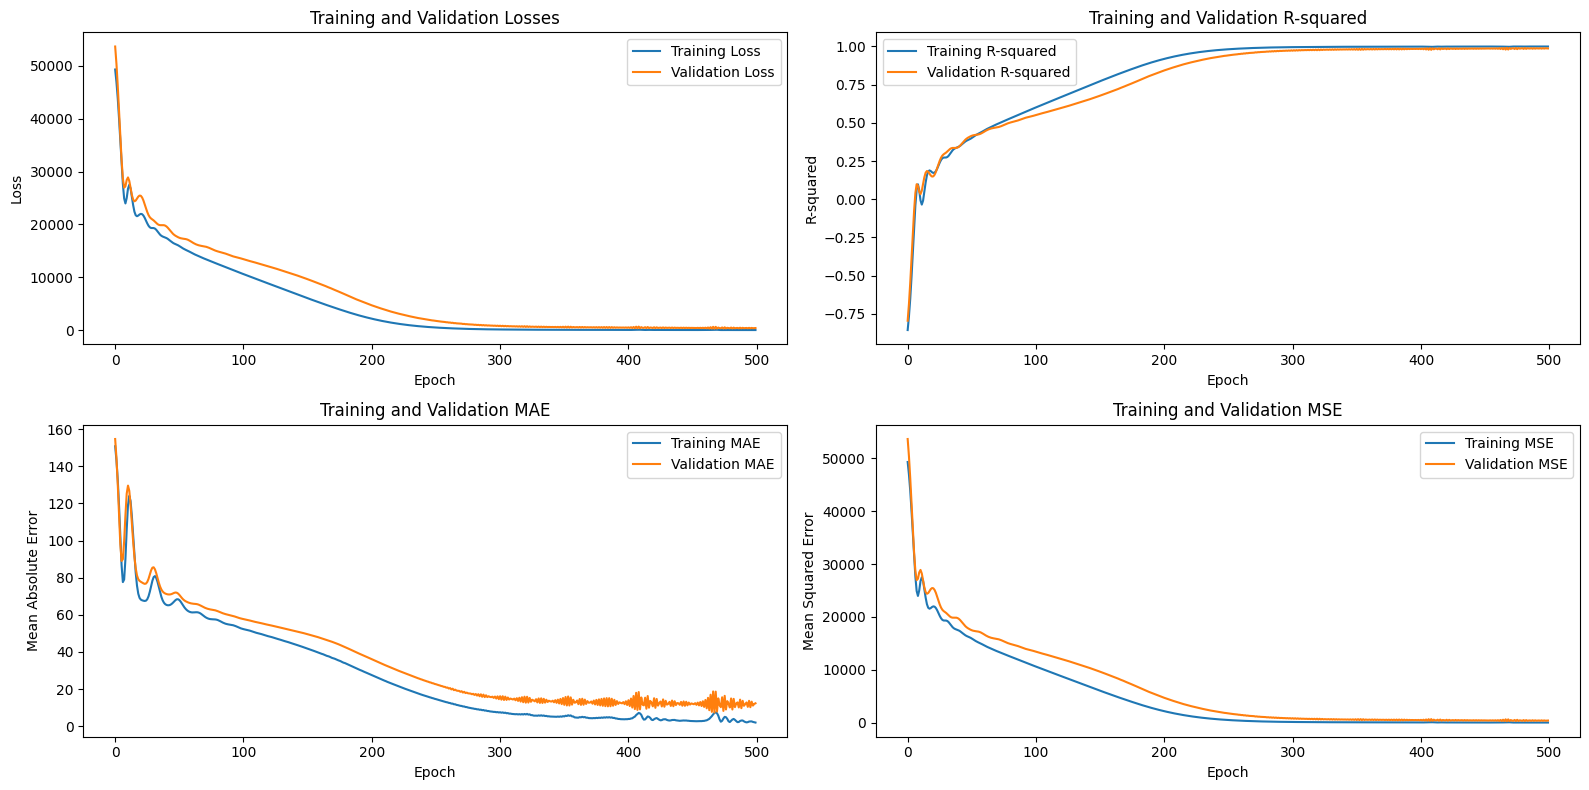

Test Loss: 4988.38623046875, Test R-squared: 0.9011092222211742, Test MAE: 33.733184814453125, Test MSE: 4988.38623046875


In [10]:
from google.colab import drive
import os
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_reduced_features.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_reduced_features.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_reduced_features.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Position encoding
def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

# PEGNN model definition
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 5, 30)  # Hyperparameter for k-nearest neighbors

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
    pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
    pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

    x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, out_channels=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss()

    y_train_t = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
    y_val_t = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val_t)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], out_channels=1)
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    model.train()

# Save the final model
save_model(model, model_path)

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')


PE-GNN model
Hier kan het model terug ingeladen worden indien er een versie is opgeslagen.

Best parameters:  {'hidden_channels': 123, 'lr': 0.00992691227826793, 'k': 30}


Final training:   0%|          | 1/500 [00:00<05:46,  1.44it/s]

Epoch 1, Training Loss: 7.649641990661621, Training R-squared: 0.999712091899751, Training MAE: 1.9849750995635986, Training MSE: 7.649641513824463
Epoch 1, Validation Loss: 9004.416015625, Validation R-squared: 0.6988350465131334, Validation MAE: 91.9758071899414, Validation MSE: 9004.416015625


Final training:   0%|          | 2/500 [00:01<05:31,  1.50it/s]

Epoch 2, Training Loss: 11281.59765625, Training R-squared: 0.5753966658301072, Training MAE: 103.37556457519531, Training MSE: 11281.59765625
Epoch 2, Validation Loss: 450.80865478515625, Validation R-squared: 0.9849220901056751, Validation MAE: 17.666574478149414, Validation MSE: 450.8086242675781


Final training:   1%|          | 3/500 [00:02<05:45,  1.44it/s]

Epoch 3, Training Loss: 706.6154174804688, Training R-squared: 0.9734052522683013, Training MAE: 25.80541229248047, Training MSE: 706.6154174804688
Epoch 3, Validation Loss: 3800.630615234375, Validation R-squared: 0.872882731049008, Validation MAE: 56.95964813232422, Validation MSE: 3800.630615234375


Final training:   1%|          | 4/500 [00:02<05:45,  1.44it/s]

Epoch 4, Training Loss: 2235.2587890625, Training R-squared: 0.9158719930099738, Training MAE: 45.371280670166016, Training MSE: 2235.2587890625
Epoch 4, Validation Loss: 8547.0869140625, Validation R-squared: 0.7141310259375818, Validation MAE: 87.8094482421875, Validation MSE: 8547.0869140625


Final training:   1%|          | 5/500 [00:03<05:45,  1.43it/s]

Epoch 5, Training Loss: 6209.28857421875, Training R-squared: 0.7663021840629333, Training MAE: 76.25098419189453, Training MSE: 6209.28857421875
Epoch 5, Validation Loss: 7621.953125, Validation R-squared: 0.7450733909668935, Validation MAE: 83.1490249633789, Validation MSE: 7621.95361328125


Final training:   1%|          | 6/500 [00:04<05:40,  1.45it/s]

Epoch 6, Training Loss: 5431.91015625, Training R-squared: 0.7955602534252298, Training MAE: 71.58128356933594, Training MSE: 5431.90966796875
Epoch 6, Validation Loss: 3778.26025390625, Validation R-squared: 0.8736309423445912, Validation MAE: 57.978538513183594, Validation MSE: 3778.260009765625


Final training:   1%|▏         | 7/500 [00:04<05:22,  1.53it/s]

Epoch 7, Training Loss: 2266.11328125, Training R-squared: 0.9147107319208658, Training MAE: 46.36869812011719, Training MSE: 2266.11328125
Epoch 7, Validation Loss: 749.3472900390625, Validation R-squared: 0.9749370580452487, Validation MAE: 22.898649215698242, Validation MSE: 749.3472900390625


Final training:   2%|▏         | 8/500 [00:05<05:11,  1.58it/s]

Epoch 8, Training Loss: 161.19082641601562, Training R-squared: 0.9939332907547563, Training MAE: 11.824317932128906, Training MSE: 161.19085693359375
Epoch 8, Validation Loss: 360.6015319824219, Validation R-squared: 0.9879391910361358, Validation MAE: 14.453131675720215, Validation MSE: 360.60150146484375


Final training:   2%|▏         | 9/500 [00:05<05:07,  1.60it/s]

Epoch 9, Training Loss: 665.67041015625, Training R-squared: 0.974946291457812, Training MAE: 23.644607543945312, Training MSE: 665.67041015625
Epoch 9, Validation Loss: 1549.504638671875, Validation R-squared: 0.9481747118282848, Validation MAE: 36.62974166870117, Validation MSE: 1549.50439453125


Final training:   2%|▏         | 10/500 [00:06<05:02,  1.62it/s]

Epoch 10, Training Loss: 2441.77587890625, Training R-squared: 0.908099349575997, Training MAE: 47.32991027832031, Training MSE: 2441.77587890625
Epoch 10, Validation Loss: 2063.847412109375, Validation R-squared: 0.9309718054381859, Validation MAE: 42.91694259643555, Validation MSE: 2063.847412109375


Final training:   2%|▏         | 11/500 [00:07<04:57,  1.64it/s]

Epoch 11, Training Loss: 3086.39208984375, Training R-squared: 0.8838380487641778, Training MAE: 53.73594665527344, Training MSE: 3086.392333984375
Epoch 11, Validation Loss: 1331.3021240234375, Validation R-squared: 0.9554727866884691, Validation MAE: 33.965335845947266, Validation MSE: 1331.3021240234375


Final training:   2%|▏         | 12/500 [00:07<04:55,  1.65it/s]

Epoch 12, Training Loss: 2073.290771484375, Training R-squared: 0.9219679707908053, Training MAE: 44.26365661621094, Training MSE: 2073.290283203125
Epoch 12, Validation Loss: 434.84686279296875, Validation R-squared: 0.9854559539517186, Validation MAE: 16.827383041381836, Validation MSE: 434.8468322753906


Final training:   3%|▎         | 13/500 [00:08<04:53,  1.66it/s]

Epoch 13, Training Loss: 636.4999389648438, Training R-squared: 0.9760441747272577, Training MAE: 24.44765281677246, Training MSE: 636.4999389648438
Epoch 13, Validation Loss: 460.2054443359375, Validation R-squared: 0.9846078026383805, Validation MAE: 11.685824394226074, Validation MSE: 460.20538330078125


Final training:   3%|▎         | 14/500 [00:08<04:50,  1.67it/s]

Epoch 14, Training Loss: 36.90641403198242, Training R-squared: 0.9986109604095501, Training MAE: 4.491605281829834, Training MSE: 36.90641403198242
Epoch 14, Validation Loss: 1464.6416015625, Validation R-squared: 0.9510130652306046, Validation MAE: 31.807836532592773, Validation MSE: 1464.6416015625


Final training:   3%|▎         | 15/500 [00:09<04:48,  1.68it/s]

Epoch 15, Training Loss: 494.892578125, Training R-squared: 0.9813738227821291, Training MAE: 20.130603790283203, Training MSE: 494.892578125
Epoch 15, Validation Loss: 2595.966064453125, Validation R-squared: 0.9131743854743051, Validation MAE: 45.46004867553711, Validation MSE: 2595.9658203125


Final training:   3%|▎         | 16/500 [00:10<04:47,  1.68it/s]

Epoch 16, Training Loss: 1280.1103515625, Training R-squared: 0.9518207356305963, Training MAE: 33.799251556396484, Training MSE: 1280.1102294921875
Epoch 16, Validation Loss: 2986.3671875, Validation R-squared: 0.9001168733565041, Validation MAE: 49.67158508300781, Validation MSE: 2986.3671875


Final training:   3%|▎         | 17/500 [00:10<04:48,  1.68it/s]

Epoch 17, Training Loss: 1579.1199951171875, Training R-squared: 0.9405669611238183, Training MAE: 38.014766693115234, Training MSE: 1579.1199951171875
Epoch 17, Validation Loss: 2439.42529296875, Validation R-squared: 0.9184100941035394, Validation MAE: 44.79404830932617, Validation MSE: 2439.42529296875


Final training:   4%|▎         | 18/500 [00:11<04:48,  1.67it/s]

Epoch 18, Training Loss: 1183.275390625, Training R-squared: 0.9554652939220076, Training MAE: 33.131412506103516, Training MSE: 1183.275390625
Epoch 18, Validation Loss: 1406.6851806640625, Validation R-squared: 0.9529515006153682, Validation MAE: 32.90599060058594, Validation MSE: 1406.68505859375


Final training:   4%|▍         | 19/500 [00:11<04:47,  1.67it/s]

Epoch 19, Training Loss: 485.8317565917969, Training R-squared: 0.9817148441017362, Training MAE: 21.22027015686035, Training MSE: 485.8317565917969
Epoch 19, Validation Loss: 541.2305908203125, Validation R-squared: 0.9818978066037513, Validation MAE: 17.286392211914062, Validation MSE: 541.2305297851562


Final training:   4%|▍         | 20/500 [00:12<04:46,  1.68it/s]

Epoch 20, Training Loss: 51.807899475097656, Training R-squared: 0.9980501158263504, Training MAE: 6.23613166809082, Training MSE: 51.80790710449219
Epoch 20, Validation Loss: 220.1699676513672, Validation R-squared: 0.9926361152689184, Validation MAE: 7.096559524536133, Validation MSE: 220.16995239257812


Final training:   4%|▍         | 21/500 [00:13<04:44,  1.68it/s]

Epoch 21, Training Loss: 152.75608825683594, Training R-squared: 0.9942507481074029, Training MAE: 10.428295135498047, Training MSE: 152.756103515625
Epoch 21, Validation Loss: 326.2207946777344, Validation R-squared: 0.9890891015632096, Validation MAE: 13.458824157714844, Validation MSE: 326.22076416015625


Final training:   4%|▍         | 22/500 [00:13<04:44,  1.68it/s]

Epoch 22, Training Loss: 568.5239868164062, Training R-squared: 0.9786025733308725, Training MAE: 22.170785903930664, Training MSE: 568.52392578125
Epoch 22, Validation Loss: 462.8708190917969, Validation R-squared: 0.9845186564898338, Validation MAE: 17.952991485595703, Validation MSE: 462.8707580566406


Final training:   5%|▍         | 23/500 [00:14<04:52,  1.63it/s]

Epoch 23, Training Loss: 831.8966064453125, Training R-squared: 0.9686900671268318, Training MAE: 27.413543701171875, Training MSE: 831.8966064453125
Epoch 23, Validation Loss: 397.2139892578125, Validation R-squared: 0.9867146352631376, Validation MAE: 16.2032413482666, Validation MSE: 397.2139892578125


Final training:   5%|▍         | 24/500 [00:14<05:02,  1.57it/s]

Epoch 24, Training Loss: 694.0123901367188, Training R-squared: 0.9738795872248278, Training MAE: 25.28807830810547, Training MSE: 694.0123901367188
Epoch 24, Validation Loss: 252.70018005371094, Validation R-squared: 0.9915480978243434, Validation MAE: 10.134852409362793, Validation MSE: 252.70021057128906


Final training:   5%|▌         | 25/500 [00:15<05:11,  1.53it/s]

Epoch 25, Training Loss: 316.73394775390625, Training R-squared: 0.9880791442634029, Training MAE: 17.102807998657227, Training MSE: 316.73394775390625
Epoch 25, Validation Loss: 300.968505859375, Validation R-squared: 0.9899336996389734, Validation MAE: 8.557917594909668, Validation MSE: 300.9684753417969


Final training:   5%|▌         | 26/500 [00:16<05:23,  1.47it/s]

Epoch 26, Training Loss: 45.56462860107422, Training R-squared: 0.9982850926882139, Training MAE: 5.876637935638428, Training MSE: 45.56462860107422
Epoch 26, Validation Loss: 642.9183349609375, Validation R-squared: 0.9784967199630984, Validation MAE: 18.087039947509766, Validation MSE: 642.9183349609375


Final training:   5%|▌         | 27/500 [00:17<05:14,  1.51it/s]

Epoch 27, Training Loss: 67.9780502319336, Training R-squared: 0.9974415230880599, Training MAE: 6.6817708015441895, Training MSE: 67.9780502319336
Epoch 27, Validation Loss: 1099.520263671875, Validation R-squared: 0.9632250436941877, Validation MAE: 26.974411010742188, Validation MSE: 1099.5203857421875


Final training:   6%|▌         | 28/500 [00:17<05:03,  1.56it/s]

Epoch 28, Training Loss: 282.4042053222656, Training R-squared: 0.9893712069737974, Training MAE: 15.240401268005371, Training MSE: 282.4042053222656
Epoch 28, Validation Loss: 1375.1134033203125, Validation R-squared: 0.9540074587459499, Validation MAE: 31.365070343017578, Validation MSE: 1375.1134033203125


Final training:   6%|▌         | 29/500 [00:18<04:56,  1.59it/s]

Epoch 29, Training Loss: 443.7731628417969, Training R-squared: 0.9832977945446231, Training MAE: 19.643962860107422, Training MSE: 443.7731628417969
Epoch 29, Validation Loss: 1304.381591796875, Validation R-squared: 0.9563731728120695, Validation MAE: 30.574655532836914, Validation MSE: 1304.3817138671875


Final training:   6%|▌         | 30/500 [00:18<04:49,  1.62it/s]

Epoch 30, Training Loss: 401.7151184082031, Training R-squared: 0.9848807246616128, Training MAE: 18.85501480102539, Training MSE: 401.7151184082031
Epoch 30, Validation Loss: 960.1486206054688, Validation R-squared: 0.9678865205726521, Validation MAE: 25.257110595703125, Validation MSE: 960.1486206054688


Final training:   6%|▌         | 31/500 [00:19<04:47,  1.63it/s]

Epoch 31, Training Loss: 209.71646118164062, Training R-squared: 0.9921069417944041, Training MAE: 13.522147178649902, Training MSE: 209.71646118164062
Epoch 31, Validation Loss: 565.075927734375, Validation R-squared: 0.9811002653049835, Validation MAE: 17.119571685791016, Validation MSE: 565.0758666992188


Final training:   6%|▋         | 32/500 [00:20<04:44,  1.64it/s]

Epoch 32, Training Loss: 44.36532974243164, Training R-squared: 0.9983302305036794, Training MAE: 5.648045539855957, Training MSE: 44.365333557128906
Epoch 32, Validation Loss: 309.1915283203125, Validation R-squared: 0.9896586661892351, Validation MAE: 9.366777420043945, Validation MSE: 309.1915588378906


Final training:   7%|▋         | 33/500 [00:20<04:40,  1.66it/s]

Epoch 33, Training Loss: 33.714637756347656, Training R-squared: 0.9987310885621182, Training MAE: 4.582751274108887, Training MSE: 33.71464157104492
Epoch 33, Validation Loss: 226.0564727783203, Validation R-squared: 0.9924392329723716, Validation MAE: 7.223429203033447, Validation MSE: 226.05648803710938


Final training:   7%|▋         | 34/500 [00:21<04:40,  1.66it/s]

Epoch 34, Training Loss: 147.61756896972656, Training R-squared: 0.9944441462658492, Training MAE: 10.955427169799805, Training MSE: 147.61756896972656
Epoch 34, Validation Loss: 222.6506805419922, Validation R-squared: 0.9925531444902869, Validation MAE: 8.343423843383789, Validation MSE: 222.65065002441406


Final training:   7%|▋         | 35/500 [00:21<04:38,  1.67it/s]

Epoch 35, Training Loss: 244.59352111816406, Training R-squared: 0.990794280524646, Training MAE: 14.625469207763672, Training MSE: 244.59352111816406
Epoch 35, Validation Loss: 215.8769989013672, Validation R-squared: 0.9927796993203373, Validation MAE: 8.011380195617676, Validation MSE: 215.87701416015625


Final training:   7%|▋         | 36/500 [00:22<04:35,  1.68it/s]

Epoch 36, Training Loss: 222.60995483398438, Training R-squared: 0.9916216717842758, Training MAE: 14.06871509552002, Training MSE: 222.60995483398438
Epoch 36, Validation Loss: 221.72421264648438, Validation R-squared: 0.992584131488049, Validation MAE: 7.031003952026367, Validation MSE: 221.72421264648438


Final training:   7%|▋         | 37/500 [00:22<04:33,  1.69it/s]

Epoch 37, Training Loss: 112.54076385498047, Training R-squared: 0.9957643251116746, Training MAE: 9.797802925109863, Training MSE: 112.5407485961914
Epoch 37, Validation Loss: 310.0832214355469, Validation R-squared: 0.9896288439973482, Validation MAE: 9.66826343536377, Validation MSE: 310.0832214355469


Final training:   8%|▊         | 38/500 [00:23<04:33,  1.69it/s]

Epoch 38, Training Loss: 25.731172561645508, Training R-squared: 0.9990315609158722, Training MAE: 4.05130672454834, Training MSE: 25.731168746948242
Epoch 38, Validation Loss: 496.83343505859375, Validation R-squared: 0.983382728967323, Validation MAE: 15.503190994262695, Validation MSE: 496.8334045410156


Final training:   8%|▊         | 39/500 [00:24<04:32,  1.69it/s]

Epoch 39, Training Loss: 31.737295150756836, Training R-squared: 0.9988055096180172, Training MAE: 4.489806175231934, Training MSE: 31.73729133605957
Epoch 39, Validation Loss: 700.4479370117188, Validation R-squared: 0.9765725629735323, Validation MAE: 20.49429702758789, Validation MSE: 700.447998046875


Final training:   8%|▊         | 40/500 [00:24<04:32,  1.69it/s]

Epoch 40, Training Loss: 98.9460220336914, Training R-squared: 0.9962759878865632, Training MAE: 8.793279647827148, Training MSE: 98.94600677490234
Epoch 40, Validation Loss: 804.104736328125, Validation R-squared: 0.9731056205059652, Validation MAE: 22.751785278320312, Validation MSE: 804.104736328125


Final training:   8%|▊         | 41/500 [00:25<04:32,  1.68it/s]

Epoch 41, Training Loss: 143.4749755859375, Training R-squared: 0.994600059888866, Training MAE: 11.006829261779785, Training MSE: 143.4749755859375
Epoch 41, Validation Loss: 752.4075927734375, Validation R-squared: 0.9748347041943344, Validation MAE: 21.830387115478516, Validation MSE: 752.407470703125


Final training:   8%|▊         | 42/500 [00:25<04:31,  1.69it/s]

Epoch 42, Training Loss: 119.02745819091797, Training R-squared: 0.995520186590268, Training MAE: 10.085566520690918, Training MSE: 119.02745819091797
Epoch 42, Validation Loss: 589.5675659179688, Validation R-squared: 0.9802811083136844, Validation MAE: 18.244535446166992, Validation MSE: 589.567626953125


Final training:   9%|▊         | 43/500 [00:26<04:29,  1.69it/s]

Epoch 43, Training Loss: 54.98944854736328, Training R-squared: 0.9979303727959037, Training MAE: 6.601873874664307, Training MSE: 54.98944091796875
Epoch 43, Validation Loss: 413.140625, Validation R-squared: 0.9861819491220973, Validation MAE: 13.325011253356934, Validation MSE: 413.140625


Final training:   9%|▉         | 44/500 [00:27<04:37,  1.64it/s]

Epoch 44, Training Loss: 15.683355331420898, Training R-squared: 0.9994097285209892, Training MAE: 3.070915460586548, Training MSE: 15.683357238769531
Epoch 44, Validation Loss: 295.14263916015625, Validation R-squared: 0.9901285524287772, Validation MAE: 9.144787788391113, Validation MSE: 295.14263916015625


Final training:   9%|▉         | 45/500 [00:27<04:48,  1.57it/s]

Epoch 45, Training Loss: 31.195341110229492, Training R-squared: 0.998825906902953, Training MAE: 4.495120525360107, Training MSE: 31.195341110229492
Epoch 45, Validation Loss: 243.92245483398438, Validation R-squared: 0.9918416810480712, Validation MAE: 7.3043599128723145, Validation MSE: 243.92247009277344


Final training:   9%|▉         | 46/500 [00:28<04:58,  1.52it/s]

Epoch 46, Training Loss: 71.35147857666016, Training R-squared: 0.9973145583457153, Training MAE: 7.4504594802856445, Training MSE: 71.35147094726562
Epoch 46, Validation Loss: 232.3368682861328, Validation R-squared: 0.9922291762873661, Validation MAE: 7.045212745666504, Validation MSE: 232.33688354492188


Final training:   9%|▉         | 47/500 [00:29<05:07,  1.47it/s]

Epoch 47, Training Loss: 85.42920684814453, Training R-squared: 0.996784717540676, Training MAE: 8.440783500671387, Training MSE: 85.42919921875
Epoch 47, Validation Loss: 247.60438537597656, Validation R-squared: 0.9917185338891107, Validation MAE: 7.4966044425964355, Validation MSE: 247.6043701171875


Final training:  10%|▉         | 48/500 [00:29<05:01,  1.50it/s]

Epoch 48, Training Loss: 58.79273986816406, Training R-squared: 0.9977872287784313, Training MAE: 6.9372358322143555, Training MSE: 58.79274368286133
Epoch 48, Validation Loss: 302.01153564453125, Validation R-squared: 0.9898988130939669, Validation MAE: 9.409193992614746, Validation MSE: 302.0115051269531


Final training:  10%|▉         | 49/500 [00:30<04:50,  1.55it/s]

Epoch 49, Training Loss: 22.812721252441406, Training R-squared: 0.999141402006199, Training MAE: 3.9095826148986816, Training MSE: 22.812721252441406
Epoch 49, Validation Loss: 399.4255676269531, Validation R-squared: 0.9866406691474885, Validation MAE: 12.810998916625977, Validation MSE: 399.425537109375


Final training:  10%|█         | 50/500 [00:31<04:43,  1.59it/s]

Epoch 50, Training Loss: 13.689404487609863, Training R-squared: 0.9994847745002596, Training MAE: 2.8562772274017334, Training MSE: 13.689404487609863
Epoch 50, Validation Loss: 507.00543212890625, Validation R-squared: 0.9830425129223398, Validation MAE: 16.09173011779785, Validation MSE: 507.00543212890625


Final training:  10%|█         | 51/500 [00:31<04:38,  1.61it/s]

Epoch 51, Training Loss: 32.99254608154297, Training R-squared: 0.9987582659832615, Training MAE: 4.749654769897461, Training MSE: 32.99254608154297
Epoch 51, Validation Loss: 570.4017944335938, Validation R-squared: 0.9809221332258181, Validation MAE: 17.91109848022461, Validation MSE: 570.4017944335938


Final training:  10%|█         | 52/500 [00:32<04:36,  1.62it/s]

Epoch 52, Training Loss: 52.03723907470703, Training R-squared: 0.9980414843772618, Training MAE: 6.311370372772217, Training MSE: 52.03723907470703
Epoch 52, Validation Loss: 556.5227661132812, Validation R-squared: 0.981386336957752, Validation MAE: 17.747684478759766, Validation MSE: 556.5227661132812


Final training:  11%|█         | 53/500 [00:32<04:34,  1.63it/s]

Epoch 53, Training Loss: 47.71883773803711, Training R-squared: 0.9982040153525724, Training MAE: 6.131764888763428, Training MSE: 47.718833923339844
Epoch 53, Validation Loss: 479.02154541015625, Validation R-squared: 0.983978471166185, Validation MAE: 15.810249328613281, Validation MSE: 479.0215759277344


Final training:  11%|█         | 54/500 [00:33<04:31,  1.64it/s]

Epoch 54, Training Loss: 26.304229736328125, Training R-squared: 0.9990099928784816, Training MAE: 4.384254455566406, Training MSE: 26.30422592163086
Epoch 54, Validation Loss: 383.2394104003906, Validation R-squared: 0.9871820357225803, Validation MAE: 12.908605575561523, Validation MSE: 383.2393798828125


Final training:  11%|█         | 55/500 [00:34<04:30,  1.65it/s]

Epoch 55, Training Loss: 11.832330703735352, Training R-squared: 0.9995546688471434, Training MAE: 2.6641433238983154, Training MSE: 11.832330703735352
Epoch 55, Validation Loss: 309.6510314941406, Validation R-squared: 0.9896432996242871, Validation MAE: 10.207634925842285, Validation MSE: 309.6510009765625


Final training:  11%|█         | 56/500 [00:34<04:28,  1.65it/s]

Epoch 56, Training Loss: 16.940719604492188, Training R-squared: 0.9993624053815591, Training MAE: 3.1881282329559326, Training MSE: 16.940719604492188
Epoch 56, Validation Loss: 272.3829345703125, Validation R-squared: 0.9908897817931684, Validation MAE: 8.634531021118164, Validation MSE: 272.3829345703125


Final training:  11%|█▏        | 57/500 [00:35<04:25,  1.67it/s]

Epoch 57, Training Loss: 30.497474670410156, Training R-squared: 0.9988521723351897, Training MAE: 4.589293003082275, Training MSE: 30.497474670410156
Epoch 57, Validation Loss: 267.1936950683594, Validation R-squared: 0.9910633419941157, Validation MAE: 8.314177513122559, Validation MSE: 267.1937255859375


Final training:  12%|█▏        | 58/500 [00:35<04:25,  1.66it/s]

Epoch 58, Training Loss: 33.83224868774414, Training R-squared: 0.9987266621530598, Training MAE: 4.987826824188232, Training MSE: 33.83224868774414
Epoch 58, Validation Loss: 289.7358703613281, Validation R-squared: 0.9903093886424859, Validation MAE: 9.064969062805176, Validation MSE: 289.7358703613281


Final training:  12%|█▏        | 59/500 [00:36<04:23,  1.68it/s]

Epoch 59, Training Loss: 23.308822631835938, Training R-squared: 0.9991227302896107, Training MAE: 4.030989646911621, Training MSE: 23.308822631835938
Epoch 59, Validation Loss: 338.4244384765625, Validation R-squared: 0.9886809337084974, Validation MAE: 10.787517547607422, Validation MSE: 338.4244384765625


Final training:  12%|█▏        | 60/500 [00:37<04:23,  1.67it/s]

Epoch 60, Training Loss: 12.017083168029785, Training R-squared: 0.9995477153515397, Training MAE: 2.690028429031372, Training MSE: 12.017083168029785
Epoch 60, Validation Loss: 402.4891052246094, Validation R-squared: 0.986538204543317, Validation MAE: 12.976814270019531, Validation MSE: 402.48907470703125


Final training:  12%|█▏        | 61/500 [00:37<04:24,  1.66it/s]

Epoch 61, Training Loss: 11.722901344299316, Training R-squared: 0.9995587874477568, Training MAE: 2.6412196159362793, Training MSE: 11.722899436950684
Epoch 61, Validation Loss: 456.7434387207031, Validation R-squared: 0.9847235938448399, Validation MAE: 14.745573043823242, Validation MSE: 456.743408203125


Final training:  12%|█▏        | 62/500 [00:38<04:25,  1.65it/s]

Epoch 62, Training Loss: 19.421710968017578, Training R-squared: 0.9992690287817815, Training MAE: 3.577206611633301, Training MSE: 19.421710968017578
Epoch 62, Validation Loss: 475.1220397949219, Validation R-squared: 0.9841088941136629, Validation MAE: 15.446807861328125, Validation MSE: 475.12213134765625


Final training:  13%|█▎        | 63/500 [00:38<04:24,  1.65it/s]

Epoch 63, Training Loss: 23.44049644470215, Training R-squared: 0.9991177745204944, Training MAE: 4.065598487854004, Training MSE: 23.44049644470215
Epoch 63, Validation Loss: 450.08099365234375, Validation R-squared: 0.984946426493206, Validation MAE: 14.90091609954834, Validation MSE: 450.0810241699219


Final training:  13%|█▎        | 64/500 [00:39<04:28,  1.63it/s]

Epoch 64, Training Loss: 18.607301712036133, Training R-squared: 0.9992996805519272, Training MAE: 3.5936646461486816, Training MSE: 18.607301712036133
Epoch 64, Validation Loss: 397.4568786621094, Validation R-squared: 0.9867065126996422, Validation MAE: 13.411173820495605, Validation MSE: 397.4568786621094


Final training:  13%|█▎        | 65/500 [00:40<04:36,  1.57it/s]

Epoch 65, Training Loss: 11.227431297302246, Training R-squared: 0.9995774352963215, Training MAE: 2.6407828330993652, Training MSE: 11.227432250976562
Epoch 65, Validation Loss: 343.0101013183594, Validation R-squared: 0.98852755982882, Validation MAE: 11.61592960357666, Validation MSE: 343.0101013183594


Final training:  13%|█▎        | 66/500 [00:40<04:43,  1.53it/s]

Epoch 66, Training Loss: 9.659307479858398, Training R-squared: 0.9996364544873457, Training MAE: 2.344766855239868, Training MSE: 9.659307479858398
Epoch 66, Validation Loss: 305.6113586425781, Validation R-squared: 0.9897784118285541, Validation MAE: 10.201983451843262, Validation MSE: 305.6113586425781


Final training:  13%|█▎        | 67/500 [00:41<04:46,  1.51it/s]

Epoch 67, Training Loss: 13.899794578552246, Training R-squared: 0.9994768560985868, Training MAE: 2.8956007957458496, Training MSE: 13.899794578552246
Epoch 67, Validation Loss: 291.8136291503906, Validation R-squared: 0.9902398957877233, Validation MAE: 9.588096618652344, Validation MSE: 291.8136291503906


Final training:  14%|█▎        | 68/500 [00:42<04:50,  1.49it/s]

Epoch 68, Training Loss: 16.925085067749023, Training R-squared: 0.9993629937583904, Training MAE: 3.2973554134368896, Training MSE: 16.925086975097656
Epoch 68, Validation Loss: 301.0887145996094, Validation R-squared: 0.9899296764827169, Validation MAE: 9.850080490112305, Validation MSE: 301.0887451171875


Final training:  14%|█▍        | 69/500 [00:42<04:41,  1.53it/s]

Epoch 69, Training Loss: 14.472236633300781, Training R-squared: 0.9994553111693587, Training MAE: 3.0330100059509277, Training MSE: 14.472236633300781
Epoch 69, Validation Loss: 329.9559326171875, Validation R-squared: 0.9889641736200594, Validation MAE: 10.842196464538574, Validation MSE: 329.9559326171875


Final training:  14%|█▍        | 70/500 [00:43<04:33,  1.57it/s]

Epoch 70, Training Loss: 9.865032196044922, Training R-squared: 0.9996287116762156, Training MAE: 2.413954734802246, Training MSE: 9.865032196044922
Epoch 70, Validation Loss: 369.8175048828125, Validation R-squared: 0.9876309487878016, Validation MAE: 12.19933032989502, Validation MSE: 369.8175048828125


Final training:  14%|█▍        | 71/500 [00:44<04:28,  1.60it/s]

Epoch 71, Training Loss: 8.579806327819824, Training R-squared: 0.9996770834780938, Training MAE: 2.2377657890319824, Training MSE: 8.579806327819824
Epoch 71, Validation Loss: 405.4319152832031, Validation R-squared: 0.9864397769599182, Validation MAE: 13.38542366027832, Validation MSE: 405.431884765625


Final training:  14%|█▍        | 72/500 [00:44<04:23,  1.63it/s]

Epoch 72, Training Loss: 11.021574020385742, Training R-squared: 0.9995851831207698, Training MAE: 2.597592353820801, Training MSE: 11.021574020385742
Epoch 72, Validation Loss: 421.0559997558594, Validation R-squared: 0.9859172091058757, Validation MAE: 13.950996398925781, Validation MSE: 421.05596923828125


Final training:  15%|█▍        | 73/500 [00:45<04:19,  1.65it/s]

Epoch 73, Training Loss: 12.897374153137207, Training R-squared: 0.9995145840418482, Training MAE: 2.875434160232544, Training MSE: 12.897372245788574
Epoch 73, Validation Loss: 410.51275634765625, Validation R-squared: 0.9862698413086645, Validation MAE: 13.720320701599121, Validation MSE: 410.51275634765625


Final training:  15%|█▍        | 74/500 [00:45<04:18,  1.65it/s]

Epoch 74, Training Loss: 11.43535041809082, Training R-squared: 0.9995696098971846, Training MAE: 2.6931324005126953, Training MSE: 11.43535041809082
Epoch 74, Validation Loss: 380.9769287109375, Validation R-squared: 0.9872577057458474, Validation MAE: 12.850083351135254, Validation MSE: 380.9769592285156


Final training:  15%|█▌        | 75/500 [00:46<04:15,  1.66it/s]

Epoch 75, Training Loss: 8.626984596252441, Training R-squared: 0.9996753078431934, Training MAE: 2.270050525665283, Training MSE: 8.626984596252441
Epoch 75, Validation Loss: 347.1228942871094, Validation R-squared: 0.9883900017559148, Validation MAE: 11.737792015075684, Validation MSE: 347.12286376953125


Final training:  15%|█▌        | 76/500 [00:47<04:13,  1.67it/s]

Epoch 76, Training Loss: 7.866424560546875, Training R-squared: 0.9997039328756068, Training MAE: 2.1221063137054443, Training MSE: 7.866425037384033
Epoch 76, Validation Loss: 321.8803405761719, Validation R-squared: 0.9892342728942601, Validation MAE: 10.833673477172852, Validation MSE: 321.8803405761719


Final training:  15%|█▌        | 77/500 [00:47<04:13,  1.67it/s]

Epoch 77, Training Loss: 9.343303680419922, Training R-squared: 0.9996483479005142, Training MAE: 2.342880964279175, Training MSE: 9.343303680419922
Epoch 77, Validation Loss: 311.8304443359375, Validation R-squared: 0.9895704059415119, Validation MAE: 10.439697265625, Validation MSE: 311.8304443359375


Final training:  16%|█▌        | 78/500 [00:48<04:14,  1.66it/s]

Epoch 78, Training Loss: 10.339666366577148, Training R-squared: 0.9996108479582971, Training MAE: 2.5005886554718018, Training MSE: 10.339666366577148
Epoch 78, Validation Loss: 317.9521179199219, Validation R-squared: 0.9893656568948644, Validation MAE: 10.64051342010498, Validation MSE: 317.9521179199219


Final training:  16%|█▌        | 79/500 [00:48<04:12,  1.67it/s]

Epoch 79, Training Loss: 9.283611297607422, Training R-squared: 0.999650594514705, Training MAE: 2.3530805110931396, Training MSE: 9.283610343933105
Epoch 79, Validation Loss: 337.00909423828125, Validation R-squared: 0.9887282725748872, Validation MAE: 11.319392204284668, Validation MSE: 337.0090637207031


Final training:  16%|█▌        | 80/500 [00:49<04:10,  1.67it/s]

Epoch 80, Training Loss: 7.616118431091309, Training R-squared: 0.9997133536016556, Training MAE: 2.098796844482422, Training MSE: 7.616118431091309
Epoch 80, Validation Loss: 361.5320739746094, Validation R-squared: 0.9879080670591882, Validation MAE: 12.179718017578125, Validation MSE: 361.5320739746094


Final training:  16%|█▌        | 81/500 [00:50<04:08,  1.68it/s]

Epoch 81, Training Loss: 7.346601486206055, Training R-squared: 0.9997234973528257, Training MAE: 2.0673747062683105, Training MSE: 7.346601486206055
Epoch 81, Validation Loss: 381.1209411621094, Validation R-squared: 0.9872528905914258, Validation MAE: 12.866943359375, Validation MSE: 381.1209716796875


Final training:  16%|█▋        | 82/500 [00:50<04:07,  1.69it/s]

Epoch 82, Training Loss: 8.274441719055176, Training R-squared: 0.9996885764456681, Training MAE: 2.227632999420166, Training MSE: 8.274441719055176
Epoch 82, Validation Loss: 387.1556701660156, Validation R-squared: 0.9870510522190067, Validation MAE: 13.116549491882324, Validation MSE: 387.1556701660156


Final training:  17%|█▋        | 83/500 [00:51<04:06,  1.69it/s]

Epoch 83, Training Loss: 8.651305198669434, Training R-squared: 0.9996743924879591, Training MAE: 2.2977559566497803, Training MSE: 8.651304244995117
Epoch 83, Validation Loss: 377.8272399902344, Validation R-squared: 0.9873630517009241, Validation MAE: 12.858443260192871, Validation MSE: 377.8272399902344


Final training:  17%|█▋        | 84/500 [00:51<04:07,  1.68it/s]

Epoch 84, Training Loss: 7.808013439178467, Training R-squared: 0.9997061312807198, Training MAE: 2.16253924369812, Training MSE: 7.808014392852783
Epoch 84, Validation Loss: 358.8159484863281, Validation R-squared: 0.9879989106345866, Validation MAE: 12.243097305297852, Validation MSE: 358.81597900390625


Final training:  17%|█▋        | 85/500 [00:52<04:09,  1.66it/s]

Epoch 85, Training Loss: 6.869147300720215, Training R-squared: 0.9997414672226002, Training MAE: 1.9922285079956055, Training MSE: 6.869147300720215
Epoch 85, Validation Loss: 339.1776123046875, Validation R-squared: 0.9886557423625925, Validation MAE: 11.55331802368164, Validation MSE: 339.1776123046875


Final training:  17%|█▋        | 86/500 [00:53<04:20,  1.59it/s]

Epoch 86, Training Loss: 6.905696392059326, Training R-squared: 0.9997400916250854, Training MAE: 1.9867563247680664, Training MSE: 6.905696392059326
Epoch 86, Validation Loss: 326.4084777832031, Validation R-squared: 0.9890828237561314, Validation MAE: 11.071276664733887, Validation MSE: 326.408447265625


Final training:  17%|█▋        | 87/500 [00:53<04:23,  1.57it/s]

Epoch 87, Training Loss: 7.470942497253418, Training R-squared: 0.9997188175409696, Training MAE: 2.0817434787750244, Training MSE: 7.470943450927734
Epoch 87, Validation Loss: 324.0908203125, Validation R-squared: 0.9891603417368238, Validation MAE: 10.964284896850586, Validation MSE: 324.0908203125


Final training:  18%|█▊        | 88/500 [00:54<04:29,  1.53it/s]

Epoch 88, Training Loss: 7.478183746337891, Training R-squared: 0.9997185450237558, Training MAE: 2.0880277156829834, Training MSE: 7.478183746337891
Epoch 88, Validation Loss: 331.85589599609375, Validation R-squared: 0.9889006264605104, Validation MAE: 11.23843765258789, Validation MSE: 331.85589599609375


Final training:  18%|█▊        | 89/500 [00:55<04:35,  1.49it/s]

Epoch 89, Training Loss: 6.8236212730407715, Training R-squared: 0.9997431806935266, Training MAE: 1.982035756111145, Training MSE: 6.8236212730407715
Epoch 89, Validation Loss: 345.8680114746094, Validation R-squared: 0.9884319727041894, Validation MAE: 11.750039100646973, Validation MSE: 345.8680114746094


Final training:  18%|█▊        | 90/500 [00:55<04:27,  1.53it/s]

Epoch 90, Training Loss: 6.358146667480469, Training R-squared: 0.9997606996737414, Training MAE: 1.9083211421966553, Training MSE: 6.358145713806152
Epoch 90, Validation Loss: 359.7777099609375, Validation R-squared: 0.9879667441710861, Validation MAE: 12.266873359680176, Validation MSE: 359.7776794433594


Final training:  18%|█▊        | 91/500 [00:56<04:20,  1.57it/s]

Epoch 91, Training Loss: 6.523664951324463, Training R-squared: 0.9997544700833171, Training MAE: 1.9451431035995483, Training MSE: 6.5236639976501465
Epoch 91, Validation Loss: 367.18218994140625, Validation R-squared: 0.9877190919134563, Validation MAE: 12.571866989135742, Validation MSE: 367.18212890625


Final training:  18%|█▊        | 92/500 [00:57<04:13,  1.61it/s]

Epoch 92, Training Loss: 6.801759243011475, Training R-squared: 0.9997440035170506, Training MAE: 2.000554323196411, Training MSE: 6.801758289337158
Epoch 92, Validation Loss: 364.9522705078125, Validation R-squared: 0.9877936740888561, Validation MAE: 12.551136016845703, Validation MSE: 364.9522399902344


Final training:  19%|█▊        | 93/500 [00:57<04:08,  1.64it/s]

Epoch 93, Training Loss: 6.61808443069458, Training R-squared: 0.9997509164050534, Training MAE: 1.9718043804168701, Training MSE: 6.61808443069458
Epoch 93, Validation Loss: 354.82550048828125, Validation R-squared: 0.9881323774095584, Validation MAE: 12.241472244262695, Validation MSE: 354.82550048828125


Final training:  19%|█▉        | 94/500 [00:58<04:06,  1.65it/s]

Epoch 94, Training Loss: 6.1688971519470215, Training R-squared: 0.9997678223807365, Training MAE: 1.8873668909072876, Training MSE: 6.16889762878418
Epoch 94, Validation Loss: 342.0135803222656, Validation R-squared: 0.9885608892304207, Validation MAE: 11.800874710083008, Validation MSE: 342.0135803222656


Final training:  19%|█▉        | 95/500 [00:58<04:03,  1.66it/s]

Epoch 95, Training Loss: 6.000787258148193, Training R-squared: 0.9997741495461151, Training MAE: 1.848207950592041, Training MSE: 6.000786304473877
Epoch 95, Validation Loss: 332.1309814453125, Validation R-squared: 0.9888914261165879, Validation MAE: 11.429445266723633, Validation MSE: 332.1309814453125


Final training:  19%|█▉        | 96/500 [00:59<04:02,  1.67it/s]

Epoch 96, Training Loss: 6.16304349899292, Training R-squared: 0.9997680427343262, Training MAE: 1.875545859336853, Training MSE: 6.163043022155762
Epoch 96, Validation Loss: 328.72271728515625, Validation R-squared: 0.989005420402344, Validation MAE: 11.275615692138672, Validation MSE: 328.7227478027344


Final training:  19%|█▉        | 97/500 [01:00<04:02,  1.66it/s]

Epoch 97, Training Loss: 6.224123001098633, Training R-squared: 0.9997657438599846, Training MAE: 1.8889284133911133, Training MSE: 6.224123001098633
Epoch 97, Validation Loss: 332.3817443847656, Validation R-squared: 0.9888830402471991, Validation MAE: 11.381732940673828, Validation MSE: 332.3817138671875


Final training:  20%|█▉        | 98/500 [01:00<03:59,  1.68it/s]

Epoch 98, Training Loss: 5.985669136047363, Training R-squared: 0.9997747185025212, Training MAE: 1.8493235111236572, Training MSE: 5.985669136047363
Epoch 98, Validation Loss: 340.8967590332031, Validation R-squared: 0.9885982430453272, Validation MAE: 11.676779747009277, Validation MSE: 340.8967590332031


Final training:  20%|█▉        | 99/500 [01:01<04:00,  1.67it/s]

Epoch 99, Training Loss: 5.729981899261475, Training R-squared: 0.9997843417940585, Training MAE: 1.8064478635787964, Training MSE: 5.729980945587158
Epoch 99, Validation Loss: 350.1062927246094, Validation R-squared: 0.9882902182437424, Validation MAE: 12.015904426574707, Validation MSE: 350.1062927246094


Final training:  20%|██        | 100/500 [01:01<04:02,  1.65it/s]

Epoch 100, Training Loss: 5.717188835144043, Training R-squared: 0.9997848232696503, Training MAE: 1.8095101118087769, Training MSE: 5.717188835144043
Epoch 100, Validation Loss: 355.6190490722656, Validation R-squared: 0.9881058355021192, Validation MAE: 12.244756698608398, Validation MSE: 355.6190490722656


Final training:  20%|██        | 101/500 [01:02<04:02,  1.65it/s]

Epoch 101, Training Loss: 5.8045454025268555, Training R-squared: 0.99978153542289, Training MAE: 1.8317203521728516, Training MSE: 5.8045454025268555
Epoch 101, Validation Loss: 354.96319580078125, Validation R-squared: 0.9881277720997401, Validation MAE: 12.26990795135498, Validation MSE: 354.96319580078125


Final training:  20%|██        | 102/500 [01:03<03:59,  1.66it/s]

Epoch 102, Training Loss: 5.731510639190674, Training R-squared: 0.9997842842404557, Training MAE: 1.8200644254684448, Training MSE: 5.731510639190674
Epoch 102, Validation Loss: 348.815185546875, Validation R-squared: 0.9883334004155377, Validation MAE: 12.097005844116211, Validation MSE: 348.815185546875


Final training:  21%|██        | 103/500 [01:03<03:58,  1.66it/s]

Epoch 103, Training Loss: 5.529844284057617, Training R-squared: 0.9997918743262867, Training MAE: 1.7793655395507812, Training MSE: 5.529843807220459
Epoch 103, Validation Loss: 340.3793640136719, Validation R-squared: 0.9886155483499685, Validation MAE: 11.821484565734863, Validation MSE: 340.3793640136719


Final training:  21%|██        | 104/500 [01:04<03:58,  1.66it/s]

Epoch 104, Training Loss: 5.4228620529174805, Training R-squared: 0.9997959007983661, Training MAE: 1.7558271884918213, Training MSE: 5.422861576080322
Epoch 104, Validation Loss: 333.509521484375, Validation R-squared: 0.9888453196491125, Validation MAE: 11.576522827148438, Validation MSE: 333.5094909667969


Final training:  21%|██        | 105/500 [01:04<03:57,  1.66it/s]

Epoch 105, Training Loss: 5.453904151916504, Training R-squared: 0.9997947324454122, Training MAE: 1.7609225511550903, Training MSE: 5.453904151916504
Epoch 105, Validation Loss: 330.89013671875, Validation R-squared: 0.9889329296930625, Validation MAE: 11.46650218963623, Validation MSE: 330.89013671875


Final training:  21%|██        | 106/500 [01:05<04:15,  1.54it/s]

Epoch 106, Training Loss: 5.452604293823242, Training R-squared: 0.9997947813738646, Training MAE: 1.7618252038955688, Training MSE: 5.452604293823242
Epoch 106, Validation Loss: 333.11651611328125, Validation R-squared: 0.9888584632776162, Validation MAE: 11.526926040649414, Validation MSE: 333.1165771484375


Final training:  21%|██▏       | 107/500 [01:06<04:21,  1.50it/s]

Epoch 107, Training Loss: 5.332240104675293, Training R-squared: 0.9997993114998619, Training MAE: 1.7414559125900269, Training MSE: 5.332240581512451
Epoch 107, Validation Loss: 338.6727600097656, Validation R-squared: 0.9886726286515409, Validation MAE: 11.713271141052246, Validation MSE: 338.6727600097656


Final training:  22%|██▏       | 108/500 [01:07<04:24,  1.48it/s]

Epoch 108, Training Loss: 5.207362651824951, Training R-squared: 0.9998040114921471, Training MAE: 1.7206814289093018, Training MSE: 5.207362651824951
Epoch 108, Validation Loss: 344.66015625, Validation R-squared: 0.988472371475463, Validation MAE: 11.927863121032715, Validation MSE: 344.66015625


Final training:  22%|██▏       | 109/500 [01:07<04:25,  1.47it/s]

Epoch 109, Training Loss: 5.181375026702881, Training R-squared: 0.999804989579298, Training MAE: 1.7185264825820923, Training MSE: 5.181375026702881
Epoch 109, Validation Loss: 348.12493896484375, Validation R-squared: 0.9883564875675891, Validation MAE: 12.068106651306152, Validation MSE: 348.12493896484375


Final training:  22%|██▏       | 110/500 [01:08<04:22,  1.49it/s]

Epoch 110, Training Loss: 5.188783645629883, Training R-squared: 0.9998047107457507, Training MAE: 1.723429799079895, Training MSE: 5.188783168792725
Epoch 110, Validation Loss: 347.5116882324219, Validation R-squared: 0.9883769974827511, Validation MAE: 12.074281692504883, Validation MSE: 347.5116882324219


Final training:  22%|██▏       | 111/500 [01:08<04:12,  1.54it/s]

Epoch 111, Training Loss: 5.127468585968018, Training R-squared: 0.9998070184657374, Training MAE: 1.712214469909668, Training MSE: 5.127468109130859
Epoch 111, Validation Loss: 343.3759460449219, Validation R-squared: 0.9885153231757866, Validation MAE: 11.954510688781738, Validation MSE: 343.3759765625


Final training:  22%|██▏       | 112/500 [01:09<04:06,  1.58it/s]

Epoch 112, Training Loss: 5.023734092712402, Training R-squared: 0.9998109226857931, Training MAE: 1.6912678480148315, Training MSE: 5.023734092712402
Epoch 112, Validation Loss: 337.9013366699219, Validation R-squared: 0.9886984295658382, Validation MAE: 11.776333808898926, Validation MSE: 337.90130615234375


Final training:  23%|██▎       | 113/500 [01:10<04:01,  1.60it/s]

Epoch 113, Training Loss: 4.9677557945251465, Training R-squared: 0.9998130295279037, Training MAE: 1.6789509057998657, Training MSE: 4.9677557945251465
Epoch 113, Validation Loss: 333.6383972167969, Validation R-squared: 0.9888410094493951, Validation MAE: 11.628092765808105, Validation MSE: 333.63836669921875


Final training:  23%|██▎       | 114/500 [01:10<03:58,  1.62it/s]

Epoch 114, Training Loss: 4.9603753089904785, Training R-squared: 0.9998133073000995, Training MAE: 1.6773208379745483, Training MSE: 4.9603753089904785
Epoch 114, Validation Loss: 332.2849426269531, Validation R-squared: 0.9888862762961013, Validation MAE: 11.575286865234375, Validation MSE: 332.28497314453125


Final training:  23%|██▎       | 115/500 [01:11<03:56,  1.63it/s]

Epoch 115, Training Loss: 4.927859783172607, Training R-squared: 0.9998145310917099, Training MAE: 1.6721653938293457, Training MSE: 4.927859783172607
Epoch 115, Validation Loss: 334.045654296875, Validation R-squared: 0.9888273883666772, Validation MAE: 11.633015632629395, Validation MSE: 334.0456237792969


Final training:  23%|██▎       | 116/500 [01:11<03:53,  1.65it/s]

Epoch 116, Training Loss: 4.852309226989746, Training R-squared: 0.9998173745611796, Training MAE: 1.6587008237838745, Training MSE: 4.852309226989746
Epoch 116, Validation Loss: 337.68206787109375, Validation R-squared: 0.9887057636937254, Validation MAE: 11.762628555297852, Validation MSE: 337.68206787109375


Final training:  23%|██▎       | 117/500 [01:12<03:50,  1.66it/s]

Epoch 117, Training Loss: 4.789636611938477, Training R-squared: 0.9998197333723577, Training MAE: 1.6481417417526245, Training MSE: 4.789636611938477
Epoch 117, Validation Loss: 341.16192626953125, Validation R-squared: 0.9885893739799179, Validation MAE: 11.894291877746582, Validation MSE: 341.16192626953125


Final training:  24%|██▎       | 118/500 [01:13<03:49,  1.67it/s]

Epoch 118, Training Loss: 4.766448497772217, Training R-squared: 0.9998206060878466, Training MAE: 1.645783543586731, Training MSE: 4.766448497772217
Epoch 118, Validation Loss: 342.6828308105469, Validation R-squared: 0.9885385061077723, Validation MAE: 11.963766098022461, Validation MSE: 342.68280029296875


Final training:  24%|██▍       | 119/500 [01:13<03:48,  1.67it/s]

Epoch 119, Training Loss: 4.742801666259766, Training R-squared: 0.9998214961016063, Training MAE: 1.6427229642868042, Training MSE: 4.742801666259766
Epoch 119, Validation Loss: 341.5695495605469, Validation R-squared: 0.9885757410985393, Validation MAE: 11.94198226928711, Validation MSE: 341.56951904296875


Final training:  24%|██▍       | 120/500 [01:14<03:47,  1.67it/s]

Epoch 120, Training Loss: 4.6886820793151855, Training R-squared: 0.9998235329564843, Training MAE: 1.6326018571853638, Training MSE: 4.6886820793151855
Epoch 120, Validation Loss: 338.527587890625, Validation R-squared: 0.9886774830217927, Validation MAE: 11.847223281860352, Validation MSE: 338.527587890625


Final training:  24%|██▍       | 121/500 [01:14<03:47,  1.67it/s]

Epoch 121, Training Loss: 4.631004333496094, Training R-squared: 0.9998257037689511, Training MAE: 1.6208701133728027, Training MSE: 4.631004333496094
Epoch 121, Validation Loss: 335.14373779296875, Validation R-squared: 0.9887906604517994, Validation MAE: 11.732196807861328, Validation MSE: 335.14373779296875


Final training:  24%|██▍       | 122/500 [01:15<03:46,  1.67it/s]

Epoch 122, Training Loss: 4.5991339683532715, Training R-squared: 0.9998269032599385, Training MAE: 1.6142802238464355, Training MSE: 4.59913444519043
Epoch 122, Validation Loss: 332.9949951171875, Validation R-squared: 0.9888625286992841, Validation MAE: 11.654075622558594, Validation MSE: 332.9949951171875


Final training:  25%|██▍       | 123/500 [01:16<03:45,  1.67it/s]

Epoch 123, Training Loss: 4.57635498046875, Training R-squared: 0.9998277606051894, Training MAE: 1.6099523305892944, Training MSE: 4.57635498046875
Epoch 123, Validation Loss: 332.8866882324219, Validation R-squared: 0.9888661514804028, Validation MAE: 11.646774291992188, Validation MSE: 332.8866882324219


Final training:  25%|██▍       | 124/500 [01:16<03:44,  1.68it/s]

Epoch 124, Training Loss: 4.535518169403076, Training R-squared: 0.9998292975722674, Training MAE: 1.6024776697158813, Training MSE: 4.535518169403076
Epoch 124, Validation Loss: 334.5551452636719, Validation R-squared: 0.9888103473216094, Validation MAE: 11.706109046936035, Validation MSE: 334.55511474609375


Final training:  25%|██▌       | 125/500 [01:17<03:43,  1.68it/s]

Epoch 125, Training Loss: 4.485655784606934, Training R-squared: 0.9998311742246847, Training MAE: 1.5934302806854248, Training MSE: 4.485655784606934
Epoch 125, Validation Loss: 336.885498046875, Validation R-squared: 0.9887324057270505, Validation MAE: 11.795665740966797, Validation MSE: 336.885498046875


Final training:  25%|██▌       | 126/500 [01:17<03:43,  1.67it/s]

Epoch 126, Training Loss: 4.4503560066223145, Training R-squared: 0.9998325028006074, Training MAE: 1.5876500606536865, Training MSE: 4.4503560066223145
Epoch 126, Validation Loss: 338.5130615234375, Validation R-squared: 0.988677968961165, Validation MAE: 11.867103576660156, Validation MSE: 338.5130615234375


Final training:  25%|██▌       | 127/500 [01:18<03:50,  1.62it/s]

Epoch 127, Training Loss: 4.426052093505859, Training R-squared: 0.9998334175294911, Training MAE: 1.5841012001037598, Training MSE: 4.426052093505859
Epoch 127, Validation Loss: 338.546630859375, Validation R-squared: 0.9886768474004678, Validation MAE: 11.885374069213867, Validation MSE: 338.5466003417969


Final training:  26%|██▌       | 128/500 [01:19<03:59,  1.55it/s]

Epoch 128, Training Loss: 4.392704010009766, Training R-squared: 0.9998346726549746, Training MAE: 1.5781227350234985, Training MSE: 4.392704010009766
Epoch 128, Validation Loss: 336.9931945800781, Validation R-squared: 0.9887288040969829, Validation MAE: 11.845527648925781, Validation MSE: 336.9931945800781


Final training:  26%|██▌       | 129/500 [01:20<04:06,  1.51it/s]

Epoch 129, Training Loss: 4.350478649139404, Training R-squared: 0.9998362618657354, Training MAE: 1.569653034210205, Training MSE: 4.350478649139404
Epoch 129, Validation Loss: 334.68902587890625, Validation R-squared: 0.9888058693411476, Validation MAE: 11.772610664367676, Validation MSE: 334.68902587890625


Final training:  26%|██▌       | 130/500 [01:20<04:09,  1.48it/s]

Epoch 130, Training Loss: 4.3155293464660645, Training R-squared: 0.9998375772474195, Training MAE: 1.5626442432403564, Training MSE: 4.3155293464660645
Epoch 130, Validation Loss: 332.7790222167969, Validation R-squared: 0.9888697522859999, Validation MAE: 11.706271171569824, Validation MSE: 332.77899169921875


Final training:  26%|██▌       | 131/500 [01:21<04:03,  1.52it/s]

Epoch 131, Training Loss: 4.290005683898926, Training R-squared: 0.9998385378663839, Training MAE: 1.5577641725540161, Training MSE: 4.290005683898926
Epoch 131, Validation Loss: 332.0863037109375, Validation R-squared: 0.9888929210700398, Validation MAE: 11.678712844848633, Validation MSE: 332.0863037109375


Final training:  26%|██▋       | 132/500 [01:21<03:56,  1.56it/s]

Epoch 132, Training Loss: 4.26071834564209, Training R-squared: 0.9998396401410524, Training MAE: 1.5520341396331787, Training MSE: 4.260718822479248
Epoch 132, Validation Loss: 332.7400207519531, Validation R-squared: 0.9888710554569969, Validation MAE: 11.699363708496094, Validation MSE: 332.74005126953125


Final training:  27%|██▋       | 133/500 [01:22<03:51,  1.59it/s]

Epoch 133, Training Loss: 4.224462985992432, Training R-squared: 0.9998410046977578, Training MAE: 1.5450812578201294, Training MSE: 4.224462985992432
Epoch 133, Validation Loss: 334.1703186035156, Validation R-squared: 0.988823217833791, Validation MAE: 11.752084732055664, Validation MSE: 334.1703186035156


Final training:  27%|██▋       | 134/500 [01:23<03:48,  1.60it/s]

Epoch 134, Training Loss: 4.191436767578125, Training R-squared: 0.999842247673482, Training MAE: 1.5391850471496582, Training MSE: 4.191437721252441
Epoch 134, Validation Loss: 335.44830322265625, Validation R-squared: 0.988780473186016, Validation MAE: 11.805746078491211, Validation MSE: 335.44830322265625


Final training:  27%|██▋       | 135/500 [01:23<03:47,  1.60it/s]

Epoch 135, Training Loss: 4.165252208709717, Training R-squared: 0.9998432331860629, Training MAE: 1.5348244905471802, Training MSE: 4.165252685546875
Epoch 135, Validation Loss: 335.7983093261719, Validation R-squared: 0.9887687685466828, Validation MAE: 11.831567764282227, Validation MSE: 335.79827880859375


Final training:  27%|██▋       | 136/500 [01:24<03:45,  1.61it/s]

Epoch 136, Training Loss: 4.1379523277282715, Training R-squared: 0.9998442606739205, Training MAE: 1.530033826828003, Training MSE: 4.1379523277282715
Epoch 136, Validation Loss: 335.00213623046875, Validation R-squared: 0.9887953968600446, Validation MAE: 11.818077087402344, Validation MSE: 335.00213623046875


Final training:  27%|██▋       | 137/500 [01:24<03:44,  1.62it/s]

Epoch 137, Training Loss: 4.105785846710205, Training R-squared: 0.9998454713234253, Training MAE: 1.5236948728561401, Training MSE: 4.105785846710205
Epoch 137, Validation Loss: 333.47064208984375, Validation R-squared: 0.9888466186684277, Validation MAE: 11.77549934387207, Validation MSE: 333.4706726074219


Final training:  28%|██▊       | 138/500 [01:25<03:41,  1.63it/s]

Epoch 138, Training Loss: 4.075095176696777, Training R-squared: 0.9998466264248187, Training MAE: 1.5174392461776733, Training MSE: 4.075095176696777
Epoch 138, Validation Loss: 331.9559326171875, Validation R-squared: 0.9888972805428403, Validation MAE: 11.728398323059082, Validation MSE: 331.9559326171875


Final training:  28%|██▊       | 139/500 [01:26<03:39,  1.65it/s]

Epoch 139, Training Loss: 4.049394130706787, Training R-squared: 0.9998475937075253, Training MAE: 1.5123510360717773, Training MSE: 4.049394607543945
Epoch 139, Validation Loss: 331.0954284667969, Validation R-squared: 0.9889260630323589, Validation MAE: 11.701401710510254, Validation MSE: 331.09539794921875


Final training:  28%|██▊       | 140/500 [01:26<03:37,  1.66it/s]

Epoch 140, Training Loss: 4.023704528808594, Training R-squared: 0.9998485606014191, Training MAE: 1.5072927474975586, Training MSE: 4.023704528808594
Epoch 140, Validation Loss: 331.18890380859375, Validation R-squared: 0.9889229345756488, Validation MAE: 11.706125259399414, Validation MSE: 331.1889343261719


Final training:  28%|██▊       | 141/500 [01:27<03:36,  1.66it/s]

Epoch 141, Training Loss: 3.9947268962860107, Training R-squared: 0.9998496512306384, Training MAE: 1.5015504360198975, Training MSE: 3.9947268962860107
Epoch 141, Validation Loss: 331.9630432128906, Validation R-squared: 0.9888970434783764, Validation MAE: 11.736183166503906, Validation MSE: 331.9630432128906


Final training:  28%|██▊       | 142/500 [01:27<03:35,  1.66it/s]

Epoch 142, Training Loss: 3.966277599334717, Training R-squared: 0.9998507219639909, Training MAE: 1.496046543121338, Training MSE: 3.966277599334717
Epoch 142, Validation Loss: 332.8116760253906, Validation R-squared: 0.988868658149022, Validation MAE: 11.77229118347168, Validation MSE: 332.8116760253906


Final training:  29%|██▊       | 143/500 [01:28<03:33,  1.67it/s]

Epoch 143, Training Loss: 3.9412131309509277, Training R-squared: 0.9998516653185074, Training MAE: 1.4914710521697998, Training MSE: 3.9412128925323486
Epoch 143, Validation Loss: 333.1422424316406, Validation R-squared: 0.9888576042874945, Validation MAE: 11.79367733001709, Validation MSE: 333.1422424316406


Final training:  29%|██▉       | 144/500 [01:29<03:33,  1.67it/s]

Epoch 144, Training Loss: 3.916534185409546, Training R-squared: 0.9998525941511309, Training MAE: 1.4869287014007568, Training MSE: 3.916534185409546
Epoch 144, Validation Loss: 332.6999206542969, Validation R-squared: 0.9888723985139933, Validation MAE: 11.789608001708984, Validation MSE: 332.69989013671875


Final training:  29%|██▉       | 145/500 [01:29<03:32,  1.67it/s]

Epoch 145, Training Loss: 3.889862298965454, Training R-squared: 0.9998535979871163, Training MAE: 1.4816162586212158, Training MSE: 3.889862537384033
Epoch 145, Validation Loss: 331.6748046875, Validation R-squared: 0.9889066850407928, Validation MAE: 11.764086723327637, Validation MSE: 331.6747741699219


Final training:  29%|██▉       | 146/500 [01:30<03:30,  1.68it/s]

Epoch 146, Training Loss: 3.86354398727417, Training R-squared: 0.9998545885439859, Training MAE: 1.4763174057006836, Training MSE: 3.8635435104370117
Epoch 146, Validation Loss: 330.55438232421875, Validation R-squared: 0.9889441591859129, Validation MAE: 11.732433319091797, Validation MSE: 330.55438232421875


Final training:  29%|██▉       | 147/500 [01:30<03:31,  1.67it/s]

Epoch 147, Training Loss: 3.8396568298339844, Training R-squared: 0.9998554875679365, Training MAE: 1.4716495275497437, Training MSE: 3.8396568298339844
Epoch 147, Validation Loss: 329.83038330078125, Validation R-squared: 0.9889683743821286, Validation MAE: 11.711929321289062, Validation MSE: 329.8303527832031


Final training:  30%|██▉       | 148/500 [01:31<03:38,  1.61it/s]

Epoch 148, Training Loss: 3.816288471221924, Training R-squared: 0.9998563670809657, Training MAE: 1.4669455289840698, Training MSE: 3.816288471221924
Epoch 148, Validation Loss: 329.7297668457031, Validation R-squared: 0.98897173749176, Validation MAE: 11.71207046508789, Validation MSE: 329.7297668457031


Final training:  30%|██▉       | 149/500 [01:32<03:48,  1.54it/s]

Epoch 149, Training Loss: 3.791685104370117, Training R-squared: 0.9998572930617775, Training MAE: 1.4618723392486572, Training MSE: 3.7916855812072754
Epoch 149, Validation Loss: 330.1200256347656, Validation R-squared: 0.9889586856817335, Validation MAE: 11.73015022277832, Validation MSE: 330.12005615234375


Final training:  30%|███       | 150/500 [01:33<03:52,  1.50it/s]

Epoch 150, Training Loss: 3.767347574234009, Training R-squared: 0.9998582090615703, Training MAE: 1.4570039510726929, Training MSE: 3.767347574234009
Epoch 150, Validation Loss: 330.61273193359375, Validation R-squared: 0.9889422070384163, Validation MAE: 11.753878593444824, Validation MSE: 330.6127624511719


Final training:  30%|███       | 151/500 [01:33<03:58,  1.46it/s]

Epoch 151, Training Loss: 3.7446796894073486, Training R-squared: 0.9998590622242952, Training MAE: 1.4526290893554688, Training MSE: 3.7446789741516113
Epoch 151, Validation Loss: 330.7995300292969, Validation R-squared: 0.9889359592808656, Validation MAE: 11.768930435180664, Validation MSE: 330.79949951171875


Final training:  30%|███       | 152/500 [01:34<03:56,  1.47it/s]

Epoch 152, Training Loss: 3.722395181655884, Training R-squared: 0.9998599009389597, Training MAE: 1.4482547044754028, Training MSE: 3.7223949432373047
Epoch 152, Validation Loss: 330.48736572265625, Validation R-squared: 0.9889464010743702, Validation MAE: 11.767210960388184, Validation MSE: 330.4873046875


Final training:  31%|███       | 153/500 [01:35<03:47,  1.53it/s]

Epoch 153, Training Loss: 3.6993489265441895, Training R-squared: 0.9998607683099069, Training MAE: 1.443660855293274, Training MSE: 3.6993489265441895
Epoch 153, Validation Loss: 329.78515625, Validation R-squared: 0.9889698868356354, Validation MAE: 11.750877380371094, Validation MSE: 329.7851257324219


Final training:  31%|███       | 154/500 [01:35<03:40,  1.57it/s]

Epoch 154, Training Loss: 3.67655348777771, Training R-squared: 0.9998616262725907, Training MAE: 1.4390480518341064, Training MSE: 3.6765527725219727
Epoch 154, Validation Loss: 329.00994873046875, Validation R-squared: 0.9889958152505172, Validation MAE: 11.729881286621094, Validation MSE: 329.0099182128906


Final training:  31%|███       | 155/500 [01:36<03:36,  1.59it/s]

Epoch 155, Training Loss: 3.654966115951538, Training R-squared: 0.9998624387333256, Training MAE: 1.4347115755081177, Training MSE: 3.654966115951538
Epoch 155, Validation Loss: 328.4911193847656, Validation R-squared: 0.9890131669159281, Validation MAE: 11.715995788574219, Validation MSE: 328.4911193847656


Final training:  31%|███       | 156/500 [01:36<03:33,  1.61it/s]

Epoch 156, Training Loss: 3.633744716644287, Training R-squared: 0.9998632374404337, Training MAE: 1.4303531646728516, Training MSE: 3.633744716644287
Epoch 156, Validation Loss: 328.38104248046875, Validation R-squared: 0.9890168493004122, Validation MAE: 11.715831756591797, Validation MSE: 328.3810119628906


Final training:  31%|███▏      | 157/500 [01:37<03:31,  1.63it/s]

Epoch 157, Training Loss: 3.6121041774749756, Training R-squared: 0.9998640519304424, Training MAE: 1.425845980644226, Training MSE: 3.6121041774749756
Epoch 157, Validation Loss: 328.5860900878906, Validation R-squared: 0.9890099908302863, Validation MAE: 11.727606773376465, Validation MSE: 328.5860595703125


Final training:  32%|███▏      | 158/500 [01:38<03:28,  1.64it/s]

Epoch 158, Training Loss: 3.590789794921875, Training R-squared: 0.9998648541425985, Training MAE: 1.4214415550231934, Training MSE: 3.590789318084717
Epoch 158, Validation Loss: 328.84033203125, Validation R-squared: 0.9890014847898514, Validation MAE: 11.742927551269531, Validation MSE: 328.84039306640625


Final training:  32%|███▏      | 159/500 [01:38<03:27,  1.65it/s]

Epoch 159, Training Loss: 3.5703916549682617, Training R-squared: 0.9998656218559429, Training MAE: 1.4172861576080322, Training MSE: 3.5703916549682617
Epoch 159, Validation Loss: 328.87646484375, Validation R-squared: 0.9890002787109639, Validation MAE: 11.752239227294922, Validation MSE: 328.8764343261719


Final training:  32%|███▏      | 160/500 [01:39<03:25,  1.66it/s]

Epoch 160, Training Loss: 3.5501084327697754, Training R-squared: 0.999866385251766, Training MAE: 1.4131709337234497, Training MSE: 3.5501084327697754
Epoch 160, Validation Loss: 328.5783386230469, Validation R-squared: 0.9890102480800429, Validation MAE: 11.750343322753906, Validation MSE: 328.578369140625


Final training:  32%|███▏      | 161/500 [01:39<03:25,  1.65it/s]

Epoch 161, Training Loss: 3.5295028686523438, Training R-squared: 0.999867160769262, Training MAE: 1.4089713096618652, Training MSE: 3.529503345489502
Epoch 161, Validation Loss: 328.0378723144531, Validation R-squared: 0.9890283261032732, Validation MAE: 11.73896312713623, Validation MSE: 328.0378723144531


Final training:  32%|███▏      | 162/500 [01:40<03:26,  1.64it/s]

Epoch 162, Training Loss: 3.5092058181762695, Training R-squared: 0.9998679246982446, Training MAE: 1.4048411846160889, Training MSE: 3.5092058181762695
Epoch 162, Validation Loss: 327.48052978515625, Validation R-squared: 0.9890469684244566, Validation MAE: 11.725138664245605, Validation MSE: 327.4804992675781


Final training:  33%|███▎      | 163/500 [01:41<03:25,  1.64it/s]

Epoch 163, Training Loss: 3.4896090030670166, Training R-squared: 0.9998686622529452, Training MAE: 1.4008142948150635, Training MSE: 3.489609479904175
Epoch 163, Validation Loss: 327.1235656738281, Validation R-squared: 0.9890589057590778, Validation MAE: 11.716669082641602, Validation MSE: 327.1235656738281


Final training:  33%|███▎      | 164/500 [01:41<03:24,  1.64it/s]

Epoch 164, Training Loss: 3.470240831375122, Training R-squared: 0.9998693912229383, Training MAE: 1.3967642784118652, Training MSE: 3.4702401161193848
Epoch 164, Validation Loss: 327.0504455566406, Validation R-squared: 0.9890613513485272, Validation MAE: 11.717495918273926, Validation MSE: 327.0504455566406


Final training:  33%|███▎      | 165/500 [01:42<03:23,  1.65it/s]

Epoch 165, Training Loss: 3.450868606567383, Training R-squared: 0.999870120334292, Training MAE: 1.3926796913146973, Training MSE: 3.450868606567383
Epoch 165, Validation Loss: 327.1700744628906, Validation R-squared: 0.9890573507206412, Validation MAE: 11.72568130493164, Validation MSE: 327.1700744628906


Final training:  33%|███▎      | 166/500 [01:42<03:22,  1.65it/s]

Epoch 166, Training Loss: 3.4318630695343018, Training R-squared: 0.9998708356233884, Training MAE: 1.388690710067749, Training MSE: 3.431863307952881
Epoch 166, Validation Loss: 327.2892761230469, Validation R-squared: 0.9890533638244242, Validation MAE: 11.735283851623535, Validation MSE: 327.2892761230469


Final training:  33%|███▎      | 167/500 [01:43<03:21,  1.65it/s]

Epoch 167, Training Loss: 3.4133496284484863, Training R-squared: 0.9998715324184378, Training MAE: 1.3848211765289307, Training MSE: 3.4133496284484863
Epoch 167, Validation Loss: 327.23046875, Validation R-squared: 0.9890553310813871, Validation MAE: 11.740043640136719, Validation MSE: 327.23046875


Final training:  34%|███▎      | 168/500 [01:44<03:20,  1.66it/s]

Epoch 168, Training Loss: 3.3949859142303467, Training R-squared: 0.9998722235594536, Training MAE: 1.3810036182403564, Training MSE: 3.3949859142303467
Epoch 168, Validation Loss: 326.9387512207031, Validation R-squared: 0.9890650885572074, Validation MAE: 11.737198829650879, Validation MSE: 326.9387512207031


Final training:  34%|███▍      | 169/500 [01:44<03:26,  1.60it/s]

Epoch 169, Training Loss: 3.3765780925750732, Training R-squared: 0.999872916376184, Training MAE: 1.3771424293518066, Training MSE: 3.3765780925750732
Epoch 169, Validation Loss: 326.50238037109375, Validation R-squared: 0.9890796828040691, Validation MAE: 11.728777885437012, Validation MSE: 326.50238037109375


Final training:  34%|███▍      | 170/500 [01:45<03:34,  1.54it/s]

Epoch 170, Training Loss: 3.358464241027832, Training R-squared: 0.9998735981276208, Training MAE: 1.3733404874801636, Training MSE: 3.358464241027832
Epoch 170, Validation Loss: 326.08673095703125, Validation R-squared: 0.9890935844105724, Validation MAE: 11.719921112060547, Validation MSE: 326.0867614746094


Final training:  34%|███▍      | 171/500 [01:46<03:39,  1.50it/s]

Epoch 171, Training Loss: 3.34072208404541, Training R-squared: 0.9998742658860206, Training MAE: 1.369615912437439, Training MSE: 3.3407223224639893
Epoch 171, Validation Loss: 325.831787109375, Validation R-squared: 0.9891021118696245, Validation MAE: 11.715601921081543, Validation MSE: 325.8318176269531


Final training:  34%|███▍      | 172/500 [01:46<03:43,  1.47it/s]

Epoch 172, Training Loss: 3.3230855464935303, Training R-squared: 0.9998749296654978, Training MAE: 1.3659045696258545, Training MSE: 3.3230855464935303
Epoch 172, Validation Loss: 325.76873779296875, Validation R-squared: 0.9891042209565966, Validation MAE: 11.7175931930542, Validation MSE: 325.7687072753906


Final training:  35%|███▍      | 173/500 [01:47<03:35,  1.51it/s]

Epoch 173, Training Loss: 3.305492401123047, Training R-squared: 0.9998755918085721, Training MAE: 1.362216830253601, Training MSE: 3.305492401123047
Epoch 173, Validation Loss: 325.8114318847656, Validation R-squared: 0.9891027924101171, Validation MAE: 11.723645210266113, Validation MSE: 325.8114318847656


Final training:  35%|███▍      | 174/500 [01:48<03:30,  1.55it/s]

Epoch 174, Training Loss: 3.2881877422332764, Training R-squared: 0.9998762431078999, Training MAE: 1.3586124181747437, Training MSE: 3.2881877422332764
Epoch 174, Validation Loss: 325.8229675292969, Validation R-squared: 0.9891024064234989, Validation MAE: 11.729453086853027, Validation MSE: 325.822998046875


Final training:  35%|███▌      | 175/500 [01:48<03:26,  1.58it/s]

Epoch 175, Training Loss: 3.271183967590332, Training R-squared: 0.9998768830830171, Training MAE: 1.3550384044647217, Training MSE: 3.271183490753174
Epoch 175, Validation Loss: 325.69610595703125, Validation R-squared: 0.989106649523436, Validation MAE: 11.731139183044434, Validation MSE: 325.69610595703125


Final training:  35%|███▌      | 176/500 [01:49<03:22,  1.60it/s]

Epoch 176, Training Loss: 3.2542736530303955, Training R-squared: 0.9998775195355074, Training MAE: 1.351462721824646, Training MSE: 3.2542734146118164
Epoch 176, Validation Loss: 325.4203186035156, Validation R-squared: 0.9891158731162986, Validation MAE: 11.727782249450684, Validation MSE: 325.4203186035156


Final training:  35%|███▌      | 177/500 [01:49<03:20,  1.61it/s]

Epoch 177, Training Loss: 3.237490653991699, Training R-squared: 0.999878151192446, Training MAE: 1.3478935956954956, Training MSE: 3.237490177154541
Epoch 177, Validation Loss: 325.0770263671875, Validation R-squared: 0.9891273555858469, Validation MAE: 11.72160530090332, Validation MSE: 325.0770263671875


Final training:  36%|███▌      | 178/500 [01:50<03:17,  1.63it/s]

Epoch 178, Training Loss: 3.220966100692749, Training R-squared: 0.9998787731269912, Training MAE: 1.34437096118927, Training MSE: 3.220966100692749
Epoch 178, Validation Loss: 324.78125, Validation R-squared: 0.9891372485470743, Validation MAE: 11.716347694396973, Validation MSE: 324.78125


Final training:  36%|███▌      | 179/500 [01:51<03:15,  1.64it/s]

Epoch 179, Training Loss: 3.204657554626465, Training R-squared: 0.9998793869185133, Training MAE: 1.3408790826797485, Training MSE: 3.204657554626465
Epoch 179, Validation Loss: 324.6069641113281, Validation R-squared: 0.9891430770926152, Validation MAE: 11.7147798538208, Validation MSE: 324.6069641113281


Final training:  36%|███▌      | 180/500 [01:51<03:14,  1.64it/s]

Epoch 180, Training Loss: 3.1884498596191406, Training R-squared: 0.9998799969266258, Training MAE: 1.3373929262161255, Training MSE: 3.1884498596191406
Epoch 180, Validation Loss: 324.5489196777344, Validation R-squared: 0.9891450184044872, Validation MAE: 11.717199325561523, Validation MSE: 324.5489501953125


Final training:  36%|███▌      | 181/500 [01:52<03:13,  1.65it/s]

Epoch 181, Training Loss: 3.172358989715576, Training R-squared: 0.9998806025282851, Training MAE: 1.333930492401123, Training MSE: 3.1723594665527344
Epoch 181, Validation Loss: 324.5286560058594, Validation R-squared: 0.9891456965131079, Validation MAE: 11.721406936645508, Validation MSE: 324.5286865234375


Final training:  36%|███▋      | 182/500 [01:52<03:12,  1.65it/s]

Epoch 182, Training Loss: 3.1564948558807373, Training R-squared: 0.9998811996076681, Training MAE: 1.3305186033248901, Training MSE: 3.1564948558807373
Epoch 182, Validation Loss: 324.4543762207031, Validation R-squared: 0.9891481810508702, Validation MAE: 11.724259376525879, Validation MSE: 324.4543762207031


Final training:  37%|███▋      | 183/500 [01:53<03:11,  1.66it/s]

Epoch 183, Training Loss: 3.1407692432403564, Training R-squared: 0.999881791475086, Training MAE: 1.3271305561065674, Training MSE: 3.1407687664031982
Epoch 183, Validation Loss: 324.2793273925781, Validation R-squared: 0.989154036491476, Validation MAE: 11.723855018615723, Validation MSE: 324.2793273925781


Final training:  37%|███▋      | 184/500 [01:54<03:10,  1.66it/s]

Epoch 184, Training Loss: 3.1251370906829834, Training R-squared: 0.9998823798206006, Training MAE: 1.3237580060958862, Training MSE: 3.1251370906829834
Epoch 184, Validation Loss: 324.0223083496094, Validation R-squared: 0.9891626316777428, Validation MAE: 11.720413208007812, Validation MSE: 324.0223083496094


Final training:  37%|███▋      | 185/500 [01:54<03:18,  1.59it/s]

Epoch 185, Training Loss: 3.1096839904785156, Training R-squared: 0.9998829614215915, Training MAE: 1.3204132318496704, Training MSE: 3.1096839904785156
Epoch 185, Validation Loss: 323.7562255859375, Validation R-squared: 0.989171531750322, Validation MAE: 11.716148376464844, Validation MSE: 323.7562561035156


Final training:  37%|███▋      | 186/500 [01:55<03:17,  1.59it/s]

Epoch 186, Training Loss: 3.094444990158081, Training R-squared: 0.9998835349619608, Training MAE: 1.3171035051345825, Training MSE: 3.09444522857666
Epoch 186, Validation Loss: 323.5529479980469, Validation R-squared: 0.9891783299728556, Validation MAE: 11.713525772094727, Validation MSE: 323.552978515625


Final training:  37%|███▋      | 187/500 [01:56<03:23,  1.54it/s]

Epoch 187, Training Loss: 3.079416036605835, Training R-squared: 0.9998841006086056, Training MAE: 1.3138221502304077, Training MSE: 3.079416036605835
Epoch 187, Validation Loss: 323.4382629394531, Validation R-squared: 0.9891821664671296, Validation MAE: 11.71369743347168, Validation MSE: 323.4382629394531


Final training:  38%|███▊      | 188/500 [01:56<03:18,  1.57it/s]

Epoch 188, Training Loss: 3.06455659866333, Training R-squared: 0.9998846598780858, Training MAE: 1.310566782951355, Training MSE: 3.064556360244751
Epoch 188, Validation Loss: 323.381103515625, Validation R-squared: 0.9891840776724474, Validation MAE: 11.71599006652832, Validation MSE: 323.3811340332031


Final training:  38%|███▊      | 189/500 [01:57<03:19,  1.56it/s]

Epoch 189, Training Loss: 3.0498733520507812, Training R-squared: 0.9998852124996728, Training MAE: 1.3073561191558838, Training MSE: 3.0498733520507812
Epoch 189, Validation Loss: 323.3166198730469, Validation R-squared: 0.9891862336671453, Validation MAE: 11.718421936035156, Validation MSE: 323.3166198730469


Final training:  38%|███▊      | 190/500 [01:58<03:25,  1.51it/s]

Epoch 190, Training Loss: 3.0353806018829346, Training R-squared: 0.9998857579615712, Training MAE: 1.304179072380066, Training MSE: 3.0353806018829346
Epoch 190, Validation Loss: 323.19195556640625, Validation R-squared: 0.9891904047146037, Validation MAE: 11.719137191772461, Validation MSE: 323.19195556640625


Final training:  38%|███▊      | 191/500 [01:58<03:26,  1.49it/s]

Epoch 191, Training Loss: 3.0210235118865967, Training R-squared: 0.9998862983234557, Training MAE: 1.3010390996932983, Training MSE: 3.0210235118865967
Epoch 191, Validation Loss: 322.9991455078125, Validation R-squared: 0.9891968534600568, Validation MAE: 11.717552185058594, Validation MSE: 322.9991455078125


Final training:  38%|███▊      | 192/500 [01:59<03:29,  1.47it/s]

Epoch 192, Training Loss: 3.0068089962005615, Training R-squared: 0.9998868333055453, Training MAE: 1.2979307174682617, Training MSE: 3.0068092346191406
Epoch 192, Validation Loss: 322.7762451171875, Validation R-squared: 0.9892043093564428, Validation MAE: 11.71465015411377, Validation MSE: 322.7762145996094


Final training:  39%|███▊      | 193/500 [02:00<03:23,  1.51it/s]

Epoch 193, Training Loss: 2.9927375316619873, Training R-squared: 0.9998873629079575, Training MAE: 1.2948471307754517, Training MSE: 2.9927375316619873
Epoch 193, Validation Loss: 322.57763671875, Validation R-squared: 0.9892109520062539, Validation MAE: 11.712169647216797, Validation MSE: 322.57763671875


Final training:  39%|███▉      | 194/500 [02:00<03:17,  1.55it/s]

Epoch 194, Training Loss: 2.978790044784546, Training R-squared: 0.9998878878418255, Training MAE: 1.2917832136154175, Training MSE: 2.978790283203125
Epoch 194, Validation Loss: 322.4373779296875, Validation R-squared: 0.9892156422738144, Validation MAE: 11.71133041381836, Validation MSE: 322.4373779296875


Final training:  39%|███▉      | 195/500 [02:01<03:12,  1.59it/s]

Epoch 195, Training Loss: 2.96494197845459, Training R-squared: 0.9998884090347872, Training MAE: 1.2887299060821533, Training MSE: 2.96494197845459
Epoch 195, Validation Loss: 322.3493347167969, Validation R-squared: 0.9892185870399077, Validation MAE: 11.712223052978516, Validation MSE: 322.34930419921875


Final training:  39%|███▉      | 196/500 [02:01<03:08,  1.61it/s]

Epoch 196, Training Loss: 2.9512155055999756, Training R-squared: 0.9998889256692586, Training MAE: 1.2856922149658203, Training MSE: 2.9512155055999756
Epoch 196, Validation Loss: 322.2756652832031, Validation R-squared: 0.989221052826591, Validation MAE: 11.713808059692383, Validation MSE: 322.2756042480469


Final training:  39%|███▉      | 197/500 [02:02<03:05,  1.63it/s]

Epoch 197, Training Loss: 2.937628984451294, Training R-squared: 0.9998894370238582, Training MAE: 1.282679557800293, Training MSE: 2.937628984451294
Epoch 197, Validation Loss: 322.1732177734375, Validation R-squared: 0.9892244767198589, Validation MAE: 11.714720726013184, Validation MSE: 322.1732482910156


Final training:  40%|███▉      | 198/500 [02:03<03:05,  1.63it/s]

Epoch 198, Training Loss: 2.9241933822631836, Training R-squared: 0.99988994268821, Training MAE: 1.2796857357025146, Training MSE: 2.9241933822631836
Epoch 198, Validation Loss: 322.0224609375, Validation R-squared: 0.9892295193435507, Validation MAE: 11.714166641235352, Validation MSE: 322.0224304199219


Final training:  40%|███▉      | 199/500 [02:03<03:03,  1.64it/s]

Epoch 199, Training Loss: 2.9108824729919434, Training R-squared: 0.9998904436776966, Training MAE: 1.2767070531845093, Training MSE: 2.9108822345733643
Epoch 199, Validation Loss: 321.8381042480469, Validation R-squared: 0.9892356855015718, Validation MAE: 11.712424278259277, Validation MSE: 321.838134765625


Final training:  40%|████      | 200/500 [02:04<03:02,  1.65it/s]

Epoch 200, Training Loss: 2.897662401199341, Training R-squared: 0.9998909412342036, Training MAE: 1.2737503051757812, Training MSE: 2.897662401199341
Epoch 200, Validation Loss: 321.6533508300781, Validation R-squared: 0.9892418657521903, Validation MAE: 11.710445404052734, Validation MSE: 321.6533203125


Final training:  40%|████      | 201/500 [02:04<03:00,  1.66it/s]

Epoch 201, Training Loss: 2.8845298290252686, Training R-squared: 0.9998914354929515, Training MAE: 1.270808219909668, Training MSE: 2.8845298290252686
Epoch 201, Validation Loss: 321.5008544921875, Validation R-squared: 0.9892469671799625, Validation MAE: 11.70932388305664, Validation MSE: 321.50079345703125


Final training:  40%|████      | 202/500 [02:05<02:58,  1.67it/s]

Epoch 202, Training Loss: 2.871511936187744, Training R-squared: 0.9998919254522564, Training MAE: 1.2678818702697754, Training MSE: 2.871511936187744
Epoch 202, Validation Loss: 321.3887023925781, Validation R-squared: 0.9892507159787269, Validation MAE: 11.709453582763672, Validation MSE: 321.38873291015625


Final training:  41%|████      | 203/500 [02:06<02:56,  1.68it/s]

Epoch 203, Training Loss: 2.85860538482666, Training R-squared: 0.9998924112224293, Training MAE: 1.2649619579315186, Training MSE: 2.85860538482666
Epoch 203, Validation Loss: 321.29730224609375, Validation R-squared: 0.9892537728683767, Validation MAE: 11.71033763885498, Validation MSE: 321.29730224609375


Final training:  41%|████      | 204/500 [02:06<02:55,  1.68it/s]

Epoch 204, Training Loss: 2.8458023071289062, Training R-squared: 0.9998928930791907, Training MAE: 1.2620714902877808, Training MSE: 2.8458023071289062
Epoch 204, Validation Loss: 321.1956787109375, Validation R-squared: 0.9892571716798838, Validation MAE: 11.711045265197754, Validation MSE: 321.1956787109375


Final training:  41%|████      | 205/500 [02:07<02:55,  1.68it/s]

Epoch 205, Training Loss: 2.833113193511963, Training R-squared: 0.9998933706604197, Training MAE: 1.2592148780822754, Training MSE: 2.833113193511963
Epoch 205, Validation Loss: 321.0643005371094, Validation R-squared: 0.989261566305651, Validation MAE: 11.71084976196289, Validation MSE: 321.0643005371094


Final training:  41%|████      | 206/500 [02:07<02:56,  1.67it/s]

Epoch 206, Training Loss: 2.8205344676971436, Training R-squared: 0.9998938440784009, Training MAE: 1.256387710571289, Training MSE: 2.8205349445343018
Epoch 206, Validation Loss: 320.90625, Validation R-squared: 0.9892668534532, Validation MAE: 11.709763526916504, Validation MSE: 320.90625


Final training:  41%|████▏     | 207/500 [02:08<02:55,  1.67it/s]

Epoch 207, Training Loss: 2.8080670833587646, Training R-squared: 0.9998943133114321, Training MAE: 1.253581166267395, Training MSE: 2.8080673217773438
Epoch 207, Validation Loss: 320.7417297363281, Validation R-squared: 0.9892723559110261, Validation MAE: 11.708343505859375, Validation MSE: 320.7417297363281


Final training:  42%|████▏     | 208/500 [02:09<02:54,  1.67it/s]

Epoch 208, Training Loss: 2.7957396507263184, Training R-squared: 0.9998947772940103, Training MAE: 1.2507951259613037, Training MSE: 2.79573917388916
Epoch 208, Validation Loss: 320.59613037109375, Validation R-squared: 0.9892772265383541, Validation MAE: 11.70740032196045, Validation MSE: 320.5960998535156


Final training:  42%|████▏     | 209/500 [02:09<02:55,  1.66it/s]

Epoch 209, Training Loss: 2.7835123538970947, Training R-squared: 0.9998952374769976, Training MAE: 1.248018741607666, Training MSE: 2.7835123538970947
Epoch 209, Validation Loss: 320.4774169921875, Validation R-squared: 0.989281196790791, Validation MAE: 11.707269668579102, Validation MSE: 320.4773864746094


Final training:  42%|████▏     | 210/500 [02:10<03:00,  1.61it/s]

Epoch 210, Training Loss: 2.7713985443115234, Training R-squared: 0.9998956934131007, Training MAE: 1.2452678680419922, Training MSE: 2.7713985443115234
Epoch 210, Validation Loss: 320.3759765625, Validation R-squared: 0.9892845902558887, Validation MAE: 11.707701683044434, Validation MSE: 320.3759460449219


Final training:  42%|████▏     | 211/500 [02:11<03:06,  1.55it/s]

Epoch 211, Training Loss: 2.759354829788208, Training R-squared: 0.9998961466863308, Training MAE: 1.2425484657287598, Training MSE: 2.759354829788208
Epoch 211, Validation Loss: 320.2731628417969, Validation R-squared: 0.9892880281123551, Validation MAE: 11.708125114440918, Validation MSE: 320.27313232421875


Final training:  42%|████▏     | 212/500 [02:11<03:10,  1.51it/s]

Epoch 212, Training Loss: 2.7474281787872314, Training R-squared: 0.9998965955693973, Training MAE: 1.239856243133545, Training MSE: 2.7474281787872314
Epoch 212, Validation Loss: 320.15447998046875, Validation R-squared: 0.989291997442234, Validation MAE: 11.708063125610352, Validation MSE: 320.1544494628906


Final training:  43%|████▎     | 213/500 [02:12<03:12,  1.49it/s]

Epoch 213, Training Loss: 2.7355620861053467, Training R-squared: 0.9998970421692039, Training MAE: 1.2371739149093628, Training MSE: 2.735562562942505
Epoch 213, Validation Loss: 320.0160217285156, Validation R-squared: 0.9892966279959566, Validation MAE: 11.707322120666504, Validation MSE: 320.0159912109375


Final training:  43%|████▎     | 214/500 [02:13<03:07,  1.53it/s]

Epoch 214, Training Loss: 2.7237703800201416, Training R-squared: 0.9998974859751683, Training MAE: 1.2345128059387207, Training MSE: 2.7237706184387207
Epoch 214, Validation Loss: 319.8711242675781, Validation R-squared: 0.9893014733844391, Validation MAE: 11.706235885620117, Validation MSE: 319.8711242675781


Final training:  43%|████▎     | 215/500 [02:13<03:02,  1.56it/s]

Epoch 215, Training Loss: 2.712056875228882, Training R-squared: 0.9998979268283597, Training MAE: 1.2318601608276367, Training MSE: 2.712057113647461
Epoch 215, Validation Loss: 319.73760986328125, Validation R-squared: 0.9893059384848616, Validation MAE: 11.705391883850098, Validation MSE: 319.73760986328125


Final training:  43%|████▎     | 216/500 [02:14<03:00,  1.57it/s]

Epoch 216, Training Loss: 2.700437545776367, Training R-squared: 0.9998983641431092, Training MAE: 1.2292087078094482, Training MSE: 2.700437545776367
Epoch 216, Validation Loss: 319.6248779296875, Validation R-squared: 0.9893097105143914, Validation MAE: 11.705150604248047, Validation MSE: 319.6248779296875


Final training:  43%|████▎     | 217/500 [02:14<02:57,  1.59it/s]

Epoch 217, Training Loss: 2.688934087753296, Training R-squared: 0.9998987971039868, Training MAE: 1.2265751361846924, Training MSE: 2.688934087753296
Epoch 217, Validation Loss: 319.5257873535156, Validation R-squared: 0.989313023520054, Validation MAE: 11.70536994934082, Validation MSE: 319.52581787109375


Final training:  44%|████▎     | 218/500 [02:15<02:56,  1.60it/s]

Epoch 218, Training Loss: 2.6775472164154053, Training R-squared: 0.999899225669913, Training MAE: 1.2239675521850586, Training MSE: 2.6775472164154053
Epoch 218, Validation Loss: 319.42730712890625, Validation R-squared: 0.9893163190684, Validation MAE: 11.70567512512207, Validation MSE: 319.4272766113281


Final training:  44%|████▍     | 219/500 [02:16<02:54,  1.61it/s]

Epoch 219, Training Loss: 2.666226863861084, Training R-squared: 0.9998996517273099, Training MAE: 1.22137451171875, Training MSE: 2.666227102279663
Epoch 219, Validation Loss: 319.3157043457031, Validation R-squared: 0.989320049865127, Validation MAE: 11.70561408996582, Validation MSE: 319.3157043457031


Final training:  44%|████▍     | 220/500 [02:16<02:52,  1.63it/s]

Epoch 220, Training Loss: 2.6549596786499023, Training R-squared: 0.9999000757927606, Training MAE: 1.2187970876693726, Training MSE: 2.6549594402313232
Epoch 220, Validation Loss: 319.1903076171875, Validation R-squared: 0.9893242454235595, Validation MAE: 11.705111503601074, Validation MSE: 319.1903076171875


Final training:  44%|████▍     | 221/500 [02:17<02:50,  1.64it/s]

Epoch 221, Training Loss: 2.6437594890594482, Training R-squared: 0.9999004973265999, Training MAE: 1.216233730316162, Training MSE: 2.6437597274780273
Epoch 221, Validation Loss: 319.058837890625, Validation R-squared: 0.9893286420302072, Validation MAE: 11.70433521270752, Validation MSE: 319.0588073730469


Final training:  44%|████▍     | 222/500 [02:18<02:50,  1.63it/s]

Epoch 222, Training Loss: 2.6326193809509277, Training R-squared: 0.9999009165986065, Training MAE: 1.2136750221252441, Training MSE: 2.6326193809509277
Epoch 222, Validation Loss: 318.9344787597656, Validation R-squared: 0.9893328004243984, Validation MAE: 11.703659057617188, Validation MSE: 318.93450927734375


Final training:  45%|████▍     | 223/500 [02:18<02:49,  1.63it/s]

Epoch 223, Training Loss: 2.6215755939483643, Training R-squared: 0.9999013322650759, Training MAE: 1.2111365795135498, Training MSE: 2.6215755939483643
Epoch 223, Validation Loss: 318.8247985839844, Validation R-squared: 0.9893364684764141, Validation MAE: 11.703329086303711, Validation MSE: 318.8248291015625


Final training:  45%|████▍     | 224/500 [02:19<02:48,  1.64it/s]

Epoch 224, Training Loss: 2.610612630844116, Training R-squared: 0.9999017448807691, Training MAE: 1.2086092233657837, Training MSE: 2.610612392425537
Epoch 224, Validation Loss: 318.7282409667969, Validation R-squared: 0.9893396990872074, Validation MAE: 11.703375816345215, Validation MSE: 318.7282409667969


Final training:  45%|████▌     | 225/500 [02:19<02:46,  1.65it/s]

Epoch 225, Training Loss: 2.5997543334960938, Training R-squared: 0.9999021535489904, Training MAE: 1.206101894378662, Training MSE: 2.5997543334960938
Epoch 225, Validation Loss: 318.63330078125, Validation R-squared: 0.98934287492035, Validation MAE: 11.703462600708008, Validation MSE: 318.63330078125


Final training:  45%|████▌     | 226/500 [02:20<02:44,  1.66it/s]

Epoch 226, Training Loss: 2.5889532566070557, Training R-squared: 0.9999025600587342, Training MAE: 1.2036021947860718, Training MSE: 2.5889532566070557
Epoch 226, Validation Loss: 318.5304260253906, Validation R-squared: 0.9893463160876922, Validation MAE: 11.703328132629395, Validation MSE: 318.5303955078125


Final training:  45%|████▌     | 227/500 [02:21<02:44,  1.66it/s]

Epoch 227, Training Loss: 2.5782124996185303, Training R-squared: 0.999902964310027, Training MAE: 1.201115369796753, Training MSE: 2.5782124996185303
Epoch 227, Validation Loss: 318.41571044921875, Validation R-squared: 0.9893501523316748, Validation MAE: 11.702826499938965, Validation MSE: 318.4156799316406


Final training:  46%|████▌     | 228/500 [02:21<02:43,  1.66it/s]

Epoch 228, Training Loss: 2.5675466060638428, Training R-squared: 0.9999033657419695, Training MAE: 1.1986488103866577, Training MSE: 2.5675466060638428
Epoch 228, Validation Loss: 318.29541015625, Validation R-squared: 0.9893541769470674, Validation MAE: 11.702125549316406, Validation MSE: 318.2953796386719


Final training:  46%|████▌     | 229/500 [02:22<02:43,  1.65it/s]

Epoch 229, Training Loss: 2.5569512844085693, Training R-squared: 0.9999037645127017, Training MAE: 1.1961970329284668, Training MSE: 2.5569512844085693
Epoch 229, Validation Loss: 318.1811828613281, Validation R-squared: 0.9893579960504931, Validation MAE: 11.701550483703613, Validation MSE: 318.1811828613281


Final training:  46%|████▌     | 230/500 [02:22<02:46,  1.63it/s]

Epoch 230, Training Loss: 2.546436309814453, Training R-squared: 0.9999041602719364, Training MAE: 1.1937519311904907, Training MSE: 2.546436309814453
Epoch 230, Validation Loss: 318.0779113769531, Validation R-squared: 0.9893614512204094, Validation MAE: 11.70125961303711, Validation MSE: 318.0779113769531


Final training:  46%|████▌     | 231/500 [02:23<02:50,  1.57it/s]

Epoch 231, Training Loss: 2.5359578132629395, Training R-squared: 0.9999045546379268, Training MAE: 1.1913121938705444, Training MSE: 2.5359580516815186
Epoch 231, Validation Loss: 317.9825134277344, Validation R-squared: 0.9893646413090589, Validation MAE: 11.701193809509277, Validation MSE: 317.9825134277344


Final training:  46%|████▋     | 232/500 [02:24<02:54,  1.53it/s]

Epoch 232, Training Loss: 2.5255565643310547, Training R-squared: 0.999904946116405, Training MAE: 1.1888991594314575, Training MSE: 2.5255563259124756
Epoch 232, Validation Loss: 317.8897705078125, Validation R-squared: 0.9893677427872736, Validation MAE: 11.701188087463379, Validation MSE: 317.8898010253906


Final training:  47%|████▋     | 233/500 [02:24<02:56,  1.51it/s]

Epoch 233, Training Loss: 2.5152242183685303, Training R-squared: 0.999905334993247, Training MAE: 1.1864935159683228, Training MSE: 2.515223979949951
Epoch 233, Validation Loss: 317.7917175292969, Validation R-squared: 0.9893710229343152, Validation MAE: 11.700972557067871, Validation MSE: 317.7917175292969


Final training:  47%|████▋     | 234/500 [02:25<02:58,  1.49it/s]

Epoch 234, Training Loss: 2.504976987838745, Training R-squared: 0.9999057206608439, Training MAE: 1.1840999126434326, Training MSE: 2.504976987838745
Epoch 234, Validation Loss: 317.6851501464844, Validation R-squared: 0.9893745871579958, Validation MAE: 11.700465202331543, Validation MSE: 317.68511962890625


Final training:  47%|████▋     | 235/500 [02:26<02:51,  1.54it/s]

Epoch 235, Training Loss: 2.4947972297668457, Training R-squared: 0.9999061038007436, Training MAE: 1.1817131042480469, Training MSE: 2.4947972297668457
Epoch 235, Validation Loss: 317.5769958496094, Validation R-squared: 0.9893782041590728, Validation MAE: 11.699872970581055, Validation MSE: 317.5769958496094


Final training:  47%|████▋     | 236/500 [02:26<02:46,  1.58it/s]

Epoch 236, Training Loss: 2.484678268432617, Training R-squared: 0.9999064846431368, Training MAE: 1.1793395280838013, Training MSE: 2.484678268432617
Epoch 236, Validation Loss: 317.4721984863281, Validation R-squared: 0.9893817093882518, Validation MAE: 11.699328422546387, Validation MSE: 317.4721984863281


Final training:  47%|████▋     | 237/500 [02:27<02:42,  1.61it/s]

Epoch 237, Training Loss: 2.474599599838257, Training R-squared: 0.9999068639619759, Training MAE: 1.1769744157791138, Training MSE: 2.474599838256836
Epoch 237, Validation Loss: 317.3763427734375, Validation R-squared: 0.9893849157502623, Validation MAE: 11.69902229309082, Validation MSE: 317.3763427734375


Final training:  48%|████▊     | 238/500 [02:28<02:41,  1.62it/s]

Epoch 238, Training Loss: 2.46456241607666, Training R-squared: 0.9999072417303209, Training MAE: 1.1746221780776978, Training MSE: 2.46456241607666
Epoch 238, Validation Loss: 317.2868957519531, Validation R-squared: 0.9893879056171357, Validation MAE: 11.69892692565918, Validation MSE: 317.28692626953125


Final training:  48%|████▊     | 239/500 [02:28<02:38,  1.64it/s]

Epoch 239, Training Loss: 2.4545772075653076, Training R-squared: 0.9999076175577796, Training MAE: 1.172286033630371, Training MSE: 2.4545767307281494
Epoch 239, Validation Loss: 317.1984558105469, Validation R-squared: 0.9893908648450876, Validation MAE: 11.69884204864502, Validation MSE: 317.19842529296875


Final training:  48%|████▊     | 240/500 [02:29<02:37,  1.65it/s]

Epoch 240, Training Loss: 2.444638252258301, Training R-squared: 0.9999079916145903, Training MAE: 1.169960618019104, Training MSE: 2.444638252258301
Epoch 240, Validation Loss: 317.1040344238281, Validation R-squared: 0.98939402334187, Validation MAE: 11.698575973510742, Validation MSE: 317.1040344238281


Final training:  48%|████▊     | 241/500 [02:29<02:36,  1.66it/s]

Epoch 241, Training Loss: 2.4347662925720215, Training R-squared: 0.99990836316705, Training MAE: 1.1676479578018188, Training MSE: 2.4347662925720215
Epoch 241, Validation Loss: 317.00360107421875, Validation R-squared: 0.989397383133856, Validation MAE: 11.698135375976562, Validation MSE: 317.0035705566406


Final training:  48%|████▊     | 242/500 [02:30<02:35,  1.66it/s]

Epoch 242, Training Loss: 2.4249541759490967, Training R-squared: 0.9999087324759015, Training MAE: 1.1653494834899902, Training MSE: 2.4249539375305176
Epoch 242, Validation Loss: 316.90203857421875, Validation R-squared: 0.9894007788807775, Validation MAE: 11.697619438171387, Validation MSE: 316.9020690917969


Final training:  49%|████▊     | 243/500 [02:31<02:36,  1.65it/s]

Epoch 243, Training Loss: 2.4151594638824463, Training R-squared: 0.9999091011099753, Training MAE: 1.1630547046661377, Training MSE: 2.4151594638824463
Epoch 243, Validation Loss: 316.8050537109375, Validation R-squared: 0.9894040230340527, Validation MAE: 11.697202682495117, Validation MSE: 316.8050537109375


Final training:  49%|████▉     | 244/500 [02:31<02:37,  1.62it/s]

Epoch 244, Training Loss: 2.4054415225982666, Training R-squared: 0.9999094668628118, Training MAE: 1.1607694625854492, Training MSE: 2.4054415225982666
Epoch 244, Validation Loss: 316.7149658203125, Validation R-squared: 0.9894070362468657, Validation MAE: 11.696942329406738, Validation MSE: 316.7149658203125


Final training:  49%|████▉     | 245/500 [02:32<02:36,  1.63it/s]

Epoch 245, Training Loss: 2.3957924842834473, Training R-squared: 0.9999098300120381, Training MAE: 1.1584919691085815, Training MSE: 2.3957924842834473
Epoch 245, Validation Loss: 316.6299743652344, Validation R-squared: 0.9894098798708701, Validation MAE: 11.696792602539062, Validation MSE: 316.62994384765625


Final training:  49%|████▉     | 246/500 [02:32<02:36,  1.63it/s]

Epoch 246, Training Loss: 2.386195421218872, Training R-squared: 0.9999101912242795, Training MAE: 1.156223177909851, Training MSE: 2.386195421218872
Epoch 246, Validation Loss: 316.54443359375, Validation R-squared: 0.9894127390666234, Validation MAE: 11.696634292602539, Validation MSE: 316.54443359375


Final training:  49%|████▉     | 247/500 [02:33<02:35,  1.62it/s]

Epoch 247, Training Loss: 2.3766651153564453, Training R-squared: 0.9999105499183054, Training MAE: 1.1539710760116577, Training MSE: 2.3766651153564453
Epoch 247, Validation Loss: 316.4548034667969, Validation R-squared: 0.9894157381523985, Validation MAE: 11.696349143981934, Validation MSE: 316.4548034667969


Final training:  50%|████▉     | 248/500 [02:34<02:34,  1.63it/s]

Epoch 248, Training Loss: 2.3672146797180176, Training R-squared: 0.9999109055888539, Training MAE: 1.1517343521118164, Training MSE: 2.3672149181365967
Epoch 248, Validation Loss: 316.3608093261719, Validation R-squared: 0.9894188817039656, Validation MAE: 11.695927619934082, Validation MSE: 316.36077880859375


Final training:  50%|████▉     | 249/500 [02:34<02:34,  1.63it/s]

Epoch 249, Training Loss: 2.3578226566314697, Training R-squared: 0.9999112590764577, Training MAE: 1.1495054960250854, Training MSE: 2.357822895050049
Epoch 249, Validation Loss: 316.26544189453125, Validation R-squared: 0.9894220715509022, Validation MAE: 11.695464134216309, Validation MSE: 316.26544189453125


Final training:  50%|█████     | 250/500 [02:35<02:34,  1.62it/s]

Epoch 250, Training Loss: 2.3484914302825928, Training R-squared: 0.9999116102691096, Training MAE: 1.1472867727279663, Training MSE: 2.3484914302825928
Epoch 250, Validation Loss: 316.1734924316406, Validation R-squared: 0.9894251461729512, Validation MAE: 11.695072174072266, Validation MSE: 316.1734924316406


Final training:  50%|█████     | 251/500 [02:36<02:38,  1.57it/s]

Epoch 251, Training Loss: 2.339230537414551, Training R-squared: 0.9999119588298804, Training MAE: 1.145079255104065, Training MSE: 2.339230537414551
Epoch 251, Validation Loss: 316.08489990234375, Validation R-squared: 0.9894281103344393, Validation MAE: 11.694738388061523, Validation MSE: 316.0848693847656


Final training:  50%|█████     | 252/500 [02:36<02:44,  1.50it/s]

Epoch 252, Training Loss: 2.3300461769104004, Training R-squared: 0.9999123045033778, Training MAE: 1.1428831815719604, Training MSE: 2.3300461769104004
Epoch 252, Validation Loss: 315.9996032714844, Validation R-squared: 0.9894309624831814, Validation MAE: 11.694479942321777, Validation MSE: 315.9996337890625


Final training:  51%|█████     | 253/500 [02:37<02:51,  1.44it/s]

Epoch 253, Training Loss: 2.3209152221679688, Training R-squared: 0.9999126481628392, Training MAE: 1.1406971216201782, Training MSE: 2.3209149837493896
Epoch 253, Validation Loss: 315.9153137207031, Validation R-squared: 0.9894337823025041, Validation MAE: 11.694236755371094, Validation MSE: 315.9153137207031


Final training:  51%|█████     | 254/500 [02:38<02:55,  1.40it/s]

Epoch 254, Training Loss: 2.3118293285369873, Training R-squared: 0.9999129901219189, Training MAE: 1.1385185718536377, Training MSE: 2.3118293285369873
Epoch 254, Validation Loss: 315.8282775878906, Validation R-squared: 0.9894366929297058, Validation MAE: 11.693910598754883, Validation MSE: 315.8282775878906


Final training:  51%|█████     | 255/500 [02:39<02:55,  1.40it/s]

Epoch 255, Training Loss: 2.302785873413086, Training R-squared: 0.9999133304853128, Training MAE: 1.136345386505127, Training MSE: 2.302785873413086
Epoch 255, Validation Loss: 315.73992919921875, Validation R-squared: 0.989439647431605, Validation MAE: 11.69355297088623, Validation MSE: 315.73992919921875


Final training:  51%|█████     | 256/500 [02:39<02:49,  1.44it/s]

Epoch 256, Training Loss: 2.2938082218170166, Training R-squared: 0.9999136683892056, Training MAE: 1.1341842412948608, Training MSE: 2.2938079833984375
Epoch 256, Validation Loss: 315.65045166015625, Validation R-squared: 0.989442641683975, Validation MAE: 11.693146705627441, Validation MSE: 315.6504211425781


Final training:  51%|█████▏    | 257/500 [02:40<02:41,  1.50it/s]

Epoch 257, Training Loss: 2.284909963607788, Training R-squared: 0.9999140032809911, Training MAE: 1.132039189338684, Training MSE: 2.284909963607788
Epoch 257, Validation Loss: 315.5632019042969, Validation R-squared: 0.9894455586340667, Validation MAE: 11.692824363708496, Validation MSE: 315.5632019042969


Final training:  52%|█████▏    | 258/500 [02:40<02:36,  1.55it/s]

Epoch 258, Training Loss: 2.2761003971099854, Training R-squared: 0.999914334847951, Training MAE: 1.1299092769622803, Training MSE: 2.2761001586914062
Epoch 258, Validation Loss: 315.4771423339844, Validation R-squared: 0.9894484364574487, Validation MAE: 11.692473411560059, Validation MSE: 315.4771423339844


Final training:  52%|█████▏    | 259/500 [02:41<02:32,  1.58it/s]

Epoch 259, Training Loss: 2.267362356185913, Training R-squared: 0.999914663716488, Training MAE: 1.1277854442596436, Training MSE: 2.267362356185913
Epoch 259, Validation Loss: 315.3943786621094, Validation R-squared: 0.9894512058334541, Validation MAE: 11.692173957824707, Validation MSE: 315.39434814453125


Final training:  52%|█████▏    | 260/500 [02:42<02:29,  1.60it/s]

Epoch 260, Training Loss: 2.2586774826049805, Training R-squared: 0.9999149905924796, Training MAE: 1.1256725788116455, Training MSE: 2.2586774826049805
Epoch 260, Validation Loss: 315.3125305175781, Validation R-squared: 0.9894539421248462, Validation MAE: 11.691840171813965, Validation MSE: 315.31256103515625


Final training:  52%|█████▏    | 261/500 [02:42<02:27,  1.62it/s]

Epoch 261, Training Loss: 2.250030994415283, Training R-squared: 0.9999153160145418, Training MAE: 1.1235636472702026, Training MSE: 2.250030994415283
Epoch 261, Validation Loss: 315.22998046875, Validation R-squared: 0.9894567037253463, Validation MAE: 11.691436767578125, Validation MSE: 315.2300109863281


Final training:  52%|█████▏    | 262/500 [02:43<02:26,  1.63it/s]

Epoch 262, Training Loss: 2.241441011428833, Training R-squared: 0.9999156393100188, Training MAE: 1.1214594841003418, Training MSE: 2.241441011428833
Epoch 262, Validation Loss: 315.1471862792969, Validation R-squared: 0.9894594730182041, Validation MAE: 11.690997123718262, Validation MSE: 315.1471862792969


Final training:  53%|█████▎    | 263/500 [02:43<02:25,  1.63it/s]

Epoch 263, Training Loss: 2.232907772064209, Training R-squared: 0.9999159604684023, Training MAE: 1.1193636655807495, Training MSE: 2.232908010482788
Epoch 263, Validation Loss: 315.06591796875, Validation R-squared: 0.98946219155364, Validation MAE: 11.690605163574219, Validation MSE: 315.06591796875


Final training:  53%|█████▎    | 264/500 [02:44<02:25,  1.62it/s]

Epoch 264, Training Loss: 2.2244510650634766, Training R-squared: 0.9999162787591552, Training MAE: 1.1172822713851929, Training MSE: 2.2244510650634766
Epoch 264, Validation Loss: 314.98712158203125, Validation R-squared: 0.9894648256042246, Validation MAE: 11.69031047821045, Validation MSE: 314.9871520996094


Final training:  53%|█████▎    | 265/500 [02:45<02:24,  1.63it/s]

Epoch 265, Training Loss: 2.2160513401031494, Training R-squared: 0.9999165949092005, Training MAE: 1.1152113676071167, Training MSE: 2.2160511016845703
Epoch 265, Validation Loss: 314.9090881347656, Validation R-squared: 0.9894674356430455, Validation MAE: 11.690056800842285, Validation MSE: 314.90911865234375


Final training:  53%|█████▎    | 266/500 [02:45<02:24,  1.62it/s]

Epoch 266, Training Loss: 2.2077064514160156, Training R-squared: 0.9999169089783134, Training MAE: 1.1131446361541748, Training MSE: 2.2077064514160156
Epoch 266, Validation Loss: 314.83197021484375, Validation R-squared: 0.9894700152313314, Validation MAE: 11.68980884552002, Validation MSE: 314.83197021484375


Final training:  53%|█████▎    | 267/500 [02:46<02:24,  1.62it/s]

Epoch 267, Training Loss: 2.1994166374206543, Training R-squared: 0.9999172209783301, Training MAE: 1.111087441444397, Training MSE: 2.1994166374206543
Epoch 267, Validation Loss: 314.7538146972656, Validation R-squared: 0.9894726299115884, Validation MAE: 11.689498901367188, Validation MSE: 314.7538146972656


Final training:  54%|█████▎    | 268/500 [02:46<02:22,  1.63it/s]

Epoch 268, Training Loss: 2.191196918487549, Training R-squared: 0.9999175303389475, Training MAE: 1.1090404987335205, Training MSE: 2.191196918487549
Epoch 268, Validation Loss: 314.6752624511719, Validation R-squared: 0.989475257792944, Validation MAE: 11.689126968383789, Validation MSE: 314.6752624511719


Final training:  54%|█████▍    | 269/500 [02:47<02:21,  1.63it/s]

Epoch 269, Training Loss: 2.18302321434021, Training R-squared: 0.9999178379766264, Training MAE: 1.1069964170455933, Training MSE: 2.18302321434021
Epoch 269, Validation Loss: 314.5978698730469, Validation R-squared: 0.9894778454344525, Validation MAE: 11.688735961914062, Validation MSE: 314.5978698730469


Final training:  54%|█████▍    | 270/500 [02:48<02:23,  1.60it/s]

Epoch 270, Training Loss: 2.1749107837677, Training R-squared: 0.999918143302319, Training MAE: 1.1049591302871704, Training MSE: 2.1749107837677
Epoch 270, Validation Loss: 314.5223693847656, Validation R-squared: 0.989480370229459, Validation MAE: 11.688375473022461, Validation MSE: 314.5223693847656


Final training:  54%|█████▍    | 271/500 [02:48<02:24,  1.58it/s]

Epoch 271, Training Loss: 2.1668319702148438, Training R-squared: 0.9999184473593523, Training MAE: 1.1029284000396729, Training MSE: 2.1668319702148438
Epoch 271, Validation Loss: 314.44866943359375, Validation R-squared: 0.9894828361772885, Validation MAE: 11.688055992126465, Validation MSE: 314.44866943359375


Final training:  54%|█████▍    | 272/500 [02:49<02:29,  1.52it/s]

Epoch 272, Training Loss: 2.15878963470459, Training R-squared: 0.9999187500480632, Training MAE: 1.1008965969085693, Training MSE: 2.15878963470459
Epoch 272, Validation Loss: 314.37469482421875, Validation R-squared: 0.9894853094618797, Validation MAE: 11.687760353088379, Validation MSE: 314.3747253417969


Final training:  55%|█████▍    | 273/500 [02:50<02:31,  1.50it/s]

Epoch 273, Training Loss: 2.1507887840270996, Training R-squared: 0.9999190511813042, Training MAE: 1.0988761186599731, Training MSE: 2.1507885456085205
Epoch 273, Validation Loss: 314.2991027832031, Validation R-squared: 0.9894878380584909, Validation MAE: 11.687414169311523, Validation MSE: 314.2991027832031


Final training:  55%|█████▍    | 274/500 [02:50<02:32,  1.48it/s]

Epoch 274, Training Loss: 2.1428215503692627, Training R-squared: 0.999919351028956, Training MAE: 1.0968579053878784, Training MSE: 2.1428215503692627
Epoch 274, Validation Loss: 314.222412109375, Validation R-squared: 0.9894904042894194, Validation MAE: 11.687017440795898, Validation MSE: 314.2223815917969


Final training:  55%|█████▌    | 275/500 [02:51<02:32,  1.48it/s]

Epoch 275, Training Loss: 2.1348581314086914, Training R-squared: 0.9999196507497393, Training MAE: 1.0948419570922852, Training MSE: 2.1348581314086914
Epoch 275, Validation Loss: 314.1461181640625, Validation R-squared: 0.989492954752411, Validation MAE: 11.686594009399414, Validation MSE: 314.1461181640625


Final training:  55%|█████▌    | 276/500 [02:52<02:27,  1.52it/s]

Epoch 276, Training Loss: 2.126906633377075, Training R-squared: 0.9999199500215699, Training MAE: 1.092837929725647, Training MSE: 2.126906633377075
Epoch 276, Validation Loss: 314.0719299316406, Validation R-squared: 0.9894954355961524, Validation MAE: 11.68624496459961, Validation MSE: 314.0719299316406


Final training:  55%|█████▌    | 277/500 [02:52<02:23,  1.55it/s]

Epoch 277, Training Loss: 2.1189820766448975, Training R-squared: 0.999920248274717, Training MAE: 1.090836763381958, Training MSE: 2.1189820766448975
Epoch 277, Validation Loss: 314.0003356933594, Validation R-squared: 0.9894978300234619, Validation MAE: 11.685995101928711, Validation MSE: 314.0003356933594


Final training:  56%|█████▌    | 278/500 [02:53<02:20,  1.58it/s]

Epoch 278, Training Loss: 2.1111199855804443, Training R-squared: 0.9999205441887457, Training MAE: 1.0888432264328003, Training MSE: 2.1111197471618652
Epoch 278, Validation Loss: 313.93084716796875, Validation R-squared: 0.9895001543024236, Validation MAE: 11.685832023620605, Validation MSE: 313.9308776855469


Final training:  56%|█████▌    | 279/500 [02:54<02:18,  1.60it/s]

Epoch 279, Training Loss: 2.103316068649292, Training R-squared: 0.9999208378969444, Training MAE: 1.0868618488311768, Training MSE: 2.103316068649292
Epoch 279, Validation Loss: 313.8595275878906, Validation R-squared: 0.9895025394228084, Validation MAE: 11.685575485229492, Validation MSE: 313.85955810546875


Final training:  56%|█████▌    | 280/500 [02:54<02:16,  1.61it/s]

Epoch 280, Training Loss: 2.095557928085327, Training R-squared: 0.9999211298823819, Training MAE: 1.084883213043213, Training MSE: 2.095557928085327
Epoch 280, Validation Loss: 313.7870788574219, Validation R-squared: 0.9895049621981318, Validation MAE: 11.685257911682129, Validation MSE: 313.7870788574219


Final training:  56%|█████▌    | 281/500 [02:55<02:14,  1.63it/s]

Epoch 281, Training Loss: 2.087851047515869, Training R-squared: 0.9999214199502747, Training MAE: 1.0829102993011475, Training MSE: 2.08785080909729
Epoch 281, Validation Loss: 313.71270751953125, Validation R-squared: 0.9895074498034288, Validation MAE: 11.684839248657227, Validation MSE: 313.7127380371094


Final training:  56%|█████▋    | 282/500 [02:55<02:13,  1.63it/s]

Epoch 282, Training Loss: 2.0801894664764404, Training R-squared: 0.99992170830458, Training MAE: 1.0809531211853027, Training MSE: 2.0801894664764404
Epoch 282, Validation Loss: 313.64013671875, Validation R-squared: 0.9895098791528617, Validation MAE: 11.684473037719727, Validation MSE: 313.64013671875


Final training:  57%|█████▋    | 283/500 [02:56<02:12,  1.63it/s]

Epoch 283, Training Loss: 2.07257080078125, Training R-squared: 0.9999219950495926, Training MAE: 1.0790016651153564, Training MSE: 2.07257080078125
Epoch 283, Validation Loss: 313.56939697265625, Validation R-squared: 0.9895122446370153, Validation MAE: 11.684197425842285, Validation MSE: 313.5693664550781


Final training:  57%|█████▋    | 284/500 [02:57<02:11,  1.64it/s]

Epoch 284, Training Loss: 2.065004348754883, Training R-squared: 0.9999222798304066, Training MAE: 1.0770604610443115, Training MSE: 2.065004348754883
Epoch 284, Validation Loss: 313.4977722167969, Validation R-squared: 0.9895146395210288, Validation MAE: 11.683897018432617, Validation MSE: 313.4977722167969


Final training:  57%|█████▋    | 285/500 [02:57<02:11,  1.64it/s]

Epoch 285, Training Loss: 2.0574963092803955, Training R-squared: 0.9999225624102571, Training MAE: 1.0751245021820068, Training MSE: 2.0574963092803955
Epoch 285, Validation Loss: 313.4276428222656, Validation R-squared: 0.989516984517698, Validation MAE: 11.683626174926758, Validation MSE: 313.4276428222656


Final training:  57%|█████▋    | 286/500 [02:58<02:10,  1.63it/s]

Epoch 286, Training Loss: 2.049941301345825, Training R-squared: 0.9999228467470681, Training MAE: 1.0731807947158813, Training MSE: 2.049941301345825
Epoch 286, Validation Loss: 313.3586120605469, Validation R-squared: 0.9895192938317505, Validation MAE: 11.683353424072266, Validation MSE: 313.3586120605469


Final training:  57%|█████▋    | 287/500 [02:58<02:09,  1.64it/s]

Epoch 287, Training Loss: 2.0424017906188965, Training R-squared: 0.9999231305086819, Training MAE: 1.071237564086914, Training MSE: 2.0424020290374756
Epoch 287, Validation Loss: 313.2909851074219, Validation R-squared: 0.9895215552167448, Validation MAE: 11.683070182800293, Validation MSE: 313.2909851074219


Final training:  58%|█████▊    | 288/500 [02:59<02:08,  1.65it/s]

Epoch 288, Training Loss: 2.0348873138427734, Training R-squared: 0.9999234133427191, Training MAE: 1.0692932605743408, Training MSE: 2.0348870754241943
Epoch 288, Validation Loss: 313.2217102050781, Validation R-squared: 0.9895238727693441, Validation MAE: 11.682714462280273, Validation MSE: 313.2216796875


Final training:  58%|█████▊    | 289/500 [03:00<02:07,  1.65it/s]

Epoch 289, Training Loss: 2.027398109436035, Training R-squared: 0.9999236952047537, Training MAE: 1.0673502683639526, Training MSE: 2.027398109436035
Epoch 289, Validation Loss: 313.15069580078125, Validation R-squared: 0.9895262478795632, Validation MAE: 11.682327270507812, Validation MSE: 313.15069580078125


Final training:  58%|█████▊    | 290/500 [03:00<02:06,  1.66it/s]

Epoch 290, Training Loss: 2.0199496746063232, Training R-squared: 0.9999239755413853, Training MAE: 1.06541907787323, Training MSE: 2.019949436187744
Epoch 290, Validation Loss: 313.0810241699219, Validation R-squared: 0.9895285787426735, Validation MAE: 11.682039260864258, Validation MSE: 313.08099365234375


Final training:  58%|█████▊    | 291/500 [03:01<02:06,  1.66it/s]

Epoch 291, Training Loss: 2.0125458240509033, Training R-squared: 0.9999242542023533, Training MAE: 1.0634946823120117, Training MSE: 2.0125458240509033
Epoch 291, Validation Loss: 313.0134582519531, Validation R-squared: 0.9895308376485806, Validation MAE: 11.681849479675293, Validation MSE: 313.013427734375


Final training:  58%|█████▊    | 292/500 [03:02<02:10,  1.60it/s]

Epoch 292, Training Loss: 2.0051605701446533, Training R-squared: 0.9999245321591603, Training MAE: 1.0615735054016113, Training MSE: 2.0051605701446533
Epoch 292, Validation Loss: 312.94647216796875, Validation R-squared: 0.9895330792511507, Validation MAE: 11.681605339050293, Validation MSE: 312.9464416503906


Final training:  59%|█████▊    | 293/500 [03:02<02:15,  1.53it/s]

Epoch 293, Training Loss: 1.9977999925613403, Training R-squared: 0.9999248091874022, Training MAE: 1.0596555471420288, Training MSE: 1.9977999925613403
Epoch 293, Validation Loss: 312.8802490234375, Validation R-squared: 0.9895352936380711, Validation MAE: 11.681318283081055, Validation MSE: 312.8802490234375


Final training:  59%|█████▉    | 294/500 [03:03<02:19,  1.48it/s]

Epoch 294, Training Loss: 1.9904741048812866, Training R-squared: 0.9999250849049023, Training MAE: 1.057748556137085, Training MSE: 1.9904741048812866
Epoch 294, Validation Loss: 312.8141174316406, Validation R-squared: 0.9895375046810359, Validation MAE: 11.68093490600586, Validation MSE: 312.8141174316406


Final training:  59%|█████▉    | 295/500 [03:04<02:20,  1.46it/s]

Epoch 295, Training Loss: 1.9831572771072388, Training R-squared: 0.9999253602902528, Training MAE: 1.0558440685272217, Training MSE: 1.9831572771072388
Epoch 295, Validation Loss: 312.7489929199219, Validation R-squared: 0.9895396832667526, Validation MAE: 11.680577278137207, Validation MSE: 312.7489929199219


Final training:  59%|█████▉    | 296/500 [03:04<02:16,  1.50it/s]

Epoch 296, Training Loss: 1.9758580923080444, Training R-squared: 0.9999256350075724, Training MAE: 1.0539507865905762, Training MSE: 1.9758580923080444
Epoch 296, Validation Loss: 312.685791015625, Validation R-squared: 0.9895417973725837, Validation MAE: 11.680375099182129, Validation MSE: 312.6858215332031


Final training:  59%|█████▉    | 297/500 [03:05<02:11,  1.55it/s]

Epoch 297, Training Loss: 1.9685885906219482, Training R-squared: 0.9999259086124331, Training MAE: 1.0520724058151245, Training MSE: 1.9685885906219482
Epoch 297, Validation Loss: 312.6224365234375, Validation R-squared: 0.9895439160295442, Validation MAE: 11.680265426635742, Validation MSE: 312.6224365234375


Final training:  60%|█████▉    | 298/500 [03:06<02:08,  1.57it/s]

Epoch 298, Training Loss: 1.9613161087036133, Training R-squared: 0.9999261823197192, Training MAE: 1.0501989126205444, Training MSE: 1.9613162279129028
Epoch 298, Validation Loss: 312.55511474609375, Validation R-squared: 0.9895461684033189, Validation MAE: 11.680041313171387, Validation MSE: 312.5550842285156


Final training:  60%|█████▉    | 299/500 [03:06<02:06,  1.59it/s]

Epoch 299, Training Loss: 1.9540632963180542, Training R-squared: 0.9999264552923705, Training MAE: 1.0483293533325195, Training MSE: 1.9540635347366333
Epoch 299, Validation Loss: 312.4834289550781, Validation R-squared: 0.9895485658035974, Validation MAE: 11.679656982421875, Validation MSE: 312.4834289550781


Final training:  60%|██████    | 300/500 [03:07<02:04,  1.61it/s]

Epoch 300, Training Loss: 1.9468510150909424, Training R-squared: 0.9999267267424278, Training MAE: 1.0464645624160767, Training MSE: 1.9468510150909424
Epoch 300, Validation Loss: 312.4124450683594, Validation R-squared: 0.9895509398710587, Validation MAE: 11.679228782653809, Validation MSE: 312.4124450683594


Final training:  60%|██████    | 301/500 [03:07<02:02,  1.63it/s]

Epoch 301, Training Loss: 1.939637541770935, Training R-squared: 0.999926998235156, Training MAE: 1.0446010828018188, Training MSE: 1.939637541770935
Epoch 301, Validation Loss: 312.34503173828125, Validation R-squared: 0.9895531950780154, Validation MAE: 11.678881645202637, Validation MSE: 312.3450012207031


Final training:  60%|██████    | 302/500 [03:08<02:00,  1.64it/s]

Epoch 302, Training Loss: 1.93244206905365, Training R-squared: 0.9999272690404472, Training MAE: 1.0427378416061401, Training MSE: 1.9324421882629395
Epoch 302, Validation Loss: 312.2828369140625, Validation R-squared: 0.9895552736368308, Validation MAE: 11.678738594055176, Validation MSE: 312.2828674316406


Final training:  61%|██████    | 303/500 [03:09<01:59,  1.64it/s]

Epoch 303, Training Loss: 1.9252640008926392, Training R-squared: 0.9999275392140167, Training MAE: 1.0408830642700195, Training MSE: 1.9252638816833496
Epoch 303, Validation Loss: 312.2217712402344, Validation R-squared: 0.98955731561651, Validation MAE: 11.678628921508789, Validation MSE: 312.2218017578125


Final training:  61%|██████    | 304/500 [03:09<01:58,  1.65it/s]

Epoch 304, Training Loss: 1.9181114435195923, Training R-squared: 0.9999278084095558, Training MAE: 1.039035439491272, Training MSE: 1.9181113243103027
Epoch 304, Validation Loss: 312.15740966796875, Validation R-squared: 0.9895594696598361, Validation MAE: 11.678400039672852, Validation MSE: 312.1574401855469


Final training:  61%|██████    | 305/500 [03:10<01:57,  1.65it/s]

Epoch 305, Training Loss: 1.9109959602355957, Training R-squared: 0.9999280762143817, Training MAE: 1.0371977090835571, Training MSE: 1.9109957218170166
Epoch 305, Validation Loss: 312.0890808105469, Validation R-squared: 0.9895617549916937, Validation MAE: 11.678047180175781, Validation MSE: 312.0890808105469


Final training:  61%|██████    | 306/500 [03:10<01:57,  1.65it/s]

Epoch 306, Training Loss: 1.9039061069488525, Training R-squared: 0.9999283430546336, Training MAE: 1.0353628396987915, Training MSE: 1.9039061069488525
Epoch 306, Validation Loss: 312.01861572265625, Validation R-squared: 0.9895641111707627, Validation MAE: 11.677610397338867, Validation MSE: 312.0186462402344


Final training:  61%|██████▏   | 307/500 [03:11<01:57,  1.65it/s]

Epoch 307, Training Loss: 1.8968079090118408, Training R-squared: 0.9999286102053625, Training MAE: 1.0335149765014648, Training MSE: 1.8968079090118408
Epoch 307, Validation Loss: 311.9503479003906, Validation R-squared: 0.9895663954295153, Validation MAE: 11.677268028259277, Validation MSE: 311.9503173828125


Final training:  62%|██████▏   | 308/500 [03:12<01:56,  1.64it/s]

Epoch 308, Training Loss: 1.8897478580474854, Training R-squared: 0.9999288759183749, Training MAE: 1.031672477722168, Training MSE: 1.8897478580474854
Epoch 308, Validation Loss: 311.88494873046875, Validation R-squared: 0.9895685831132822, Validation MAE: 11.677048683166504, Validation MSE: 311.8849182128906


Final training:  62%|██████▏   | 309/500 [03:12<01:55,  1.65it/s]

Epoch 309, Training Loss: 1.8826433420181274, Training R-squared: 0.9999291433146741, Training MAE: 1.029820203781128, Training MSE: 1.882643222808838
Epoch 309, Validation Loss: 311.8216247558594, Validation R-squared: 0.989570699459235, Validation MAE: 11.676925659179688, Validation MSE: 311.8216552734375


Final training:  62%|██████▏   | 310/500 [03:13<01:54,  1.66it/s]

Epoch 310, Training Loss: 1.8755499124526978, Training R-squared: 0.9999294102805092, Training MAE: 1.027970552444458, Training MSE: 1.8755501508712769
Epoch 310, Validation Loss: 311.75726318359375, Validation R-squared: 0.9895728538287178, Validation MAE: 11.676740646362305, Validation MSE: 311.75726318359375


Final training:  62%|██████▏   | 311/500 [03:13<01:54,  1.65it/s]

Epoch 311, Training Loss: 1.8684767484664917, Training R-squared: 0.9999296765043155, Training MAE: 1.0261263847351074, Training MSE: 1.8684765100479126
Epoch 311, Validation Loss: 311.6893005371094, Validation R-squared: 0.9895751269107871, Validation MAE: 11.676347732543945, Validation MSE: 311.6893005371094


Final training:  62%|██████▏   | 312/500 [03:14<01:55,  1.63it/s]

Epoch 312, Training Loss: 1.8614110946655273, Training R-squared: 0.9999299424273711, Training MAE: 1.0242825746536255, Training MSE: 1.8614110946655273
Epoch 312, Validation Loss: 311.621826171875, Validation R-squared: 0.989577382931392, Validation MAE: 11.675896644592285, Validation MSE: 311.6218566894531


Final training:  63%|██████▎   | 313/500 [03:15<01:59,  1.56it/s]

Epoch 313, Training Loss: 1.8543702363967896, Training R-squared: 0.9999302074228686, Training MAE: 1.0224424600601196, Training MSE: 1.8543702363967896
Epoch 313, Validation Loss: 311.5587158203125, Validation R-squared: 0.989579493770563, Validation MAE: 11.675564765930176, Validation MSE: 311.5587463378906


Final training:  63%|██████▎   | 314/500 [03:15<02:03,  1.51it/s]

Epoch 314, Training Loss: 1.8473438024520874, Training R-squared: 0.9999304718767875, Training MAE: 1.020607352256775, Training MSE: 1.8473438024520874
Epoch 314, Validation Loss: 311.49957275390625, Validation R-squared: 0.9895814729494635, Validation MAE: 11.675369262695312, Validation MSE: 311.49957275390625


Final training:  63%|██████▎   | 315/500 [03:16<02:05,  1.48it/s]

Epoch 315, Training Loss: 1.8403239250183105, Training R-squared: 0.9999307360847588, Training MAE: 1.0187746286392212, Training MSE: 1.8403239250183105
Epoch 315, Validation Loss: 311.44024658203125, Validation R-squared: 0.9895834561271183, Validation MAE: 11.675199508666992, Validation MSE: 311.44024658203125


Final training:  63%|██████▎   | 316/500 [03:17<02:04,  1.48it/s]

Epoch 316, Training Loss: 1.8333128690719604, Training R-squared: 0.9999309999522382, Training MAE: 1.0169415473937988, Training MSE: 1.8333128690719604
Epoch 316, Validation Loss: 311.3780517578125, Validation R-squared: 0.989585536428339, Validation MAE: 11.67499828338623, Validation MSE: 311.3780517578125


Final training:  63%|██████▎   | 317/500 [03:17<02:00,  1.52it/s]

Epoch 317, Training Loss: 1.8263216018676758, Training R-squared: 0.9999312630781387, Training MAE: 1.015116572380066, Training MSE: 1.8263219594955444
Epoch 317, Validation Loss: 311.3133239746094, Validation R-squared: 0.9895877027585408, Validation MAE: 11.674726486206055, Validation MSE: 311.31329345703125


Final training:  64%|██████▎   | 318/500 [03:18<01:57,  1.55it/s]

Epoch 318, Training Loss: 1.8193527460098267, Training R-squared: 0.9999315253674689, Training MAE: 1.013295292854309, Training MSE: 1.8193528652191162
Epoch 318, Validation Loss: 311.2486877441406, Validation R-squared: 0.9895898623576601, Validation MAE: 11.674419403076172, Validation MSE: 311.2486877441406


Final training:  64%|██████▍   | 319/500 [03:19<01:55,  1.56it/s]

Epoch 319, Training Loss: 1.8124371767044067, Training R-squared: 0.9999317856530964, Training MAE: 1.0114845037460327, Training MSE: 1.8124371767044067
Epoch 319, Validation Loss: 311.18609619140625, Validation R-squared: 0.9895919553996624, Validation MAE: 11.674135208129883, Validation MSE: 311.1861572265625


Final training:  64%|██████▍   | 320/500 [03:19<01:53,  1.58it/s]

Epoch 320, Training Loss: 1.8055691719055176, Training R-squared: 0.9999320441436712, Training MAE: 1.0096806287765503, Training MSE: 1.805569052696228
Epoch 320, Validation Loss: 311.12701416015625, Validation R-squared: 0.9895939337369356, Validation MAE: 11.673904418945312, Validation MSE: 311.12701416015625


Final training:  64%|██████▍   | 321/500 [03:20<01:52,  1.59it/s]

Epoch 321, Training Loss: 1.7987422943115234, Training R-squared: 0.9999323010780478, Training MAE: 1.0078798532485962, Training MSE: 1.7987422943115234
Epoch 321, Validation Loss: 311.06683349609375, Validation R-squared: 0.9895959446358088, Validation MAE: 11.673616409301758, Validation MSE: 311.06683349609375


Final training:  64%|██████▍   | 322/500 [03:21<01:51,  1.60it/s]

Epoch 322, Training Loss: 1.7919577360153198, Training R-squared: 0.9999325564343601, Training MAE: 1.0060811042785645, Training MSE: 1.7919577360153198
Epoch 322, Validation Loss: 311.0053405761719, Validation R-squared: 0.98959800290291, Validation MAE: 11.673330307006836, Validation MSE: 311.00531005859375


Final training:  65%|██████▍   | 323/500 [03:21<01:49,  1.61it/s]

Epoch 323, Training Loss: 1.785199761390686, Training R-squared: 0.9999328107785364, Training MAE: 1.004284381866455, Training MSE: 1.785199761390686
Epoch 323, Validation Loss: 310.9433898925781, Validation R-squared: 0.98960007627024, Validation MAE: 11.67304515838623, Validation MSE: 310.9433288574219


Final training:  65%|██████▍   | 324/500 [03:22<01:49,  1.61it/s]

Epoch 324, Training Loss: 1.778454065322876, Training R-squared: 0.9999330646676613, Training MAE: 1.0024819374084473, Training MSE: 1.7784539461135864
Epoch 324, Validation Loss: 310.8808288574219, Validation R-squared: 0.9896021659711927, Validation MAE: 11.672750473022461, Validation MSE: 310.8808288574219


Final training:  65%|██████▌   | 325/500 [03:22<01:49,  1.60it/s]

Epoch 325, Training Loss: 1.771716833114624, Training R-squared: 0.9999333182377199, Training MAE: 1.0006686449050903, Training MSE: 1.771716833114624
Epoch 325, Validation Loss: 310.82122802734375, Validation R-squared: 0.9896041608903742, Validation MAE: 11.672523498535156, Validation MSE: 310.8211975097656


Final training:  65%|██████▌   | 326/500 [03:23<01:48,  1.60it/s]

Epoch 326, Training Loss: 1.7649983167648315, Training R-squared: 0.999933571090399, Training MAE: 0.9988563060760498, Training MSE: 1.7649985551834106
Epoch 326, Validation Loss: 310.76397705078125, Validation R-squared: 0.9896060744825012, Validation MAE: 11.672337532043457, Validation MSE: 310.7640075683594


Final training:  65%|██████▌   | 327/500 [03:24<01:48,  1.60it/s]

Epoch 327, Training Loss: 1.7583305835723877, Training R-squared: 0.9999338220539697, Training MAE: 0.9970560669898987, Training MSE: 1.7583303451538086
Epoch 327, Validation Loss: 310.7075500488281, Validation R-squared: 0.9896079626673507, Validation MAE: 11.672142028808594, Validation MSE: 310.70751953125


Final training:  66%|██████▌   | 328/500 [03:24<01:47,  1.60it/s]

Epoch 328, Training Loss: 1.7517062425613403, Training R-squared: 0.9999340713695269, Training MAE: 0.9952648282051086, Training MSE: 1.7517060041427612
Epoch 328, Validation Loss: 310.65045166015625, Validation R-squared: 0.9896098730817339, Validation MAE: 11.671934127807617, Validation MSE: 310.65045166015625


Final training:  66%|██████▌   | 329/500 [03:25<01:46,  1.61it/s]

Epoch 329, Training Loss: 1.7450876235961914, Training R-squared: 0.9999343204769506, Training MAE: 0.9934743642807007, Training MSE: 1.7450876235961914
Epoch 329, Validation Loss: 310.5909423828125, Validation R-squared: 0.9896118622968612, Validation MAE: 11.67164421081543, Validation MSE: 310.5909423828125


Final training:  66%|██████▌   | 330/500 [03:26<01:45,  1.61it/s]

Epoch 330, Training Loss: 1.7384755611419678, Training R-squared: 0.9999345693340072, Training MAE: 0.9916802048683167, Training MSE: 1.7384752035140991
Epoch 330, Validation Loss: 310.5299987792969, Validation R-squared: 0.98961390175299, Validation MAE: 11.671287536621094, Validation MSE: 310.5299377441406


Final training:  66%|██████▌   | 331/500 [03:26<01:44,  1.62it/s]

Epoch 331, Training Loss: 1.7319031953811646, Training R-squared: 0.9999348166915967, Training MAE: 0.9898971319198608, Training MSE: 1.731903314590454
Epoch 331, Validation Loss: 310.4698486328125, Validation R-squared: 0.9896159134107282, Validation MAE: 11.6709566116333, Validation MSE: 310.4698181152344


Final training:  66%|██████▋   | 332/500 [03:27<01:44,  1.61it/s]

Epoch 332, Training Loss: 1.7253315448760986, Training R-squared: 0.9999350640329422, Training MAE: 0.9881123304367065, Training MSE: 1.725331425666809
Epoch 332, Validation Loss: 310.412841796875, Validation R-squared: 0.9896178185669111, Validation MAE: 11.670740127563477, Validation MSE: 310.4128723144531


Final training:  67%|██████▋   | 333/500 [03:27<01:48,  1.55it/s]

Epoch 333, Training Loss: 1.71880042552948, Training R-squared: 0.9999353098334708, Training MAE: 0.9863379597663879, Training MSE: 1.71880042552948
Epoch 333, Validation Loss: 310.3607177734375, Validation R-squared: 0.9896195632359771, Validation MAE: 11.670676231384277, Validation MSE: 310.3606872558594


Final training:  67%|██████▋   | 334/500 [03:28<01:50,  1.50it/s]

Epoch 334, Training Loss: 1.7123115062713623, Training R-squared: 0.9999355540581164, Training MAE: 0.9845660924911499, Training MSE: 1.7123115062713623
Epoch 334, Validation Loss: 310.3090515136719, Validation R-squared: 0.9896212902938833, Validation MAE: 11.670624732971191, Validation MSE: 310.3090515136719


Final training:  67%|██████▋   | 335/500 [03:29<01:53,  1.45it/s]

Epoch 335, Training Loss: 1.7058730125427246, Training R-squared: 0.9999357963844308, Training MAE: 0.9828006029129028, Training MSE: 1.7058730125427246
Epoch 335, Validation Loss: 310.2554931640625, Validation R-squared: 0.9896230818646894, Validation MAE: 11.670462608337402, Validation MSE: 310.2554931640625


Final training:  67%|██████▋   | 336/500 [03:30<01:51,  1.47it/s]

Epoch 336, Training Loss: 1.6994879245758057, Training R-squared: 0.9999360366936316, Training MAE: 0.9810457229614258, Training MSE: 1.6994881629943848
Epoch 336, Validation Loss: 310.1974182128906, Validation R-squared: 0.9896250252054705, Validation MAE: 11.670101165771484, Validation MSE: 310.1973876953125


Final training:  67%|██████▋   | 337/500 [03:30<01:46,  1.52it/s]

Epoch 337, Training Loss: 1.693145990371704, Training R-squared: 0.9999362753877513, Training MAE: 0.9792947769165039, Training MSE: 1.693145990371704
Epoch 337, Validation Loss: 310.1364440917969, Validation R-squared: 0.9896270637015406, Validation MAE: 11.669607162475586, Validation MSE: 310.1364440917969


Final training:  68%|██████▊   | 338/500 [03:31<01:43,  1.56it/s]

Epoch 338, Training Loss: 1.6867772340774536, Training R-squared: 0.9999365150908756, Training MAE: 0.9775400161743164, Training MSE: 1.6867772340774536
Epoch 338, Validation Loss: 310.0777893066406, Validation R-squared: 0.9896290248919765, Validation MAE: 11.669166564941406, Validation MSE: 310.07781982421875


Final training:  68%|██████▊   | 339/500 [03:31<01:41,  1.59it/s]

Epoch 339, Training Loss: 1.680430293083191, Training R-squared: 0.9999367539638951, Training MAE: 0.9757857322692871, Training MSE: 1.680430293083191
Epoch 339, Validation Loss: 310.0257873535156, Validation R-squared: 0.9896307653242935, Validation MAE: 11.668972969055176, Validation MSE: 310.0257873535156


Final training:  68%|██████▊   | 340/500 [03:32<01:39,  1.62it/s]

Epoch 340, Training Loss: 1.6740972995758057, Training R-squared: 0.9999369923199769, Training MAE: 0.9740274548530579, Training MSE: 1.6740972995758057
Epoch 340, Validation Loss: 309.97845458984375, Validation R-squared: 0.9896323475178203, Validation MAE: 11.668937683105469, Validation MSE: 309.97845458984375


Final training:  68%|██████▊   | 341/500 [03:33<01:37,  1.62it/s]

Epoch 341, Training Loss: 1.6678011417388916, Training R-squared: 0.9999372292910561, Training MAE: 0.9722738265991211, Training MSE: 1.6678011417388916
Epoch 341, Validation Loss: 309.93109130859375, Validation R-squared: 0.9896339311415296, Validation MAE: 11.668891906738281, Validation MSE: 309.9311218261719


Final training:  68%|██████▊   | 342/500 [03:33<01:37,  1.62it/s]

Epoch 342, Training Loss: 1.6615285873413086, Training R-squared: 0.9999374653667116, Training MAE: 0.9705237746238708, Training MSE: 1.6615285873413086
Epoch 342, Validation Loss: 309.8800048828125, Validation R-squared: 0.9896356408609603, Validation MAE: 11.668682098388672, Validation MSE: 309.8800354003906


Final training:  69%|██████▊   | 343/500 [03:34<01:35,  1.64it/s]

Epoch 343, Training Loss: 1.6552903652191162, Training R-squared: 0.999937700155994, Training MAE: 0.9687777757644653, Training MSE: 1.6552903652191162
Epoch 343, Validation Loss: 309.8251953125, Validation R-squared: 0.9896374735459458, Validation MAE: 11.668328285217285, Validation MSE: 309.8252258300781


Final training:  69%|██████▉   | 344/500 [03:34<01:34,  1.64it/s]

Epoch 344, Training Loss: 1.6490817070007324, Training R-squared: 0.9999379338295569, Training MAE: 0.967038094997406, Training MSE: 1.6490817070007324
Epoch 344, Validation Loss: 309.7695007324219, Validation R-squared: 0.9896393367383587, Validation MAE: 11.667927742004395, Validation MSE: 309.7695007324219


Final training:  69%|██████▉   | 345/500 [03:35<01:33,  1.65it/s]

Epoch 345, Training Loss: 1.642895221710205, Training R-squared: 0.9999381666674024, Training MAE: 0.965302586555481, Training MSE: 1.642895221710205
Epoch 345, Validation Loss: 309.7178955078125, Validation R-squared: 0.9896410614772858, Validation MAE: 11.667655944824219, Validation MSE: 309.7179260253906


Final training:  69%|██████▉   | 346/500 [03:36<01:33,  1.65it/s]

Epoch 346, Training Loss: 1.6367378234863281, Training R-squared: 0.9999383984055863, Training MAE: 0.9635773301124573, Training MSE: 1.6367379426956177
Epoch 346, Validation Loss: 309.6702575683594, Validation R-squared: 0.9896426562666616, Validation MAE: 11.667525291442871, Validation MSE: 309.6702575683594


Final training:  69%|██████▉   | 347/500 [03:36<01:33,  1.64it/s]

Epoch 347, Training Loss: 1.6305840015411377, Training R-squared: 0.9999386300258515, Training MAE: 0.96185702085495, Training MSE: 1.6305840015411377
Epoch 347, Validation Loss: 309.62371826171875, Validation R-squared: 0.9896442125152612, Validation MAE: 11.667404174804688, Validation MSE: 309.62371826171875


Final training:  70%|██████▉   | 348/500 [03:37<01:33,  1.63it/s]

Epoch 348, Training Loss: 1.62444269657135, Training R-squared: 0.9999388611575798, Training MAE: 0.9601406455039978, Training MSE: 1.6244428157806396
Epoch 348, Validation Loss: 309.5762023925781, Validation R-squared: 0.9896458010984915, Validation MAE: 11.667247772216797, Validation MSE: 309.57623291015625


Final training:  70%|██████▉   | 349/500 [03:37<01:32,  1.63it/s]

Epoch 349, Training Loss: 1.6183466911315918, Training R-squared: 0.9999390906007972, Training MAE: 0.9584342241287231, Training MSE: 1.6183465719223022
Epoch 349, Validation Loss: 309.52642822265625, Validation R-squared: 0.9896474656777722, Validation MAE: 11.66698169708252, Validation MSE: 309.52642822265625


Final training:  70%|███████   | 350/500 [03:38<01:31,  1.63it/s]

Epoch 350, Training Loss: 1.6122801303863525, Training R-squared: 0.9999393189235771, Training MAE: 0.9567385911941528, Training MSE: 1.6122801303863525
Epoch 350, Validation Loss: 309.4762268066406, Validation R-squared: 0.9896491461332815, Validation MAE: 11.666671752929688, Validation MSE: 309.4761962890625


Final training:  70%|███████   | 351/500 [03:39<01:31,  1.63it/s]

Epoch 351, Training Loss: 1.6062337160110474, Training R-squared: 0.9999395464907473, Training MAE: 0.9550418257713318, Training MSE: 1.6062337160110474
Epoch 351, Validation Loss: 309.4279479980469, Validation R-squared: 0.9896507608560454, Validation MAE: 11.666410446166992, Validation MSE: 309.4279479980469


Final training:  70%|███████   | 352/500 [03:39<01:31,  1.62it/s]

Epoch 352, Training Loss: 1.6002241373062134, Training R-squared: 0.9999397726741942, Training MAE: 0.9533495306968689, Training MSE: 1.6002238988876343
Epoch 352, Validation Loss: 309.38189697265625, Validation R-squared: 0.9896523003898604, Validation MAE: 11.666227340698242, Validation MSE: 309.38189697265625


Final training:  71%|███████   | 353/500 [03:40<01:33,  1.58it/s]

Epoch 353, Training Loss: 1.5942648649215698, Training R-squared: 0.9999399969591442, Training MAE: 0.9516632556915283, Training MSE: 1.5942648649215698
Epoch 353, Validation Loss: 309.335205078125, Validation R-squared: 0.9896538614084637, Validation MAE: 11.666024208068848, Validation MSE: 309.3352355957031


Final training:  71%|███████   | 354/500 [03:41<01:35,  1.52it/s]

Epoch 354, Training Loss: 1.5883463621139526, Training R-squared: 0.9999402197175308, Training MAE: 0.9499759674072266, Training MSE: 1.588346242904663
Epoch 354, Validation Loss: 309.2887268066406, Validation R-squared: 0.9896554167887005, Validation MAE: 11.665839195251465, Validation MSE: 309.28875732421875


Final training:  71%|███████   | 355/500 [03:41<01:37,  1.49it/s]

Epoch 355, Training Loss: 1.5824474096298218, Training R-squared: 0.9999404417291055, Training MAE: 0.9482872486114502, Training MSE: 1.5824474096298218
Epoch 355, Validation Loss: 309.24072265625, Validation R-squared: 0.9896570232053117, Validation MAE: 11.665609359741211, Validation MSE: 309.2406921386719


Final training:  71%|███████   | 356/500 [03:42<01:38,  1.45it/s]

Epoch 356, Training Loss: 1.576554536819458, Training R-squared: 0.9999406635222117, Training MAE: 0.9466006755828857, Training MSE: 1.5765544176101685
Epoch 356, Validation Loss: 309.19146728515625, Validation R-squared: 0.9896586698963346, Validation MAE: 11.665339469909668, Validation MSE: 309.19146728515625


Final training:  71%|███████▏  | 357/500 [03:43<01:35,  1.50it/s]

Epoch 357, Training Loss: 1.5706850290298462, Training R-squared: 0.9999408844246218, Training MAE: 0.9449204206466675, Training MSE: 1.5706850290298462
Epoch 357, Validation Loss: 309.14404296875, Validation R-squared: 0.9896602560951104, Validation MAE: 11.665109634399414, Validation MSE: 309.14404296875


Final training:  72%|███████▏  | 358/500 [03:43<01:32,  1.54it/s]

Epoch 358, Training Loss: 1.5647796392440796, Training R-squared: 0.9999411066890608, Training MAE: 0.943240225315094, Training MSE: 1.5647796392440796
Epoch 358, Validation Loss: 309.0995178222656, Validation R-squared: 0.9896617457438442, Validation MAE: 11.664902687072754, Validation MSE: 309.0994873046875


Final training:  72%|███████▏  | 359/500 [03:44<01:29,  1.57it/s]

Epoch 359, Training Loss: 1.5588685274124146, Training R-squared: 0.9999413291652173, Training MAE: 0.9415593147277832, Training MSE: 1.5588685274124146
Epoch 359, Validation Loss: 309.0577392578125, Validation R-squared: 0.9896631427165996, Validation MAE: 11.66474723815918, Validation MSE: 309.0577087402344


Final training:  72%|███████▏  | 360/500 [03:45<01:27,  1.59it/s]

Epoch 360, Training Loss: 1.5529868602752686, Training R-squared: 0.9999415505372617, Training MAE: 0.9398786425590515, Training MSE: 1.5529866218566895
Epoch 360, Validation Loss: 309.0158386230469, Validation R-squared: 0.9896645430975296, Validation MAE: 11.66455078125, Validation MSE: 309.015869140625


Final training:  72%|███████▏  | 361/500 [03:45<01:26,  1.60it/s]

Epoch 361, Training Loss: 1.547149896621704, Training R-squared: 0.9999417702148257, Training MAE: 0.9382063746452332, Training MSE: 1.5471497774124146
Epoch 361, Validation Loss: 308.97210693359375, Validation R-squared: 0.9896660067241557, Validation MAE: 11.664285659790039, Validation MSE: 308.97210693359375


Final training:  72%|███████▏  | 362/500 [03:46<01:25,  1.62it/s]

Epoch 362, Training Loss: 1.5413538217544556, Training R-squared: 0.9999419883697463, Training MAE: 0.9365395307540894, Training MSE: 1.541353464126587
Epoch 362, Validation Loss: 308.9250183105469, Validation R-squared: 0.989667581187946, Validation MAE: 11.663954734802246, Validation MSE: 308.9250183105469


Final training:  73%|███████▎  | 363/500 [03:46<01:24,  1.63it/s]

Epoch 363, Training Loss: 1.5355887413024902, Training R-squared: 0.9999422053459744, Training MAE: 0.9348707795143127, Training MSE: 1.5355885028839111
Epoch 363, Validation Loss: 308.8811340332031, Validation R-squared: 0.9896690505745138, Validation MAE: 11.663724899291992, Validation MSE: 308.881103515625


Final training:  73%|███████▎  | 364/500 [03:47<01:22,  1.64it/s]

Epoch 364, Training Loss: 1.5298291444778442, Training R-squared: 0.9999424221158888, Training MAE: 0.9331989884376526, Training MSE: 1.5298291444778442
Epoch 364, Validation Loss: 308.839599609375, Validation R-squared: 0.9896704385227966, Validation MAE: 11.663548469543457, Validation MSE: 308.8395690917969


Final training:  73%|███████▎  | 365/500 [03:48<01:22,  1.63it/s]

Epoch 365, Training Loss: 1.5240768194198608, Training R-squared: 0.999942638612451, Training MAE: 0.9315267205238342, Training MSE: 1.5240768194198608
Epoch 365, Validation Loss: 308.7987365722656, Validation R-squared: 0.9896718042264789, Validation MAE: 11.66340446472168, Validation MSE: 308.7987365722656


Final training:  73%|███████▎  | 366/500 [03:48<01:21,  1.64it/s]

Epoch 366, Training Loss: 1.5183483362197876, Training R-squared: 0.999942854216776, Training MAE: 0.9298590421676636, Training MSE: 1.5183483362197876
Epoch 366, Validation Loss: 308.7578430175781, Validation R-squared: 0.9896731723690916, Validation MAE: 11.663224220275879, Validation MSE: 308.75787353515625


Final training:  73%|███████▎  | 367/500 [03:49<01:20,  1.65it/s]

Epoch 367, Training Loss: 1.5126583576202393, Training R-squared: 0.9999430683649713, Training MAE: 0.9281956553459167, Training MSE: 1.5126583576202393
Epoch 367, Validation Loss: 308.7154235839844, Validation R-squared: 0.9896745920939162, Validation MAE: 11.662972450256348, Validation MSE: 308.71539306640625


Final training:  74%|███████▎  | 368/500 [03:49<01:20,  1.65it/s]

Epoch 368, Training Loss: 1.5069580078125, Training R-squared: 0.9999432829065806, Training MAE: 0.9265332221984863, Training MSE: 1.5069581270217896
Epoch 368, Validation Loss: 308.6720275878906, Validation R-squared: 0.9896760436199591, Validation MAE: 11.662681579589844, Validation MSE: 308.6719970703125


Final training:  74%|███████▍  | 369/500 [03:50<01:19,  1.66it/s]

Epoch 369, Training Loss: 1.5012551546096802, Training R-squared: 0.9999434975464432, Training MAE: 0.92486572265625, Training MSE: 1.5012551546096802
Epoch 369, Validation Loss: 308.62847900390625, Validation R-squared: 0.9896774997205965, Validation MAE: 11.662376403808594, Validation MSE: 308.62847900390625


Final training:  74%|███████▍  | 370/500 [03:51<01:18,  1.66it/s]

Epoch 370, Training Loss: 1.4955846071243286, Training R-squared: 0.9999437109661033, Training MAE: 0.9232033491134644, Training MSE: 1.4955846071243286
Epoch 370, Validation Loss: 308.58551025390625, Validation R-squared: 0.9896789375307739, Validation MAE: 11.66209888458252, Validation MSE: 308.58551025390625


Final training:  74%|███████▍  | 371/500 [03:51<01:17,  1.67it/s]

Epoch 371, Training Loss: 1.4899464845657349, Training R-squared: 0.9999439231699185, Training MAE: 0.9215453863143921, Training MSE: 1.4899464845657349
Epoch 371, Validation Loss: 308.5458984375, Validation R-squared: 0.9896802617364666, Validation MAE: 11.661983489990234, Validation MSE: 308.5458679199219


Final training:  74%|███████▍  | 372/500 [03:52<01:16,  1.67it/s]

Epoch 372, Training Loss: 1.4843335151672363, Training R-squared: 0.9999441344252682, Training MAE: 0.9198938608169556, Training MSE: 1.4843332767486572
Epoch 372, Validation Loss: 308.5067138671875, Validation R-squared: 0.9896815721850335, Validation MAE: 11.661848068237305, Validation MSE: 308.5067138671875


Final training:  75%|███████▍  | 373/500 [03:52<01:17,  1.64it/s]

Epoch 373, Training Loss: 1.478761076927185, Training R-squared: 0.9999443441526877, Training MAE: 0.9182511568069458, Training MSE: 1.478761076927185
Epoch 373, Validation Loss: 308.4675598144531, Validation R-squared: 0.9896828821345338, Validation MAE: 11.661669731140137, Validation MSE: 308.4675598144531


Final training:  75%|███████▍  | 374/500 [03:53<01:20,  1.57it/s]

Epoch 374, Training Loss: 1.4732292890548706, Training R-squared: 0.9999445523523341, Training MAE: 0.9166117906570435, Training MSE: 1.473229169845581
Epoch 374, Validation Loss: 308.42645263671875, Validation R-squared: 0.989684258512401, Validation MAE: 11.66139030456543, Validation MSE: 308.4263916015625


Final training:  75%|███████▌  | 375/500 [03:54<01:22,  1.52it/s]

Epoch 375, Training Loss: 1.4677422046661377, Training R-squared: 0.9999447588686571, Training MAE: 0.9149789810180664, Training MSE: 1.4677422046661377
Epoch 375, Validation Loss: 308.3844299316406, Validation R-squared: 0.9896856608501504, Validation MAE: 11.661080360412598, Validation MSE: 308.38446044921875


Final training:  75%|███████▌  | 376/500 [03:55<01:23,  1.49it/s]

Epoch 376, Training Loss: 1.4622958898544312, Training R-squared: 0.9999449638495065, Training MAE: 0.9133510589599609, Training MSE: 1.4622958898544312
Epoch 376, Validation Loss: 308.3443603515625, Validation R-squared: 0.9896870017409535, Validation MAE: 11.660850524902344, Validation MSE: 308.3443603515625


Final training:  75%|███████▌  | 377/500 [03:55<01:23,  1.48it/s]

Epoch 377, Training Loss: 1.4568769931793213, Training R-squared: 0.9999451678074137, Training MAE: 0.9117304086685181, Training MSE: 1.4568767547607422
Epoch 377, Validation Loss: 308.30670166015625, Validation R-squared: 0.9896882627466401, Validation MAE: 11.660694122314453, Validation MSE: 308.30670166015625


Final training:  76%|███████▌  | 378/500 [03:56<01:20,  1.52it/s]

Epoch 378, Training Loss: 1.4514992237091064, Training R-squared: 0.9999453702044054, Training MAE: 0.9101166725158691, Training MSE: 1.4514992237091064
Epoch 378, Validation Loss: 308.2711486816406, Validation R-squared: 0.9896894518598356, Validation MAE: 11.660611152648926, Validation MSE: 308.2711181640625


Final training:  76%|███████▌  | 379/500 [03:56<01:18,  1.54it/s]

Epoch 379, Training Loss: 1.4461612701416016, Training R-squared: 0.9999455711024261, Training MAE: 0.9085066914558411, Training MSE: 1.4461612701416016
Epoch 379, Validation Loss: 308.2321472167969, Validation R-squared: 0.989690756666023, Validation MAE: 11.66041088104248, Validation MSE: 308.23211669921875


Final training:  76%|███████▌  | 380/500 [03:57<01:15,  1.58it/s]

Epoch 380, Training Loss: 1.4408336877822876, Training R-squared: 0.9999457716205402, Training MAE: 0.9068911075592041, Training MSE: 1.4408336877822876
Epoch 380, Validation Loss: 308.1910095214844, Validation R-squared: 0.9896921318403654, Validation MAE: 11.660085678100586, Validation MSE: 308.1910095214844


Final training:  76%|███████▌  | 381/500 [03:58<01:13,  1.61it/s]

Epoch 381, Training Loss: 1.4355219602584839, Training R-squared: 0.9999459715387499, Training MAE: 0.9052731394767761, Training MSE: 1.4355218410491943
Epoch 381, Validation Loss: 308.1498107910156, Validation R-squared: 0.9896935089093971, Validation MAE: 11.659744262695312, Validation MSE: 308.1498107910156


Final training:  76%|███████▋  | 382/500 [03:58<01:12,  1.63it/s]

Epoch 382, Training Loss: 1.4302259683609009, Training R-squared: 0.9999461708551802, Training MAE: 0.9036539793014526, Training MSE: 1.43022620677948
Epoch 382, Validation Loss: 308.1129455566406, Validation R-squared: 0.9896947426825875, Validation MAE: 11.659576416015625, Validation MSE: 308.1129455566406


Final training:  77%|███████▋  | 383/500 [03:59<01:11,  1.64it/s]

Epoch 383, Training Loss: 1.4249553680419922, Training R-squared: 0.9999463692249666, Training MAE: 0.9020397663116455, Training MSE: 1.4249556064605713
Epoch 383, Validation Loss: 308.080322265625, Validation R-squared: 0.9896958340088217, Validation MAE: 11.659574508666992, Validation MSE: 308.080322265625


Final training:  77%|███████▋  | 384/500 [03:59<01:10,  1.64it/s]

Epoch 384, Training Loss: 1.4197181463241577, Training R-squared: 0.9999465663413545, Training MAE: 0.900441586971283, Training MSE: 1.4197181463241577
Epoch 384, Validation Loss: 308.0469665527344, Validation R-squared: 0.9896969496191896, Validation MAE: 11.65953540802002, Validation MSE: 308.04693603515625


Final training:  77%|███████▋  | 385/500 [04:00<01:09,  1.65it/s]

Epoch 385, Training Loss: 1.414516568183899, Training R-squared: 0.9999467621119935, Training MAE: 0.8988577723503113, Training MSE: 1.414516568183899
Epoch 385, Validation Loss: 308.010009765625, Validation R-squared: 0.9896981854542232, Validation MAE: 11.659345626831055, Validation MSE: 308.010009765625


Final training:  77%|███████▋  | 386/500 [04:01<01:08,  1.66it/s]

Epoch 386, Training Loss: 1.4093575477600098, Training R-squared: 0.9999469562767787, Training MAE: 0.897288978099823, Training MSE: 1.4093575477600098
Epoch 386, Validation Loss: 307.9715576171875, Validation R-squared: 0.9896994720634684, Validation MAE: 11.659040451049805, Validation MSE: 307.9715270996094


Final training:  77%|███████▋  | 387/500 [04:01<01:07,  1.66it/s]

Epoch 387, Training Loss: 1.4042495489120483, Training R-squared: 0.9999471485333801, Training MAE: 0.8957337141036987, Training MSE: 1.4042495489120483
Epoch 387, Validation Loss: 307.93548583984375, Validation R-squared: 0.9897006775066944, Validation MAE: 11.658792495727539, Validation MSE: 307.93548583984375


Final training:  78%|███████▊  | 388/500 [04:02<01:07,  1.67it/s]

Epoch 388, Training Loss: 1.3991552591323853, Training R-squared: 0.9999473402629621, Training MAE: 0.8941861987113953, Training MSE: 1.3991552591323853
Epoch 388, Validation Loss: 307.9042663574219, Validation R-squared: 0.9897017212982345, Validation MAE: 11.658710479736328, Validation MSE: 307.9042663574219


Final training:  78%|███████▊  | 389/500 [04:02<01:06,  1.67it/s]

Epoch 389, Training Loss: 1.394093632698059, Training R-squared: 0.9999475307664925, Training MAE: 0.8926474452018738, Training MSE: 1.3940937519073486
Epoch 389, Validation Loss: 307.8741760253906, Validation R-squared: 0.9897027285757822, Validation MAE: 11.65864086151123, Validation MSE: 307.8741760253906


Final training:  78%|███████▊  | 390/500 [04:03<01:05,  1.67it/s]

Epoch 390, Training Loss: 1.3890665769577026, Training R-squared: 0.999947719963924, Training MAE: 0.8911193013191223, Training MSE: 1.3890666961669922
Epoch 390, Validation Loss: 307.8406982421875, Validation R-squared: 0.9897038482928977, Validation MAE: 11.658462524414062, Validation MSE: 307.8406982421875


Final training:  78%|███████▊  | 391/500 [04:04<01:05,  1.66it/s]

Epoch 391, Training Loss: 1.3840795755386353, Training R-squared: 0.9999479076622305, Training MAE: 0.889600396156311, Training MSE: 1.3840795755386353
Epoch 391, Validation Loss: 307.805419921875, Validation R-squared: 0.9897050288566286, Validation MAE: 11.658210754394531, Validation MSE: 307.805419921875


Final training:  78%|███████▊  | 392/500 [04:04<01:04,  1.66it/s]

Epoch 392, Training Loss: 1.3791249990463257, Training R-squared: 0.9999480941339961, Training MAE: 0.8880877494812012, Training MSE: 1.3791249990463257
Epoch 392, Validation Loss: 307.7709655761719, Validation R-squared: 0.9897061812369584, Validation MAE: 11.65798282623291, Validation MSE: 307.77093505859375


Final training:  79%|███████▊  | 393/500 [04:05<01:04,  1.66it/s]

Epoch 393, Training Loss: 1.3741998672485352, Training R-squared: 0.9999482795029417, Training MAE: 0.8865848183631897, Training MSE: 1.3741998672485352
Epoch 393, Validation Loss: 307.7386779785156, Validation R-squared: 0.9897072595119868, Validation MAE: 11.657800674438477, Validation MSE: 307.7386779785156


Final training:  79%|███████▉  | 394/500 [04:06<01:06,  1.59it/s]

Epoch 394, Training Loss: 1.3693013191223145, Training R-squared: 0.999948463867873, Training MAE: 0.8850855827331543, Training MSE: 1.369301438331604
Epoch 394, Validation Loss: 307.7081298828125, Validation R-squared: 0.9897082821613902, Validation MAE: 11.657679557800293, Validation MSE: 307.7081298828125


Final training:  79%|███████▉  | 395/500 [04:06<01:08,  1.54it/s]

Epoch 395, Training Loss: 1.3644320964813232, Training R-squared: 0.9999486471286193, Training MAE: 0.8835873007774353, Training MSE: 1.3644320964813232
Epoch 395, Validation Loss: 307.6796569824219, Validation R-squared: 0.9897092352762406, Validation MAE: 11.657638549804688, Validation MSE: 307.67962646484375


Final training:  79%|███████▉  | 396/500 [04:07<01:09,  1.50it/s]

Epoch 396, Training Loss: 1.3596012592315674, Training R-squared: 0.9999488289521854, Training MAE: 0.8820919394493103, Training MSE: 1.3596011400222778
Epoch 396, Validation Loss: 307.64892578125, Validation R-squared: 0.989710260436405, Validation MAE: 11.657516479492188, Validation MSE: 307.6489562988281


Final training:  79%|███████▉  | 397/500 [04:08<01:09,  1.48it/s]

Epoch 397, Training Loss: 1.354802131652832, Training R-squared: 0.9999490095745167, Training MAE: 0.8805989027023315, Training MSE: 1.354802131652832
Epoch 397, Validation Loss: 307.6156921386719, Validation R-squared: 0.9897113741026411, Validation MAE: 11.657302856445312, Validation MSE: 307.6156921386719


Final training:  80%|███████▉  | 398/500 [04:08<01:07,  1.51it/s]

Epoch 398, Training Loss: 1.3500304222106934, Training R-squared: 0.9999491891619504, Training MAE: 0.8791149258613586, Training MSE: 1.350030541419983
Epoch 398, Validation Loss: 307.5829772949219, Validation R-squared: 0.9897124688995621, Validation MAE: 11.657099723815918, Validation MSE: 307.58294677734375


Final training:  80%|███████▉  | 399/500 [04:09<01:05,  1.55it/s]

Epoch 399, Training Loss: 1.3452998399734497, Training R-squared: 0.9999493672110347, Training MAE: 0.8776597380638123, Training MSE: 1.3452997207641602
Epoch 399, Validation Loss: 307.5506896972656, Validation R-squared: 0.9897135475346084, Validation MAE: 11.65690803527832, Validation MSE: 307.5506896972656


Final training:  80%|████████  | 400/500 [04:10<01:03,  1.56it/s]

Epoch 400, Training Loss: 1.3406010866165161, Training R-squared: 0.9999495440555464, Training MAE: 0.876206636428833, Training MSE: 1.3406009674072266
Epoch 400, Validation Loss: 307.52105712890625, Validation R-squared: 0.9897145392424647, Validation MAE: 11.656837463378906, Validation MSE: 307.52105712890625


Final training:  80%|████████  | 401/500 [04:10<01:02,  1.58it/s]

Epoch 401, Training Loss: 1.335940957069397, Training R-squared: 0.9999497194482607, Training MAE: 0.8747605681419373, Training MSE: 1.335940957069397
Epoch 401, Validation Loss: 307.4929504394531, Validation R-squared: 0.9897154804658199, Validation MAE: 11.656783103942871, Validation MSE: 307.492919921875


Final training:  80%|████████  | 402/500 [04:11<01:01,  1.59it/s]

Epoch 402, Training Loss: 1.3313114643096924, Training R-squared: 0.9999498936874188, Training MAE: 0.8733190894126892, Training MSE: 1.3313114643096924
Epoch 402, Validation Loss: 307.4634094238281, Validation R-squared: 0.989716467500193, Validation MAE: 11.656620979309082, Validation MSE: 307.4634094238281


Final training:  81%|████████  | 403/500 [04:11<01:00,  1.61it/s]

Epoch 403, Training Loss: 1.3267199993133545, Training R-squared: 0.9999500664940115, Training MAE: 0.8718802332878113, Training MSE: 1.3267199993133545
Epoch 403, Validation Loss: 307.4311828613281, Validation R-squared: 0.9897175448967949, Validation MAE: 11.656328201293945, Validation MSE: 307.4311828613281


Final training:  81%|████████  | 404/500 [04:12<00:59,  1.62it/s]

Epoch 404, Training Loss: 1.322157859802246, Training R-squared: 0.9999502382003759, Training MAE: 0.8704476952552795, Training MSE: 1.3221577405929565
Epoch 404, Validation Loss: 307.398193359375, Validation R-squared: 0.9897186472287273, Validation MAE: 11.656021118164062, Validation MSE: 307.39825439453125


Final training:  81%|████████  | 405/500 [04:13<00:58,  1.63it/s]

Epoch 405, Training Loss: 1.3176137208938599, Training R-squared: 0.9999504092201214, Training MAE: 0.8690248727798462, Training MSE: 1.3176138401031494
Epoch 405, Validation Loss: 307.36846923828125, Validation R-squared: 0.9897196414541749, Validation MAE: 11.655827522277832, Validation MSE: 307.3684997558594


Final training:  81%|████████  | 406/500 [04:13<00:57,  1.64it/s]

Epoch 406, Training Loss: 1.3131073713302612, Training R-squared: 0.9999505788282959, Training MAE: 0.8676120042800903, Training MSE: 1.3131073713302612
Epoch 406, Validation Loss: 307.3422546386719, Validation R-squared: 0.9897205191181001, Validation MAE: 11.655776977539062, Validation MSE: 307.34228515625


Final training:  81%|████████▏ | 407/500 [04:14<00:56,  1.65it/s]

Epoch 407, Training Loss: 1.3086326122283936, Training R-squared: 0.9999507472466447, Training MAE: 0.8662033081054688, Training MSE: 1.3086326122283936
Epoch 407, Validation Loss: 307.3177490234375, Validation R-squared: 0.989721339856668, Validation MAE: 11.655773162841797, Validation MSE: 307.3177185058594


Final training:  82%|████████▏ | 408/500 [04:14<00:55,  1.65it/s]

Epoch 408, Training Loss: 1.3041995763778687, Training R-squared: 0.9999509140887952, Training MAE: 0.8648087382316589, Training MSE: 1.3041996955871582
Epoch 408, Validation Loss: 307.29119873046875, Validation R-squared: 0.9897222280080102, Validation MAE: 11.655672073364258, Validation MSE: 307.2911682128906


Final training:  82%|████████▏ | 409/500 [04:15<00:54,  1.66it/s]

Epoch 409, Training Loss: 1.2997926473617554, Training R-squared: 0.999951079950859, Training MAE: 0.8634154200553894, Training MSE: 1.299792766571045
Epoch 409, Validation Loss: 307.26092529296875, Validation R-squared: 0.9897232387980733, Validation MAE: 11.655435562133789, Validation MSE: 307.26092529296875


Final training:  82%|████████▏ | 410/500 [04:16<00:53,  1.67it/s]

Epoch 410, Training Loss: 1.2954280376434326, Training R-squared: 0.9999512442229627, Training MAE: 0.8620333671569824, Training MSE: 1.2954280376434326
Epoch 410, Validation Loss: 307.229736328125, Validation R-squared: 0.9897242821832893, Validation MAE: 11.655125617980957, Validation MSE: 307.229736328125


Final training:  82%|████████▏ | 411/500 [04:16<00:53,  1.66it/s]

Epoch 411, Training Loss: 1.2910958528518677, Training R-squared: 0.9999514072719271, Training MAE: 0.8606545329093933, Training MSE: 1.2910958528518677
Epoch 411, Validation Loss: 307.20269775390625, Validation R-squared: 0.9897251879890147, Validation MAE: 11.65495491027832, Validation MSE: 307.2026672363281


Final training:  82%|████████▏ | 412/500 [04:17<00:52,  1.66it/s]

Epoch 412, Training Loss: 1.2867960929870605, Training R-squared: 0.9999515691009719, Training MAE: 0.8592844009399414, Training MSE: 1.2867960929870605
Epoch 412, Validation Loss: 307.1795959472656, Validation R-squared: 0.9897259598475779, Validation MAE: 11.654915809631348, Validation MSE: 307.1795654296875


Final training:  83%|████████▎ | 413/500 [04:17<00:52,  1.66it/s]

Epoch 413, Training Loss: 1.2825247049331665, Training R-squared: 0.9999517298604768, Training MAE: 0.8579186201095581, Training MSE: 1.2825247049331665
Epoch 413, Validation Loss: 307.1551818847656, Validation R-squared: 0.9897267756560195, Validation MAE: 11.654840469360352, Validation MSE: 307.15521240234375


Final training:  83%|████████▎ | 414/500 [04:18<00:52,  1.65it/s]

Epoch 414, Training Loss: 1.2782909870147705, Training R-squared: 0.9999518892052232, Training MAE: 0.8565585017204285, Training MSE: 1.2782909870147705
Epoch 414, Validation Loss: 307.1299743652344, Validation R-squared: 0.9897276193336516, Validation MAE: 11.654732704162598, Validation MSE: 307.1299743652344


Final training:  83%|████████▎ | 415/500 [04:19<00:53,  1.60it/s]

Epoch 415, Training Loss: 1.2740848064422607, Training R-squared: 0.9999520475124206, Training MAE: 0.8552055954933167, Training MSE: 1.2740849256515503
Epoch 415, Validation Loss: 307.1029968261719, Validation R-squared: 0.9897285207948409, Validation MAE: 11.654533386230469, Validation MSE: 307.1029968261719


Final training:  83%|████████▎ | 416/500 [04:19<00:54,  1.55it/s]

Epoch 416, Training Loss: 1.2699118852615356, Training R-squared: 0.9999522045684117, Training MAE: 0.8538610935211182, Training MSE: 1.2699120044708252
Epoch 416, Validation Loss: 307.0765075683594, Validation R-squared: 0.9897294078416288, Validation MAE: 11.654337882995605, Validation MSE: 307.0765075683594


Final training:  83%|████████▎ | 417/500 [04:20<00:55,  1.50it/s]

Epoch 417, Training Loss: 1.2657545804977417, Training R-squared: 0.9999523610385337, Training MAE: 0.8525211811065674, Training MSE: 1.2657545804977417
Epoch 417, Validation Loss: 307.04864501953125, Validation R-squared: 0.9897303389136882, Validation MAE: 11.654099464416504, Validation MSE: 307.0486755371094


Final training:  84%|████████▎ | 418/500 [04:21<00:55,  1.49it/s]

Epoch 418, Training Loss: 1.2615793943405151, Training R-squared: 0.9999525181775928, Training MAE: 0.851181149482727, Training MSE: 1.2615793943405151
Epoch 418, Validation Loss: 307.02117919921875, Validation R-squared: 0.9897312571220221, Validation MAE: 11.65389633178711, Validation MSE: 307.0212097167969


Final training:  84%|████████▍ | 419/500 [04:21<00:53,  1.51it/s]

Epoch 419, Training Loss: 1.2574127912521362, Training R-squared: 0.9999526749976148, Training MAE: 0.8498465418815613, Training MSE: 1.2574127912521362
Epoch 419, Validation Loss: 306.9954833984375, Validation R-squared: 0.989732117551998, Validation MAE: 11.65376091003418, Validation MSE: 306.9955139160156


Final training:  84%|████████▍ | 420/500 [04:22<00:51,  1.55it/s]

Epoch 420, Training Loss: 1.2532507181167603, Training R-squared: 0.9999528316406848, Training MAE: 0.8485106825828552, Training MSE: 1.2532508373260498
Epoch 420, Validation Loss: 306.9700927734375, Validation R-squared: 0.9897329676561364, Validation MAE: 11.653617858886719, Validation MSE: 306.9700622558594


Final training:  84%|████████▍ | 421/500 [04:23<00:49,  1.58it/s]

Epoch 421, Training Loss: 1.2490967512130737, Training R-squared: 0.9999529879844977, Training MAE: 0.8471749424934387, Training MSE: 1.2490967512130737
Epoch 421, Validation Loss: 306.94439697265625, Validation R-squared: 0.989733826015028, Validation MAE: 11.653459548950195, Validation MSE: 306.94439697265625


Final training:  84%|████████▍ | 422/500 [04:23<00:48,  1.60it/s]

Epoch 422, Training Loss: 1.2449573278427124, Training R-squared: 0.9999531437790296, Training MAE: 0.8458448052406311, Training MSE: 1.2449573278427124
Epoch 422, Validation Loss: 306.91986083984375, Validation R-squared: 0.9897346461317634, Validation MAE: 11.653343200683594, Validation MSE: 306.91986083984375


Final training:  85%|████████▍ | 423/500 [04:24<00:47,  1.62it/s]

Epoch 423, Training Loss: 1.2408411502838135, Training R-squared: 0.9999532986996827, Training MAE: 0.844521164894104, Training MSE: 1.2408411502838135
Epoch 423, Validation Loss: 306.8943176269531, Validation R-squared: 0.9897355016739181, Validation MAE: 11.653182983398438, Validation MSE: 306.8943176269531


Final training:  85%|████████▍ | 424/500 [04:24<00:46,  1.63it/s]

Epoch 424, Training Loss: 1.2367455959320068, Training R-squared: 0.9999534528416851, Training MAE: 0.8432038426399231, Training MSE: 1.2367455959320068
Epoch 424, Validation Loss: 306.8684997558594, Validation R-squared: 0.9897363648620765, Validation MAE: 11.653017044067383, Validation MSE: 306.86846923828125


Final training:  85%|████████▌ | 425/500 [04:25<00:45,  1.64it/s]

Epoch 425, Training Loss: 1.2326605319976807, Training R-squared: 0.9999536065964547, Training MAE: 0.8418880105018616, Training MSE: 1.2326604127883911
Epoch 425, Validation Loss: 306.84197998046875, Validation R-squared: 0.9897372534992013, Validation MAE: 11.652806282043457, Validation MSE: 306.8419494628906


Final training:  85%|████████▌ | 426/500 [04:26<00:44,  1.65it/s]

Epoch 426, Training Loss: 1.2285995483398438, Training R-squared: 0.9999537594354754, Training MAE: 0.8405795693397522, Training MSE: 1.2285994291305542
Epoch 426, Validation Loss: 306.8149719238281, Validation R-squared: 0.9897381558263542, Validation MAE: 11.65259075164795, Validation MSE: 306.81494140625


Final training:  85%|████████▌ | 427/500 [04:26<00:44,  1.66it/s]

Epoch 427, Training Loss: 1.2245564460754395, Training R-squared: 0.9999539116052555, Training MAE: 0.8392776846885681, Training MSE: 1.2245564460754395
Epoch 427, Validation Loss: 306.7890319824219, Validation R-squared: 0.9897390216789715, Validation MAE: 11.652395248413086, Validation MSE: 306.7890319824219


Final training:  86%|████████▌ | 428/500 [04:27<00:43,  1.65it/s]

Epoch 428, Training Loss: 1.2205328941345215, Training R-squared: 0.999954063042339, Training MAE: 0.8379814624786377, Training MSE: 1.2205326557159424
Epoch 428, Validation Loss: 306.763916015625, Validation R-squared: 0.9897398626523612, Validation MAE: 11.652220726013184, Validation MSE: 306.7639465332031


Final training:  86%|████████▌ | 429/500 [04:27<00:43,  1.64it/s]

Epoch 429, Training Loss: 1.2165343761444092, Training R-squared: 0.999954213530638, Training MAE: 0.8366876840591431, Training MSE: 1.2165343761444092
Epoch 429, Validation Loss: 306.7386474609375, Validation R-squared: 0.989740706518953, Validation MAE: 11.652012825012207, Validation MSE: 306.7386779785156


Final training:  86%|████████▌ | 430/500 [04:28<00:42,  1.64it/s]

Epoch 430, Training Loss: 1.2125531435012817, Training R-squared: 0.9999543633661826, Training MAE: 0.8353930711746216, Training MSE: 1.2125532627105713
Epoch 430, Validation Loss: 306.7136535644531, Validation R-squared: 0.98974154311945, Validation MAE: 11.65178108215332, Validation MSE: 306.71368408203125


Final training:  86%|████████▌ | 431/500 [04:29<00:42,  1.64it/s]

Epoch 431, Training Loss: 1.208600640296936, Training R-squared: 0.9999545121325758, Training MAE: 0.8341026902198792, Training MSE: 1.208600640296936
Epoch 431, Validation Loss: 306.69061279296875, Validation R-squared: 0.9897423128955138, Validation MAE: 11.651607513427734, Validation MSE: 306.6906433105469


Final training:  86%|████████▋ | 432/500 [04:29<00:41,  1.66it/s]

Epoch 432, Training Loss: 1.2046682834625244, Training R-squared: 0.9999546601311643, Training MAE: 0.8328133225440979, Training MSE: 1.2046682834625244
Epoch 432, Validation Loss: 306.66766357421875, Validation R-squared: 0.9897430825372358, Validation MAE: 11.651449203491211, Validation MSE: 306.66766357421875


Final training:  87%|████████▋ | 433/500 [04:30<00:40,  1.66it/s]

Epoch 433, Training Loss: 1.2007554769515991, Training R-squared: 0.9999548073942962, Training MAE: 0.8315271735191345, Training MSE: 1.2007554769515991
Epoch 433, Validation Loss: 306.64373779296875, Validation R-squared: 0.989743881930719, Validation MAE: 11.651287078857422, Validation MSE: 306.64373779296875


Final training:  87%|████████▋ | 434/500 [04:30<00:39,  1.66it/s]

Epoch 434, Training Loss: 1.1968717575073242, Training R-squared: 0.9999549535637228, Training MAE: 0.8302503228187561, Training MSE: 1.1968718767166138
Epoch 434, Validation Loss: 306.6174011230469, Validation R-squared: 0.9897447630126386, Validation MAE: 11.651022911071777, Validation MSE: 306.6174011230469


Final training:  87%|████████▋ | 435/500 [04:31<00:39,  1.65it/s]

Epoch 435, Training Loss: 1.193013072013855, Training R-squared: 0.9999550987935081, Training MAE: 0.8289760947227478, Training MSE: 1.1930131912231445
Epoch 435, Validation Loss: 306.59466552734375, Validation R-squared: 0.9897455240102452, Validation MAE: 11.650745391845703, Validation MSE: 306.59466552734375


Final training:  87%|████████▋ | 436/500 [04:32<00:40,  1.58it/s]

Epoch 436, Training Loss: 1.1891573667526245, Training R-squared: 0.9999552439129116, Training MAE: 0.827696681022644, Training MSE: 1.1891573667526245
Epoch 436, Validation Loss: 306.57489013671875, Validation R-squared: 0.989746185484459, Validation MAE: 11.650494575500488, Validation MSE: 306.5748291015625


Final training:  87%|████████▋ | 437/500 [04:32<00:41,  1.54it/s]

Epoch 437, Training Loss: 1.1853210926055908, Training R-squared: 0.9999553882922817, Training MAE: 0.8264207243919373, Training MSE: 1.1853212118148804
Epoch 437, Validation Loss: 306.5599060058594, Validation R-squared: 0.9897466852585277, Validation MAE: 11.65037727355957, Validation MSE: 306.5599365234375


Final training:  88%|████████▊ | 438/500 [04:33<00:41,  1.51it/s]

Epoch 438, Training Loss: 1.1814912557601929, Training R-squared: 0.9999555324376765, Training MAE: 0.8251484632492065, Training MSE: 1.1814913749694824
Epoch 438, Validation Loss: 306.5429992675781, Validation R-squared: 0.9897472511711473, Validation MAE: 11.650254249572754, Validation MSE: 306.5429992675781


Final training:  88%|████████▊ | 439/500 [04:34<00:40,  1.50it/s]

Epoch 439, Training Loss: 1.1776888370513916, Training R-squared: 0.9999556755530565, Training MAE: 0.8238865733146667, Training MSE: 1.1776888370513916
Epoch 439, Validation Loss: 306.5218811035156, Validation R-squared: 0.9897479589797737, Validation MAE: 11.650017738342285, Validation MSE: 306.5218505859375


Final training:  88%|████████▊ | 440/500 [04:34<00:38,  1.55it/s]

Epoch 440, Training Loss: 1.1739054918289185, Training R-squared: 0.9999558179438086, Training MAE: 0.8226297497749329, Training MSE: 1.1739054918289185
Epoch 440, Validation Loss: 306.5, Validation R-squared: 0.9897486902596085, Validation MAE: 11.649764060974121, Validation MSE: 306.5


Final training:  88%|████████▊ | 441/500 [04:35<00:37,  1.59it/s]

Epoch 441, Training Loss: 1.1701469421386719, Training R-squared: 0.9999559594050214, Training MAE: 0.8213736414909363, Training MSE: 1.1701469421386719
Epoch 441, Validation Loss: 306.4822082519531, Validation R-squared: 0.9897492840659017, Validation MAE: 11.649642944335938, Validation MSE: 306.4822082519531


Final training:  88%|████████▊ | 442/500 [04:36<00:36,  1.61it/s]

Epoch 442, Training Loss: 1.1664015054702759, Training R-squared: 0.9999561003700562, Training MAE: 0.820124089717865, Training MSE: 1.1664015054702759
Epoch 442, Validation Loss: 306.46533203125, Validation R-squared: 0.9897498487917856, Validation MAE: 11.64954662322998, Validation MSE: 306.4653625488281


Final training:  89%|████████▊ | 443/500 [04:36<00:35,  1.63it/s]

Epoch 443, Training Loss: 1.1626733541488647, Training R-squared: 0.9999562406892497, Training MAE: 0.8188764452934265, Training MSE: 1.1626732349395752
Epoch 443, Validation Loss: 306.44744873046875, Validation R-squared: 0.9897504489290365, Validation MAE: 11.649417877197266, Validation MSE: 306.4474182128906


Final training:  89%|████████▉ | 444/500 [04:37<00:34,  1.64it/s]

Epoch 444, Training Loss: 1.1589730978012085, Training R-squared: 0.9999563799536546, Training MAE: 0.8176314234733582, Training MSE: 1.1589730978012085
Epoch 444, Validation Loss: 306.42529296875, Validation R-squared: 0.9897511881519161, Validation MAE: 11.649142265319824, Validation MSE: 306.42529296875


Final training:  89%|████████▉ | 445/500 [04:37<00:33,  1.65it/s]

Epoch 445, Training Loss: 1.1552891731262207, Training R-squared: 0.9999565186014734, Training MAE: 0.8163877725601196, Training MSE: 1.1552891731262207
Epoch 445, Validation Loss: 306.4016418457031, Validation R-squared: 0.9897519778568464, Validation MAE: 11.648836135864258, Validation MSE: 306.40167236328125


Final training:  89%|████████▉ | 446/500 [04:38<00:32,  1.65it/s]

Epoch 446, Training Loss: 1.1516014337539673, Training R-squared: 0.9999566573971266, Training MAE: 0.8151341080665588, Training MSE: 1.1516014337539673
Epoch 446, Validation Loss: 306.38311767578125, Validation R-squared: 0.9897526003033972, Validation MAE: 11.648691177368164, Validation MSE: 306.38311767578125


Final training:  89%|████████▉ | 447/500 [04:39<00:32,  1.65it/s]

Epoch 447, Training Loss: 1.1479319334030151, Training R-squared: 0.9999567955023408, Training MAE: 0.8138841390609741, Training MSE: 1.1479319334030151
Epoch 447, Validation Loss: 306.3683776855469, Validation R-squared: 0.989753091958754, Validation MAE: 11.64865779876709, Validation MSE: 306.3683776855469


Final training:  90%|████████▉ | 448/500 [04:39<00:31,  1.64it/s]

Epoch 448, Training Loss: 1.144283413887024, Training R-squared: 0.9999569328257786, Training MAE: 0.8126405477523804, Training MSE: 1.144283413887024
Epoch 448, Validation Loss: 306.3547668457031, Validation R-squared: 0.9897535473217968, Validation MAE: 11.64864444732666, Validation MSE: 306.3547668457031


Final training:  90%|████████▉ | 449/500 [04:40<00:31,  1.62it/s]

Epoch 449, Training Loss: 1.1406590938568115, Training R-squared: 0.9999570692330717, Training MAE: 0.8114070892333984, Training MSE: 1.140658974647522
Epoch 449, Validation Loss: 306.3360290527344, Validation R-squared: 0.98975417543374, Validation MAE: 11.648468971252441, Validation MSE: 306.33599853515625


Final training:  90%|█████████ | 450/500 [04:41<00:30,  1.62it/s]

Epoch 450, Training Loss: 1.1370548009872437, Training R-squared: 0.9999572048897023, Training MAE: 0.8101770281791687, Training MSE: 1.137054681777954
Epoch 450, Validation Loss: 306.31298828125, Validation R-squared: 0.9897549452125836, Validation MAE: 11.648186683654785, Validation MSE: 306.3129577636719


Final training:  90%|█████████ | 451/500 [04:41<00:30,  1.62it/s]

Epoch 451, Training Loss: 1.133478045463562, Training R-squared: 0.9999573395032957, Training MAE: 0.8089479207992554, Training MSE: 1.1334781646728516
Epoch 451, Validation Loss: 306.2903137207031, Validation R-squared: 0.9897557027942918, Validation MAE: 11.647933959960938, Validation MSE: 306.2903137207031


Final training:  90%|█████████ | 452/500 [04:42<00:29,  1.62it/s]

Epoch 452, Training Loss: 1.1299166679382324, Training R-squared: 0.9999574735434247, Training MAE: 0.8077147006988525, Training MSE: 1.1299166679382324
Epoch 452, Validation Loss: 306.2739562988281, Validation R-squared: 0.9897562508696973, Validation MAE: 11.647825241088867, Validation MSE: 306.2738952636719


Final training:  91%|█████████ | 453/500 [04:42<00:28,  1.63it/s]

Epoch 453, Training Loss: 1.1263751983642578, Training R-squared: 0.9999576068350996, Training MAE: 0.8064829111099243, Training MSE: 1.1263751983642578
Epoch 453, Validation Loss: 306.26361083984375, Validation R-squared: 0.9897565960512591, Validation MAE: 11.647852897644043, Validation MSE: 306.26361083984375


Final training:  91%|█████████ | 454/500 [04:43<00:28,  1.64it/s]

Epoch 454, Training Loss: 1.1228601932525635, Training R-squared: 0.9999577391255127, Training MAE: 0.8052582740783691, Training MSE: 1.1228601932525635
Epoch 454, Validation Loss: 306.2484130859375, Validation R-squared: 0.9897571038982497, Validation MAE: 11.647740364074707, Validation MSE: 306.2484436035156


Final training:  91%|█████████ | 455/500 [04:44<00:27,  1.65it/s]

Epoch 455, Training Loss: 1.1193571090698242, Training R-squared: 0.9999578709708857, Training MAE: 0.8040377497673035, Training MSE: 1.1193571090698242
Epoch 455, Validation Loss: 306.2265930175781, Validation R-squared: 0.9897578345005709, Validation MAE: 11.647409439086914, Validation MSE: 306.2265625


Final training:  91%|█████████ | 456/500 [04:44<00:27,  1.59it/s]

Epoch 456, Training Loss: 1.115879774093628, Training R-squared: 0.999958001845805, Training MAE: 0.8028287887573242, Training MSE: 1.115879774093628
Epoch 456, Validation Loss: 306.20526123046875, Validation R-squared: 0.9897585480241295, Validation MAE: 11.64714241027832, Validation MSE: 306.20526123046875


Final training:  91%|█████████▏| 457/500 [04:45<00:28,  1.53it/s]

Epoch 457, Training Loss: 1.1124299764633179, Training R-squared: 0.9999581316889838, Training MAE: 0.8016293048858643, Training MSE: 1.1124298572540283
Epoch 457, Validation Loss: 306.1862487792969, Validation R-squared: 0.9897591836148844, Validation MAE: 11.647011756896973, Validation MSE: 306.1862487792969


Final training:  92%|█████████▏| 458/500 [04:46<00:28,  1.49it/s]

Epoch 458, Training Loss: 1.1089998483657837, Training R-squared: 0.9999582607827522, Training MAE: 0.8004313111305237, Training MSE: 1.1089999675750732
Epoch 458, Validation Loss: 306.1693115234375, Validation R-squared: 0.9897597503078476, Validation MAE: 11.647004127502441, Validation MSE: 306.1692810058594


Final training:  92%|█████████▏| 459/500 [04:46<00:27,  1.49it/s]

Epoch 459, Training Loss: 1.1055902242660522, Training R-squared: 0.9999583891133923, Training MAE: 0.7992364764213562, Training MSE: 1.1055902242660522
Epoch 459, Validation Loss: 306.14990234375, Validation R-squared: 0.9897603991850417, Validation MAE: 11.646944999694824, Validation MSE: 306.14990234375


Final training:  92%|█████████▏| 460/500 [04:47<00:26,  1.51it/s]

Epoch 460, Training Loss: 1.1022005081176758, Training R-squared: 0.9999585166906034, Training MAE: 0.7980461716651917, Training MSE: 1.1022005081176758
Epoch 460, Validation Loss: 306.12640380859375, Validation R-squared: 0.9897611850861444, Validation MAE: 11.64671802520752, Validation MSE: 306.12640380859375


Final training:  92%|█████████▏| 461/500 [04:48<00:25,  1.55it/s]

Epoch 461, Training Loss: 1.098835825920105, Training R-squared: 0.9999586433295584, Training MAE: 0.7968571782112122, Training MSE: 1.098835825920105
Epoch 461, Validation Loss: 306.1023254394531, Validation R-squared: 0.989761989774178, Validation MAE: 11.646441459655762, Validation MSE: 306.10235595703125


Final training:  92%|█████████▏| 462/500 [04:48<00:24,  1.57it/s]

Epoch 462, Training Loss: 1.0954869985580444, Training R-squared: 0.9999587693689531, Training MAE: 0.7956663370132446, Training MSE: 1.0954868793487549
Epoch 462, Validation Loss: 306.0801086425781, Validation R-squared: 0.9897627338194922, Validation MAE: 11.646199226379395, Validation MSE: 306.0801086425781


Final training:  93%|█████████▎| 463/500 [04:49<00:23,  1.60it/s]

Epoch 463, Training Loss: 1.0921571254730225, Training R-squared: 0.9999588946909664, Training MAE: 0.7944779992103577, Training MSE: 1.092157006263733
Epoch 463, Validation Loss: 306.0609130859375, Validation R-squared: 0.989763375403241, Validation MAE: 11.646035194396973, Validation MSE: 306.0609130859375


Final training:  93%|█████████▎| 464/500 [04:49<00:22,  1.61it/s]

Epoch 464, Training Loss: 1.0888397693634033, Training R-squared: 0.9999590195460192, Training MAE: 0.7932882308959961, Training MSE: 1.0888398885726929
Epoch 464, Validation Loss: 306.0455627441406, Validation R-squared: 0.9897638887816083, Validation MAE: 11.646021842956543, Validation MSE: 306.0455627441406


Final training:  93%|█████████▎| 465/500 [04:50<00:21,  1.62it/s]

Epoch 465, Training Loss: 1.0855391025543213, Training R-squared: 0.999959143771193, Training MAE: 0.7921034097671509, Training MSE: 1.0855392217636108
Epoch 465, Validation Loss: 306.0281982421875, Validation R-squared: 0.9897644704544566, Validation MAE: 11.645943641662598, Validation MSE: 306.0281982421875


Final training:  93%|█████████▎| 466/500 [04:51<00:20,  1.63it/s]

Epoch 466, Training Loss: 1.0822651386260986, Training R-squared: 0.9999592669934804, Training MAE: 0.7909272313117981, Training MSE: 1.0822651386260986
Epoch 466, Validation Loss: 306.0056457519531, Validation R-squared: 0.9897652236392034, Validation MAE: 11.645720481872559, Validation MSE: 306.0056457519531


Final training:  93%|█████████▎| 467/500 [04:51<00:20,  1.63it/s]

Epoch 467, Training Loss: 1.0790088176727295, Training R-squared: 0.9999593895493316, Training MAE: 0.7897554636001587, Training MSE: 1.079008936882019
Epoch 467, Validation Loss: 305.985107421875, Validation R-squared: 0.989765911837631, Validation MAE: 11.645479202270508, Validation MSE: 305.985107421875


Final training:  94%|█████████▎| 468/500 [04:52<00:19,  1.64it/s]

Epoch 468, Training Loss: 1.0757756233215332, Training R-squared: 0.9999595112416335, Training MAE: 0.7885880470275879, Training MSE: 1.0757755041122437
Epoch 468, Validation Loss: 305.96905517578125, Validation R-squared: 0.9897664480070235, Validation MAE: 11.645326614379883, Validation MSE: 305.96905517578125


Final training:  94%|█████████▍| 469/500 [04:52<00:18,  1.64it/s]

Epoch 469, Training Loss: 1.0725542306900024, Training R-squared: 0.999959632482869, Training MAE: 0.7874278426170349, Training MSE: 1.0725542306900024
Epoch 469, Validation Loss: 305.9530029296875, Validation R-squared: 0.989766983876142, Validation MAE: 11.645185470581055, Validation MSE: 305.9530334472656


Final training:  94%|█████████▍| 470/500 [04:53<00:18,  1.64it/s]

Epoch 470, Training Loss: 1.0693387985229492, Training R-squared: 0.999959753502749, Training MAE: 0.786277174949646, Training MSE: 1.0693386793136597
Epoch 470, Validation Loss: 305.9358825683594, Validation R-squared: 0.9897675573342767, Validation MAE: 11.645057678222656, Validation MSE: 305.9358825683594


Final training:  94%|█████████▍| 471/500 [04:54<00:17,  1.64it/s]

Epoch 471, Training Loss: 1.0660786628723145, Training R-squared: 0.999959876202518, Training MAE: 0.7851259708404541, Training MSE: 1.0660786628723145
Epoch 471, Validation Loss: 305.9180603027344, Validation R-squared: 0.9897681532299625, Validation MAE: 11.64492416381836, Validation MSE: 305.9180603027344


Final training:  94%|█████████▍| 472/500 [04:54<00:17,  1.65it/s]

Epoch 472, Training Loss: 1.0628268718719482, Training R-squared: 0.9999599985880231, Training MAE: 0.7839789390563965, Training MSE: 1.0628268718719482
Epoch 472, Validation Loss: 305.8993225097656, Validation R-squared: 0.9897687797878167, Validation MAE: 11.644781112670898, Validation MSE: 305.89935302734375


Final training:  95%|█████████▍| 473/500 [04:55<00:16,  1.65it/s]

Epoch 473, Training Loss: 1.0595786571502686, Training R-squared: 0.9999601208422756, Training MAE: 0.782833993434906, Training MSE: 1.0595786571502686
Epoch 473, Validation Loss: 305.87933349609375, Validation R-squared: 0.9897694490437956, Validation MAE: 11.644631385803223, Validation MSE: 305.8793029785156


Final training:  95%|█████████▍| 474/500 [04:55<00:15,  1.66it/s]

Epoch 474, Training Loss: 1.056340217590332, Training R-squared: 0.9999602427246653, Training MAE: 0.7816856503486633, Training MSE: 1.056340217590332
Epoch 474, Validation Loss: 305.85809326171875, Validation R-squared: 0.9897701586344092, Validation MAE: 11.64445972442627, Validation MSE: 305.8581237792969


Final training:  95%|█████████▌| 475/500 [04:56<00:15,  1.67it/s]

Epoch 475, Training Loss: 1.0531175136566162, Training R-squared: 0.9999603640219346, Training MAE: 0.7805323600769043, Training MSE: 1.0531173944473267
Epoch 475, Validation Loss: 305.8388366699219, Validation R-squared: 0.9897708037563252, Validation MAE: 11.64436149597168, Validation MSE: 305.83880615234375


Final training:  95%|█████████▌| 476/500 [04:57<00:14,  1.65it/s]

Epoch 476, Training Loss: 1.049898386001587, Training R-squared: 0.999960485177461, Training MAE: 0.7793754935264587, Training MSE: 1.0498982667922974
Epoch 476, Validation Loss: 305.8197021484375, Validation R-squared: 0.9897714430876534, Validation MAE: 11.644269943237305, Validation MSE: 305.8197021484375


Final training:  95%|█████████▌| 477/500 [04:57<00:14,  1.57it/s]

Epoch 477, Training Loss: 1.0466922521591187, Training R-squared: 0.9999606058458052, Training MAE: 0.7782211899757385, Training MSE: 1.0466922521591187
Epoch 477, Validation Loss: 305.7980651855469, Validation R-squared: 0.9897721667959948, Validation MAE: 11.644083976745605, Validation MSE: 305.7980651855469


Final training:  96%|█████████▌| 478/500 [04:58<00:14,  1.53it/s]

Epoch 478, Training Loss: 1.0435024499893188, Training R-squared: 0.9999607258986307, Training MAE: 0.7770742177963257, Training MSE: 1.0435024499893188
Epoch 478, Validation Loss: 305.77459716796875, Validation R-squared: 0.9897729516431991, Validation MAE: 11.643848419189453, Validation MSE: 305.7746276855469


Final training:  96%|█████████▌| 479/500 [04:59<00:14,  1.46it/s]

Epoch 479, Training Loss: 1.040333867073059, Training R-squared: 0.999960845152858, Training MAE: 0.7759384512901306, Training MSE: 1.040333867073059
Epoch 479, Validation Loss: 305.7523193359375, Validation R-squared: 0.9897736966050658, Validation MAE: 11.64365005493164, Validation MSE: 305.7523193359375


Final training:  96%|█████████▌| 480/500 [04:59<00:13,  1.50it/s]

Epoch 480, Training Loss: 1.0371686220169067, Training R-squared: 0.999960964282832, Training MAE: 0.7748040556907654, Training MSE: 1.0371686220169067
Epoch 480, Validation Loss: 305.7345275878906, Validation R-squared: 0.9897742916443216, Validation MAE: 11.643584251403809, Validation MSE: 305.7345275878906


Final training:  96%|█████████▌| 481/500 [05:00<00:12,  1.54it/s]

Epoch 481, Training Loss: 1.0339893102645874, Training R-squared: 0.9999610839382849, Training MAE: 0.7736793756484985, Training MSE: 1.033989429473877
Epoch 481, Validation Loss: 305.7169189453125, Validation R-squared: 0.9897748816606085, Validation MAE: 11.643521308898926, Validation MSE: 305.7168884277344


Final training:  96%|█████████▋| 482/500 [05:01<00:11,  1.57it/s]

Epoch 482, Training Loss: 1.0307815074920654, Training R-squared: 0.9999612046764677, Training MAE: 0.772550642490387, Training MSE: 1.0307815074920654
Epoch 482, Validation Loss: 305.6973571777344, Validation R-squared: 0.9897755357378104, Validation MAE: 11.643407821655273, Validation MSE: 305.6973571777344


Final training:  97%|█████████▋| 483/500 [05:01<00:10,  1.60it/s]

Epoch 483, Training Loss: 1.0275585651397705, Training R-squared: 0.9999613259737694, Training MAE: 0.7714148759841919, Training MSE: 1.0275585651397705
Epoch 483, Validation Loss: 305.6742248535156, Validation R-squared: 0.9897763091278039, Validation MAE: 11.643170356750488, Validation MSE: 305.6742248535156


Final training:  97%|█████████▋| 484/500 [05:02<00:09,  1.62it/s]

Epoch 484, Training Loss: 1.0243116617202759, Training R-squared: 0.9999614481770234, Training MAE: 0.7702748775482178, Training MSE: 1.0243116617202759
Epoch 484, Validation Loss: 305.65313720703125, Validation R-squared: 0.9897770151933964, Validation MAE: 11.642991065979004, Validation MSE: 305.6531066894531


Final training:  97%|█████████▋| 485/500 [05:02<00:09,  1.63it/s]

Epoch 485, Training Loss: 1.0210710763931274, Training R-squared: 0.9999615701419565, Training MAE: 0.7691372036933899, Training MSE: 1.0210710763931274
Epoch 485, Validation Loss: 305.6341552734375, Validation R-squared: 0.9897776490990532, Validation MAE: 11.64286994934082, Validation MSE: 305.6341857910156


Final training:  97%|█████████▋| 486/500 [05:03<00:08,  1.64it/s]

Epoch 486, Training Loss: 1.0178412199020386, Training R-squared: 0.9999616917065924, Training MAE: 0.7680045366287231, Training MSE: 1.017841100692749
Epoch 486, Validation Loss: 305.6173095703125, Validation R-squared: 0.9897782125328368, Validation MAE: 11.642824172973633, Validation MSE: 305.6172790527344


Final training:  97%|█████████▋| 487/500 [05:04<00:07,  1.63it/s]

Epoch 487, Training Loss: 1.01461923122406, Training R-squared: 0.9999618129731744, Training MAE: 0.7668762803077698, Training MSE: 1.0146191120147705
Epoch 487, Validation Loss: 305.60247802734375, Validation R-squared: 0.9897787084022953, Validation MAE: 11.642780303955078, Validation MSE: 305.6025085449219


Final training:  98%|█████████▊| 488/500 [05:04<00:07,  1.64it/s]

Epoch 488, Training Loss: 1.0114073753356934, Training R-squared: 0.9999619338548791, Training MAE: 0.7657521367073059, Training MSE: 1.0114073753356934
Epoch 488, Validation Loss: 305.58343505859375, Validation R-squared: 0.9897793453799955, Validation MAE: 11.642658233642578, Validation MSE: 305.58343505859375


Final training:  98%|█████████▊| 489/500 [05:05<00:06,  1.65it/s]

Epoch 489, Training Loss: 1.0082149505615234, Training R-squared: 0.99996205400238, Training MAE: 0.7646306157112122, Training MSE: 1.008215069770813
Epoch 489, Validation Loss: 305.55987548828125, Validation R-squared: 0.9897801331083471, Validation MAE: 11.642426490783691, Validation MSE: 305.55987548828125


Final training:  98%|█████████▊| 490/500 [05:06<00:06,  1.62it/s]

Epoch 490, Training Loss: 1.0050450563430786, Training R-squared: 0.9999621733116534, Training MAE: 0.763512372970581, Training MSE: 1.0050450563430786
Epoch 490, Validation Loss: 305.5352783203125, Validation R-squared: 0.9897809553593816, Validation MAE: 11.642117500305176, Validation MSE: 305.5353088378906


Final training:  98%|█████████▊| 491/500 [05:06<00:05,  1.63it/s]

Epoch 491, Training Loss: 1.0018978118896484, Training R-squared: 0.9999622917611517, Training MAE: 0.7623928785324097, Training MSE: 1.0018978118896484
Epoch 491, Validation Loss: 305.5172424316406, Validation R-squared: 0.9897815592317647, Validation MAE: 11.642046928405762, Validation MSE: 305.5172424316406


Final training:  98%|█████████▊| 492/500 [05:07<00:04,  1.63it/s]

Epoch 492, Training Loss: 0.9987729787826538, Training R-squared: 0.9999624093747354, Training MAE: 0.7612794041633606, Training MSE: 0.9987729787826538
Epoch 492, Validation Loss: 305.50146484375, Validation R-squared: 0.98978208762913, Validation MAE: 11.642033576965332, Validation MSE: 305.50146484375


Final training:  99%|█████████▊| 493/500 [05:07<00:04,  1.64it/s]

Epoch 493, Training Loss: 0.9955954551696777, Training R-squared: 0.9999625289618973, Training MAE: 0.7601563930511475, Training MSE: 0.9955955147743225
Epoch 493, Validation Loss: 305.4835205078125, Validation R-squared: 0.9897826867197416, Validation MAE: 11.64195442199707, Validation MSE: 305.4835205078125


Final training:  99%|█████████▉| 494/500 [05:08<00:03,  1.65it/s]

Epoch 494, Training Loss: 0.992415189743042, Training R-squared: 0.9999626486603682, Training MAE: 0.759033203125, Training MSE: 0.992415189743042
Epoch 494, Validation Loss: 305.4627685546875, Validation R-squared: 0.9897833817902866, Validation MAE: 11.641775131225586, Validation MSE: 305.4627380371094


Final training:  99%|█████████▉| 495/500 [05:09<00:03,  1.65it/s]

Epoch 495, Training Loss: 0.9892547726631165, Training R-squared: 0.9999627676028239, Training MAE: 0.7579160928726196, Training MSE: 0.989254891872406
Epoch 495, Validation Loss: 305.44287109375, Validation R-squared: 0.9897840470216597, Validation MAE: 11.641602516174316, Validation MSE: 305.4428405761719


Final training:  99%|█████████▉| 496/500 [05:09<00:02,  1.64it/s]

Epoch 496, Training Loss: 0.9861093759536743, Training R-squared: 0.9999628859926019, Training MAE: 0.7568004727363586, Training MSE: 0.9861093163490295
Epoch 496, Validation Loss: 305.4256591796875, Validation R-squared: 0.9897846236310193, Validation MAE: 11.641491889953613, Validation MSE: 305.4256286621094


Final training:  99%|█████████▉| 497/500 [05:10<00:01,  1.56it/s]

Epoch 497, Training Loss: 0.9829813838005066, Training R-squared: 0.9999630037179765, Training MAE: 0.7556936740875244, Training MSE: 0.9829814434051514
Epoch 497, Validation Loss: 305.4095458984375, Validation R-squared: 0.9897851618788119, Validation MAE: 11.641417503356934, Validation MSE: 305.4095458984375


Final training: 100%|█████████▉| 498/500 [05:11<00:01,  1.51it/s]

Epoch 498, Training Loss: 0.9798726439476013, Training R-squared: 0.9999631207201327, Training MAE: 0.7545918226242065, Training MSE: 0.9798727035522461
Epoch 498, Validation Loss: 305.39080810546875, Validation R-squared: 0.9897857881542298, Validation MAE: 11.641249656677246, Validation MSE: 305.39080810546875


Final training: 100%|█████████▉| 499/500 [05:11<00:00,  1.48it/s]

Epoch 499, Training Loss: 0.9767837524414062, Training R-squared: 0.9999632369760835, Training MAE: 0.7534914016723633, Training MSE: 0.9767838716506958
Epoch 499, Validation Loss: 305.36907958984375, Validation R-squared: 0.9897865141462593, Validation MAE: 11.64102840423584, Validation MSE: 305.36907958984375


Final training: 100%|██████████| 500/500 [05:12<00:00,  1.60it/s]

Epoch 500, Training Loss: 0.9737234711647034, Training R-squared: 0.999963352157862, Training MAE: 0.7523962259292603, Training MSE: 0.9737234711647034
Epoch 500, Validation Loss: 305.3508605957031, Validation R-squared: 0.989787124017855, Validation MAE: 11.64086627960205, Validation MSE: 305.3508605957031


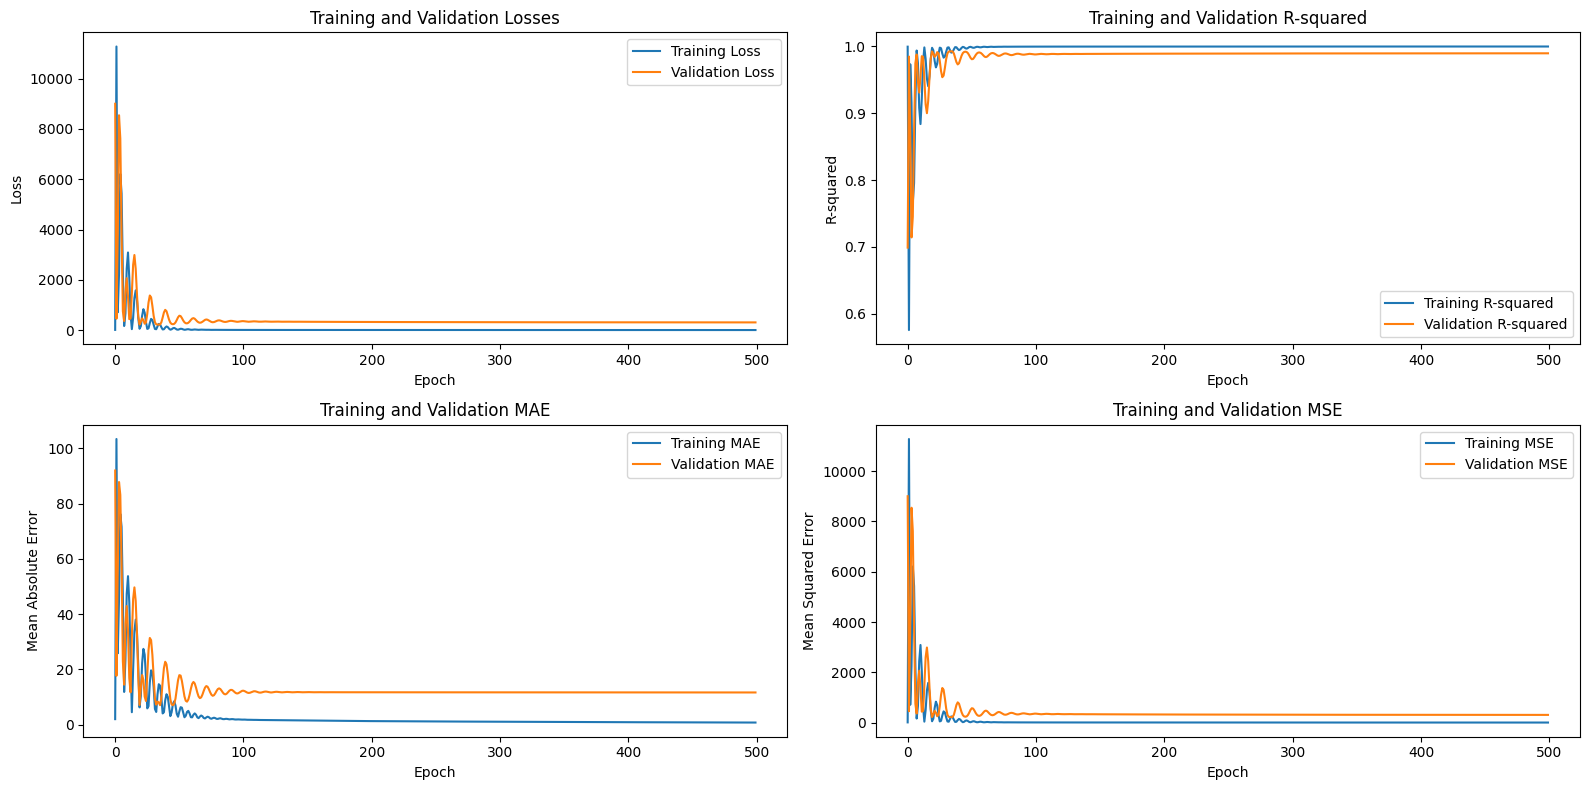

Test Loss: 4785.6552734375, Test R-squared: 0.9051281895216531, Test MAE: 33.19365310668945, Test MSE: 4785.6552734375


In [18]:
from google.colab import drive
import os
import torch
import joblib
from torch_geometric.nn import SAGEConv
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
model_filename = 'pegnn_model_reduced_features.pth'  # Custom filename used previously
model_path = os.path.join(drive_path, model_filename)
study_path = os.path.join(drive_path, 'optuna_study_pegnn_reduced_features.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_reduced_features.pkl')

# Function to load the model
def load_model(model_class, path, in_channels, hidden_channels, out_channels):
    model = model_class(in_channels, hidden_channels, out_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to load input feature size
def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Reload the Optuna study
with open(study_path, 'rb') as f:
    loaded_study = joblib.load(f)

best_params = loaded_study.best_params
print("Best parameters: ", best_params)

# Reload the input feature size
input_feature_size = load_input_feature_size(input_size_path)

# Define the PEGNN model class
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Assuming train_coords_pegnn, val_coords_pegnn, test_coords_pegnn, train_features_pegnn, val_features_pegnn, and test_features_pegnn are defined
d_model = 128

def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

def position_encoding(coords, d_model):
    pe = torch.zeros((coords.shape[0], d_model))
    for i in range(coords.shape[0]):
        for j in range(d_model // 2):
            pe[i, 2 * j] = torch.sin(coords[i, 0] / (10000 ** (2 * j / d_model)))
            pe[i, 2 * j + 1] = torch.cos(coords[i, 1] / (10000 ** (2 * j / d_model)))
    return pe

edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

pos_enc_train = position_encoding(torch.tensor(train_coords_pegnn, dtype=torch.float), d_model)
pos_enc_val = position_encoding(torch.tensor(val_coords_pegnn, dtype=torch.float), d_model)
pos_enc_test = position_encoding(torch.tensor(test_coords_pegnn, dtype=torch.float), d_model)

x_train = torch.cat([torch.tensor(train_features_pegnn.values, dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.values, dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.values, dtype=torch.float), pos_enc_test], dim=1)
y_train = torch.tensor(train_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn.values, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn.values, dtype=torch.float).view(-1, 1)

# Load the model with the best hyperparameters
loaded_model = load_model(PEGNN, model_path, input_feature_size, best_params['hidden_channels'], 1)

# Set the model to evaluation mode
loaded_model.eval()

# Create the optimizer and loss function
optimizer = torch.optim.Adam(loaded_model.parameters(), lr=best_params['lr'])
loss_fn = torch.nn.MSELoss()

# Train the model and compute metrics
train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

loaded_model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = loaded_model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    loaded_model.eval()
    with torch.no_grad():
        out_val = loaded_model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')
    loaded_model.train()

# Save the final model
# save_model(loaded_model, model_path)  # Uncomment if you want to save the model again

plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

loaded_model.eval()
with torch.no_grad():
    out_test = loaded_model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()
    test_r2 = r2_score(y_test_np, out_test_np)
    test_mae = mean_absolute_error(y_test_np, out_test_np)
    test_mse = mean_squared_error(y_test_np, out_test_np)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

